In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
boston = load_boston(return_X_y=False)

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=50)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)
X_train_norm = X_train.add(-1, X_train_mean) / X_train_std


y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

train_data = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(13, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [4]:
class evaluation(object):
    def __init__(self, test_data, n_samples, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0
        self.avg_prediction = 0.
        self.sum_pp = 0.
        self.sumsqr_pp = 0.
        self.preds = torch.zeros(len(test_data.dataset),n_samples)

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean).float() / self.X_std

                standard_pred = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean
                
                self.preds[:,self.n-1] = standard_pred.view(-1,)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + standard_pred.view(-1,1) / self.n
                self.sum_pp += standard_pred
                self.sumsqr_pp += standard_pred * standard_pred
                std_pred = torch.sqrt((self.sumsqr_pp - (self.sum_pp * self.sum_pp) / self.n) / (self.n - 1))



                norm = torch.distributions.normal.Normal(y, std_pred)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5

                return rmse, test_ll, self.preds

In [5]:
def gelman_rubin(x, return_var=False):
    m, n = x.size()

    var_between = torch.sum((torch.mean(x, 1) - torch.mean(x)) ** 2) / (m - 1)
    x_bar = torch.mean(x, 1).view(-1,1)

    var_within = torch.sum((x - x_bar) ** 2) / (m * (n - 1))

    var = var_within * (n - 1) / n + var_between

    if return_var:
        return var

    V = var_within + var_between / n

    return torch.sqrt(V / var_within)

def ess(x):
    m, n = x.size()
    
    s_sq = gelman_rubin(x, return_var = True)
    
    neg_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t]) ** 2 for i in range(t,n)) for j in range(m)) / (m * (n - t)))
    
    rho = torch.ones(n)
    
    while not neg_autocorr and (t < n):
        rho[t] = 1. - variogram(t) / (2. * s_sq)
        
        if not t % 2:
            neg_autocorr = sum(rho[(t-1):(t+1)]) < 0
        t += 1
        
    return float(m * n)/ (1. + 2. * rho[1:t].sum())

In [75]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-6
#3e-2



batch_size = 32.
dataset_size= 456.

n_samples = 300
n_chains = 10





losses_sgld = []
#test_rmse = []
#log_lik_sgld = []

ll_sgld = np.zeros((n_chains, n_samples))
rmse_sgld = np.zeros((n_chains, n_samples))




for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, predictions = evaluate.fn(network)
                
                ll_sgld[i, n] = ll
                rmse_sgld[i, n] = rmse

                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))
        

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 11.8256
chain 0 - epoch 1 - loss: 7.7295
chain 0 - epoch 2 - loss: 6.2508
chain 0 - epoch 3 - loss: 5.5996
chain 0 - epoch 4 - loss: 5.1934
chain 0 - epoch 5 - loss: 4.9377
chain 0 - epoch 6 - loss: 4.8108
chain 0 - epoch 7 - loss: 4.6885
chain 0 - epoch 8 - loss: 4.5859
chain 0 - epoch 9 - loss: 4.5376
chain 0 - epoch 10 - loss: 4.4553
chain 0 - epoch 11 - loss: 4.4035
chain 0 - epoch 12 - loss: 4.3452
chain 0 - epoch 13 - loss: 4.3166
chain 0 - epoch 14 - loss: 4.2772
chain 0 - epoch 15 - loss: 4.2460
chain 0 - epoch 16 - loss: 4.2322
chain 0 - epoch 17 - loss: 4.1746
chain 0 - epoch 18 - loss: 4.1328
chain 0 - epoch 19 - loss: 4.1323
chain 0 - epoch 20 - loss: 4.0565


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 21 - loss: 4.0304
chain 0 - epoch 22 - loss: 3.9890
chain 0 - epoch 23 - loss: 3.9661
chain 0 - epoch 24 - loss: 3.9425
chain 0 - epoch 25 - loss: 3.9399
chain 0 - epoch 26 - loss: 3.9020
chain 0 - epoch 27 - loss: 3.8885
chain 0 - epoch 28 - loss: 3.8768
chain 0 - epoch 29 - loss: 3.8289
chain 0 - epoch 30 - loss: 3.8100
chain 0 - epoch 31 - loss: 3.7997
chain 0 - epoch 32 - loss: 3.8010
chain 0 - epoch 33 - loss: 3.7534
chain 0 - epoch 34 - loss: 3.7385
chain 0 - epoch 35 - loss: 3.7235
chain 0 - epoch 36 - loss: 3.6768
chain 0 - epoch 37 - loss: 3.6556
chain 0 - epoch 38 - loss: 3.6250
chain 0 - epoch 39 - loss: 3.6117
chain 0 - epoch 40 - loss: 3.5792
chain 0 - epoch 41 - loss: 3.5618
chain 0 - epoch 42 - loss: 3.5474
chain 0 - epoch 43 - loss: 3.5519
chain 0 - epoch 44 - loss: 3.5038
chain 0 - epoch 45 - loss: 3.4836
chain 0 - epoch 46 - loss: 3.4772
chain 0 - epoch 47 - loss: 3.4486
chain 0 - epoch 48 - loss: 3.3730
chain 0 - epoch 49 - loss: 3.3787
chain 0 - epoc

chain 0 - epoch 258 - loss: 1.2670
chain 0 - epoch 259 - loss: 1.2556
chain 0 - epoch 260 - loss: 1.2350
chain 0 - epoch 261 - loss: 1.2111
chain 0 - epoch 262 - loss: 1.2143
chain 0 - epoch 263 - loss: 1.2119
chain 0 - epoch 264 - loss: 1.2155
chain 0 - epoch 265 - loss: 1.2277
chain 0 - epoch 266 - loss: 1.2158
chain 0 - epoch 267 - loss: 1.1867
chain 0 - epoch 268 - loss: 1.1953
chain 0 - epoch 269 - loss: 1.1607
chain 0 - epoch 270 - loss: 1.2003
chain 0 - epoch 271 - loss: 1.1619
chain 0 - epoch 272 - loss: 1.1884
chain 0 - epoch 273 - loss: 1.1887
chain 0 - epoch 274 - loss: 1.2003
chain 0 - epoch 275 - loss: 1.2087
chain 0 - epoch 276 - loss: 1.1915
chain 0 - epoch 277 - loss: 1.1954
chain 0 - epoch 278 - loss: 1.1895
chain 0 - epoch 279 - loss: 1.1900
chain 0 - epoch 280 - loss: 1.1774
chain 0 - epoch 281 - loss: 1.1724
chain 0 - epoch 282 - loss: 1.1719
chain 0 - epoch 283 - loss: 1.1684
chain 0 - epoch 284 - loss: 1.1524
chain 0 - epoch 285 - loss: 1.1726
chain 0 - epoch 286 

chain 0 - epoch 499 - loss: 1.0211
chain 0 - epoch 500 - loss: 0.8951
chain 0 - epoch 501 - loss: 0.8568
chain 0 - epoch 502 - loss: 0.8863
chain 0 - epoch 503 - loss: 0.8844
chain 0 - epoch 504 - loss: 0.9473
chain 0 - epoch 505 - loss: 0.8990
chain 0 - epoch 506 - loss: 0.9329
chain 0 - epoch 507 - loss: 0.8377
chain 0 - epoch 508 - loss: 0.8558
chain 0 - epoch 509 - loss: 0.8610
chain 0 - epoch 510 - loss: 0.8678
chain 0 - epoch 511 - loss: 0.8450
chain 0 - epoch 512 - loss: 0.8628
chain 0 - epoch 513 - loss: 0.8351
chain 0 - epoch 514 - loss: 0.8469
chain 0 - epoch 515 - loss: 0.8585
chain 0 - epoch 516 - loss: 0.9089
chain 0 - epoch 517 - loss: 0.8517
chain 0 - epoch 518 - loss: 0.8996
chain 0 - epoch 519 - loss: 0.8896
chain 0 - epoch 520 - loss: 0.8655
chain 0 - epoch 521 - loss: 0.8849
chain 0 - epoch 522 - loss: 0.9207
chain 0 - epoch 523 - loss: 0.8894
chain 0 - epoch 524 - loss: 0.9383
chain 0 - epoch 525 - loss: 0.9097
chain 0 - epoch 526 - loss: 0.9642
chain 0 - epoch 527 

chain 0 - epoch 735 - loss: 0.8245
chain 0 - epoch 736 - loss: 0.8303
chain 0 - epoch 737 - loss: 0.8412
chain 0 - epoch 738 - loss: 0.7981
chain 0 - epoch 739 - loss: 0.8032
chain 0 - epoch 740 - loss: 0.8106
chain 0 - epoch 741 - loss: 0.9022
chain 0 - epoch 742 - loss: 0.8192
chain 0 - epoch 743 - loss: 0.8743
chain 0 - epoch 744 - loss: 0.8296
chain 0 - epoch 745 - loss: 0.8184
chain 0 - epoch 746 - loss: 0.8299
chain 0 - epoch 747 - loss: 0.9173
chain 0 - epoch 748 - loss: 0.9088
chain 0 - epoch 749 - loss: 0.8074
chain 0 - epoch 750 - loss: 0.9270
chain 0 - epoch 751 - loss: 0.8087
chain 0 - epoch 752 - loss: 0.8084
chain 0 - epoch 753 - loss: 0.8706
chain 0 - epoch 754 - loss: 0.9737
chain 0 - epoch 755 - loss: 0.8125
chain 0 - epoch 756 - loss: 0.7941
chain 0 - epoch 757 - loss: 0.7582
chain 0 - epoch 758 - loss: 0.7514
chain 0 - epoch 759 - loss: 0.7696
chain 0 - epoch 760 - loss: 0.7162
chain 0 - epoch 761 - loss: 0.7852
chain 0 - epoch 762 - loss: 0.7160
chain 0 - epoch 763 

chain 0 - epoch 979 - loss: 0.6586
chain 0 - epoch 980 - loss: 0.6446
chain 0 - epoch 981 - loss: 0.7192
chain 0 - epoch 982 - loss: 0.6704
chain 0 - epoch 983 - loss: 0.7582
chain 0 - epoch 984 - loss: 0.9916
chain 0 - epoch 985 - loss: 0.6587
chain 0 - epoch 986 - loss: 0.7976
chain 0 - epoch 987 - loss: 0.6863
chain 0 - epoch 988 - loss: 0.8743
chain 0 - epoch 989 - loss: 0.6369
chain 0 - epoch 990 - loss: 0.7226
chain 0 - epoch 991 - loss: 0.6390
chain 0 - epoch 992 - loss: 0.6749
chain 0 - epoch 993 - loss: 0.6421
chain 0 - epoch 994 - loss: 0.6318
chain 0 - epoch 995 - loss: 0.6141
chain 0 - epoch 996 - loss: 0.8076
chain 0 - epoch 997 - loss: 0.6603
chain 0 - epoch 998 - loss: 0.6535
chain 0 - epoch 999 - loss: 0.7234
chain 0 - epoch 1000 - loss: 0.7743
chain 0 - epoch 1001 - loss: 0.6642
chain 0 - epoch 1002 - loss: 0.6622
chain 0 - epoch 1003 - loss: 0.6571
chain 0 - epoch 1004 - loss: 0.6312
chain 0 - epoch 1005 - loss: 0.6350
chain 0 - epoch 1006 - loss: 0.6978
chain 0 - epo

chain 0 - epoch 1212 - loss: 0.5283
chain 0 - epoch 1213 - loss: 0.4974
chain 0 - epoch 1214 - loss: 0.5339
chain 0 - epoch 1215 - loss: 0.5209
chain 0 - epoch 1216 - loss: 0.5738
chain 0 - epoch 1217 - loss: 0.5749
chain 0 - epoch 1218 - loss: 0.5626
chain 0 - epoch 1219 - loss: 0.5079
chain 0 - epoch 1220 - loss: 0.5407
chain 0 - epoch 1221 - loss: 0.6005
chain 0 - epoch 1222 - loss: 0.6202
chain 0 - epoch 1223 - loss: 0.5853
chain 0 - epoch 1224 - loss: 0.5089
chain 0 - epoch 1225 - loss: 0.5298
chain 0 - epoch 1226 - loss: 0.5955
chain 0 - epoch 1227 - loss: 0.5619
chain 0 - epoch 1228 - loss: 0.5316
chain 0 - epoch 1229 - loss: 0.4825
chain 0 - epoch 1230 - loss: 0.5037
chain 0 - epoch 1231 - loss: 0.5128
chain 0 - epoch 1232 - loss: 0.5328
chain 0 - epoch 1233 - loss: 0.5156
chain 0 - epoch 1234 - loss: 0.5247
chain 0 - epoch 1235 - loss: 0.5020
chain 0 - epoch 1236 - loss: 0.5192
chain 0 - epoch 1237 - loss: 0.5099
chain 0 - epoch 1238 - loss: 0.4929
chain 0 - epoch 1239 - loss:

chain 0 - epoch 1441 - loss: 0.4721
chain 0 - epoch 1442 - loss: 0.4853
chain 0 - epoch 1443 - loss: 0.6135
chain 0 - epoch 1444 - loss: 0.6095
chain 0 - epoch 1445 - loss: 0.6496
chain 0 - epoch 1446 - loss: 0.8627
chain 0 - epoch 1447 - loss: 0.4967
chain 0 - epoch 1448 - loss: 0.5329
chain 0 - epoch 1449 - loss: 0.5393
chain 0 - epoch 1450 - loss: 0.5121
chain 0 - epoch 1451 - loss: 0.6576
chain 0 - epoch 1452 - loss: 0.4944
chain 0 - epoch 1453 - loss: 0.5286
chain 0 - epoch 1454 - loss: 0.4898
chain 0 - epoch 1455 - loss: 0.4881
chain 0 - epoch 1456 - loss: 0.5313
chain 0 - epoch 1457 - loss: 0.5075
chain 0 - epoch 1458 - loss: 0.5070
chain 0 - epoch 1459 - loss: 0.5445
chain 0 - epoch 1460 - loss: 0.5524
chain 0 - epoch 1461 - loss: 0.5716
chain 0 - epoch 1462 - loss: 0.5445
chain 0 - epoch 1463 - loss: 0.5335
chain 0 - epoch 1464 - loss: 0.5959
chain 0 - epoch 1465 - loss: 0.6872
chain 0 - epoch 1466 - loss: 0.5051
chain 0 - epoch 1467 - loss: 0.5356
chain 0 - epoch 1468 - loss:

chain 0 - epoch 1672 - loss: 0.4486
chain 0 - epoch 1673 - loss: 0.4606
chain 0 - epoch 1674 - loss: 0.5228
chain 0 - epoch 1675 - loss: 0.4779
chain 0 - epoch 1676 - loss: 0.4248
chain 0 - epoch 1677 - loss: 0.4695
chain 0 - epoch 1678 - loss: 0.4358
chain 0 - epoch 1679 - loss: 0.4582
chain 0 - epoch 1680 - loss: 0.4294
chain 0 - epoch 1681 - loss: 0.4070
chain 0 - epoch 1682 - loss: 0.4196
chain 0 - epoch 1683 - loss: 0.4355
chain 0 - epoch 1684 - loss: 0.4385
chain 0 - epoch 1685 - loss: 0.4191
chain 0 - epoch 1686 - loss: 0.4475
chain 0 - epoch 1687 - loss: 0.4613
chain 0 - epoch 1688 - loss: 0.4966
chain 0 - epoch 1689 - loss: 0.4505
chain 0 - epoch 1690 - loss: 0.5957
chain 0 - epoch 1691 - loss: 0.4403
chain 0 - epoch 1692 - loss: 0.4402
chain 0 - epoch 1693 - loss: 0.5534
chain 0 - epoch 1694 - loss: 0.4440
chain 0 - epoch 1695 - loss: 0.5013
chain 0 - epoch 1696 - loss: 0.4890
chain 0 - epoch 1697 - loss: 0.4352
chain 0 - epoch 1698 - loss: 0.5177
chain 0 - epoch 1699 - loss:

chain 0 - epoch 1900 - loss: 0.4286
chain 0 - epoch 1901 - loss: 0.7069
chain 0 - epoch 1902 - loss: 0.5626
chain 0 - epoch 1903 - loss: 0.4623
chain 0 - epoch 1904 - loss: 0.4579
chain 0 - epoch 1905 - loss: 0.5206
chain 0 - epoch 1906 - loss: 0.4595
chain 0 - epoch 1907 - loss: 0.4577
chain 0 - epoch 1908 - loss: 0.5195
chain 0 - epoch 1909 - loss: 0.5333
chain 0 - epoch 1910 - loss: 0.4728
chain 0 - epoch 1911 - loss: 0.4720
chain 0 - epoch 1912 - loss: 0.4599
chain 0 - epoch 1913 - loss: 0.4511
chain 0 - epoch 1914 - loss: 0.4499
chain 0 - epoch 1915 - loss: 0.5241
chain 0 - epoch 1916 - loss: 0.4259
chain 0 - epoch 1917 - loss: 0.4304
chain 0 - epoch 1918 - loss: 0.4066
chain 0 - epoch 1919 - loss: 0.4087
chain 0 - epoch 1920 - loss: 0.3877
chain 0 - epoch 1921 - loss: 0.4390
chain 0 - epoch 1922 - loss: 0.4242
chain 0 - epoch 1923 - loss: 0.4222
chain 0 - epoch 1924 - loss: 0.4161
chain 0 - epoch 1925 - loss: 0.4516
chain 0 - epoch 1926 - loss: 0.4267
chain 0 - epoch 1927 - loss:

chain 0 - epoch 2130 - loss: 0.4131
chain 0 - epoch 2131 - loss: 0.4192
chain 0 - epoch 2132 - loss: 0.4502
chain 0 - epoch 2133 - loss: 0.4767
chain 0 - epoch 2134 - loss: 0.4279
chain 0 - epoch 2135 - loss: 0.4053
chain 0 - epoch 2136 - loss: 0.4080
chain 0 - epoch 2137 - loss: 0.4183
chain 0 - epoch 2138 - loss: 0.3812
chain 0 - epoch 2139 - loss: 0.4183
chain 0 - epoch 2140 - loss: 0.4119
chain 0 - epoch 2141 - loss: 0.4527
chain 0 - epoch 2142 - loss: 0.4188
chain 0 - epoch 2143 - loss: 0.4555
chain 0 - epoch 2144 - loss: 0.4208
chain 0 - epoch 2145 - loss: 0.4216
chain 0 - epoch 2146 - loss: 0.4170
chain 0 - epoch 2147 - loss: 0.4378
chain 0 - epoch 2148 - loss: 0.4546
chain 0 - epoch 2149 - loss: 0.4754
chain 0 - epoch 2150 - loss: 0.4302
chain 0 - epoch 2151 - loss: 0.4310
chain 0 - epoch 2152 - loss: 0.4270
chain 0 - epoch 2153 - loss: 0.4831
chain 0 - epoch 2154 - loss: 0.4414
chain 0 - epoch 2155 - loss: 0.4899
chain 0 - epoch 2156 - loss: 0.5596
chain 0 - epoch 2157 - loss:

chain 0 - epoch 2361 - loss: 0.3893
chain 0 - epoch 2362 - loss: 0.3757
chain 0 - epoch 2363 - loss: 0.3751
chain 0 - epoch 2364 - loss: 0.4074
chain 0 - epoch 2365 - loss: 0.3832
chain 0 - epoch 2366 - loss: 0.4042
chain 0 - epoch 2367 - loss: 0.3783
chain 0 - epoch 2368 - loss: 0.4071
chain 0 - epoch 2369 - loss: 0.3856
chain 0 - epoch 2370 - loss: 0.4021
chain 0 - epoch 2371 - loss: 0.3863
chain 0 - epoch 2372 - loss: 0.3948
chain 0 - epoch 2373 - loss: 0.3913
chain 0 - epoch 2374 - loss: 0.3978
chain 0 - epoch 2375 - loss: 0.4187
chain 0 - epoch 2376 - loss: 0.3833
chain 0 - epoch 2377 - loss: 0.3926
chain 0 - epoch 2378 - loss: 0.4132
chain 0 - epoch 2379 - loss: 0.4089
chain 0 - epoch 2380 - loss: 0.3981
chain 0 - epoch 2381 - loss: 0.4079
chain 0 - epoch 2382 - loss: 0.3997
chain 0 - epoch 2383 - loss: 0.3775
chain 0 - epoch 2384 - loss: 0.3768
chain 0 - epoch 2385 - loss: 0.3775
chain 0 - epoch 2386 - loss: 0.3796
chain 0 - epoch 2387 - loss: 0.3950
chain 0 - epoch 2388 - loss:

chain 1 - epoch 95 - loss: 2.2935
chain 1 - epoch 96 - loss: 2.2664
chain 1 - epoch 97 - loss: 2.2536
chain 1 - epoch 98 - loss: 2.1949
chain 1 - epoch 99 - loss: 2.2338
chain 1 - epoch 100 - loss: 2.2292
chain 1 - epoch 101 - loss: 2.1986
chain 1 - epoch 102 - loss: 2.2109
chain 1 - epoch 103 - loss: 2.1859
chain 1 - epoch 104 - loss: 2.1833
chain 1 - epoch 105 - loss: 2.2063
chain 1 - epoch 106 - loss: 2.1609
chain 1 - epoch 107 - loss: 2.1782
chain 1 - epoch 108 - loss: 2.1422
chain 1 - epoch 109 - loss: 2.1593
chain 1 - epoch 110 - loss: 2.1269
chain 1 - epoch 111 - loss: 2.1133
chain 1 - epoch 112 - loss: 2.1300
chain 1 - epoch 113 - loss: 2.1179
chain 1 - epoch 114 - loss: 2.0950
chain 1 - epoch 115 - loss: 2.1136
chain 1 - epoch 116 - loss: 2.1021
chain 1 - epoch 117 - loss: 2.0772
chain 1 - epoch 118 - loss: 2.0625
chain 1 - epoch 119 - loss: 2.0760
chain 1 - epoch 120 - loss: 2.0446
chain 1 - epoch 121 - loss: 2.0275
chain 1 - epoch 122 - loss: 2.0115
chain 1 - epoch 123 - los

chain 1 - epoch 333 - loss: 1.1133
chain 1 - epoch 334 - loss: 1.1300
chain 1 - epoch 335 - loss: 1.1526
chain 1 - epoch 336 - loss: 1.1512
chain 1 - epoch 337 - loss: 1.1122
chain 1 - epoch 338 - loss: 1.1697
chain 1 - epoch 339 - loss: 1.1148
chain 1 - epoch 340 - loss: 1.1156
chain 1 - epoch 341 - loss: 1.0824
chain 1 - epoch 342 - loss: 1.1286
chain 1 - epoch 343 - loss: 1.0968
chain 1 - epoch 344 - loss: 1.1571
chain 1 - epoch 345 - loss: 1.1395
chain 1 - epoch 346 - loss: 1.0840
chain 1 - epoch 347 - loss: 1.1555
chain 1 - epoch 348 - loss: 1.1449
chain 1 - epoch 349 - loss: 1.1208
chain 1 - epoch 350 - loss: 1.1609
chain 1 - epoch 351 - loss: 1.0923
chain 1 - epoch 352 - loss: 1.1014
chain 1 - epoch 353 - loss: 1.0685
chain 1 - epoch 354 - loss: 1.1351
chain 1 - epoch 355 - loss: 1.1280
chain 1 - epoch 356 - loss: 1.1378
chain 1 - epoch 357 - loss: 1.1577
chain 1 - epoch 358 - loss: 1.1254
chain 1 - epoch 359 - loss: 1.1216
chain 1 - epoch 360 - loss: 1.1160
chain 1 - epoch 361 

chain 1 - epoch 577 - loss: 0.9409
chain 1 - epoch 578 - loss: 0.9030
chain 1 - epoch 579 - loss: 0.8740
chain 1 - epoch 580 - loss: 0.8624
chain 1 - epoch 581 - loss: 0.8337
chain 1 - epoch 582 - loss: 0.9301
chain 1 - epoch 583 - loss: 0.9643
chain 1 - epoch 584 - loss: 1.0380
chain 1 - epoch 585 - loss: 1.1610
chain 1 - epoch 586 - loss: 0.8928
chain 1 - epoch 587 - loss: 0.8329
chain 1 - epoch 588 - loss: 0.9137
chain 1 - epoch 589 - loss: 1.0859
chain 1 - epoch 590 - loss: 0.9602
chain 1 - epoch 591 - loss: 0.8385
chain 1 - epoch 592 - loss: 0.8912
chain 1 - epoch 593 - loss: 0.8533
chain 1 - epoch 594 - loss: 0.8745
chain 1 - epoch 595 - loss: 0.8661
chain 1 - epoch 596 - loss: 0.9718
chain 1 - epoch 597 - loss: 0.8223
chain 1 - epoch 598 - loss: 0.8008
chain 1 - epoch 599 - loss: 0.8903
chain 1 - epoch 600 - loss: 0.9191
chain 1 - epoch 601 - loss: 0.8711
chain 1 - epoch 602 - loss: 0.8189
chain 1 - epoch 603 - loss: 1.3101
chain 1 - epoch 604 - loss: 1.1699
chain 1 - epoch 605 

chain 1 - epoch 812 - loss: 0.7481
chain 1 - epoch 813 - loss: 0.9069
chain 1 - epoch 814 - loss: 1.3703
chain 1 - epoch 815 - loss: 0.9141
chain 1 - epoch 816 - loss: 0.7071
chain 1 - epoch 817 - loss: 0.6438
chain 1 - epoch 818 - loss: 0.9767
chain 1 - epoch 819 - loss: 0.8028
chain 1 - epoch 820 - loss: 0.6408
chain 1 - epoch 821 - loss: 0.6706
chain 1 - epoch 822 - loss: 0.6473
chain 1 - epoch 823 - loss: 0.6237
chain 1 - epoch 824 - loss: 0.7048
chain 1 - epoch 825 - loss: 0.6674
chain 1 - epoch 826 - loss: 0.6444
chain 1 - epoch 827 - loss: 0.6715
chain 1 - epoch 828 - loss: 0.6697
chain 1 - epoch 829 - loss: 0.6414
chain 1 - epoch 830 - loss: 0.6909
chain 1 - epoch 831 - loss: 0.6364
chain 1 - epoch 832 - loss: 0.8693
chain 1 - epoch 833 - loss: 0.8646
chain 1 - epoch 834 - loss: 0.8153
chain 1 - epoch 835 - loss: 0.7206
chain 1 - epoch 836 - loss: 0.6748
chain 1 - epoch 837 - loss: 0.6440
chain 1 - epoch 838 - loss: 0.6950
chain 1 - epoch 839 - loss: 0.8485
chain 1 - epoch 840 

chain 1 - epoch 1053 - loss: 1.0722
chain 1 - epoch 1054 - loss: 0.5785
chain 1 - epoch 1055 - loss: 0.5565
chain 1 - epoch 1056 - loss: 0.5645
chain 1 - epoch 1057 - loss: 0.5273
chain 1 - epoch 1058 - loss: 0.6009
chain 1 - epoch 1059 - loss: 0.5958
chain 1 - epoch 1060 - loss: 1.0823
chain 1 - epoch 1061 - loss: 0.5928
chain 1 - epoch 1062 - loss: 0.8275
chain 1 - epoch 1063 - loss: 0.6829
chain 1 - epoch 1064 - loss: 0.6084
chain 1 - epoch 1065 - loss: 0.5307
chain 1 - epoch 1066 - loss: 0.5619
chain 1 - epoch 1067 - loss: 0.5963
chain 1 - epoch 1068 - loss: 0.6227
chain 1 - epoch 1069 - loss: 0.6119
chain 1 - epoch 1070 - loss: 0.5635
chain 1 - epoch 1071 - loss: 0.5574
chain 1 - epoch 1072 - loss: 0.5987
chain 1 - epoch 1073 - loss: 0.5609
chain 1 - epoch 1074 - loss: 0.5983
chain 1 - epoch 1075 - loss: 0.5978
chain 1 - epoch 1076 - loss: 0.8162
chain 1 - epoch 1077 - loss: 0.9169
chain 1 - epoch 1078 - loss: 0.6778
chain 1 - epoch 1079 - loss: 0.5557
chain 1 - epoch 1080 - loss:

chain 1 - epoch 1288 - loss: 0.5127
chain 1 - epoch 1289 - loss: 0.4753
chain 1 - epoch 1290 - loss: 0.5043
chain 1 - epoch 1291 - loss: 0.4804
chain 1 - epoch 1292 - loss: 0.5129
chain 1 - epoch 1293 - loss: 0.4648
chain 1 - epoch 1294 - loss: 0.4851
chain 1 - epoch 1295 - loss: 0.4915
chain 1 - epoch 1296 - loss: 0.4644
chain 1 - epoch 1297 - loss: 0.4895
chain 1 - epoch 1298 - loss: 0.4721
chain 1 - epoch 1299 - loss: 0.4830
chain 1 - epoch 1300 - loss: 0.5264
chain 1 - epoch 1301 - loss: 0.5664
chain 1 - epoch 1302 - loss: 0.5126
chain 1 - epoch 1303 - loss: 0.5156
chain 1 - epoch 1304 - loss: 0.5073
chain 1 - epoch 1305 - loss: 0.5910
chain 1 - epoch 1306 - loss: 0.5606
chain 1 - epoch 1307 - loss: 0.5357
chain 1 - epoch 1308 - loss: 0.4759
chain 1 - epoch 1309 - loss: 0.4938
chain 1 - epoch 1310 - loss: 0.4569
chain 1 - epoch 1311 - loss: 0.4776
chain 1 - epoch 1312 - loss: 0.4608
chain 1 - epoch 1313 - loss: 0.5691
chain 1 - epoch 1314 - loss: 0.5609
chain 1 - epoch 1315 - loss:

chain 1 - epoch 1518 - loss: 0.4652
chain 1 - epoch 1519 - loss: 0.4817
chain 1 - epoch 1520 - loss: 0.4597
chain 1 - epoch 1521 - loss: 0.5030
chain 1 - epoch 1522 - loss: 0.5254
chain 1 - epoch 1523 - loss: 0.4796
chain 1 - epoch 1524 - loss: 0.6014
chain 1 - epoch 1525 - loss: 0.5160
chain 1 - epoch 1526 - loss: 0.5208
chain 1 - epoch 1527 - loss: 0.5359
chain 1 - epoch 1528 - loss: 0.5036
chain 1 - epoch 1529 - loss: 0.4715
chain 1 - epoch 1530 - loss: 0.4941
chain 1 - epoch 1531 - loss: 0.4914
chain 1 - epoch 1532 - loss: 0.4696
chain 1 - epoch 1533 - loss: 0.4631
chain 1 - epoch 1534 - loss: 0.5143
chain 1 - epoch 1535 - loss: 0.4909
chain 1 - epoch 1536 - loss: 0.4890
chain 1 - epoch 1537 - loss: 0.4928
chain 1 - epoch 1538 - loss: 0.4539
chain 1 - epoch 1539 - loss: 0.5171
chain 1 - epoch 1540 - loss: 0.5434
chain 1 - epoch 1541 - loss: 0.5180
chain 1 - epoch 1542 - loss: 0.4685
chain 1 - epoch 1543 - loss: 0.4634
chain 1 - epoch 1544 - loss: 0.6711
chain 1 - epoch 1545 - loss:

chain 1 - epoch 1754 - loss: 0.4444
chain 1 - epoch 1755 - loss: 0.4532
chain 1 - epoch 1756 - loss: 0.4733
chain 1 - epoch 1757 - loss: 0.4344
chain 1 - epoch 1758 - loss: 0.4872
chain 1 - epoch 1759 - loss: 0.4629
chain 1 - epoch 1760 - loss: 0.5383
chain 1 - epoch 1761 - loss: 0.5237
chain 1 - epoch 1762 - loss: 0.4518
chain 1 - epoch 1763 - loss: 0.4069
chain 1 - epoch 1764 - loss: 0.4722
chain 1 - epoch 1765 - loss: 0.4568
chain 1 - epoch 1766 - loss: 0.4606
chain 1 - epoch 1767 - loss: 0.4583
chain 1 - epoch 1768 - loss: 0.4524
chain 1 - epoch 1769 - loss: 0.5033
chain 1 - epoch 1770 - loss: 0.4422
chain 1 - epoch 1771 - loss: 0.5108
chain 1 - epoch 1772 - loss: 0.5039
chain 1 - epoch 1773 - loss: 0.4338
chain 1 - epoch 1774 - loss: 0.4827
chain 1 - epoch 1775 - loss: 0.4695
chain 1 - epoch 1776 - loss: 0.4787
chain 1 - epoch 1777 - loss: 0.4487
chain 1 - epoch 1778 - loss: 0.4730
chain 1 - epoch 1779 - loss: 0.4233
chain 1 - epoch 1780 - loss: 0.4428
chain 1 - epoch 1781 - loss:

chain 1 - epoch 1982 - loss: 0.4219
chain 1 - epoch 1983 - loss: 0.4122
chain 1 - epoch 1984 - loss: 0.4112
chain 1 - epoch 1985 - loss: 0.4256
chain 1 - epoch 1986 - loss: 0.4057
chain 1 - epoch 1987 - loss: 0.4368
chain 1 - epoch 1988 - loss: 0.4121
chain 1 - epoch 1989 - loss: 0.4009
chain 1 - epoch 1990 - loss: 0.3850
chain 1 - epoch 1991 - loss: 0.5086
chain 1 - epoch 1992 - loss: 0.3787
chain 1 - epoch 1993 - loss: 0.4178
chain 1 - epoch 1994 - loss: 0.3953
chain 1 - epoch 1995 - loss: 0.4044
chain 1 - epoch 1996 - loss: 0.3926
chain 1 - epoch 1997 - loss: 0.3866
chain 1 - epoch 1998 - loss: 0.4049
chain 1 - epoch 1999 - loss: 0.3941
chain 1 - epoch 2000 - loss: 0.4486
chain 1 - epoch 2001 - loss: 0.4126
chain 1 - epoch 2002 - loss: 0.3892
chain 1 - epoch 2003 - loss: 0.4057
chain 1 - epoch 2004 - loss: 0.4153
chain 1 - epoch 2005 - loss: 0.4013
chain 1 - epoch 2006 - loss: 0.3968
chain 1 - epoch 2007 - loss: 0.3928
chain 1 - epoch 2008 - loss: 0.4014
chain 1 - epoch 2009 - loss:

chain 1 - epoch 2219 - loss: 0.4597
chain 1 - epoch 2220 - loss: 0.4032
chain 1 - epoch 2221 - loss: 0.4183
chain 1 - epoch 2222 - loss: 0.4256
chain 1 - epoch 2223 - loss: 0.4372
chain 1 - epoch 2224 - loss: 0.4377
chain 1 - epoch 2225 - loss: 0.3953
chain 1 - epoch 2226 - loss: 0.3938
chain 1 - epoch 2227 - loss: 0.4707
chain 1 - epoch 2228 - loss: 0.4135
chain 1 - epoch 2229 - loss: 0.4125
chain 1 - epoch 2230 - loss: 0.3805
chain 1 - epoch 2231 - loss: 0.3846
chain 1 - epoch 2232 - loss: 0.3618
chain 1 - epoch 2233 - loss: 0.3676
chain 1 - epoch 2234 - loss: 0.3873
chain 1 - epoch 2235 - loss: 0.4076
chain 1 - epoch 2236 - loss: 0.4305
chain 1 - epoch 2237 - loss: 0.3743
chain 1 - epoch 2238 - loss: 0.4123
chain 1 - epoch 2239 - loss: 0.4084
chain 1 - epoch 2240 - loss: 0.3870
chain 1 - epoch 2241 - loss: 0.5281
chain 1 - epoch 2242 - loss: 0.3942
chain 1 - epoch 2243 - loss: 0.4144
chain 1 - epoch 2244 - loss: 0.3750
chain 1 - epoch 2245 - loss: 0.4275
chain 1 - epoch 2246 - loss:

chain 1 - epoch 2457 - loss: 0.4315
chain 1 - epoch 2458 - loss: 0.3931
chain 1 - epoch 2459 - loss: 0.4103
chain 1 - epoch 2460 - loss: 0.3763
chain 1 - epoch 2461 - loss: 0.3918
chain 1 - epoch 2462 - loss: 0.3874
chain 1 - epoch 2463 - loss: 0.4225
chain 1 - epoch 2464 - loss: 0.3811
chain 1 - epoch 2465 - loss: 0.4146
chain 1 - epoch 2466 - loss: 0.4001
chain 1 - epoch 2467 - loss: 0.3825
chain 1 - epoch 2468 - loss: 0.3634
chain 1 - epoch 2469 - loss: 0.3839
chain 1 - epoch 2470 - loss: 0.3700
chain 1 - epoch 2471 - loss: 0.4061
chain 1 - epoch 2472 - loss: 0.4044
chain 1 - epoch 2473 - loss: 0.3870
chain 1 - epoch 2474 - loss: 0.4083
chain 1 - epoch 2475 - loss: 0.4178
chain 1 - epoch 2476 - loss: 0.4107
chain 1 - epoch 2477 - loss: 0.4132
chain 1 - epoch 2478 - loss: 0.3937
chain 1 - epoch 2479 - loss: 0.4166
chain 1 - epoch 2480 - loss: 0.4114
chain 1 - epoch 2481 - loss: 0.4063
chain 1 - epoch 2482 - loss: 0.4023
chain 1 - epoch 2483 - loss: 0.3837
chain 1 - epoch 2484 - loss:

chain 2 - epoch 196 - loss: 1.4940
chain 2 - epoch 197 - loss: 1.4921
chain 2 - epoch 198 - loss: 1.4899
chain 2 - epoch 199 - loss: 1.4446
chain 2 - epoch 200 - loss: 1.4646
chain 2 - epoch 201 - loss: 1.4622
chain 2 - epoch 202 - loss: 1.4713
chain 2 - epoch 203 - loss: 1.4226
chain 2 - epoch 204 - loss: 1.4625
chain 2 - epoch 205 - loss: 1.4288
chain 2 - epoch 206 - loss: 1.4438
chain 2 - epoch 207 - loss: 1.4361
chain 2 - epoch 208 - loss: 1.4695
chain 2 - epoch 209 - loss: 1.4595
chain 2 - epoch 210 - loss: 1.4044
chain 2 - epoch 211 - loss: 1.4186
chain 2 - epoch 212 - loss: 1.4219
chain 2 - epoch 213 - loss: 1.4746
chain 2 - epoch 214 - loss: 1.4455
chain 2 - epoch 215 - loss: 1.4719
chain 2 - epoch 216 - loss: 1.4332
chain 2 - epoch 217 - loss: 1.4592
chain 2 - epoch 218 - loss: 1.4040
chain 2 - epoch 219 - loss: 1.4491
chain 2 - epoch 220 - loss: 1.4192
chain 2 - epoch 221 - loss: 1.4270
chain 2 - epoch 222 - loss: 1.4074
chain 2 - epoch 223 - loss: 1.4122
chain 2 - epoch 224 

chain 2 - epoch 435 - loss: 0.9873
chain 2 - epoch 436 - loss: 1.0213
chain 2 - epoch 437 - loss: 0.9933
chain 2 - epoch 438 - loss: 0.9874
chain 2 - epoch 439 - loss: 1.0623
chain 2 - epoch 440 - loss: 1.0560
chain 2 - epoch 441 - loss: 1.0287
chain 2 - epoch 442 - loss: 1.0456
chain 2 - epoch 443 - loss: 1.0310
chain 2 - epoch 444 - loss: 1.0479
chain 2 - epoch 445 - loss: 1.0268
chain 2 - epoch 446 - loss: 1.0040
chain 2 - epoch 447 - loss: 1.0859
chain 2 - epoch 448 - loss: 1.0347
chain 2 - epoch 449 - loss: 1.0614
chain 2 - epoch 450 - loss: 1.1443
chain 2 - epoch 451 - loss: 1.0648
chain 2 - epoch 452 - loss: 1.0629
chain 2 - epoch 453 - loss: 1.0669
chain 2 - epoch 454 - loss: 1.1176
chain 2 - epoch 455 - loss: 1.0825
chain 2 - epoch 456 - loss: 1.0134
chain 2 - epoch 457 - loss: 1.0427
chain 2 - epoch 458 - loss: 1.0023
chain 2 - epoch 459 - loss: 0.9807
chain 2 - epoch 460 - loss: 0.9771
chain 2 - epoch 461 - loss: 1.0193
chain 2 - epoch 462 - loss: 0.9883
chain 2 - epoch 463 

chain 2 - epoch 678 - loss: 0.7378
chain 2 - epoch 679 - loss: 0.7664
chain 2 - epoch 680 - loss: 0.7466
chain 2 - epoch 681 - loss: 0.7641
chain 2 - epoch 682 - loss: 0.7290
chain 2 - epoch 683 - loss: 0.8099
chain 2 - epoch 684 - loss: 0.7764
chain 2 - epoch 685 - loss: 0.7739
chain 2 - epoch 686 - loss: 0.7868
chain 2 - epoch 687 - loss: 0.7753
chain 2 - epoch 688 - loss: 0.9803
chain 2 - epoch 689 - loss: 0.7811
chain 2 - epoch 690 - loss: 0.7648
chain 2 - epoch 691 - loss: 0.7832
chain 2 - epoch 692 - loss: 0.7491
chain 2 - epoch 693 - loss: 0.7600
chain 2 - epoch 694 - loss: 0.7744
chain 2 - epoch 695 - loss: 0.8355
chain 2 - epoch 696 - loss: 0.7674
chain 2 - epoch 697 - loss: 0.8252
chain 2 - epoch 698 - loss: 0.7899
chain 2 - epoch 699 - loss: 0.8577
chain 2 - epoch 700 - loss: 1.8070
chain 2 - epoch 701 - loss: 0.8682
chain 2 - epoch 702 - loss: 1.0312
chain 2 - epoch 703 - loss: 1.0912
chain 2 - epoch 704 - loss: 0.8169
chain 2 - epoch 705 - loss: 0.8626
chain 2 - epoch 706 

chain 2 - epoch 916 - loss: 0.6422
chain 2 - epoch 917 - loss: 0.6408
chain 2 - epoch 918 - loss: 0.6087
chain 2 - epoch 919 - loss: 0.6574
chain 2 - epoch 920 - loss: 0.6160
chain 2 - epoch 921 - loss: 0.5999
chain 2 - epoch 922 - loss: 0.6448
chain 2 - epoch 923 - loss: 0.6495
chain 2 - epoch 924 - loss: 0.5965
chain 2 - epoch 925 - loss: 0.6300
chain 2 - epoch 926 - loss: 0.7090
chain 2 - epoch 927 - loss: 0.6293
chain 2 - epoch 928 - loss: 0.6250
chain 2 - epoch 929 - loss: 0.6689
chain 2 - epoch 930 - loss: 0.6243
chain 2 - epoch 931 - loss: 0.7419
chain 2 - epoch 932 - loss: 0.6615
chain 2 - epoch 933 - loss: 0.7279
chain 2 - epoch 934 - loss: 0.6654
chain 2 - epoch 935 - loss: 0.6242
chain 2 - epoch 936 - loss: 0.6836
chain 2 - epoch 937 - loss: 0.6792
chain 2 - epoch 938 - loss: 0.6418
chain 2 - epoch 939 - loss: 0.7715
chain 2 - epoch 940 - loss: 0.6223
chain 2 - epoch 941 - loss: 0.6110
chain 2 - epoch 942 - loss: 0.7480
chain 2 - epoch 943 - loss: 0.7605
chain 2 - epoch 944 

chain 2 - epoch 1154 - loss: 0.5339
chain 2 - epoch 1155 - loss: 0.5409
chain 2 - epoch 1156 - loss: 0.5483
chain 2 - epoch 1157 - loss: 0.5340
chain 2 - epoch 1158 - loss: 0.5439
chain 2 - epoch 1159 - loss: 0.5115
chain 2 - epoch 1160 - loss: 0.5201
chain 2 - epoch 1161 - loss: 0.5084
chain 2 - epoch 1162 - loss: 0.5395
chain 2 - epoch 1163 - loss: 0.5361
chain 2 - epoch 1164 - loss: 0.5203
chain 2 - epoch 1165 - loss: 0.5390
chain 2 - epoch 1166 - loss: 0.5319
chain 2 - epoch 1167 - loss: 0.4961
chain 2 - epoch 1168 - loss: 0.5065
chain 2 - epoch 1169 - loss: 0.5088
chain 2 - epoch 1170 - loss: 0.5755
chain 2 - epoch 1171 - loss: 0.5395
chain 2 - epoch 1172 - loss: 0.5454
chain 2 - epoch 1173 - loss: 0.5412
chain 2 - epoch 1174 - loss: 0.5785
chain 2 - epoch 1175 - loss: 0.5193
chain 2 - epoch 1176 - loss: 0.5085
chain 2 - epoch 1177 - loss: 0.5442
chain 2 - epoch 1178 - loss: 0.5106
chain 2 - epoch 1179 - loss: 0.5125
chain 2 - epoch 1180 - loss: 0.5138
chain 2 - epoch 1181 - loss:

chain 2 - epoch 1383 - loss: 0.7295
chain 2 - epoch 1384 - loss: 0.6163
chain 2 - epoch 1385 - loss: 0.4676
chain 2 - epoch 1386 - loss: 0.4596
chain 2 - epoch 1387 - loss: 0.4927
chain 2 - epoch 1388 - loss: 0.5639
chain 2 - epoch 1389 - loss: 0.4851
chain 2 - epoch 1390 - loss: 0.4895
chain 2 - epoch 1391 - loss: 0.5091
chain 2 - epoch 1392 - loss: 0.5182
chain 2 - epoch 1393 - loss: 0.5913
chain 2 - epoch 1394 - loss: 0.5288
chain 2 - epoch 1395 - loss: 0.5216
chain 2 - epoch 1396 - loss: 0.5310
chain 2 - epoch 1397 - loss: 0.5230
chain 2 - epoch 1398 - loss: 0.5318
chain 2 - epoch 1399 - loss: 0.5654
chain 2 - epoch 1400 - loss: 0.7537
chain 2 - epoch 1401 - loss: 0.5826
chain 2 - epoch 1402 - loss: 0.7800
chain 2 - epoch 1403 - loss: 0.8763
chain 2 - epoch 1404 - loss: 0.7233
chain 2 - epoch 1405 - loss: 0.5999
chain 2 - epoch 1406 - loss: 0.5443
chain 2 - epoch 1407 - loss: 0.5179
chain 2 - epoch 1408 - loss: 0.5513
chain 2 - epoch 1409 - loss: 0.5163
chain 2 - epoch 1410 - loss:

chain 2 - epoch 1613 - loss: 0.5223
chain 2 - epoch 1614 - loss: 0.5085
chain 2 - epoch 1615 - loss: 0.5077
chain 2 - epoch 1616 - loss: 0.5434
chain 2 - epoch 1617 - loss: 0.5052
chain 2 - epoch 1618 - loss: 0.4952
chain 2 - epoch 1619 - loss: 0.4961
chain 2 - epoch 1620 - loss: 0.5198
chain 2 - epoch 1621 - loss: 0.5169
chain 2 - epoch 1622 - loss: 0.4964
chain 2 - epoch 1623 - loss: 0.4960
chain 2 - epoch 1624 - loss: 0.4965
chain 2 - epoch 1625 - loss: 0.5470
chain 2 - epoch 1626 - loss: 0.5337
chain 2 - epoch 1627 - loss: 0.5198
chain 2 - epoch 1628 - loss: 0.5047
chain 2 - epoch 1629 - loss: 0.5064
chain 2 - epoch 1630 - loss: 0.5222
chain 2 - epoch 1631 - loss: 0.5079
chain 2 - epoch 1632 - loss: 0.4793
chain 2 - epoch 1633 - loss: 0.5061
chain 2 - epoch 1634 - loss: 0.5107
chain 2 - epoch 1635 - loss: 0.4955
chain 2 - epoch 1636 - loss: 0.5007
chain 2 - epoch 1637 - loss: 0.5249
chain 2 - epoch 1638 - loss: 0.5271
chain 2 - epoch 1639 - loss: 0.5155
chain 2 - epoch 1640 - loss:

chain 2 - epoch 1849 - loss: 0.5192
chain 2 - epoch 1850 - loss: 0.5273
chain 2 - epoch 1851 - loss: 0.4669
chain 2 - epoch 1852 - loss: 0.4514
chain 2 - epoch 1853 - loss: 0.4686
chain 2 - epoch 1854 - loss: 0.4612
chain 2 - epoch 1855 - loss: 0.4586
chain 2 - epoch 1856 - loss: 0.4511
chain 2 - epoch 1857 - loss: 0.4718
chain 2 - epoch 1858 - loss: 0.4726
chain 2 - epoch 1859 - loss: 0.4747
chain 2 - epoch 1860 - loss: 0.4885
chain 2 - epoch 1861 - loss: 0.4505
chain 2 - epoch 1862 - loss: 0.4645
chain 2 - epoch 1863 - loss: 0.4880
chain 2 - epoch 1864 - loss: 0.4524
chain 2 - epoch 1865 - loss: 0.4494
chain 2 - epoch 1866 - loss: 0.4288
chain 2 - epoch 1867 - loss: 0.4419
chain 2 - epoch 1868 - loss: 0.4824
chain 2 - epoch 1869 - loss: 0.4873
chain 2 - epoch 1870 - loss: 0.4723
chain 2 - epoch 1871 - loss: 0.4742
chain 2 - epoch 1872 - loss: 0.4801
chain 2 - epoch 1873 - loss: 0.4914
chain 2 - epoch 1874 - loss: 0.4663
chain 2 - epoch 1875 - loss: 0.4925
chain 2 - epoch 1876 - loss:

chain 2 - epoch 2084 - loss: 0.8515
chain 2 - epoch 2085 - loss: 0.4616
chain 2 - epoch 2086 - loss: 0.5104
chain 2 - epoch 2087 - loss: 0.4537
chain 2 - epoch 2088 - loss: 0.4341
chain 2 - epoch 2089 - loss: 0.4809
chain 2 - epoch 2090 - loss: 0.5198
chain 2 - epoch 2091 - loss: 0.4742
chain 2 - epoch 2092 - loss: 0.4692
chain 2 - epoch 2093 - loss: 0.4549
chain 2 - epoch 2094 - loss: 0.4707
chain 2 - epoch 2095 - loss: 0.5334
chain 2 - epoch 2096 - loss: 0.4597
chain 2 - epoch 2097 - loss: 0.4989
chain 2 - epoch 2098 - loss: 0.4943
chain 2 - epoch 2099 - loss: 0.4762
chain 2 - epoch 2100 - loss: 0.5573
chain 2 - epoch 2101 - loss: 0.5025
chain 2 - epoch 2102 - loss: 0.4714
chain 2 - epoch 2103 - loss: 0.4353
chain 2 - epoch 2104 - loss: 0.4257
chain 2 - epoch 2105 - loss: 0.4280
chain 2 - epoch 2106 - loss: 0.4863
chain 2 - epoch 2107 - loss: 0.4670
chain 2 - epoch 2108 - loss: 0.6438
chain 2 - epoch 2109 - loss: 0.5191
chain 2 - epoch 2110 - loss: 0.5385
chain 2 - epoch 2111 - loss:

chain 2 - epoch 2321 - loss: 0.4283
chain 2 - epoch 2322 - loss: 0.4139
chain 2 - epoch 2323 - loss: 0.4297
chain 2 - epoch 2324 - loss: 0.4346
chain 2 - epoch 2325 - loss: 0.4303
chain 2 - epoch 2326 - loss: 0.4235
chain 2 - epoch 2327 - loss: 0.4249
chain 2 - epoch 2328 - loss: 0.4123
chain 2 - epoch 2329 - loss: 0.3901
chain 2 - epoch 2330 - loss: 0.4039
chain 2 - epoch 2331 - loss: 0.3996
chain 2 - epoch 2332 - loss: 0.3988
chain 2 - epoch 2333 - loss: 0.4082
chain 2 - epoch 2334 - loss: 0.4044
chain 2 - epoch 2335 - loss: 0.4072
chain 2 - epoch 2336 - loss: 0.4126
chain 2 - epoch 2337 - loss: 0.4143
chain 2 - epoch 2338 - loss: 0.4168
chain 2 - epoch 2339 - loss: 0.3864
chain 2 - epoch 2340 - loss: 0.4243
chain 2 - epoch 2341 - loss: 0.4403
chain 2 - epoch 2342 - loss: 0.4139
chain 2 - epoch 2343 - loss: 0.4129
chain 2 - epoch 2344 - loss: 0.4269
chain 2 - epoch 2345 - loss: 0.4261
chain 2 - epoch 2346 - loss: 0.4183
chain 2 - epoch 2347 - loss: 0.4240
chain 2 - epoch 2348 - loss:

chain 3 - epoch 57 - loss: 3.0020
chain 3 - epoch 58 - loss: 2.9638
chain 3 - epoch 59 - loss: 2.9615
chain 3 - epoch 60 - loss: 2.9298
chain 3 - epoch 61 - loss: 2.8944
chain 3 - epoch 62 - loss: 2.8943
chain 3 - epoch 63 - loss: 2.8572
chain 3 - epoch 64 - loss: 2.8441
chain 3 - epoch 65 - loss: 2.8079
chain 3 - epoch 66 - loss: 2.7830
chain 3 - epoch 67 - loss: 2.7830
chain 3 - epoch 68 - loss: 2.7426
chain 3 - epoch 69 - loss: 2.7360
chain 3 - epoch 70 - loss: 2.7381
chain 3 - epoch 71 - loss: 2.7012
chain 3 - epoch 72 - loss: 2.6689
chain 3 - epoch 73 - loss: 2.6658
chain 3 - epoch 74 - loss: 2.6668
chain 3 - epoch 75 - loss: 2.6441
chain 3 - epoch 76 - loss: 2.6251
chain 3 - epoch 77 - loss: 2.6521
chain 3 - epoch 78 - loss: 2.6210
chain 3 - epoch 79 - loss: 2.6161
chain 3 - epoch 80 - loss: 2.6169
chain 3 - epoch 81 - loss: 2.5778
chain 3 - epoch 82 - loss: 2.5699
chain 3 - epoch 83 - loss: 2.5367
chain 3 - epoch 84 - loss: 2.5069
chain 3 - epoch 85 - loss: 2.5025
chain 3 - epoc

chain 3 - epoch 298 - loss: 1.2747
chain 3 - epoch 299 - loss: 1.2619
chain 3 - epoch 300 - loss: 1.2898
chain 3 - epoch 301 - loss: 1.3060
chain 3 - epoch 302 - loss: 1.2815
chain 3 - epoch 303 - loss: 1.2560
chain 3 - epoch 304 - loss: 1.2265
chain 3 - epoch 305 - loss: 1.2745
chain 3 - epoch 306 - loss: 1.2669
chain 3 - epoch 307 - loss: 1.2461
chain 3 - epoch 308 - loss: 1.2454
chain 3 - epoch 309 - loss: 1.2633
chain 3 - epoch 310 - loss: 1.2161
chain 3 - epoch 311 - loss: 1.2334
chain 3 - epoch 312 - loss: 1.1985
chain 3 - epoch 313 - loss: 1.2294
chain 3 - epoch 314 - loss: 1.2149
chain 3 - epoch 315 - loss: 1.2103
chain 3 - epoch 316 - loss: 1.2289
chain 3 - epoch 317 - loss: 1.2046
chain 3 - epoch 318 - loss: 1.1786
chain 3 - epoch 319 - loss: 1.1759
chain 3 - epoch 320 - loss: 1.1609
chain 3 - epoch 321 - loss: 1.1778
chain 3 - epoch 322 - loss: 1.2115
chain 3 - epoch 323 - loss: 1.2040
chain 3 - epoch 324 - loss: 1.1896
chain 3 - epoch 325 - loss: 1.1734
chain 3 - epoch 326 

chain 3 - epoch 540 - loss: 0.8371
chain 3 - epoch 541 - loss: 0.8822
chain 3 - epoch 542 - loss: 0.8758
chain 3 - epoch 543 - loss: 0.8087
chain 3 - epoch 544 - loss: 0.7978
chain 3 - epoch 545 - loss: 0.8420
chain 3 - epoch 546 - loss: 0.8097
chain 3 - epoch 547 - loss: 0.9178
chain 3 - epoch 548 - loss: 0.8313
chain 3 - epoch 549 - loss: 0.7885
chain 3 - epoch 550 - loss: 0.8143
chain 3 - epoch 551 - loss: 0.8967
chain 3 - epoch 552 - loss: 0.8655
chain 3 - epoch 553 - loss: 0.8654
chain 3 - epoch 554 - loss: 0.8366
chain 3 - epoch 555 - loss: 0.9534
chain 3 - epoch 556 - loss: 0.9955
chain 3 - epoch 557 - loss: 0.8862
chain 3 - epoch 558 - loss: 0.9444
chain 3 - epoch 559 - loss: 0.8722
chain 3 - epoch 560 - loss: 0.8426
chain 3 - epoch 561 - loss: 0.8409
chain 3 - epoch 562 - loss: 0.8459
chain 3 - epoch 563 - loss: 0.8254
chain 3 - epoch 564 - loss: 1.0016
chain 3 - epoch 565 - loss: 0.8850
chain 3 - epoch 566 - loss: 0.8261
chain 3 - epoch 567 - loss: 0.8373
chain 3 - epoch 568 

chain 3 - epoch 783 - loss: 0.7707
chain 3 - epoch 784 - loss: 0.6788
chain 3 - epoch 785 - loss: 0.6755
chain 3 - epoch 786 - loss: 0.7355
chain 3 - epoch 787 - loss: 0.6880
chain 3 - epoch 788 - loss: 0.7713
chain 3 - epoch 789 - loss: 0.7859
chain 3 - epoch 790 - loss: 0.8596
chain 3 - epoch 791 - loss: 0.6898
chain 3 - epoch 792 - loss: 0.6537
chain 3 - epoch 793 - loss: 0.6919
chain 3 - epoch 794 - loss: 0.6892
chain 3 - epoch 795 - loss: 0.6972
chain 3 - epoch 796 - loss: 0.6775
chain 3 - epoch 797 - loss: 0.6988
chain 3 - epoch 798 - loss: 0.6630
chain 3 - epoch 799 - loss: 0.7260
chain 3 - epoch 800 - loss: 0.6837
chain 3 - epoch 801 - loss: 0.8579
chain 3 - epoch 802 - loss: 0.8802
chain 3 - epoch 803 - loss: 0.6926
chain 3 - epoch 804 - loss: 0.6628
chain 3 - epoch 805 - loss: 0.6849
chain 3 - epoch 806 - loss: 0.7125
chain 3 - epoch 807 - loss: 0.6928
chain 3 - epoch 808 - loss: 0.8521
chain 3 - epoch 809 - loss: 0.6997
chain 3 - epoch 810 - loss: 0.7959
chain 3 - epoch 811 

chain 3 - epoch 1017 - loss: 0.6013
chain 3 - epoch 1018 - loss: 0.6652
chain 3 - epoch 1019 - loss: 0.7431
chain 3 - epoch 1020 - loss: 0.5742
chain 3 - epoch 1021 - loss: 0.7430
chain 3 - epoch 1022 - loss: 0.6595
chain 3 - epoch 1023 - loss: 0.5919
chain 3 - epoch 1024 - loss: 0.6092
chain 3 - epoch 1025 - loss: 0.6134
chain 3 - epoch 1026 - loss: 0.7085
chain 3 - epoch 1027 - loss: 0.6276
chain 3 - epoch 1028 - loss: 0.6491
chain 3 - epoch 1029 - loss: 0.7160
chain 3 - epoch 1030 - loss: 0.5896
chain 3 - epoch 1031 - loss: 0.6588
chain 3 - epoch 1032 - loss: 0.6184
chain 3 - epoch 1033 - loss: 0.6255
chain 3 - epoch 1034 - loss: 0.6463
chain 3 - epoch 1035 - loss: 0.6438
chain 3 - epoch 1036 - loss: 0.6236
chain 3 - epoch 1037 - loss: 0.6546
chain 3 - epoch 1038 - loss: 0.6644
chain 3 - epoch 1039 - loss: 0.5932
chain 3 - epoch 1040 - loss: 0.6151
chain 3 - epoch 1041 - loss: 0.6187
chain 3 - epoch 1042 - loss: 0.6179
chain 3 - epoch 1043 - loss: 0.6658
chain 3 - epoch 1044 - loss:

chain 3 - epoch 1247 - loss: 0.5006
chain 3 - epoch 1248 - loss: 0.4940
chain 3 - epoch 1249 - loss: 0.5362
chain 3 - epoch 1250 - loss: 0.4931
chain 3 - epoch 1251 - loss: 0.5952
chain 3 - epoch 1252 - loss: 0.5586
chain 3 - epoch 1253 - loss: 0.5001
chain 3 - epoch 1254 - loss: 0.4979
chain 3 - epoch 1255 - loss: 0.4979
chain 3 - epoch 1256 - loss: 0.5343
chain 3 - epoch 1257 - loss: 0.4832
chain 3 - epoch 1258 - loss: 0.5374
chain 3 - epoch 1259 - loss: 0.6061
chain 3 - epoch 1260 - loss: 0.5064
chain 3 - epoch 1261 - loss: 0.4942
chain 3 - epoch 1262 - loss: 0.5903
chain 3 - epoch 1263 - loss: 0.5137
chain 3 - epoch 1264 - loss: 0.5521
chain 3 - epoch 1265 - loss: 0.4990
chain 3 - epoch 1266 - loss: 0.5418
chain 3 - epoch 1267 - loss: 0.5235
chain 3 - epoch 1268 - loss: 0.5030
chain 3 - epoch 1269 - loss: 0.4800
chain 3 - epoch 1270 - loss: 0.4705
chain 3 - epoch 1271 - loss: 0.4577
chain 3 - epoch 1272 - loss: 0.4931
chain 3 - epoch 1273 - loss: 0.5965
chain 3 - epoch 1274 - loss:

chain 3 - epoch 1479 - loss: 0.5594
chain 3 - epoch 1480 - loss: 0.6711
chain 3 - epoch 1481 - loss: 0.6633
chain 3 - epoch 1482 - loss: 0.5123
chain 3 - epoch 1483 - loss: 0.6253
chain 3 - epoch 1484 - loss: 0.5236
chain 3 - epoch 1485 - loss: 0.4607
chain 3 - epoch 1486 - loss: 0.5008
chain 3 - epoch 1487 - loss: 0.4925
chain 3 - epoch 1488 - loss: 0.4843
chain 3 - epoch 1489 - loss: 0.4539
chain 3 - epoch 1490 - loss: 0.4716
chain 3 - epoch 1491 - loss: 0.6548
chain 3 - epoch 1492 - loss: 0.5381
chain 3 - epoch 1493 - loss: 0.5092
chain 3 - epoch 1494 - loss: 0.4701
chain 3 - epoch 1495 - loss: 0.4651
chain 3 - epoch 1496 - loss: 0.5358
chain 3 - epoch 1497 - loss: 0.4827
chain 3 - epoch 1498 - loss: 0.4525
chain 3 - epoch 1499 - loss: 0.4773
chain 3 - epoch 1500 - loss: 0.4967
chain 3 - epoch 1501 - loss: 0.5518
chain 3 - epoch 1502 - loss: 0.5143
chain 3 - epoch 1503 - loss: 0.4466
chain 3 - epoch 1504 - loss: 0.4388
chain 3 - epoch 1505 - loss: 0.4557
chain 3 - epoch 1506 - loss:

chain 3 - epoch 1715 - loss: 0.4825
chain 3 - epoch 1716 - loss: 0.4875
chain 3 - epoch 1717 - loss: 0.4742
chain 3 - epoch 1718 - loss: 0.4832
chain 3 - epoch 1719 - loss: 0.4640
chain 3 - epoch 1720 - loss: 0.4474
chain 3 - epoch 1721 - loss: 0.4752
chain 3 - epoch 1722 - loss: 0.4958
chain 3 - epoch 1723 - loss: 0.4802
chain 3 - epoch 1724 - loss: 0.4926
chain 3 - epoch 1725 - loss: 0.4951
chain 3 - epoch 1726 - loss: 0.5054
chain 3 - epoch 1727 - loss: 0.5111
chain 3 - epoch 1728 - loss: 0.4840
chain 3 - epoch 1729 - loss: 0.4922
chain 3 - epoch 1730 - loss: 0.4727
chain 3 - epoch 1731 - loss: 0.4879
chain 3 - epoch 1732 - loss: 0.4974
chain 3 - epoch 1733 - loss: 0.5050
chain 3 - epoch 1734 - loss: 0.4957
chain 3 - epoch 1735 - loss: 0.4755
chain 3 - epoch 1736 - loss: 0.4613
chain 3 - epoch 1737 - loss: 0.4855
chain 3 - epoch 1738 - loss: 0.4779
chain 3 - epoch 1739 - loss: 0.5075
chain 3 - epoch 1740 - loss: 0.4854
chain 3 - epoch 1741 - loss: 0.5038
chain 3 - epoch 1742 - loss:

chain 3 - epoch 1951 - loss: 0.4533
chain 3 - epoch 1952 - loss: 0.4558
chain 3 - epoch 1953 - loss: 0.4340
chain 3 - epoch 1954 - loss: 0.4340
chain 3 - epoch 1955 - loss: 0.4442
chain 3 - epoch 1956 - loss: 0.4307
chain 3 - epoch 1957 - loss: 0.4390
chain 3 - epoch 1958 - loss: 0.4446
chain 3 - epoch 1959 - loss: 0.4665
chain 3 - epoch 1960 - loss: 0.4409
chain 3 - epoch 1961 - loss: 0.4405
chain 3 - epoch 1962 - loss: 0.4684
chain 3 - epoch 1963 - loss: 0.5071
chain 3 - epoch 1964 - loss: 0.4888
chain 3 - epoch 1965 - loss: 0.4862
chain 3 - epoch 1966 - loss: 0.5014
chain 3 - epoch 1967 - loss: 0.5059
chain 3 - epoch 1968 - loss: 0.4464
chain 3 - epoch 1969 - loss: 0.4444
chain 3 - epoch 1970 - loss: 0.4520
chain 3 - epoch 1971 - loss: 0.4590
chain 3 - epoch 1972 - loss: 0.4414
chain 3 - epoch 1973 - loss: 0.4104
chain 3 - epoch 1974 - loss: 0.4174
chain 3 - epoch 1975 - loss: 0.4609
chain 3 - epoch 1976 - loss: 0.4609
chain 3 - epoch 1977 - loss: 0.4454
chain 3 - epoch 1978 - loss:

chain 3 - epoch 2184 - loss: 0.5010
chain 3 - epoch 2185 - loss: 0.4781
chain 3 - epoch 2186 - loss: 0.4631
chain 3 - epoch 2187 - loss: 0.4571
chain 3 - epoch 2188 - loss: 0.4512
chain 3 - epoch 2189 - loss: 0.4525
chain 3 - epoch 2190 - loss: 0.4371
chain 3 - epoch 2191 - loss: 0.4642
chain 3 - epoch 2192 - loss: 0.4745
chain 3 - epoch 2193 - loss: 0.4843
chain 3 - epoch 2194 - loss: 0.5656
chain 3 - epoch 2195 - loss: 0.4631
chain 3 - epoch 2196 - loss: 0.4887
chain 3 - epoch 2197 - loss: 0.4547
chain 3 - epoch 2198 - loss: 0.4713
chain 3 - epoch 2199 - loss: 0.4584
chain 3 - epoch 2200 - loss: 0.5082
chain 3 - epoch 2201 - loss: 0.4697
chain 3 - epoch 2202 - loss: 0.4402
chain 3 - epoch 2203 - loss: 0.4520
chain 3 - epoch 2204 - loss: 0.4470
chain 3 - epoch 2205 - loss: 0.4403
chain 3 - epoch 2206 - loss: 0.4540
chain 3 - epoch 2207 - loss: 0.4486
chain 3 - epoch 2208 - loss: 0.4496
chain 3 - epoch 2209 - loss: 0.4585
chain 3 - epoch 2210 - loss: 0.4219
chain 3 - epoch 2211 - loss:

chain 3 - epoch 2415 - loss: 0.3885
chain 3 - epoch 2416 - loss: 0.3493
chain 3 - epoch 2417 - loss: 0.3623
chain 3 - epoch 2418 - loss: 0.3700
chain 3 - epoch 2419 - loss: 0.3884
chain 3 - epoch 2420 - loss: 0.3757
chain 3 - epoch 2421 - loss: 0.4031
chain 3 - epoch 2422 - loss: 0.4097
chain 3 - epoch 2423 - loss: 0.5040
chain 3 - epoch 2424 - loss: 0.4695
chain 3 - epoch 2425 - loss: 0.3757
chain 3 - epoch 2426 - loss: 0.3391
chain 3 - epoch 2427 - loss: 0.3668
chain 3 - epoch 2428 - loss: 0.3755
chain 3 - epoch 2429 - loss: 0.3718
chain 3 - epoch 2430 - loss: 0.3627
chain 3 - epoch 2431 - loss: 0.3963
chain 3 - epoch 2432 - loss: 0.3751
chain 3 - epoch 2433 - loss: 0.3700
chain 3 - epoch 2434 - loss: 0.4002
chain 3 - epoch 2435 - loss: 0.4138
chain 3 - epoch 2436 - loss: 0.4199
chain 3 - epoch 2437 - loss: 0.3862
chain 3 - epoch 2438 - loss: 0.4072
chain 3 - epoch 2439 - loss: 0.3922
chain 3 - epoch 2440 - loss: 0.3819
chain 3 - epoch 2441 - loss: 0.3848
chain 3 - epoch 2442 - loss:

chain 4 - epoch 150 - loss: 1.6845
chain 4 - epoch 151 - loss: 1.6697
chain 4 - epoch 152 - loss: 1.6780
chain 4 - epoch 153 - loss: 1.6290
chain 4 - epoch 154 - loss: 1.6587
chain 4 - epoch 155 - loss: 1.6612
chain 4 - epoch 156 - loss: 1.6498
chain 4 - epoch 157 - loss: 1.6222
chain 4 - epoch 158 - loss: 1.6173
chain 4 - epoch 159 - loss: 1.6193
chain 4 - epoch 160 - loss: 1.5973
chain 4 - epoch 161 - loss: 1.5893
chain 4 - epoch 162 - loss: 1.5991
chain 4 - epoch 163 - loss: 1.5824
chain 4 - epoch 164 - loss: 1.6218
chain 4 - epoch 165 - loss: 1.5908
chain 4 - epoch 166 - loss: 1.5869
chain 4 - epoch 167 - loss: 1.5826
chain 4 - epoch 168 - loss: 1.5922
chain 4 - epoch 169 - loss: 1.5796
chain 4 - epoch 170 - loss: 1.5891
chain 4 - epoch 171 - loss: 1.5509
chain 4 - epoch 172 - loss: 1.5655
chain 4 - epoch 173 - loss: 1.5504
chain 4 - epoch 174 - loss: 1.5666
chain 4 - epoch 175 - loss: 1.5552
chain 4 - epoch 176 - loss: 1.5697
chain 4 - epoch 177 - loss: 1.5458
chain 4 - epoch 178 

chain 4 - epoch 385 - loss: 1.0241
chain 4 - epoch 386 - loss: 1.0142
chain 4 - epoch 387 - loss: 1.0303
chain 4 - epoch 388 - loss: 1.0218
chain 4 - epoch 389 - loss: 0.9873
chain 4 - epoch 390 - loss: 1.0494
chain 4 - epoch 391 - loss: 0.9973
chain 4 - epoch 392 - loss: 1.0027
chain 4 - epoch 393 - loss: 1.0063
chain 4 - epoch 394 - loss: 1.0380
chain 4 - epoch 395 - loss: 1.0482
chain 4 - epoch 396 - loss: 1.0009
chain 4 - epoch 397 - loss: 1.0367
chain 4 - epoch 398 - loss: 1.0817
chain 4 - epoch 399 - loss: 1.0329
chain 4 - epoch 400 - loss: 1.0388
chain 4 - epoch 401 - loss: 1.1030
chain 4 - epoch 402 - loss: 1.0938
chain 4 - epoch 403 - loss: 1.0790
chain 4 - epoch 404 - loss: 1.0412
chain 4 - epoch 405 - loss: 1.0302
chain 4 - epoch 406 - loss: 1.0218
chain 4 - epoch 407 - loss: 1.0055
chain 4 - epoch 408 - loss: 1.0103
chain 4 - epoch 409 - loss: 1.0161
chain 4 - epoch 410 - loss: 1.0540
chain 4 - epoch 411 - loss: 1.0175
chain 4 - epoch 412 - loss: 1.0032
chain 4 - epoch 413 

chain 4 - epoch 622 - loss: 0.8021
chain 4 - epoch 623 - loss: 0.7704
chain 4 - epoch 624 - loss: 0.8305
chain 4 - epoch 625 - loss: 0.8894
chain 4 - epoch 626 - loss: 0.7632
chain 4 - epoch 627 - loss: 0.7563
chain 4 - epoch 628 - loss: 0.7849
chain 4 - epoch 629 - loss: 0.7517
chain 4 - epoch 630 - loss: 0.9091
chain 4 - epoch 631 - loss: 0.7751
chain 4 - epoch 632 - loss: 0.7439
chain 4 - epoch 633 - loss: 0.7918
chain 4 - epoch 634 - loss: 0.8324
chain 4 - epoch 635 - loss: 0.9049
chain 4 - epoch 636 - loss: 0.7571
chain 4 - epoch 637 - loss: 0.9069
chain 4 - epoch 638 - loss: 0.8389
chain 4 - epoch 639 - loss: 0.7308
chain 4 - epoch 640 - loss: 0.7993
chain 4 - epoch 641 - loss: 0.9043
chain 4 - epoch 642 - loss: 0.7245
chain 4 - epoch 643 - loss: 0.8076
chain 4 - epoch 644 - loss: 0.8757
chain 4 - epoch 645 - loss: 0.7437
chain 4 - epoch 646 - loss: 0.7755
chain 4 - epoch 647 - loss: 0.7680
chain 4 - epoch 648 - loss: 0.7551
chain 4 - epoch 649 - loss: 0.8069
chain 4 - epoch 650 

chain 4 - epoch 857 - loss: 0.6783
chain 4 - epoch 858 - loss: 0.6884
chain 4 - epoch 859 - loss: 0.6393
chain 4 - epoch 860 - loss: 0.6280
chain 4 - epoch 861 - loss: 0.6378
chain 4 - epoch 862 - loss: 0.6473
chain 4 - epoch 863 - loss: 0.6366
chain 4 - epoch 864 - loss: 0.6294
chain 4 - epoch 865 - loss: 0.6337
chain 4 - epoch 866 - loss: 0.6000
chain 4 - epoch 867 - loss: 0.6307
chain 4 - epoch 868 - loss: 0.6280
chain 4 - epoch 869 - loss: 0.6112
chain 4 - epoch 870 - loss: 0.6270
chain 4 - epoch 871 - loss: 0.6533
chain 4 - epoch 872 - loss: 0.6714
chain 4 - epoch 873 - loss: 0.6848
chain 4 - epoch 874 - loss: 0.6928
chain 4 - epoch 875 - loss: 0.6792
chain 4 - epoch 876 - loss: 0.6773
chain 4 - epoch 877 - loss: 0.6649
chain 4 - epoch 878 - loss: 0.6319
chain 4 - epoch 879 - loss: 0.6734
chain 4 - epoch 880 - loss: 0.6410
chain 4 - epoch 881 - loss: 0.6463
chain 4 - epoch 882 - loss: 0.6615
chain 4 - epoch 883 - loss: 0.6465
chain 4 - epoch 884 - loss: 0.6195
chain 4 - epoch 885 

chain 4 - epoch 1095 - loss: 0.5707
chain 4 - epoch 1096 - loss: 0.6061
chain 4 - epoch 1097 - loss: 0.9120
chain 4 - epoch 1098 - loss: 0.8611
chain 4 - epoch 1099 - loss: 0.7924
chain 4 - epoch 1100 - loss: 0.9417
chain 4 - epoch 1101 - loss: 0.6248
chain 4 - epoch 1102 - loss: 0.5803
chain 4 - epoch 1103 - loss: 0.6016
chain 4 - epoch 1104 - loss: 0.6710
chain 4 - epoch 1105 - loss: 0.5949
chain 4 - epoch 1106 - loss: 0.5626
chain 4 - epoch 1107 - loss: 0.6491
chain 4 - epoch 1108 - loss: 0.5750
chain 4 - epoch 1109 - loss: 0.6026
chain 4 - epoch 1110 - loss: 0.5937
chain 4 - epoch 1111 - loss: 0.5424
chain 4 - epoch 1112 - loss: 0.5773
chain 4 - epoch 1113 - loss: 0.5616
chain 4 - epoch 1114 - loss: 0.5956
chain 4 - epoch 1115 - loss: 0.5537
chain 4 - epoch 1116 - loss: 0.5559
chain 4 - epoch 1117 - loss: 0.5472
chain 4 - epoch 1118 - loss: 0.8234
chain 4 - epoch 1119 - loss: 0.6829
chain 4 - epoch 1120 - loss: 0.5715
chain 4 - epoch 1121 - loss: 0.5531
chain 4 - epoch 1122 - loss:

chain 4 - epoch 1326 - loss: 0.5165
chain 4 - epoch 1327 - loss: 0.5016
chain 4 - epoch 1328 - loss: 0.6292
chain 4 - epoch 1329 - loss: 0.5667
chain 4 - epoch 1330 - loss: 0.5542
chain 4 - epoch 1331 - loss: 0.5608
chain 4 - epoch 1332 - loss: 0.5650
chain 4 - epoch 1333 - loss: 0.6624
chain 4 - epoch 1334 - loss: 0.5074
chain 4 - epoch 1335 - loss: 0.5243
chain 4 - epoch 1336 - loss: 0.4974
chain 4 - epoch 1337 - loss: 0.5012
chain 4 - epoch 1338 - loss: 0.6434
chain 4 - epoch 1339 - loss: 0.4950
chain 4 - epoch 1340 - loss: 0.5759
chain 4 - epoch 1341 - loss: 0.5109
chain 4 - epoch 1342 - loss: 0.5204
chain 4 - epoch 1343 - loss: 0.8226
chain 4 - epoch 1344 - loss: 0.8102
chain 4 - epoch 1345 - loss: 0.6549
chain 4 - epoch 1346 - loss: 0.6011
chain 4 - epoch 1347 - loss: 0.4978
chain 4 - epoch 1348 - loss: 0.5294
chain 4 - epoch 1349 - loss: 0.5370
chain 4 - epoch 1350 - loss: 0.5074
chain 4 - epoch 1351 - loss: 0.5168
chain 4 - epoch 1352 - loss: 0.4862
chain 4 - epoch 1353 - loss:

chain 4 - epoch 1557 - loss: 0.4340
chain 4 - epoch 1558 - loss: 0.4804
chain 4 - epoch 1559 - loss: 0.4493
chain 4 - epoch 1560 - loss: 0.4565
chain 4 - epoch 1561 - loss: 0.4785
chain 4 - epoch 1562 - loss: 0.4575
chain 4 - epoch 1563 - loss: 0.4993
chain 4 - epoch 1564 - loss: 0.5324
chain 4 - epoch 1565 - loss: 0.4972
chain 4 - epoch 1566 - loss: 0.5151
chain 4 - epoch 1567 - loss: 0.4924
chain 4 - epoch 1568 - loss: 0.4593
chain 4 - epoch 1569 - loss: 0.4988
chain 4 - epoch 1570 - loss: 0.5585
chain 4 - epoch 1571 - loss: 0.4899
chain 4 - epoch 1572 - loss: 0.4989
chain 4 - epoch 1573 - loss: 0.5494
chain 4 - epoch 1574 - loss: 0.4928
chain 4 - epoch 1575 - loss: 0.5125
chain 4 - epoch 1576 - loss: 0.4672
chain 4 - epoch 1577 - loss: 0.4901
chain 4 - epoch 1578 - loss: 0.5294
chain 4 - epoch 1579 - loss: 0.4738
chain 4 - epoch 1580 - loss: 0.4658
chain 4 - epoch 1581 - loss: 0.4907
chain 4 - epoch 1582 - loss: 0.5074
chain 4 - epoch 1583 - loss: 0.4922
chain 4 - epoch 1584 - loss:

chain 4 - epoch 1793 - loss: 0.4288
chain 4 - epoch 1794 - loss: 0.4334
chain 4 - epoch 1795 - loss: 0.4475
chain 4 - epoch 1796 - loss: 0.4616
chain 4 - epoch 1797 - loss: 0.4732
chain 4 - epoch 1798 - loss: 0.4016
chain 4 - epoch 1799 - loss: 0.4167
chain 4 - epoch 1800 - loss: 0.4338
chain 4 - epoch 1801 - loss: 0.4228
chain 4 - epoch 1802 - loss: 0.4416
chain 4 - epoch 1803 - loss: 0.4665
chain 4 - epoch 1804 - loss: 0.4553
chain 4 - epoch 1805 - loss: 0.4538
chain 4 - epoch 1806 - loss: 0.4489
chain 4 - epoch 1807 - loss: 0.4378
chain 4 - epoch 1808 - loss: 0.4264
chain 4 - epoch 1809 - loss: 0.4447
chain 4 - epoch 1810 - loss: 0.4590
chain 4 - epoch 1811 - loss: 0.4949
chain 4 - epoch 1812 - loss: 0.4968
chain 4 - epoch 1813 - loss: 0.4318
chain 4 - epoch 1814 - loss: 0.4309
chain 4 - epoch 1815 - loss: 0.5083
chain 4 - epoch 1816 - loss: 0.4416
chain 4 - epoch 1817 - loss: 0.4251
chain 4 - epoch 1818 - loss: 0.4549
chain 4 - epoch 1819 - loss: 0.4664
chain 4 - epoch 1820 - loss:

chain 4 - epoch 2028 - loss: 0.4248
chain 4 - epoch 2029 - loss: 0.4690
chain 4 - epoch 2030 - loss: 0.4269
chain 4 - epoch 2031 - loss: 0.4119
chain 4 - epoch 2032 - loss: 0.4320
chain 4 - epoch 2033 - loss: 0.4348
chain 4 - epoch 2034 - loss: 0.4118
chain 4 - epoch 2035 - loss: 0.4142
chain 4 - epoch 2036 - loss: 0.4331
chain 4 - epoch 2037 - loss: 0.4181
chain 4 - epoch 2038 - loss: 0.4337
chain 4 - epoch 2039 - loss: 0.4440
chain 4 - epoch 2040 - loss: 0.4351
chain 4 - epoch 2041 - loss: 0.4225
chain 4 - epoch 2042 - loss: 0.4247
chain 4 - epoch 2043 - loss: 0.4336
chain 4 - epoch 2044 - loss: 0.4392
chain 4 - epoch 2045 - loss: 0.4496
chain 4 - epoch 2046 - loss: 0.4311
chain 4 - epoch 2047 - loss: 0.4110
chain 4 - epoch 2048 - loss: 0.4190
chain 4 - epoch 2049 - loss: 0.4086
chain 4 - epoch 2050 - loss: 0.4066
chain 4 - epoch 2051 - loss: 0.4070
chain 4 - epoch 2052 - loss: 0.4151
chain 4 - epoch 2053 - loss: 0.4692
chain 4 - epoch 2054 - loss: 0.4331
chain 4 - epoch 2055 - loss:

chain 4 - epoch 2258 - loss: 0.4325
chain 4 - epoch 2259 - loss: 0.4431
chain 4 - epoch 2260 - loss: 0.4358
chain 4 - epoch 2261 - loss: 0.4570
chain 4 - epoch 2262 - loss: 0.4632
chain 4 - epoch 2263 - loss: 0.4539
chain 4 - epoch 2264 - loss: 0.4266
chain 4 - epoch 2265 - loss: 0.4382
chain 4 - epoch 2266 - loss: 0.4500
chain 4 - epoch 2267 - loss: 0.4541
chain 4 - epoch 2268 - loss: 0.4444
chain 4 - epoch 2269 - loss: 0.4667
chain 4 - epoch 2270 - loss: 0.4737
chain 4 - epoch 2271 - loss: 0.4561
chain 4 - epoch 2272 - loss: 0.4632
chain 4 - epoch 2273 - loss: 0.4612
chain 4 - epoch 2274 - loss: 0.4708
chain 4 - epoch 2275 - loss: 0.4693
chain 4 - epoch 2276 - loss: 0.4773
chain 4 - epoch 2277 - loss: 0.4918
chain 4 - epoch 2278 - loss: 0.5121
chain 4 - epoch 2279 - loss: 0.5075
chain 4 - epoch 2280 - loss: 0.4507
chain 4 - epoch 2281 - loss: 0.4669
chain 4 - epoch 2282 - loss: 0.4557
chain 4 - epoch 2283 - loss: 0.4563
chain 4 - epoch 2284 - loss: 0.4489
chain 4 - epoch 2285 - loss:

chain 4 - epoch 2491 - loss: 0.3904
chain 4 - epoch 2492 - loss: 0.4580
chain 4 - epoch 2493 - loss: 0.4149
chain 4 - epoch 2494 - loss: 0.4745
chain 4 - epoch 2495 - loss: 0.4878
chain 4 - epoch 2496 - loss: 0.4259
chain 4 - epoch 2497 - loss: 0.4214
chain 4 - epoch 2498 - loss: 0.3931
chain 4 - epoch 2499 - loss: 0.3966
chain 5 - epoch 0 - loss: 11.8440
chain 5 - epoch 1 - loss: 7.6197
chain 5 - epoch 2 - loss: 6.1239
chain 5 - epoch 3 - loss: 5.3576
chain 5 - epoch 4 - loss: 4.9261
chain 5 - epoch 5 - loss: 4.7433
chain 5 - epoch 6 - loss: 4.6123
chain 5 - epoch 7 - loss: 4.5317
chain 5 - epoch 8 - loss: 4.4594
chain 5 - epoch 9 - loss: 4.3971
chain 5 - epoch 10 - loss: 4.3067
chain 5 - epoch 11 - loss: 4.2531
chain 5 - epoch 12 - loss: 4.1927
chain 5 - epoch 13 - loss: 4.1454
chain 5 - epoch 14 - loss: 4.1242
chain 5 - epoch 15 - loss: 4.0762
chain 5 - epoch 16 - loss: 4.0218
chain 5 - epoch 17 - loss: 3.9923
chain 5 - epoch 18 - loss: 3.9478
chain 5 - epoch 19 - loss: 3.9413
chain

chain 5 - epoch 232 - loss: 1.3478
chain 5 - epoch 233 - loss: 1.3523
chain 5 - epoch 234 - loss: 1.3629
chain 5 - epoch 235 - loss: 1.3202
chain 5 - epoch 236 - loss: 1.3256
chain 5 - epoch 237 - loss: 1.3455
chain 5 - epoch 238 - loss: 1.3559
chain 5 - epoch 239 - loss: 1.3588
chain 5 - epoch 240 - loss: 1.3576
chain 5 - epoch 241 - loss: 1.3347
chain 5 - epoch 242 - loss: 1.3471
chain 5 - epoch 243 - loss: 1.3636
chain 5 - epoch 244 - loss: 1.3917
chain 5 - epoch 245 - loss: 1.3312
chain 5 - epoch 246 - loss: 1.3222
chain 5 - epoch 247 - loss: 1.3300
chain 5 - epoch 248 - loss: 1.3204
chain 5 - epoch 249 - loss: 1.3285
chain 5 - epoch 250 - loss: 1.3192
chain 5 - epoch 251 - loss: 1.2999
chain 5 - epoch 252 - loss: 1.3247
chain 5 - epoch 253 - loss: 1.3055
chain 5 - epoch 254 - loss: 1.3300
chain 5 - epoch 255 - loss: 1.3069
chain 5 - epoch 256 - loss: 1.3093
chain 5 - epoch 257 - loss: 1.3118
chain 5 - epoch 258 - loss: 1.2882
chain 5 - epoch 259 - loss: 1.3132
chain 5 - epoch 260 

chain 5 - epoch 469 - loss: 0.9469
chain 5 - epoch 470 - loss: 1.0334
chain 5 - epoch 471 - loss: 0.9211
chain 5 - epoch 472 - loss: 0.9846
chain 5 - epoch 473 - loss: 0.9436
chain 5 - epoch 474 - loss: 0.9204
chain 5 - epoch 475 - loss: 1.0006
chain 5 - epoch 476 - loss: 0.9549
chain 5 - epoch 477 - loss: 0.9474
chain 5 - epoch 478 - loss: 0.9396
chain 5 - epoch 479 - loss: 0.9467
chain 5 - epoch 480 - loss: 0.9733
chain 5 - epoch 481 - loss: 1.1290
chain 5 - epoch 482 - loss: 0.9398
chain 5 - epoch 483 - loss: 0.9405
chain 5 - epoch 484 - loss: 0.9417
chain 5 - epoch 485 - loss: 0.9446
chain 5 - epoch 486 - loss: 0.9760
chain 5 - epoch 487 - loss: 0.9342
chain 5 - epoch 488 - loss: 0.9412
chain 5 - epoch 489 - loss: 0.9677
chain 5 - epoch 490 - loss: 0.9477
chain 5 - epoch 491 - loss: 0.9033
chain 5 - epoch 492 - loss: 0.9255
chain 5 - epoch 493 - loss: 0.9374
chain 5 - epoch 494 - loss: 1.0128
chain 5 - epoch 495 - loss: 0.9558
chain 5 - epoch 496 - loss: 0.9532
chain 5 - epoch 497 

chain 5 - epoch 711 - loss: 0.9205
chain 5 - epoch 712 - loss: 0.7639
chain 5 - epoch 713 - loss: 0.7969
chain 5 - epoch 714 - loss: 0.7879
chain 5 - epoch 715 - loss: 0.7799
chain 5 - epoch 716 - loss: 0.8103
chain 5 - epoch 717 - loss: 0.8059
chain 5 - epoch 718 - loss: 0.8283
chain 5 - epoch 719 - loss: 0.8089
chain 5 - epoch 720 - loss: 0.7700
chain 5 - epoch 721 - loss: 0.8411
chain 5 - epoch 722 - loss: 0.8379
chain 5 - epoch 723 - loss: 0.7805
chain 5 - epoch 724 - loss: 0.8123
chain 5 - epoch 725 - loss: 0.8656
chain 5 - epoch 726 - loss: 1.0551
chain 5 - epoch 727 - loss: 0.8115
chain 5 - epoch 728 - loss: 0.7629
chain 5 - epoch 729 - loss: 0.9173
chain 5 - epoch 730 - loss: 0.8262
chain 5 - epoch 731 - loss: 0.8263
chain 5 - epoch 732 - loss: 0.7610
chain 5 - epoch 733 - loss: 0.7260
chain 5 - epoch 734 - loss: 0.7376
chain 5 - epoch 735 - loss: 0.7312
chain 5 - epoch 736 - loss: 0.8476
chain 5 - epoch 737 - loss: 0.8497
chain 5 - epoch 738 - loss: 1.0049
chain 5 - epoch 739 

chain 5 - epoch 950 - loss: 0.7186
chain 5 - epoch 951 - loss: 0.6841
chain 5 - epoch 952 - loss: 0.6642
chain 5 - epoch 953 - loss: 0.7217
chain 5 - epoch 954 - loss: 0.6621
chain 5 - epoch 955 - loss: 0.6682
chain 5 - epoch 956 - loss: 0.6221
chain 5 - epoch 957 - loss: 0.6657
chain 5 - epoch 958 - loss: 0.6709
chain 5 - epoch 959 - loss: 0.6446
chain 5 - epoch 960 - loss: 0.6410
chain 5 - epoch 961 - loss: 0.6480
chain 5 - epoch 962 - loss: 0.6413
chain 5 - epoch 963 - loss: 0.6148
chain 5 - epoch 964 - loss: 0.6576
chain 5 - epoch 965 - loss: 0.6511
chain 5 - epoch 966 - loss: 0.6309
chain 5 - epoch 967 - loss: 0.6925
chain 5 - epoch 968 - loss: 0.6700
chain 5 - epoch 969 - loss: 0.6364
chain 5 - epoch 970 - loss: 0.6882
chain 5 - epoch 971 - loss: 0.6761
chain 5 - epoch 972 - loss: 0.6526
chain 5 - epoch 973 - loss: 0.6584
chain 5 - epoch 974 - loss: 0.7266
chain 5 - epoch 975 - loss: 0.6867
chain 5 - epoch 976 - loss: 0.6848
chain 5 - epoch 977 - loss: 0.6546
chain 5 - epoch 978 

chain 5 - epoch 1189 - loss: 0.6661
chain 5 - epoch 1190 - loss: 0.6263
chain 5 - epoch 1191 - loss: 0.6175
chain 5 - epoch 1192 - loss: 0.6616
chain 5 - epoch 1193 - loss: 0.6453
chain 5 - epoch 1194 - loss: 0.6697
chain 5 - epoch 1195 - loss: 0.7162
chain 5 - epoch 1196 - loss: 0.6168
chain 5 - epoch 1197 - loss: 0.5696
chain 5 - epoch 1198 - loss: 0.6125
chain 5 - epoch 1199 - loss: 0.6623
chain 5 - epoch 1200 - loss: 0.6320
chain 5 - epoch 1201 - loss: 0.6165
chain 5 - epoch 1202 - loss: 0.7136
chain 5 - epoch 1203 - loss: 0.5794
chain 5 - epoch 1204 - loss: 0.6129
chain 5 - epoch 1205 - loss: 0.5836
chain 5 - epoch 1206 - loss: 0.5876
chain 5 - epoch 1207 - loss: 0.6031
chain 5 - epoch 1208 - loss: 0.6316
chain 5 - epoch 1209 - loss: 0.6237
chain 5 - epoch 1210 - loss: 0.6823
chain 5 - epoch 1211 - loss: 0.5970
chain 5 - epoch 1212 - loss: 0.6526
chain 5 - epoch 1213 - loss: 0.5963
chain 5 - epoch 1214 - loss: 0.5809
chain 5 - epoch 1215 - loss: 0.5957
chain 5 - epoch 1216 - loss:

chain 5 - epoch 1419 - loss: 0.4415
chain 5 - epoch 1420 - loss: 0.4606
chain 5 - epoch 1421 - loss: 0.4695
chain 5 - epoch 1422 - loss: 0.4732
chain 5 - epoch 1423 - loss: 0.4856
chain 5 - epoch 1424 - loss: 0.4689
chain 5 - epoch 1425 - loss: 0.5072
chain 5 - epoch 1426 - loss: 0.4566
chain 5 - epoch 1427 - loss: 0.4610
chain 5 - epoch 1428 - loss: 0.4563
chain 5 - epoch 1429 - loss: 0.4774
chain 5 - epoch 1430 - loss: 0.4657
chain 5 - epoch 1431 - loss: 0.4413
chain 5 - epoch 1432 - loss: 0.4390
chain 5 - epoch 1433 - loss: 0.4370
chain 5 - epoch 1434 - loss: 0.4566
chain 5 - epoch 1435 - loss: 0.4624
chain 5 - epoch 1436 - loss: 0.4654
chain 5 - epoch 1437 - loss: 0.5193
chain 5 - epoch 1438 - loss: 0.4577
chain 5 - epoch 1439 - loss: 0.4406
chain 5 - epoch 1440 - loss: 0.4501
chain 5 - epoch 1441 - loss: 0.4709
chain 5 - epoch 1442 - loss: 0.4498
chain 5 - epoch 1443 - loss: 0.4687
chain 5 - epoch 1444 - loss: 0.4718
chain 5 - epoch 1445 - loss: 0.4652
chain 5 - epoch 1446 - loss:

chain 5 - epoch 1649 - loss: 0.4359
chain 5 - epoch 1650 - loss: 0.4302
chain 5 - epoch 1651 - loss: 0.4386
chain 5 - epoch 1652 - loss: 0.4600
chain 5 - epoch 1653 - loss: 0.4550
chain 5 - epoch 1654 - loss: 0.4857
chain 5 - epoch 1655 - loss: 0.4679
chain 5 - epoch 1656 - loss: 0.4758
chain 5 - epoch 1657 - loss: 0.4321
chain 5 - epoch 1658 - loss: 0.4649
chain 5 - epoch 1659 - loss: 0.4369
chain 5 - epoch 1660 - loss: 0.4568
chain 5 - epoch 1661 - loss: 0.4464
chain 5 - epoch 1662 - loss: 0.5038
chain 5 - epoch 1663 - loss: 0.4473
chain 5 - epoch 1664 - loss: 0.4424
chain 5 - epoch 1665 - loss: 0.4436
chain 5 - epoch 1666 - loss: 0.4664
chain 5 - epoch 1667 - loss: 0.4416
chain 5 - epoch 1668 - loss: 0.4284
chain 5 - epoch 1669 - loss: 0.4444
chain 5 - epoch 1670 - loss: 0.4229
chain 5 - epoch 1671 - loss: 0.4225
chain 5 - epoch 1672 - loss: 0.4391
chain 5 - epoch 1673 - loss: 0.4688
chain 5 - epoch 1674 - loss: 0.4395
chain 5 - epoch 1675 - loss: 0.4714
chain 5 - epoch 1676 - loss:

chain 5 - epoch 1884 - loss: 0.4064
chain 5 - epoch 1885 - loss: 0.4519
chain 5 - epoch 1886 - loss: 0.4022
chain 5 - epoch 1887 - loss: 0.3879
chain 5 - epoch 1888 - loss: 0.3827
chain 5 - epoch 1889 - loss: 0.3943
chain 5 - epoch 1890 - loss: 0.3960
chain 5 - epoch 1891 - loss: 0.3982
chain 5 - epoch 1892 - loss: 0.3673
chain 5 - epoch 1893 - loss: 0.3971
chain 5 - epoch 1894 - loss: 0.3821
chain 5 - epoch 1895 - loss: 0.4081
chain 5 - epoch 1896 - loss: 0.3910
chain 5 - epoch 1897 - loss: 0.3985
chain 5 - epoch 1898 - loss: 0.4071
chain 5 - epoch 1899 - loss: 0.4184
chain 5 - epoch 1900 - loss: 0.4014
chain 5 - epoch 1901 - loss: 0.4129
chain 5 - epoch 1902 - loss: 0.3980
chain 5 - epoch 1903 - loss: 0.4393
chain 5 - epoch 1904 - loss: 0.4153
chain 5 - epoch 1905 - loss: 0.4158
chain 5 - epoch 1906 - loss: 0.4366
chain 5 - epoch 1907 - loss: 0.4159
chain 5 - epoch 1908 - loss: 0.4274
chain 5 - epoch 1909 - loss: 0.4368
chain 5 - epoch 1910 - loss: 0.4396
chain 5 - epoch 1911 - loss:

chain 5 - epoch 2114 - loss: 0.4761
chain 5 - epoch 2115 - loss: 0.3875
chain 5 - epoch 2116 - loss: 0.3905
chain 5 - epoch 2117 - loss: 0.3774
chain 5 - epoch 2118 - loss: 0.3926
chain 5 - epoch 2119 - loss: 0.4006
chain 5 - epoch 2120 - loss: 0.3872
chain 5 - epoch 2121 - loss: 0.3926
chain 5 - epoch 2122 - loss: 0.3799
chain 5 - epoch 2123 - loss: 0.4139
chain 5 - epoch 2124 - loss: 0.4061
chain 5 - epoch 2125 - loss: 0.4043
chain 5 - epoch 2126 - loss: 0.3842
chain 5 - epoch 2127 - loss: 0.3928
chain 5 - epoch 2128 - loss: 0.4353
chain 5 - epoch 2129 - loss: 0.3866
chain 5 - epoch 2130 - loss: 0.4036
chain 5 - epoch 2131 - loss: 0.3935
chain 5 - epoch 2132 - loss: 0.3990
chain 5 - epoch 2133 - loss: 0.4269
chain 5 - epoch 2134 - loss: 0.4701
chain 5 - epoch 2135 - loss: 0.4473
chain 5 - epoch 2136 - loss: 0.4523
chain 5 - epoch 2137 - loss: 0.4083
chain 5 - epoch 2138 - loss: 0.4158
chain 5 - epoch 2139 - loss: 0.3984
chain 5 - epoch 2140 - loss: 0.4212
chain 5 - epoch 2141 - loss:

chain 5 - epoch 2347 - loss: 0.4047
chain 5 - epoch 2348 - loss: 0.3972
chain 5 - epoch 2349 - loss: 0.5031
chain 5 - epoch 2350 - loss: 0.4637
chain 5 - epoch 2351 - loss: 0.4648
chain 5 - epoch 2352 - loss: 0.3982
chain 5 - epoch 2353 - loss: 0.3965
chain 5 - epoch 2354 - loss: 0.3997
chain 5 - epoch 2355 - loss: 0.3723
chain 5 - epoch 2356 - loss: 0.4640
chain 5 - epoch 2357 - loss: 0.3919
chain 5 - epoch 2358 - loss: 0.3864
chain 5 - epoch 2359 - loss: 0.4119
chain 5 - epoch 2360 - loss: 0.4135
chain 5 - epoch 2361 - loss: 0.4136
chain 5 - epoch 2362 - loss: 0.4133
chain 5 - epoch 2363 - loss: 0.5157
chain 5 - epoch 2364 - loss: 0.4348
chain 5 - epoch 2365 - loss: 0.4516
chain 5 - epoch 2366 - loss: 0.4279
chain 5 - epoch 2367 - loss: 0.4595
chain 5 - epoch 2368 - loss: 0.4269
chain 5 - epoch 2369 - loss: 0.5166
chain 5 - epoch 2370 - loss: 0.6643
chain 5 - epoch 2371 - loss: 0.4327
chain 5 - epoch 2372 - loss: 0.4794
chain 5 - epoch 2373 - loss: 0.4889
chain 5 - epoch 2374 - loss:

chain 6 - epoch 81 - loss: 2.1877
chain 6 - epoch 82 - loss: 2.1713
chain 6 - epoch 83 - loss: 2.1389
chain 6 - epoch 84 - loss: 2.1417
chain 6 - epoch 85 - loss: 2.1161
chain 6 - epoch 86 - loss: 2.1044
chain 6 - epoch 87 - loss: 2.0721
chain 6 - epoch 88 - loss: 2.0690
chain 6 - epoch 89 - loss: 2.0664
chain 6 - epoch 90 - loss: 2.0582
chain 6 - epoch 91 - loss: 2.0649
chain 6 - epoch 92 - loss: 2.0488
chain 6 - epoch 93 - loss: 2.0268
chain 6 - epoch 94 - loss: 2.0085
chain 6 - epoch 95 - loss: 2.0031
chain 6 - epoch 96 - loss: 1.9610
chain 6 - epoch 97 - loss: 1.9543
chain 6 - epoch 98 - loss: 1.9169
chain 6 - epoch 99 - loss: 1.9152
chain 6 - epoch 100 - loss: 1.9035
chain 6 - epoch 101 - loss: 1.9056
chain 6 - epoch 102 - loss: 1.9161
chain 6 - epoch 103 - loss: 1.8869
chain 6 - epoch 104 - loss: 1.8981
chain 6 - epoch 105 - loss: 1.8599
chain 6 - epoch 106 - loss: 1.8605
chain 6 - epoch 107 - loss: 1.8612
chain 6 - epoch 108 - loss: 1.8172
chain 6 - epoch 109 - loss: 1.8352
chai

chain 6 - epoch 317 - loss: 1.0070
chain 6 - epoch 318 - loss: 1.0365
chain 6 - epoch 319 - loss: 1.0281
chain 6 - epoch 320 - loss: 1.0243
chain 6 - epoch 321 - loss: 1.0298
chain 6 - epoch 322 - loss: 1.0276
chain 6 - epoch 323 - loss: 1.0272
chain 6 - epoch 324 - loss: 1.0183
chain 6 - epoch 325 - loss: 1.0249
chain 6 - epoch 326 - loss: 1.0471
chain 6 - epoch 327 - loss: 1.0513
chain 6 - epoch 328 - loss: 1.0568
chain 6 - epoch 329 - loss: 1.0190
chain 6 - epoch 330 - loss: 1.0036
chain 6 - epoch 331 - loss: 1.0129
chain 6 - epoch 332 - loss: 1.0082
chain 6 - epoch 333 - loss: 1.0015
chain 6 - epoch 334 - loss: 1.0053
chain 6 - epoch 335 - loss: 1.0150
chain 6 - epoch 336 - loss: 0.9906
chain 6 - epoch 337 - loss: 1.0234
chain 6 - epoch 338 - loss: 1.0080
chain 6 - epoch 339 - loss: 0.9920
chain 6 - epoch 340 - loss: 1.0155
chain 6 - epoch 341 - loss: 1.0118
chain 6 - epoch 342 - loss: 1.0136
chain 6 - epoch 343 - loss: 1.0101
chain 6 - epoch 344 - loss: 1.0280
chain 6 - epoch 345 

chain 6 - epoch 558 - loss: 0.8264
chain 6 - epoch 559 - loss: 0.8250
chain 6 - epoch 560 - loss: 0.8276
chain 6 - epoch 561 - loss: 0.8239
chain 6 - epoch 562 - loss: 0.8239
chain 6 - epoch 563 - loss: 0.8468
chain 6 - epoch 564 - loss: 0.8281
chain 6 - epoch 565 - loss: 0.8192
chain 6 - epoch 566 - loss: 0.8270
chain 6 - epoch 567 - loss: 0.8184
chain 6 - epoch 568 - loss: 0.8380
chain 6 - epoch 569 - loss: 0.8188
chain 6 - epoch 570 - loss: 0.8253
chain 6 - epoch 571 - loss: 0.7991
chain 6 - epoch 572 - loss: 0.8421
chain 6 - epoch 573 - loss: 0.9083
chain 6 - epoch 574 - loss: 0.9803
chain 6 - epoch 575 - loss: 0.9678
chain 6 - epoch 576 - loss: 0.8642
chain 6 - epoch 577 - loss: 0.8500
chain 6 - epoch 578 - loss: 0.8106
chain 6 - epoch 579 - loss: 0.8293
chain 6 - epoch 580 - loss: 0.8177
chain 6 - epoch 581 - loss: 0.8090
chain 6 - epoch 582 - loss: 0.8037
chain 6 - epoch 583 - loss: 0.7704
chain 6 - epoch 584 - loss: 0.7587
chain 6 - epoch 585 - loss: 0.7723
chain 6 - epoch 586 

chain 6 - epoch 800 - loss: 0.6486
chain 6 - epoch 801 - loss: 0.6191
chain 6 - epoch 802 - loss: 0.6481
chain 6 - epoch 803 - loss: 0.6760
chain 6 - epoch 804 - loss: 0.6723
chain 6 - epoch 805 - loss: 0.7252
chain 6 - epoch 806 - loss: 0.6997
chain 6 - epoch 807 - loss: 0.6363
chain 6 - epoch 808 - loss: 0.6494
chain 6 - epoch 809 - loss: 0.6508
chain 6 - epoch 810 - loss: 0.6284
chain 6 - epoch 811 - loss: 0.6321
chain 6 - epoch 812 - loss: 0.6434
chain 6 - epoch 813 - loss: 0.6222
chain 6 - epoch 814 - loss: 0.6195
chain 6 - epoch 815 - loss: 0.6323
chain 6 - epoch 816 - loss: 0.6266
chain 6 - epoch 817 - loss: 0.6261
chain 6 - epoch 818 - loss: 0.6474
chain 6 - epoch 819 - loss: 0.6186
chain 6 - epoch 820 - loss: 0.6357
chain 6 - epoch 821 - loss: 0.6303
chain 6 - epoch 822 - loss: 0.5996
chain 6 - epoch 823 - loss: 0.5892
chain 6 - epoch 824 - loss: 0.6151
chain 6 - epoch 825 - loss: 0.6612
chain 6 - epoch 826 - loss: 0.6425
chain 6 - epoch 827 - loss: 0.6243
chain 6 - epoch 828 

chain 6 - epoch 1036 - loss: 0.5446
chain 6 - epoch 1037 - loss: 0.5787
chain 6 - epoch 1038 - loss: 0.5143
chain 6 - epoch 1039 - loss: 0.5187
chain 6 - epoch 1040 - loss: 0.5215
chain 6 - epoch 1041 - loss: 0.5231
chain 6 - epoch 1042 - loss: 0.5222
chain 6 - epoch 1043 - loss: 0.5620
chain 6 - epoch 1044 - loss: 0.5185
chain 6 - epoch 1045 - loss: 0.5118
chain 6 - epoch 1046 - loss: 0.5413
chain 6 - epoch 1047 - loss: 0.5357
chain 6 - epoch 1048 - loss: 0.5846
chain 6 - epoch 1049 - loss: 0.5113
chain 6 - epoch 1050 - loss: 0.5539
chain 6 - epoch 1051 - loss: 0.5538
chain 6 - epoch 1052 - loss: 0.5201
chain 6 - epoch 1053 - loss: 0.5173
chain 6 - epoch 1054 - loss: 0.5006
chain 6 - epoch 1055 - loss: 0.5578
chain 6 - epoch 1056 - loss: 0.5367
chain 6 - epoch 1057 - loss: 0.5489
chain 6 - epoch 1058 - loss: 0.5197
chain 6 - epoch 1059 - loss: 0.5458
chain 6 - epoch 1060 - loss: 0.5241
chain 6 - epoch 1061 - loss: 0.5121
chain 6 - epoch 1062 - loss: 0.5438
chain 6 - epoch 1063 - loss:

chain 6 - epoch 1264 - loss: 0.4954
chain 6 - epoch 1265 - loss: 0.4868
chain 6 - epoch 1266 - loss: 0.4864
chain 6 - epoch 1267 - loss: 0.4837
chain 6 - epoch 1268 - loss: 0.5008
chain 6 - epoch 1269 - loss: 0.4938
chain 6 - epoch 1270 - loss: 0.4783
chain 6 - epoch 1271 - loss: 0.4952
chain 6 - epoch 1272 - loss: 0.4915
chain 6 - epoch 1273 - loss: 0.4705
chain 6 - epoch 1274 - loss: 0.4612
chain 6 - epoch 1275 - loss: 0.4823
chain 6 - epoch 1276 - loss: 0.4791
chain 6 - epoch 1277 - loss: 0.5088
chain 6 - epoch 1278 - loss: 0.5026
chain 6 - epoch 1279 - loss: 0.4730
chain 6 - epoch 1280 - loss: 0.4818
chain 6 - epoch 1281 - loss: 0.4537
chain 6 - epoch 1282 - loss: 0.5666
chain 6 - epoch 1283 - loss: 0.4779
chain 6 - epoch 1284 - loss: 0.4563
chain 6 - epoch 1285 - loss: 0.4693
chain 6 - epoch 1286 - loss: 0.4474
chain 6 - epoch 1287 - loss: 0.4433
chain 6 - epoch 1288 - loss: 0.4440
chain 6 - epoch 1289 - loss: 0.4692
chain 6 - epoch 1290 - loss: 0.4894
chain 6 - epoch 1291 - loss:

chain 6 - epoch 1493 - loss: 0.5000
chain 6 - epoch 1494 - loss: 0.4874
chain 6 - epoch 1495 - loss: 0.4806
chain 6 - epoch 1496 - loss: 0.4443
chain 6 - epoch 1497 - loss: 0.5037
chain 6 - epoch 1498 - loss: 0.4619
chain 6 - epoch 1499 - loss: 0.4921
chain 6 - epoch 1500 - loss: 0.4851
chain 6 - epoch 1501 - loss: 0.4679
chain 6 - epoch 1502 - loss: 0.4823
chain 6 - epoch 1503 - loss: 0.5132
chain 6 - epoch 1504 - loss: 0.4878
chain 6 - epoch 1505 - loss: 0.4730
chain 6 - epoch 1506 - loss: 0.4710
chain 6 - epoch 1507 - loss: 0.4902
chain 6 - epoch 1508 - loss: 0.4738
chain 6 - epoch 1509 - loss: 0.4763
chain 6 - epoch 1510 - loss: 0.4921
chain 6 - epoch 1511 - loss: 0.4633
chain 6 - epoch 1512 - loss: 0.4425
chain 6 - epoch 1513 - loss: 0.4325
chain 6 - epoch 1514 - loss: 0.4351
chain 6 - epoch 1515 - loss: 0.4686
chain 6 - epoch 1516 - loss: 0.4517
chain 6 - epoch 1517 - loss: 0.4388
chain 6 - epoch 1518 - loss: 0.4743
chain 6 - epoch 1519 - loss: 0.4695
chain 6 - epoch 1520 - loss:

chain 6 - epoch 1724 - loss: 0.4331
chain 6 - epoch 1725 - loss: 0.4094
chain 6 - epoch 1726 - loss: 0.4518
chain 6 - epoch 1727 - loss: 0.4470
chain 6 - epoch 1728 - loss: 0.4328
chain 6 - epoch 1729 - loss: 0.4307
chain 6 - epoch 1730 - loss: 0.4392
chain 6 - epoch 1731 - loss: 0.4676
chain 6 - epoch 1732 - loss: 0.4154
chain 6 - epoch 1733 - loss: 0.4334
chain 6 - epoch 1734 - loss: 0.4419
chain 6 - epoch 1735 - loss: 0.4368
chain 6 - epoch 1736 - loss: 0.3968
chain 6 - epoch 1737 - loss: 0.4271
chain 6 - epoch 1738 - loss: 0.4097
chain 6 - epoch 1739 - loss: 0.3842
chain 6 - epoch 1740 - loss: 0.3920
chain 6 - epoch 1741 - loss: 0.4058
chain 6 - epoch 1742 - loss: 0.4076
chain 6 - epoch 1743 - loss: 0.4139
chain 6 - epoch 1744 - loss: 0.4139
chain 6 - epoch 1745 - loss: 0.4205
chain 6 - epoch 1746 - loss: 0.4316
chain 6 - epoch 1747 - loss: 0.4037
chain 6 - epoch 1748 - loss: 0.4123
chain 6 - epoch 1749 - loss: 0.4174
chain 6 - epoch 1750 - loss: 0.4108
chain 6 - epoch 1751 - loss:

chain 6 - epoch 1962 - loss: 0.4600
chain 6 - epoch 1963 - loss: 0.4499
chain 6 - epoch 1964 - loss: 0.4584
chain 6 - epoch 1965 - loss: 0.4266
chain 6 - epoch 1966 - loss: 0.4703
chain 6 - epoch 1967 - loss: 0.4408
chain 6 - epoch 1968 - loss: 0.4794
chain 6 - epoch 1969 - loss: 0.4252
chain 6 - epoch 1970 - loss: 0.4291
chain 6 - epoch 1971 - loss: 0.4134
chain 6 - epoch 1972 - loss: 0.4261
chain 6 - epoch 1973 - loss: 0.4487
chain 6 - epoch 1974 - loss: 0.4626
chain 6 - epoch 1975 - loss: 0.4561
chain 6 - epoch 1976 - loss: 0.4310
chain 6 - epoch 1977 - loss: 0.4635
chain 6 - epoch 1978 - loss: 0.4594
chain 6 - epoch 1979 - loss: 0.4984
chain 6 - epoch 1980 - loss: 0.4652
chain 6 - epoch 1981 - loss: 0.4663
chain 6 - epoch 1982 - loss: 0.4570
chain 6 - epoch 1983 - loss: 0.4254
chain 6 - epoch 1984 - loss: 0.4030
chain 6 - epoch 1985 - loss: 0.3942
chain 6 - epoch 1986 - loss: 0.4124
chain 6 - epoch 1987 - loss: 0.4250
chain 6 - epoch 1988 - loss: 0.4328
chain 6 - epoch 1989 - loss:

chain 6 - epoch 2193 - loss: 0.4214
chain 6 - epoch 2194 - loss: 0.4250
chain 6 - epoch 2195 - loss: 0.3684
chain 6 - epoch 2196 - loss: 0.4259
chain 6 - epoch 2197 - loss: 0.3804
chain 6 - epoch 2198 - loss: 0.4342
chain 6 - epoch 2199 - loss: 0.3645
chain 6 - epoch 2200 - loss: 0.3743
chain 6 - epoch 2201 - loss: 0.3894
chain 6 - epoch 2202 - loss: 0.3673
chain 6 - epoch 2203 - loss: 0.3793
chain 6 - epoch 2204 - loss: 0.3555
chain 6 - epoch 2205 - loss: 0.3888
chain 6 - epoch 2206 - loss: 0.3454
chain 6 - epoch 2207 - loss: 0.3552
chain 6 - epoch 2208 - loss: 0.3830
chain 6 - epoch 2209 - loss: 0.3780
chain 6 - epoch 2210 - loss: 0.3622
chain 6 - epoch 2211 - loss: 0.3672
chain 6 - epoch 2212 - loss: 0.4135
chain 6 - epoch 2213 - loss: 0.3830
chain 6 - epoch 2214 - loss: 0.3806
chain 6 - epoch 2215 - loss: 0.3856
chain 6 - epoch 2216 - loss: 0.3997
chain 6 - epoch 2217 - loss: 0.4039
chain 6 - epoch 2218 - loss: 0.4164
chain 6 - epoch 2219 - loss: 0.4197
chain 6 - epoch 2220 - loss:

chain 6 - epoch 2430 - loss: 0.4048
chain 6 - epoch 2431 - loss: 0.3901
chain 6 - epoch 2432 - loss: 0.3624
chain 6 - epoch 2433 - loss: 0.3834
chain 6 - epoch 2434 - loss: 0.3873
chain 6 - epoch 2435 - loss: 0.3855
chain 6 - epoch 2436 - loss: 0.3739
chain 6 - epoch 2437 - loss: 0.3648
chain 6 - epoch 2438 - loss: 0.3691
chain 6 - epoch 2439 - loss: 0.3689
chain 6 - epoch 2440 - loss: 0.4015
chain 6 - epoch 2441 - loss: 0.3779
chain 6 - epoch 2442 - loss: 0.3850
chain 6 - epoch 2443 - loss: 0.3890
chain 6 - epoch 2444 - loss: 0.3730
chain 6 - epoch 2445 - loss: 0.4036
chain 6 - epoch 2446 - loss: 0.3896
chain 6 - epoch 2447 - loss: 0.3781
chain 6 - epoch 2448 - loss: 0.4461
chain 6 - epoch 2449 - loss: 0.3656
chain 6 - epoch 2450 - loss: 0.4151
chain 6 - epoch 2451 - loss: 0.3844
chain 6 - epoch 2452 - loss: 0.3690
chain 6 - epoch 2453 - loss: 0.3916
chain 6 - epoch 2454 - loss: 0.3977
chain 6 - epoch 2455 - loss: 0.3705
chain 6 - epoch 2456 - loss: 0.3802
chain 6 - epoch 2457 - loss:

chain 7 - epoch 166 - loss: 1.6130
chain 7 - epoch 167 - loss: 1.5882
chain 7 - epoch 168 - loss: 1.5944
chain 7 - epoch 169 - loss: 1.5713
chain 7 - epoch 170 - loss: 1.5743
chain 7 - epoch 171 - loss: 1.5748
chain 7 - epoch 172 - loss: 1.5601
chain 7 - epoch 173 - loss: 1.5593
chain 7 - epoch 174 - loss: 1.5430
chain 7 - epoch 175 - loss: 1.5419
chain 7 - epoch 176 - loss: 1.5395
chain 7 - epoch 177 - loss: 1.5420
chain 7 - epoch 178 - loss: 1.5302
chain 7 - epoch 179 - loss: 1.5603
chain 7 - epoch 180 - loss: 1.5290
chain 7 - epoch 181 - loss: 1.5216
chain 7 - epoch 182 - loss: 1.5256
chain 7 - epoch 183 - loss: 1.5088
chain 7 - epoch 184 - loss: 1.4843
chain 7 - epoch 185 - loss: 1.5212
chain 7 - epoch 186 - loss: 1.5241
chain 7 - epoch 187 - loss: 1.5209
chain 7 - epoch 188 - loss: 1.5313
chain 7 - epoch 189 - loss: 1.5122
chain 7 - epoch 190 - loss: 1.4971
chain 7 - epoch 191 - loss: 1.5213
chain 7 - epoch 192 - loss: 1.4891
chain 7 - epoch 193 - loss: 1.4915
chain 7 - epoch 194 

chain 7 - epoch 403 - loss: 1.0248
chain 7 - epoch 404 - loss: 1.0275
chain 7 - epoch 405 - loss: 1.0165
chain 7 - epoch 406 - loss: 1.0114
chain 7 - epoch 407 - loss: 0.9989
chain 7 - epoch 408 - loss: 1.0204
chain 7 - epoch 409 - loss: 1.0169
chain 7 - epoch 410 - loss: 1.0264
chain 7 - epoch 411 - loss: 1.0200
chain 7 - epoch 412 - loss: 1.0167
chain 7 - epoch 413 - loss: 1.0188
chain 7 - epoch 414 - loss: 1.0417
chain 7 - epoch 415 - loss: 1.0564
chain 7 - epoch 416 - loss: 1.0410
chain 7 - epoch 417 - loss: 1.0011
chain 7 - epoch 418 - loss: 1.0165
chain 7 - epoch 419 - loss: 1.0280
chain 7 - epoch 420 - loss: 0.9978
chain 7 - epoch 421 - loss: 1.0050
chain 7 - epoch 422 - loss: 0.9977
chain 7 - epoch 423 - loss: 1.0387
chain 7 - epoch 424 - loss: 1.0171
chain 7 - epoch 425 - loss: 1.0021
chain 7 - epoch 426 - loss: 1.0162
chain 7 - epoch 427 - loss: 0.9865
chain 7 - epoch 428 - loss: 0.9824
chain 7 - epoch 429 - loss: 0.9856
chain 7 - epoch 430 - loss: 0.9929
chain 7 - epoch 431 

chain 7 - epoch 643 - loss: 0.8065
chain 7 - epoch 644 - loss: 0.7894
chain 7 - epoch 645 - loss: 0.7887
chain 7 - epoch 646 - loss: 0.7539
chain 7 - epoch 647 - loss: 0.7950
chain 7 - epoch 648 - loss: 0.7840
chain 7 - epoch 649 - loss: 0.7983
chain 7 - epoch 650 - loss: 0.8029
chain 7 - epoch 651 - loss: 0.8020
chain 7 - epoch 652 - loss: 0.7969
chain 7 - epoch 653 - loss: 0.8171
chain 7 - epoch 654 - loss: 0.7774
chain 7 - epoch 655 - loss: 0.8060
chain 7 - epoch 656 - loss: 0.7773
chain 7 - epoch 657 - loss: 0.7756
chain 7 - epoch 658 - loss: 0.7850
chain 7 - epoch 659 - loss: 0.7806
chain 7 - epoch 660 - loss: 0.7759
chain 7 - epoch 661 - loss: 0.7866
chain 7 - epoch 662 - loss: 0.7672
chain 7 - epoch 663 - loss: 0.8190
chain 7 - epoch 664 - loss: 0.7689
chain 7 - epoch 665 - loss: 0.7712
chain 7 - epoch 666 - loss: 0.7645
chain 7 - epoch 667 - loss: 0.7625
chain 7 - epoch 668 - loss: 0.7921
chain 7 - epoch 669 - loss: 0.7636
chain 7 - epoch 670 - loss: 0.7629
chain 7 - epoch 671 

chain 7 - epoch 881 - loss: 0.7748
chain 7 - epoch 882 - loss: 0.6612
chain 7 - epoch 883 - loss: 0.6756
chain 7 - epoch 884 - loss: 0.6791
chain 7 - epoch 885 - loss: 0.7358
chain 7 - epoch 886 - loss: 0.7340
chain 7 - epoch 887 - loss: 0.6845
chain 7 - epoch 888 - loss: 0.6669
chain 7 - epoch 889 - loss: 0.6522
chain 7 - epoch 890 - loss: 0.6543
chain 7 - epoch 891 - loss: 0.6595
chain 7 - epoch 892 - loss: 0.6494
chain 7 - epoch 893 - loss: 0.6646
chain 7 - epoch 894 - loss: 0.6957
chain 7 - epoch 895 - loss: 0.7097
chain 7 - epoch 896 - loss: 0.6854
chain 7 - epoch 897 - loss: 0.7260
chain 7 - epoch 898 - loss: 0.6377
chain 7 - epoch 899 - loss: 0.6873
chain 7 - epoch 900 - loss: 0.6674
chain 7 - epoch 901 - loss: 0.7377
chain 7 - epoch 902 - loss: 0.6335
chain 7 - epoch 903 - loss: 0.7386
chain 7 - epoch 904 - loss: 0.6757
chain 7 - epoch 905 - loss: 0.6504
chain 7 - epoch 906 - loss: 0.7162
chain 7 - epoch 907 - loss: 0.6569
chain 7 - epoch 908 - loss: 0.6972
chain 7 - epoch 909 

chain 7 - epoch 1114 - loss: 0.5830
chain 7 - epoch 1115 - loss: 0.6229
chain 7 - epoch 1116 - loss: 0.5997
chain 7 - epoch 1117 - loss: 0.5988
chain 7 - epoch 1118 - loss: 0.5484
chain 7 - epoch 1119 - loss: 0.5699
chain 7 - epoch 1120 - loss: 0.5837
chain 7 - epoch 1121 - loss: 0.5562
chain 7 - epoch 1122 - loss: 0.5788
chain 7 - epoch 1123 - loss: 0.5942
chain 7 - epoch 1124 - loss: 0.5570
chain 7 - epoch 1125 - loss: 0.5537
chain 7 - epoch 1126 - loss: 0.5798
chain 7 - epoch 1127 - loss: 0.5763
chain 7 - epoch 1128 - loss: 0.5687
chain 7 - epoch 1129 - loss: 0.5678
chain 7 - epoch 1130 - loss: 0.5378
chain 7 - epoch 1131 - loss: 0.5608
chain 7 - epoch 1132 - loss: 0.5732
chain 7 - epoch 1133 - loss: 0.5811
chain 7 - epoch 1134 - loss: 0.6053
chain 7 - epoch 1135 - loss: 0.5812
chain 7 - epoch 1136 - loss: 0.5655
chain 7 - epoch 1137 - loss: 0.5592
chain 7 - epoch 1138 - loss: 0.5600
chain 7 - epoch 1139 - loss: 0.5635
chain 7 - epoch 1140 - loss: 0.5436
chain 7 - epoch 1141 - loss:

chain 7 - epoch 1350 - loss: 0.4831
chain 7 - epoch 1351 - loss: 0.5245
chain 7 - epoch 1352 - loss: 0.5448
chain 7 - epoch 1353 - loss: 0.5673
chain 7 - epoch 1354 - loss: 0.5401
chain 7 - epoch 1355 - loss: 0.4876
chain 7 - epoch 1356 - loss: 0.6838
chain 7 - epoch 1357 - loss: 0.5394
chain 7 - epoch 1358 - loss: 0.5677
chain 7 - epoch 1359 - loss: 0.5338
chain 7 - epoch 1360 - loss: 0.5283
chain 7 - epoch 1361 - loss: 0.5526
chain 7 - epoch 1362 - loss: 0.6137
chain 7 - epoch 1363 - loss: 0.5524
chain 7 - epoch 1364 - loss: 0.7160
chain 7 - epoch 1365 - loss: 0.5840
chain 7 - epoch 1366 - loss: 0.5046
chain 7 - epoch 1367 - loss: 0.5051
chain 7 - epoch 1368 - loss: 0.5932
chain 7 - epoch 1369 - loss: 0.5532
chain 7 - epoch 1370 - loss: 0.5376
chain 7 - epoch 1371 - loss: 0.5934
chain 7 - epoch 1372 - loss: 0.6811
chain 7 - epoch 1373 - loss: 0.6193
chain 7 - epoch 1374 - loss: 0.6196
chain 7 - epoch 1375 - loss: 0.5011
chain 7 - epoch 1376 - loss: 0.5379
chain 7 - epoch 1377 - loss:

chain 7 - epoch 1579 - loss: 1.0270
chain 7 - epoch 1580 - loss: 0.6440
chain 7 - epoch 1581 - loss: 0.5708
chain 7 - epoch 1582 - loss: 0.5340
chain 7 - epoch 1583 - loss: 0.4653
chain 7 - epoch 1584 - loss: 0.4897
chain 7 - epoch 1585 - loss: 0.4431
chain 7 - epoch 1586 - loss: 0.5586
chain 7 - epoch 1587 - loss: 0.4696
chain 7 - epoch 1588 - loss: 0.4891
chain 7 - epoch 1589 - loss: 0.4995
chain 7 - epoch 1590 - loss: 0.4782
chain 7 - epoch 1591 - loss: 0.4670
chain 7 - epoch 1592 - loss: 0.4490
chain 7 - epoch 1593 - loss: 0.5535
chain 7 - epoch 1594 - loss: 0.4892
chain 7 - epoch 1595 - loss: 0.6025
chain 7 - epoch 1596 - loss: 0.4453
chain 7 - epoch 1597 - loss: 0.4873
chain 7 - epoch 1598 - loss: 0.4321
chain 7 - epoch 1599 - loss: 0.5428
chain 7 - epoch 1600 - loss: 0.4164
chain 7 - epoch 1601 - loss: 0.4110
chain 7 - epoch 1602 - loss: 0.4527
chain 7 - epoch 1603 - loss: 0.4831
chain 7 - epoch 1604 - loss: 0.4198
chain 7 - epoch 1605 - loss: 0.6735
chain 7 - epoch 1606 - loss:

chain 7 - epoch 1809 - loss: 0.4510
chain 7 - epoch 1810 - loss: 0.4556
chain 7 - epoch 1811 - loss: 0.4537
chain 7 - epoch 1812 - loss: 0.4605
chain 7 - epoch 1813 - loss: 0.4640
chain 7 - epoch 1814 - loss: 0.4671
chain 7 - epoch 1815 - loss: 0.4562
chain 7 - epoch 1816 - loss: 0.4388
chain 7 - epoch 1817 - loss: 0.4369
chain 7 - epoch 1818 - loss: 0.4645
chain 7 - epoch 1819 - loss: 0.4480
chain 7 - epoch 1820 - loss: 0.4641
chain 7 - epoch 1821 - loss: 0.4643
chain 7 - epoch 1822 - loss: 0.5258
chain 7 - epoch 1823 - loss: 0.4713
chain 7 - epoch 1824 - loss: 0.4506
chain 7 - epoch 1825 - loss: 0.4751
chain 7 - epoch 1826 - loss: 0.4526
chain 7 - epoch 1827 - loss: 0.4968
chain 7 - epoch 1828 - loss: 0.4601
chain 7 - epoch 1829 - loss: 0.4632
chain 7 - epoch 1830 - loss: 0.4330
chain 7 - epoch 1831 - loss: 0.4707
chain 7 - epoch 1832 - loss: 0.4482
chain 7 - epoch 1833 - loss: 0.4672
chain 7 - epoch 1834 - loss: 0.4498
chain 7 - epoch 1835 - loss: 0.4660
chain 7 - epoch 1836 - loss:

chain 7 - epoch 2045 - loss: 0.5023
chain 7 - epoch 2046 - loss: 0.4424
chain 7 - epoch 2047 - loss: 0.4772
chain 7 - epoch 2048 - loss: 0.5501
chain 7 - epoch 2049 - loss: 0.5342
chain 7 - epoch 2050 - loss: 0.4651
chain 7 - epoch 2051 - loss: 0.4893
chain 7 - epoch 2052 - loss: 0.5048
chain 7 - epoch 2053 - loss: 0.4371
chain 7 - epoch 2054 - loss: 0.4597
chain 7 - epoch 2055 - loss: 0.4423
chain 7 - epoch 2056 - loss: 0.4663
chain 7 - epoch 2057 - loss: 0.4498
chain 7 - epoch 2058 - loss: 0.5379
chain 7 - epoch 2059 - loss: 0.4824
chain 7 - epoch 2060 - loss: 0.5341
chain 7 - epoch 2061 - loss: 0.5100
chain 7 - epoch 2062 - loss: 0.4736
chain 7 - epoch 2063 - loss: 0.5436
chain 7 - epoch 2064 - loss: 0.4351
chain 7 - epoch 2065 - loss: 0.4694
chain 7 - epoch 2066 - loss: 0.4520
chain 7 - epoch 2067 - loss: 0.4593
chain 7 - epoch 2068 - loss: 0.4159
chain 7 - epoch 2069 - loss: 0.4500
chain 7 - epoch 2070 - loss: 0.4579
chain 7 - epoch 2071 - loss: 0.4162
chain 7 - epoch 2072 - loss:

chain 7 - epoch 2273 - loss: 0.4515
chain 7 - epoch 2274 - loss: 0.4638
chain 7 - epoch 2275 - loss: 0.4390
chain 7 - epoch 2276 - loss: 0.4116
chain 7 - epoch 2277 - loss: 0.4189
chain 7 - epoch 2278 - loss: 0.3997
chain 7 - epoch 2279 - loss: 0.4028
chain 7 - epoch 2280 - loss: 0.4231
chain 7 - epoch 2281 - loss: 0.4261
chain 7 - epoch 2282 - loss: 0.4320
chain 7 - epoch 2283 - loss: 0.4363
chain 7 - epoch 2284 - loss: 0.4323
chain 7 - epoch 2285 - loss: 0.4281
chain 7 - epoch 2286 - loss: 0.4422
chain 7 - epoch 2287 - loss: 0.4035
chain 7 - epoch 2288 - loss: 0.4201
chain 7 - epoch 2289 - loss: 0.4310
chain 7 - epoch 2290 - loss: 0.4467
chain 7 - epoch 2291 - loss: 0.4202
chain 7 - epoch 2292 - loss: 0.4689
chain 7 - epoch 2293 - loss: 0.4437
chain 7 - epoch 2294 - loss: 0.4494
chain 7 - epoch 2295 - loss: 0.4444
chain 7 - epoch 2296 - loss: 0.4613
chain 7 - epoch 2297 - loss: 0.4484
chain 7 - epoch 2298 - loss: 0.4371
chain 7 - epoch 2299 - loss: 0.5342
chain 7 - epoch 2300 - loss:

chain 8 - epoch 5 - loss: 4.6335
chain 8 - epoch 6 - loss: 4.5611
chain 8 - epoch 7 - loss: 4.4988
chain 8 - epoch 8 - loss: 4.4487
chain 8 - epoch 9 - loss: 4.3795
chain 8 - epoch 10 - loss: 4.3209
chain 8 - epoch 11 - loss: 4.2798
chain 8 - epoch 12 - loss: 4.2553
chain 8 - epoch 13 - loss: 4.2158
chain 8 - epoch 14 - loss: 4.1753
chain 8 - epoch 15 - loss: 4.1168
chain 8 - epoch 16 - loss: 4.0905
chain 8 - epoch 17 - loss: 4.0509
chain 8 - epoch 18 - loss: 4.0009
chain 8 - epoch 19 - loss: 3.9799
chain 8 - epoch 20 - loss: 3.9518
chain 8 - epoch 21 - loss: 3.9254
chain 8 - epoch 22 - loss: 3.8968
chain 8 - epoch 23 - loss: 3.8603
chain 8 - epoch 24 - loss: 3.8216
chain 8 - epoch 25 - loss: 3.7872
chain 8 - epoch 26 - loss: 3.7563
chain 8 - epoch 27 - loss: 3.7041
chain 8 - epoch 28 - loss: 3.6660
chain 8 - epoch 29 - loss: 3.6538
chain 8 - epoch 30 - loss: 3.6207
chain 8 - epoch 31 - loss: 3.5945
chain 8 - epoch 32 - loss: 3.5533
chain 8 - epoch 33 - loss: 3.5247
chain 8 - epoch 34 

chain 8 - epoch 244 - loss: 1.1884
chain 8 - epoch 245 - loss: 1.1829
chain 8 - epoch 246 - loss: 1.1732
chain 8 - epoch 247 - loss: 1.1740
chain 8 - epoch 248 - loss: 1.1596
chain 8 - epoch 249 - loss: 1.1604
chain 8 - epoch 250 - loss: 1.1434
chain 8 - epoch 251 - loss: 1.1895
chain 8 - epoch 252 - loss: 1.1674
chain 8 - epoch 253 - loss: 1.1599
chain 8 - epoch 254 - loss: 1.1669
chain 8 - epoch 255 - loss: 1.1464
chain 8 - epoch 256 - loss: 1.1358
chain 8 - epoch 257 - loss: 1.1249
chain 8 - epoch 258 - loss: 1.1493
chain 8 - epoch 259 - loss: 1.1449
chain 8 - epoch 260 - loss: 1.1169
chain 8 - epoch 261 - loss: 1.1241
chain 8 - epoch 262 - loss: 1.1124
chain 8 - epoch 263 - loss: 1.0830
chain 8 - epoch 264 - loss: 1.1244
chain 8 - epoch 265 - loss: 1.0973
chain 8 - epoch 266 - loss: 1.1091
chain 8 - epoch 267 - loss: 1.0981
chain 8 - epoch 268 - loss: 1.0809
chain 8 - epoch 269 - loss: 1.0851
chain 8 - epoch 270 - loss: 1.1151
chain 8 - epoch 271 - loss: 1.0881
chain 8 - epoch 272 

chain 8 - epoch 484 - loss: 0.8352
chain 8 - epoch 485 - loss: 0.8436
chain 8 - epoch 486 - loss: 0.8510
chain 8 - epoch 487 - loss: 0.8547
chain 8 - epoch 488 - loss: 0.8293
chain 8 - epoch 489 - loss: 0.8460
chain 8 - epoch 490 - loss: 0.8271
chain 8 - epoch 491 - loss: 0.8240
chain 8 - epoch 492 - loss: 0.8461
chain 8 - epoch 493 - loss: 0.8223
chain 8 - epoch 494 - loss: 0.8158
chain 8 - epoch 495 - loss: 0.8463
chain 8 - epoch 496 - loss: 0.8359
chain 8 - epoch 497 - loss: 0.8189
chain 8 - epoch 498 - loss: 0.8266
chain 8 - epoch 499 - loss: 0.8271
chain 8 - epoch 500 - loss: 0.8400
chain 8 - epoch 501 - loss: 0.8010
chain 8 - epoch 502 - loss: 0.8413
chain 8 - epoch 503 - loss: 0.7952
chain 8 - epoch 504 - loss: 0.7819
chain 8 - epoch 505 - loss: 0.7947
chain 8 - epoch 506 - loss: 0.7980
chain 8 - epoch 507 - loss: 0.7935
chain 8 - epoch 508 - loss: 0.8214
chain 8 - epoch 509 - loss: 0.8210
chain 8 - epoch 510 - loss: 0.8089
chain 8 - epoch 511 - loss: 0.7864
chain 8 - epoch 512 

chain 8 - epoch 719 - loss: 0.7543
chain 8 - epoch 720 - loss: 0.7029
chain 8 - epoch 721 - loss: 0.6831
chain 8 - epoch 722 - loss: 0.7019
chain 8 - epoch 723 - loss: 0.8872
chain 8 - epoch 724 - loss: 0.6634
chain 8 - epoch 725 - loss: 0.7083
chain 8 - epoch 726 - loss: 0.7022
chain 8 - epoch 727 - loss: 0.7226
chain 8 - epoch 728 - loss: 0.7118
chain 8 - epoch 729 - loss: 0.7726
chain 8 - epoch 730 - loss: 0.7260
chain 8 - epoch 731 - loss: 0.7021
chain 8 - epoch 732 - loss: 0.6764
chain 8 - epoch 733 - loss: 0.7142
chain 8 - epoch 734 - loss: 0.7125
chain 8 - epoch 735 - loss: 0.7148
chain 8 - epoch 736 - loss: 0.7517
chain 8 - epoch 737 - loss: 0.9692
chain 8 - epoch 738 - loss: 0.7785
chain 8 - epoch 739 - loss: 0.8146
chain 8 - epoch 740 - loss: 0.6987
chain 8 - epoch 741 - loss: 0.6996
chain 8 - epoch 742 - loss: 0.7779
chain 8 - epoch 743 - loss: 0.8242
chain 8 - epoch 744 - loss: 0.8988
chain 8 - epoch 745 - loss: 0.7435
chain 8 - epoch 746 - loss: 0.6914
chain 8 - epoch 747 

chain 8 - epoch 954 - loss: 0.6206
chain 8 - epoch 955 - loss: 0.6434
chain 8 - epoch 956 - loss: 0.7210
chain 8 - epoch 957 - loss: 0.5804
chain 8 - epoch 958 - loss: 0.8269
chain 8 - epoch 959 - loss: 0.5719
chain 8 - epoch 960 - loss: 0.5499
chain 8 - epoch 961 - loss: 0.5628
chain 8 - epoch 962 - loss: 0.6228
chain 8 - epoch 963 - loss: 0.5494
chain 8 - epoch 964 - loss: 0.5587
chain 8 - epoch 965 - loss: 0.6349
chain 8 - epoch 966 - loss: 0.5211
chain 8 - epoch 967 - loss: 0.7525
chain 8 - epoch 968 - loss: 0.5611
chain 8 - epoch 969 - loss: 0.5305
chain 8 - epoch 970 - loss: 0.6134
chain 8 - epoch 971 - loss: 0.5727
chain 8 - epoch 972 - loss: 0.6090
chain 8 - epoch 973 - loss: 0.6112
chain 8 - epoch 974 - loss: 0.5594
chain 8 - epoch 975 - loss: 0.7751
chain 8 - epoch 976 - loss: 0.5806
chain 8 - epoch 977 - loss: 0.5304
chain 8 - epoch 978 - loss: 0.6269
chain 8 - epoch 979 - loss: 0.5919
chain 8 - epoch 980 - loss: 0.5629
chain 8 - epoch 981 - loss: 0.5645
chain 8 - epoch 982 

chain 8 - epoch 1184 - loss: 0.4726
chain 8 - epoch 1185 - loss: 0.5923
chain 8 - epoch 1186 - loss: 0.4929
chain 8 - epoch 1187 - loss: 0.4932
chain 8 - epoch 1188 - loss: 0.5499
chain 8 - epoch 1189 - loss: 0.4875
chain 8 - epoch 1190 - loss: 0.4745
chain 8 - epoch 1191 - loss: 0.5170
chain 8 - epoch 1192 - loss: 0.5037
chain 8 - epoch 1193 - loss: 0.5331
chain 8 - epoch 1194 - loss: 0.4973
chain 8 - epoch 1195 - loss: 0.4798
chain 8 - epoch 1196 - loss: 0.4636
chain 8 - epoch 1197 - loss: 0.6085
chain 8 - epoch 1198 - loss: 0.4836
chain 8 - epoch 1199 - loss: 0.4789
chain 8 - epoch 1200 - loss: 0.4779
chain 8 - epoch 1201 - loss: 0.4566
chain 8 - epoch 1202 - loss: 0.4870
chain 8 - epoch 1203 - loss: 0.4834
chain 8 - epoch 1204 - loss: 0.4797
chain 8 - epoch 1205 - loss: 0.4556
chain 8 - epoch 1206 - loss: 0.4644
chain 8 - epoch 1207 - loss: 0.4575
chain 8 - epoch 1208 - loss: 0.4708
chain 8 - epoch 1209 - loss: 0.4805
chain 8 - epoch 1210 - loss: 0.4609
chain 8 - epoch 1211 - loss:

chain 8 - epoch 1413 - loss: 0.4426
chain 8 - epoch 1414 - loss: 0.4792
chain 8 - epoch 1415 - loss: 0.4971
chain 8 - epoch 1416 - loss: 0.5350
chain 8 - epoch 1417 - loss: 0.4631
chain 8 - epoch 1418 - loss: 0.5731
chain 8 - epoch 1419 - loss: 0.4862
chain 8 - epoch 1420 - loss: 0.4878
chain 8 - epoch 1421 - loss: 0.4703
chain 8 - epoch 1422 - loss: 0.4472
chain 8 - epoch 1423 - loss: 0.4478
chain 8 - epoch 1424 - loss: 0.4287
chain 8 - epoch 1425 - loss: 0.4301
chain 8 - epoch 1426 - loss: 0.4397
chain 8 - epoch 1427 - loss: 0.4221
chain 8 - epoch 1428 - loss: 0.4544
chain 8 - epoch 1429 - loss: 0.4226
chain 8 - epoch 1430 - loss: 0.4974
chain 8 - epoch 1431 - loss: 0.4335
chain 8 - epoch 1432 - loss: 0.4238
chain 8 - epoch 1433 - loss: 0.4294
chain 8 - epoch 1434 - loss: 0.4268
chain 8 - epoch 1435 - loss: 0.4007
chain 8 - epoch 1436 - loss: 0.4298
chain 8 - epoch 1437 - loss: 0.4347
chain 8 - epoch 1438 - loss: 0.4113
chain 8 - epoch 1439 - loss: 0.4392
chain 8 - epoch 1440 - loss:

chain 8 - epoch 1644 - loss: 0.5415
chain 8 - epoch 1645 - loss: 0.4422
chain 8 - epoch 1646 - loss: 0.5634
chain 8 - epoch 1647 - loss: 0.4984
chain 8 - epoch 1648 - loss: 0.4941
chain 8 - epoch 1649 - loss: 0.4129
chain 8 - epoch 1650 - loss: 0.3986
chain 8 - epoch 1651 - loss: 0.4130
chain 8 - epoch 1652 - loss: 0.4883
chain 8 - epoch 1653 - loss: 0.4603
chain 8 - epoch 1654 - loss: 0.4544
chain 8 - epoch 1655 - loss: 0.5128
chain 8 - epoch 1656 - loss: 0.4978
chain 8 - epoch 1657 - loss: 0.4474
chain 8 - epoch 1658 - loss: 0.4959
chain 8 - epoch 1659 - loss: 0.4409
chain 8 - epoch 1660 - loss: 0.4397
chain 8 - epoch 1661 - loss: 0.4320
chain 8 - epoch 1662 - loss: 0.4457
chain 8 - epoch 1663 - loss: 0.6546
chain 8 - epoch 1664 - loss: 0.4457
chain 8 - epoch 1665 - loss: 0.4360
chain 8 - epoch 1666 - loss: 0.4408
chain 8 - epoch 1667 - loss: 0.4709
chain 8 - epoch 1668 - loss: 0.4830
chain 8 - epoch 1669 - loss: 0.4831
chain 8 - epoch 1670 - loss: 0.5805
chain 8 - epoch 1671 - loss:

chain 8 - epoch 1881 - loss: 0.4078
chain 8 - epoch 1882 - loss: 0.3997
chain 8 - epoch 1883 - loss: 0.4265
chain 8 - epoch 1884 - loss: 0.4353
chain 8 - epoch 1885 - loss: 0.4190
chain 8 - epoch 1886 - loss: 0.4421
chain 8 - epoch 1887 - loss: 0.4250
chain 8 - epoch 1888 - loss: 0.4299
chain 8 - epoch 1889 - loss: 0.4288
chain 8 - epoch 1890 - loss: 0.4033
chain 8 - epoch 1891 - loss: 0.4149
chain 8 - epoch 1892 - loss: 0.4158
chain 8 - epoch 1893 - loss: 0.4464
chain 8 - epoch 1894 - loss: 0.4421
chain 8 - epoch 1895 - loss: 0.4485
chain 8 - epoch 1896 - loss: 0.4555
chain 8 - epoch 1897 - loss: 0.4700
chain 8 - epoch 1898 - loss: 0.4656
chain 8 - epoch 1899 - loss: 0.4320
chain 8 - epoch 1900 - loss: 0.4435
chain 8 - epoch 1901 - loss: 0.4794
chain 8 - epoch 1902 - loss: 0.4299
chain 8 - epoch 1903 - loss: 0.4634
chain 8 - epoch 1904 - loss: 0.4439
chain 8 - epoch 1905 - loss: 0.4342
chain 8 - epoch 1906 - loss: 0.5025
chain 8 - epoch 1907 - loss: 0.4277
chain 8 - epoch 1908 - loss:

chain 8 - epoch 2115 - loss: 0.3938
chain 8 - epoch 2116 - loss: 0.3871
chain 8 - epoch 2117 - loss: 0.3525
chain 8 - epoch 2118 - loss: 0.4020
chain 8 - epoch 2119 - loss: 0.3641
chain 8 - epoch 2120 - loss: 0.3739
chain 8 - epoch 2121 - loss: 0.3833
chain 8 - epoch 2122 - loss: 0.3623
chain 8 - epoch 2123 - loss: 0.4151
chain 8 - epoch 2124 - loss: 0.3475
chain 8 - epoch 2125 - loss: 0.3765
chain 8 - epoch 2126 - loss: 0.3707
chain 8 - epoch 2127 - loss: 0.3779
chain 8 - epoch 2128 - loss: 0.4173
chain 8 - epoch 2129 - loss: 0.3972
chain 8 - epoch 2130 - loss: 0.3968
chain 8 - epoch 2131 - loss: 0.3704
chain 8 - epoch 2132 - loss: 0.3944
chain 8 - epoch 2133 - loss: 0.3846
chain 8 - epoch 2134 - loss: 0.3647
chain 8 - epoch 2135 - loss: 0.3832
chain 8 - epoch 2136 - loss: 0.3755
chain 8 - epoch 2137 - loss: 0.3778
chain 8 - epoch 2138 - loss: 0.3786
chain 8 - epoch 2139 - loss: 0.3733
chain 8 - epoch 2140 - loss: 0.3794
chain 8 - epoch 2141 - loss: 0.3735
chain 8 - epoch 2142 - loss:

chain 8 - epoch 2352 - loss: 0.4056
chain 8 - epoch 2353 - loss: 0.4292
chain 8 - epoch 2354 - loss: 0.4523
chain 8 - epoch 2355 - loss: 0.4320
chain 8 - epoch 2356 - loss: 0.4368
chain 8 - epoch 2357 - loss: 0.4524
chain 8 - epoch 2358 - loss: 0.4557
chain 8 - epoch 2359 - loss: 0.4459
chain 8 - epoch 2360 - loss: 0.4421
chain 8 - epoch 2361 - loss: 0.4106
chain 8 - epoch 2362 - loss: 0.3981
chain 8 - epoch 2363 - loss: 0.4253
chain 8 - epoch 2364 - loss: 0.4128
chain 8 - epoch 2365 - loss: 0.4134
chain 8 - epoch 2366 - loss: 0.4007
chain 8 - epoch 2367 - loss: 0.3980
chain 8 - epoch 2368 - loss: 0.4082
chain 8 - epoch 2369 - loss: 0.4290
chain 8 - epoch 2370 - loss: 0.4558
chain 8 - epoch 2371 - loss: 0.4032
chain 8 - epoch 2372 - loss: 0.3966
chain 8 - epoch 2373 - loss: 0.3910
chain 8 - epoch 2374 - loss: 0.4156
chain 8 - epoch 2375 - loss: 0.3907
chain 8 - epoch 2376 - loss: 0.3999
chain 8 - epoch 2377 - loss: 0.4202
chain 8 - epoch 2378 - loss: 0.3923
chain 8 - epoch 2379 - loss:

chain 9 - epoch 86 - loss: 2.3603
chain 9 - epoch 87 - loss: 2.3337
chain 9 - epoch 88 - loss: 2.3339
chain 9 - epoch 89 - loss: 2.3010
chain 9 - epoch 90 - loss: 2.3000
chain 9 - epoch 91 - loss: 2.2619
chain 9 - epoch 92 - loss: 2.2605
chain 9 - epoch 93 - loss: 2.2323
chain 9 - epoch 94 - loss: 2.2121
chain 9 - epoch 95 - loss: 2.1978
chain 9 - epoch 96 - loss: 2.1575
chain 9 - epoch 97 - loss: 2.1537
chain 9 - epoch 98 - loss: 2.1314
chain 9 - epoch 99 - loss: 2.1428
chain 9 - epoch 100 - loss: 2.1005
chain 9 - epoch 101 - loss: 2.0974
chain 9 - epoch 102 - loss: 2.0924
chain 9 - epoch 103 - loss: 2.0779
chain 9 - epoch 104 - loss: 2.0537
chain 9 - epoch 105 - loss: 2.0365
chain 9 - epoch 106 - loss: 2.0267
chain 9 - epoch 107 - loss: 2.0101
chain 9 - epoch 108 - loss: 1.9951
chain 9 - epoch 109 - loss: 1.9494
chain 9 - epoch 110 - loss: 1.9535
chain 9 - epoch 111 - loss: 1.9621
chain 9 - epoch 112 - loss: 1.9597
chain 9 - epoch 113 - loss: 1.9266
chain 9 - epoch 114 - loss: 1.9354

chain 9 - epoch 325 - loss: 1.2005
chain 9 - epoch 326 - loss: 1.2680
chain 9 - epoch 327 - loss: 1.2482
chain 9 - epoch 328 - loss: 1.2281
chain 9 - epoch 329 - loss: 1.1931
chain 9 - epoch 330 - loss: 1.1948
chain 9 - epoch 331 - loss: 1.2577
chain 9 - epoch 332 - loss: 1.2122
chain 9 - epoch 333 - loss: 1.2189
chain 9 - epoch 334 - loss: 1.2150
chain 9 - epoch 335 - loss: 1.2161
chain 9 - epoch 336 - loss: 1.2517
chain 9 - epoch 337 - loss: 1.2163
chain 9 - epoch 338 - loss: 1.2613
chain 9 - epoch 339 - loss: 1.2396
chain 9 - epoch 340 - loss: 1.1908
chain 9 - epoch 341 - loss: 1.2427
chain 9 - epoch 342 - loss: 1.2432
chain 9 - epoch 343 - loss: 1.1953
chain 9 - epoch 344 - loss: 1.2282
chain 9 - epoch 345 - loss: 1.2114
chain 9 - epoch 346 - loss: 1.2333
chain 9 - epoch 347 - loss: 1.2167
chain 9 - epoch 348 - loss: 1.2266
chain 9 - epoch 349 - loss: 1.2105
chain 9 - epoch 350 - loss: 1.1845
chain 9 - epoch 351 - loss: 1.2353
chain 9 - epoch 352 - loss: 1.2361
chain 9 - epoch 353 

chain 9 - epoch 562 - loss: 0.8756
chain 9 - epoch 563 - loss: 0.9287
chain 9 - epoch 564 - loss: 1.0229
chain 9 - epoch 565 - loss: 1.0090
chain 9 - epoch 566 - loss: 0.8974
chain 9 - epoch 567 - loss: 1.0013
chain 9 - epoch 568 - loss: 0.9611
chain 9 - epoch 569 - loss: 0.9003
chain 9 - epoch 570 - loss: 0.8947
chain 9 - epoch 571 - loss: 0.8892
chain 9 - epoch 572 - loss: 0.8747
chain 9 - epoch 573 - loss: 0.9348
chain 9 - epoch 574 - loss: 0.9601
chain 9 - epoch 575 - loss: 0.9045
chain 9 - epoch 576 - loss: 1.0917
chain 9 - epoch 577 - loss: 0.8738
chain 9 - epoch 578 - loss: 0.9427
chain 9 - epoch 579 - loss: 0.8945
chain 9 - epoch 580 - loss: 0.9017
chain 9 - epoch 581 - loss: 0.9649
chain 9 - epoch 582 - loss: 0.9881
chain 9 - epoch 583 - loss: 0.8726
chain 9 - epoch 584 - loss: 0.9379
chain 9 - epoch 585 - loss: 0.9212
chain 9 - epoch 586 - loss: 0.9000
chain 9 - epoch 587 - loss: 0.9997
chain 9 - epoch 588 - loss: 0.9048
chain 9 - epoch 589 - loss: 0.8973
chain 9 - epoch 590 

chain 9 - epoch 803 - loss: 0.7901
chain 9 - epoch 804 - loss: 0.7776
chain 9 - epoch 805 - loss: 0.9275
chain 9 - epoch 806 - loss: 1.0195
chain 9 - epoch 807 - loss: 0.8058
chain 9 - epoch 808 - loss: 0.8446
chain 9 - epoch 809 - loss: 0.8154
chain 9 - epoch 810 - loss: 0.7908
chain 9 - epoch 811 - loss: 0.8116
chain 9 - epoch 812 - loss: 0.7646
chain 9 - epoch 813 - loss: 0.7883
chain 9 - epoch 814 - loss: 0.8372
chain 9 - epoch 815 - loss: 0.8854
chain 9 - epoch 816 - loss: 0.8332
chain 9 - epoch 817 - loss: 0.8490
chain 9 - epoch 818 - loss: 0.9574
chain 9 - epoch 819 - loss: 0.9012
chain 9 - epoch 820 - loss: 0.8411
chain 9 - epoch 821 - loss: 0.7785
chain 9 - epoch 822 - loss: 0.8019
chain 9 - epoch 823 - loss: 0.7251
chain 9 - epoch 824 - loss: 0.7311
chain 9 - epoch 825 - loss: 0.7706
chain 9 - epoch 826 - loss: 0.8039
chain 9 - epoch 827 - loss: 0.9100
chain 9 - epoch 828 - loss: 0.8661
chain 9 - epoch 829 - loss: 0.7735
chain 9 - epoch 830 - loss: 0.8007
chain 9 - epoch 831 

chain 9 - epoch 1042 - loss: 0.5668
chain 9 - epoch 1043 - loss: 0.5363
chain 9 - epoch 1044 - loss: 0.5751
chain 9 - epoch 1045 - loss: 0.6664
chain 9 - epoch 1046 - loss: 0.6870
chain 9 - epoch 1047 - loss: 0.6986
chain 9 - epoch 1048 - loss: 0.7095
chain 9 - epoch 1049 - loss: 0.6201
chain 9 - epoch 1050 - loss: 0.6237
chain 9 - epoch 1051 - loss: 0.6035
chain 9 - epoch 1052 - loss: 0.5792
chain 9 - epoch 1053 - loss: 0.5680
chain 9 - epoch 1054 - loss: 0.5957
chain 9 - epoch 1055 - loss: 0.5835
chain 9 - epoch 1056 - loss: 0.5514
chain 9 - epoch 1057 - loss: 0.5651
chain 9 - epoch 1058 - loss: 0.6350
chain 9 - epoch 1059 - loss: 0.5687
chain 9 - epoch 1060 - loss: 0.5809
chain 9 - epoch 1061 - loss: 0.6412
chain 9 - epoch 1062 - loss: 0.6213
chain 9 - epoch 1063 - loss: 0.6058
chain 9 - epoch 1064 - loss: 0.6340
chain 9 - epoch 1065 - loss: 0.7044
chain 9 - epoch 1066 - loss: 0.5788
chain 9 - epoch 1067 - loss: 0.5772
chain 9 - epoch 1068 - loss: 0.6502
chain 9 - epoch 1069 - loss:

chain 9 - epoch 1275 - loss: 0.4793
chain 9 - epoch 1276 - loss: 0.5421
chain 9 - epoch 1277 - loss: 0.5021
chain 9 - epoch 1278 - loss: 0.5116
chain 9 - epoch 1279 - loss: 0.5041
chain 9 - epoch 1280 - loss: 0.6556
chain 9 - epoch 1281 - loss: 0.5319
chain 9 - epoch 1282 - loss: 0.5982
chain 9 - epoch 1283 - loss: 0.7414
chain 9 - epoch 1284 - loss: 0.6308
chain 9 - epoch 1285 - loss: 0.5610
chain 9 - epoch 1286 - loss: 0.4792
chain 9 - epoch 1287 - loss: 0.5216
chain 9 - epoch 1288 - loss: 0.6541
chain 9 - epoch 1289 - loss: 0.5200
chain 9 - epoch 1290 - loss: 0.5539
chain 9 - epoch 1291 - loss: 0.5317
chain 9 - epoch 1292 - loss: 0.5348
chain 9 - epoch 1293 - loss: 0.5015
chain 9 - epoch 1294 - loss: 0.4830
chain 9 - epoch 1295 - loss: 0.4861
chain 9 - epoch 1296 - loss: 0.4929
chain 9 - epoch 1297 - loss: 0.5269
chain 9 - epoch 1298 - loss: 0.5548
chain 9 - epoch 1299 - loss: 0.4932
chain 9 - epoch 1300 - loss: 0.5207
chain 9 - epoch 1301 - loss: 0.4728
chain 9 - epoch 1302 - loss:

chain 9 - epoch 1509 - loss: 0.5652
chain 9 - epoch 1510 - loss: 0.4948
chain 9 - epoch 1511 - loss: 0.4686
chain 9 - epoch 1512 - loss: 0.4737
chain 9 - epoch 1513 - loss: 0.5172
chain 9 - epoch 1514 - loss: 0.8268
chain 9 - epoch 1515 - loss: 0.5118
chain 9 - epoch 1516 - loss: 0.4543
chain 9 - epoch 1517 - loss: 0.4959
chain 9 - epoch 1518 - loss: 0.4899
chain 9 - epoch 1519 - loss: 0.5600
chain 9 - epoch 1520 - loss: 0.4574
chain 9 - epoch 1521 - loss: 0.5512
chain 9 - epoch 1522 - loss: 0.4981
chain 9 - epoch 1523 - loss: 0.4769
chain 9 - epoch 1524 - loss: 0.5297
chain 9 - epoch 1525 - loss: 0.5165
chain 9 - epoch 1526 - loss: 0.5648
chain 9 - epoch 1527 - loss: 0.4729
chain 9 - epoch 1528 - loss: 0.6692
chain 9 - epoch 1529 - loss: 0.6904
chain 9 - epoch 1530 - loss: 0.4836
chain 9 - epoch 1531 - loss: 0.4790
chain 9 - epoch 1532 - loss: 0.5076
chain 9 - epoch 1533 - loss: 0.4976
chain 9 - epoch 1534 - loss: 0.4876
chain 9 - epoch 1535 - loss: 0.4863
chain 9 - epoch 1536 - loss:

chain 9 - epoch 1738 - loss: 0.4323
chain 9 - epoch 1739 - loss: 0.4174
chain 9 - epoch 1740 - loss: 0.4323
chain 9 - epoch 1741 - loss: 0.4165
chain 9 - epoch 1742 - loss: 0.4390
chain 9 - epoch 1743 - loss: 0.4670
chain 9 - epoch 1744 - loss: 0.4316
chain 9 - epoch 1745 - loss: 0.4335
chain 9 - epoch 1746 - loss: 0.4165
chain 9 - epoch 1747 - loss: 0.4642
chain 9 - epoch 1748 - loss: 0.4100
chain 9 - epoch 1749 - loss: 0.4464
chain 9 - epoch 1750 - loss: 0.4338
chain 9 - epoch 1751 - loss: 0.4221
chain 9 - epoch 1752 - loss: 0.4393
chain 9 - epoch 1753 - loss: 0.4324
chain 9 - epoch 1754 - loss: 0.4263
chain 9 - epoch 1755 - loss: 0.4244
chain 9 - epoch 1756 - loss: 0.4297
chain 9 - epoch 1757 - loss: 0.4114
chain 9 - epoch 1758 - loss: 0.4120
chain 9 - epoch 1759 - loss: 0.4784
chain 9 - epoch 1760 - loss: 0.4352
chain 9 - epoch 1761 - loss: 0.4075
chain 9 - epoch 1762 - loss: 0.4400
chain 9 - epoch 1763 - loss: 0.4369
chain 9 - epoch 1764 - loss: 0.4299
chain 9 - epoch 1765 - loss:

chain 9 - epoch 1971 - loss: 0.4527
chain 9 - epoch 1972 - loss: 0.4173
chain 9 - epoch 1973 - loss: 0.3967
chain 9 - epoch 1974 - loss: 0.4426
chain 9 - epoch 1975 - loss: 0.3990
chain 9 - epoch 1976 - loss: 0.3956
chain 9 - epoch 1977 - loss: 0.4057
chain 9 - epoch 1978 - loss: 0.3820
chain 9 - epoch 1979 - loss: 0.3816
chain 9 - epoch 1980 - loss: 0.3888
chain 9 - epoch 1981 - loss: 0.3945
chain 9 - epoch 1982 - loss: 0.3798
chain 9 - epoch 1983 - loss: 0.3774
chain 9 - epoch 1984 - loss: 0.4030
chain 9 - epoch 1985 - loss: 0.3921
chain 9 - epoch 1986 - loss: 0.3800
chain 9 - epoch 1987 - loss: 0.4156
chain 9 - epoch 1988 - loss: 0.4263
chain 9 - epoch 1989 - loss: 0.4330
chain 9 - epoch 1990 - loss: 0.4420
chain 9 - epoch 1991 - loss: 0.4785
chain 9 - epoch 1992 - loss: 0.4121
chain 9 - epoch 1993 - loss: 0.3938
chain 9 - epoch 1994 - loss: 0.4078
chain 9 - epoch 1995 - loss: 0.4105
chain 9 - epoch 1996 - loss: 0.4233
chain 9 - epoch 1997 - loss: 0.3863
chain 9 - epoch 1998 - loss:

chain 9 - epoch 2206 - loss: 0.4295
chain 9 - epoch 2207 - loss: 0.4201
chain 9 - epoch 2208 - loss: 0.4250
chain 9 - epoch 2209 - loss: 0.4113
chain 9 - epoch 2210 - loss: 0.4319
chain 9 - epoch 2211 - loss: 0.3878
chain 9 - epoch 2212 - loss: 0.4603
chain 9 - epoch 2213 - loss: 0.4179
chain 9 - epoch 2214 - loss: 0.4260
chain 9 - epoch 2215 - loss: 0.4678
chain 9 - epoch 2216 - loss: 0.4140
chain 9 - epoch 2217 - loss: 0.4000
chain 9 - epoch 2218 - loss: 0.4171
chain 9 - epoch 2219 - loss: 0.4362
chain 9 - epoch 2220 - loss: 0.4228
chain 9 - epoch 2221 - loss: 0.4013
chain 9 - epoch 2222 - loss: 0.4446
chain 9 - epoch 2223 - loss: 0.4231
chain 9 - epoch 2224 - loss: 0.4123
chain 9 - epoch 2225 - loss: 0.4212
chain 9 - epoch 2226 - loss: 0.4176
chain 9 - epoch 2227 - loss: 0.4354
chain 9 - epoch 2228 - loss: 0.4018
chain 9 - epoch 2229 - loss: 0.3718
chain 9 - epoch 2230 - loss: 0.3877
chain 9 - epoch 2231 - loss: 0.3879
chain 9 - epoch 2232 - loss: 0.3799
chain 9 - epoch 2233 - loss:

chain 9 - epoch 2442 - loss: 0.4086
chain 9 - epoch 2443 - loss: 0.4110
chain 9 - epoch 2444 - loss: 0.4170
chain 9 - epoch 2445 - loss: 0.4138
chain 9 - epoch 2446 - loss: 0.4051
chain 9 - epoch 2447 - loss: 0.4185
chain 9 - epoch 2448 - loss: 0.4094
chain 9 - epoch 2449 - loss: 0.3916
chain 9 - epoch 2450 - loss: 0.4050
chain 9 - epoch 2451 - loss: 0.4066
chain 9 - epoch 2452 - loss: 0.4168
chain 9 - epoch 2453 - loss: 0.4068
chain 9 - epoch 2454 - loss: 0.4074
chain 9 - epoch 2455 - loss: 0.3987
chain 9 - epoch 2456 - loss: 0.4387
chain 9 - epoch 2457 - loss: 0.3910
chain 9 - epoch 2458 - loss: 0.3680
chain 9 - epoch 2459 - loss: 0.4113
chain 9 - epoch 2460 - loss: 0.3789
chain 9 - epoch 2461 - loss: 0.3894
chain 9 - epoch 2462 - loss: 0.4044
chain 9 - epoch 2463 - loss: 0.3806
chain 9 - epoch 2464 - loss: 0.3879
chain 9 - epoch 2465 - loss: 0.3930
chain 9 - epoch 2466 - loss: 0.3816
chain 9 - epoch 2467 - loss: 0.4122
chain 9 - epoch 2468 - loss: 0.4146
chain 9 - epoch 2469 - loss:

In [33]:
gelman_rubin(predictions)

tensor(1.0322)

In [ ]:
ess(predictions)

In [76]:
np.max(log_lik_sgld[2:])

-2.6287377

In [77]:
ll_mean = np.mean(ll_sgld[:,-1])
ll_std = np.std(ll_sgld[:,-1])
print(ll_mean, ll_std)

-2.8559496879577635 0.14737146663726408


In [79]:
ll_mean_running = np.mean(ll_sgld, 0)
ll_std_running = np.std(ll_sgld, 0)
upper = ll_mean_running + ll_std_running
lower = ll_mean_running - ll_std_running

In [80]:
test_rmse[-1]

tensor(4.8610)

(-8, 0)

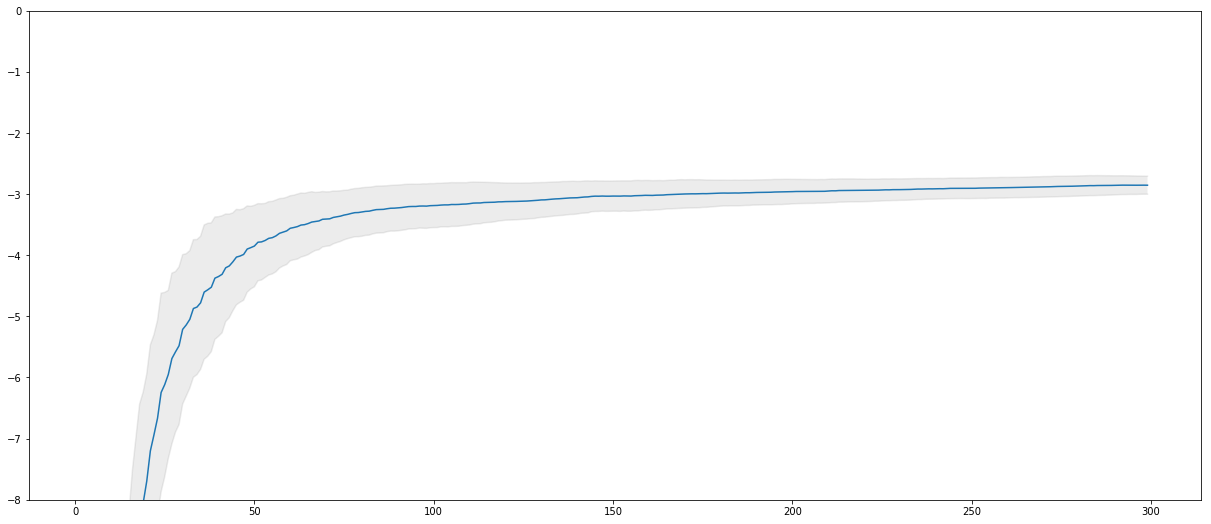

In [83]:
plt.figure(figsize=(21,9))
plt.plot(range(300),np.mean(ll_sgld,0))
plt.plot(range(n_samples),upper,'blue',alpha=0.15)
plt.plot(range(n_samples),lower,'blue', alpha=0.15)
plt.fill_between(range(n_samples),lower, upper, facecolor='blue', alpha=0.15, interpolate=True)
plt.ylim(-8,0)

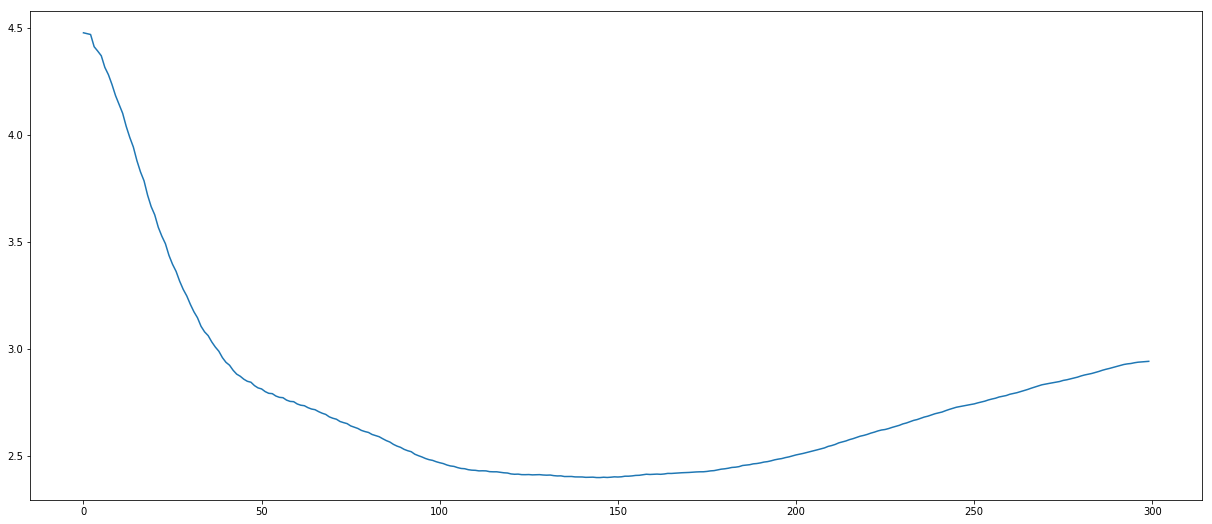

In [39]:
plt.figure(figsize=(21,9))
plt.plot(range(300),test_rmse)

## pSGLD

In [6]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr =3e-4
alpha = 0.99


batch_size = 32
dataset_size= 456

n_chains = 10
n_samples = 300





losses_psgld = []
ll_psgld = np.zeros((n_chains, n_samples))
rmse_psgld = np.zeros((n_chains, n_samples))


for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            losses_psgld.append(loss)

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, predictions = evaluate.fn(network)

                ll_psgld[i, n] = ll
                rmse_psgld[i, n] = rmse

                n += 1


            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 9.9911
chain 0 - epoch 1 - loss: 5.6848
chain 0 - epoch 2 - loss: 4.6699
chain 0 - epoch 3 - loss: 4.2129
chain 0 - epoch 4 - loss: 4.0023
chain 0 - epoch 5 - loss: 3.9280
chain 0 - epoch 6 - loss: 3.8785
chain 0 - epoch 7 - loss: 3.8423
chain 0 - epoch 8 - loss: 3.7931
chain 0 - epoch 9 - loss: 3.7418
chain 0 - epoch 10 - loss: 3.6978
chain 0 - epoch 11 - loss: 3.6818
chain 0 - epoch 12 - loss: 3.6602
chain 0 - epoch 13 - loss: 3.6236
chain 0 - epoch 14 - loss: 3.5956
chain 0 - epoch 15 - loss: 3.5680
chain 0 - epoch 16 - loss: 3.5071
chain 0 - epoch 17 - loss: 3.4716
chain 0 - epoch 18 - loss: 3.4451
chain 0 - epoch 19 - loss: 3.4177
chain 0 - epoch 20 - loss: 3.4166
chain 0 - epoch 21 - loss: 3.3963
chain 0 - epoch 22 - loss: 3.3658


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 23 - loss: 3.3212
chain 0 - epoch 24 - loss: 3.3006
chain 0 - epoch 25 - loss: 3.2838
chain 0 - epoch 26 - loss: 3.2339
chain 0 - epoch 27 - loss: 3.2249
chain 0 - epoch 28 - loss: 3.1840
chain 0 - epoch 29 - loss: 3.1745
chain 0 - epoch 30 - loss: 3.1323
chain 0 - epoch 31 - loss: 3.1015
chain 0 - epoch 32 - loss: 3.0769
chain 0 - epoch 33 - loss: 3.0718
chain 0 - epoch 34 - loss: 3.0314
chain 0 - epoch 35 - loss: 3.0364
chain 0 - epoch 36 - loss: 2.9924
chain 0 - epoch 37 - loss: 2.9357
chain 0 - epoch 38 - loss: 2.9621
chain 0 - epoch 39 - loss: 2.9293
chain 0 - epoch 40 - loss: 2.8925
chain 0 - epoch 41 - loss: 2.8838
chain 0 - epoch 42 - loss: 2.8548
chain 0 - epoch 43 - loss: 2.8160
chain 0 - epoch 44 - loss: 2.7712
chain 0 - epoch 45 - loss: 2.7314
chain 0 - epoch 46 - loss: 2.7159
chain 0 - epoch 47 - loss: 2.7112
chain 0 - epoch 48 - loss: 2.6988
chain 0 - epoch 49 - loss: 2.6369
chain 0 - epoch 50 - loss: 2.6133
chain 0 - epoch 51 - loss: 2.6192
chain 0 - epoc

chain 0 - epoch 266 - loss: 1.1120
chain 0 - epoch 267 - loss: 1.1017
chain 0 - epoch 268 - loss: 1.1236
chain 0 - epoch 269 - loss: 1.1116
chain 0 - epoch 270 - loss: 1.1053
chain 0 - epoch 271 - loss: 1.1073
chain 0 - epoch 272 - loss: 1.1230
chain 0 - epoch 273 - loss: 1.1148
chain 0 - epoch 274 - loss: 1.1227
chain 0 - epoch 275 - loss: 1.0859
chain 0 - epoch 276 - loss: 1.0945
chain 0 - epoch 277 - loss: 1.0863
chain 0 - epoch 278 - loss: 1.0993
chain 0 - epoch 279 - loss: 1.0608
chain 0 - epoch 280 - loss: 1.0460
chain 0 - epoch 281 - loss: 1.0332
chain 0 - epoch 282 - loss: 1.0651
chain 0 - epoch 283 - loss: 1.0517
chain 0 - epoch 284 - loss: 1.0353
chain 0 - epoch 285 - loss: 1.0649
chain 0 - epoch 286 - loss: 1.0790
chain 0 - epoch 287 - loss: 1.0751
chain 0 - epoch 288 - loss: 1.0705
chain 0 - epoch 289 - loss: 1.0889
chain 0 - epoch 290 - loss: 1.0861
chain 0 - epoch 291 - loss: 1.0765
chain 0 - epoch 292 - loss: 1.0829
chain 0 - epoch 293 - loss: 1.0867
chain 0 - epoch 294 

chain 0 - epoch 503 - loss: 0.8104
chain 0 - epoch 504 - loss: 0.8110
chain 0 - epoch 505 - loss: 0.8306
chain 0 - epoch 506 - loss: 0.8298
chain 0 - epoch 507 - loss: 0.8580
chain 0 - epoch 508 - loss: 0.8258
chain 0 - epoch 509 - loss: 0.8040
chain 0 - epoch 510 - loss: 0.7964
chain 0 - epoch 511 - loss: 0.8174
chain 0 - epoch 512 - loss: 0.8016
chain 0 - epoch 513 - loss: 0.7786
chain 0 - epoch 514 - loss: 0.7823
chain 0 - epoch 515 - loss: 0.8069
chain 0 - epoch 516 - loss: 0.8191
chain 0 - epoch 517 - loss: 0.7934
chain 0 - epoch 518 - loss: 0.7986
chain 0 - epoch 519 - loss: 0.7906
chain 0 - epoch 520 - loss: 0.7735
chain 0 - epoch 521 - loss: 0.7781
chain 0 - epoch 522 - loss: 0.7666
chain 0 - epoch 523 - loss: 0.7753
chain 0 - epoch 524 - loss: 0.7773
chain 0 - epoch 525 - loss: 0.8033
chain 0 - epoch 526 - loss: 0.7829
chain 0 - epoch 527 - loss: 0.7958
chain 0 - epoch 528 - loss: 0.8214
chain 0 - epoch 529 - loss: 0.8089
chain 0 - epoch 530 - loss: 0.8148
chain 0 - epoch 531 

chain 0 - epoch 740 - loss: 0.7269
chain 0 - epoch 741 - loss: 0.7462
chain 0 - epoch 742 - loss: 0.7185
chain 0 - epoch 743 - loss: 0.7140
chain 0 - epoch 744 - loss: 0.7245
chain 0 - epoch 745 - loss: 0.7434
chain 0 - epoch 746 - loss: 0.7674
chain 0 - epoch 747 - loss: 0.7530
chain 0 - epoch 748 - loss: 0.7830
chain 0 - epoch 749 - loss: 0.7702
chain 0 - epoch 750 - loss: 0.7414
chain 0 - epoch 751 - loss: 0.7277
chain 0 - epoch 752 - loss: 0.7351
chain 0 - epoch 753 - loss: 0.7408
chain 0 - epoch 754 - loss: 0.7404
chain 0 - epoch 755 - loss: 0.7308
chain 0 - epoch 756 - loss: 0.7297
chain 0 - epoch 757 - loss: 0.7292
chain 0 - epoch 758 - loss: 0.7192
chain 0 - epoch 759 - loss: 0.7173
chain 0 - epoch 760 - loss: 0.7171
chain 0 - epoch 761 - loss: 0.7259
chain 0 - epoch 762 - loss: 0.7229
chain 0 - epoch 763 - loss: 0.7117
chain 0 - epoch 764 - loss: 0.7239
chain 0 - epoch 765 - loss: 0.7143
chain 0 - epoch 766 - loss: 0.7177
chain 0 - epoch 767 - loss: 0.7355
chain 0 - epoch 768 

chain 0 - epoch 980 - loss: 0.6236
chain 0 - epoch 981 - loss: 0.6163
chain 0 - epoch 982 - loss: 0.6435
chain 0 - epoch 983 - loss: 0.6236
chain 0 - epoch 984 - loss: 0.6446
chain 0 - epoch 985 - loss: 0.6318
chain 0 - epoch 986 - loss: 0.6162
chain 0 - epoch 987 - loss: 0.6202
chain 0 - epoch 988 - loss: 0.6346
chain 0 - epoch 989 - loss: 0.6286
chain 0 - epoch 990 - loss: 0.6250
chain 0 - epoch 991 - loss: 0.6417
chain 0 - epoch 992 - loss: 0.6881
chain 0 - epoch 993 - loss: 0.6430
chain 0 - epoch 994 - loss: 0.6428
chain 0 - epoch 995 - loss: 0.6350
chain 0 - epoch 996 - loss: 0.6665
chain 0 - epoch 997 - loss: 0.6632
chain 0 - epoch 998 - loss: 0.6492
chain 0 - epoch 999 - loss: 0.6197
chain 0 - epoch 1000 - loss: 0.6388
chain 0 - epoch 1001 - loss: 0.6145
chain 0 - epoch 1002 - loss: 0.6427
chain 0 - epoch 1003 - loss: 0.6426
chain 0 - epoch 1004 - loss: 0.6384
chain 0 - epoch 1005 - loss: 0.6328
chain 0 - epoch 1006 - loss: 0.6265
chain 0 - epoch 1007 - loss: 0.6237
chain 0 - ep

chain 0 - epoch 1213 - loss: 0.6436
chain 0 - epoch 1214 - loss: 0.6070
chain 0 - epoch 1215 - loss: 0.5983
chain 0 - epoch 1216 - loss: 0.6375
chain 0 - epoch 1217 - loss: 0.6272
chain 0 - epoch 1218 - loss: 0.5981
chain 0 - epoch 1219 - loss: 0.5919
chain 0 - epoch 1220 - loss: 0.5989
chain 0 - epoch 1221 - loss: 0.6075
chain 0 - epoch 1222 - loss: 0.5986
chain 0 - epoch 1223 - loss: 0.6114
chain 0 - epoch 1224 - loss: 0.5999
chain 0 - epoch 1225 - loss: 0.6122
chain 0 - epoch 1226 - loss: 0.6205
chain 0 - epoch 1227 - loss: 0.6008
chain 0 - epoch 1228 - loss: 0.6189
chain 0 - epoch 1229 - loss: 0.5891
chain 0 - epoch 1230 - loss: 0.5687
chain 0 - epoch 1231 - loss: 0.5947
chain 0 - epoch 1232 - loss: 0.5865
chain 0 - epoch 1233 - loss: 0.5645
chain 0 - epoch 1234 - loss: 0.5980
chain 0 - epoch 1235 - loss: 0.5751
chain 0 - epoch 1236 - loss: 0.5623
chain 0 - epoch 1237 - loss: 0.5658
chain 0 - epoch 1238 - loss: 0.5796
chain 0 - epoch 1239 - loss: 0.5706
chain 0 - epoch 1240 - loss:

chain 0 - epoch 1445 - loss: 0.5766
chain 0 - epoch 1446 - loss: 0.5968
chain 0 - epoch 1447 - loss: 0.6350
chain 0 - epoch 1448 - loss: 0.6308
chain 0 - epoch 1449 - loss: 0.6264
chain 0 - epoch 1450 - loss: 0.6081
chain 0 - epoch 1451 - loss: 0.6098
chain 0 - epoch 1452 - loss: 0.6138
chain 0 - epoch 1453 - loss: 0.6269
chain 0 - epoch 1454 - loss: 0.6581
chain 0 - epoch 1455 - loss: 0.6512
chain 0 - epoch 1456 - loss: 0.5966
chain 0 - epoch 1457 - loss: 0.5807
chain 0 - epoch 1458 - loss: 0.5855
chain 0 - epoch 1459 - loss: 0.6215
chain 0 - epoch 1460 - loss: 0.6272
chain 0 - epoch 1461 - loss: 0.5971
chain 0 - epoch 1462 - loss: 0.5983
chain 0 - epoch 1463 - loss: 0.5927
chain 0 - epoch 1464 - loss: 0.5664
chain 0 - epoch 1465 - loss: 0.5844
chain 0 - epoch 1466 - loss: 0.6042
chain 0 - epoch 1467 - loss: 0.5968
chain 0 - epoch 1468 - loss: 0.6005
chain 0 - epoch 1469 - loss: 0.6189
chain 0 - epoch 1470 - loss: 0.5832
chain 0 - epoch 1471 - loss: 0.6195
chain 0 - epoch 1472 - loss:

chain 0 - epoch 1673 - loss: 0.5284
chain 0 - epoch 1674 - loss: 0.5430
chain 0 - epoch 1675 - loss: 0.5567
chain 0 - epoch 1676 - loss: 0.5441
chain 0 - epoch 1677 - loss: 0.5433
chain 0 - epoch 1678 - loss: 0.5294
chain 0 - epoch 1679 - loss: 0.5265
chain 0 - epoch 1680 - loss: 0.5393
chain 0 - epoch 1681 - loss: 0.5343
chain 0 - epoch 1682 - loss: 0.5581
chain 0 - epoch 1683 - loss: 0.5887
chain 0 - epoch 1684 - loss: 0.5323
chain 0 - epoch 1685 - loss: 0.5427
chain 0 - epoch 1686 - loss: 0.5227
chain 0 - epoch 1687 - loss: 0.5518
chain 0 - epoch 1688 - loss: 0.5412
chain 0 - epoch 1689 - loss: 0.5535
chain 0 - epoch 1690 - loss: 0.5390
chain 0 - epoch 1691 - loss: 0.5670
chain 0 - epoch 1692 - loss: 0.5714
chain 0 - epoch 1693 - loss: 0.5676
chain 0 - epoch 1694 - loss: 0.5560
chain 0 - epoch 1695 - loss: 0.6112
chain 0 - epoch 1696 - loss: 0.5986
chain 0 - epoch 1697 - loss: 0.6152
chain 0 - epoch 1698 - loss: 0.6189
chain 0 - epoch 1699 - loss: 0.5768
chain 0 - epoch 1700 - loss:

chain 0 - epoch 1901 - loss: 0.5714
chain 0 - epoch 1902 - loss: 0.5785
chain 0 - epoch 1903 - loss: 0.5681
chain 0 - epoch 1904 - loss: 0.5775
chain 0 - epoch 1905 - loss: 0.5481
chain 0 - epoch 1906 - loss: 0.5369
chain 0 - epoch 1907 - loss: 0.5614
chain 0 - epoch 1908 - loss: 0.5801
chain 0 - epoch 1909 - loss: 0.5652
chain 0 - epoch 1910 - loss: 0.5873
chain 0 - epoch 1911 - loss: 0.5628
chain 0 - epoch 1912 - loss: 0.5619
chain 0 - epoch 1913 - loss: 0.5572
chain 0 - epoch 1914 - loss: 0.5927
chain 0 - epoch 1915 - loss: 0.5906
chain 0 - epoch 1916 - loss: 0.6063
chain 0 - epoch 1917 - loss: 0.6123
chain 0 - epoch 1918 - loss: 0.6124
chain 0 - epoch 1919 - loss: 0.6269
chain 0 - epoch 1920 - loss: 0.5964
chain 0 - epoch 1921 - loss: 0.5938
chain 0 - epoch 1922 - loss: 0.5564
chain 0 - epoch 1923 - loss: 0.5595
chain 0 - epoch 1924 - loss: 0.5950
chain 0 - epoch 1925 - loss: 0.5678
chain 0 - epoch 1926 - loss: 0.5842
chain 0 - epoch 1927 - loss: 0.5837
chain 0 - epoch 1928 - loss:

chain 0 - epoch 2137 - loss: 0.5785
chain 0 - epoch 2138 - loss: 0.5472
chain 0 - epoch 2139 - loss: 0.5501
chain 0 - epoch 2140 - loss: 0.5469
chain 0 - epoch 2141 - loss: 0.5501
chain 0 - epoch 2142 - loss: 0.5486
chain 0 - epoch 2143 - loss: 0.5444
chain 0 - epoch 2144 - loss: 0.5534
chain 0 - epoch 2145 - loss: 0.5798
chain 0 - epoch 2146 - loss: 0.5454
chain 0 - epoch 2147 - loss: 0.5411
chain 0 - epoch 2148 - loss: 0.5163
chain 0 - epoch 2149 - loss: 0.5607
chain 0 - epoch 2150 - loss: 0.5392
chain 0 - epoch 2151 - loss: 0.5454
chain 0 - epoch 2152 - loss: 0.5353
chain 0 - epoch 2153 - loss: 0.5271
chain 0 - epoch 2154 - loss: 0.5349
chain 0 - epoch 2155 - loss: 0.5276
chain 0 - epoch 2156 - loss: 0.4967
chain 0 - epoch 2157 - loss: 0.5099
chain 0 - epoch 2158 - loss: 0.5319
chain 0 - epoch 2159 - loss: 0.5332
chain 0 - epoch 2160 - loss: 0.5004
chain 0 - epoch 2161 - loss: 0.5381
chain 0 - epoch 2162 - loss: 0.4895
chain 0 - epoch 2163 - loss: 0.5146
chain 0 - epoch 2164 - loss:

chain 0 - epoch 2369 - loss: 0.5627
chain 0 - epoch 2370 - loss: 0.5795
chain 0 - epoch 2371 - loss: 0.5389
chain 0 - epoch 2372 - loss: 0.5715
chain 0 - epoch 2373 - loss: 0.5401
chain 0 - epoch 2374 - loss: 0.5330
chain 0 - epoch 2375 - loss: 0.5384
chain 0 - epoch 2376 - loss: 0.5346
chain 0 - epoch 2377 - loss: 0.5425
chain 0 - epoch 2378 - loss: 0.5777
chain 0 - epoch 2379 - loss: 0.5885
chain 0 - epoch 2380 - loss: 0.5949
chain 0 - epoch 2381 - loss: 0.5870
chain 0 - epoch 2382 - loss: 0.6069
chain 0 - epoch 2383 - loss: 0.5683
chain 0 - epoch 2384 - loss: 0.5740
chain 0 - epoch 2385 - loss: 0.5628
chain 0 - epoch 2386 - loss: 0.5640
chain 0 - epoch 2387 - loss: 0.5514
chain 0 - epoch 2388 - loss: 0.5736
chain 0 - epoch 2389 - loss: 0.5499
chain 0 - epoch 2390 - loss: 0.5578
chain 0 - epoch 2391 - loss: 0.5745
chain 0 - epoch 2392 - loss: 0.6118
chain 0 - epoch 2393 - loss: 0.5928
chain 0 - epoch 2394 - loss: 0.5797
chain 0 - epoch 2395 - loss: 0.5697
chain 0 - epoch 2396 - loss:

chain 1 - epoch 110 - loss: 1.6347
chain 1 - epoch 111 - loss: 1.6431
chain 1 - epoch 112 - loss: 1.6141
chain 1 - epoch 113 - loss: 1.6160
chain 1 - epoch 114 - loss: 1.6103
chain 1 - epoch 115 - loss: 1.6269
chain 1 - epoch 116 - loss: 1.6184
chain 1 - epoch 117 - loss: 1.6245
chain 1 - epoch 118 - loss: 1.6279
chain 1 - epoch 119 - loss: 1.6219
chain 1 - epoch 120 - loss: 1.6300
chain 1 - epoch 121 - loss: 1.5833
chain 1 - epoch 122 - loss: 1.5772
chain 1 - epoch 123 - loss: 1.5444
chain 1 - epoch 124 - loss: 1.5377
chain 1 - epoch 125 - loss: 1.5289
chain 1 - epoch 126 - loss: 1.5354
chain 1 - epoch 127 - loss: 1.5269
chain 1 - epoch 128 - loss: 1.5425
chain 1 - epoch 129 - loss: 1.5199
chain 1 - epoch 130 - loss: 1.4962
chain 1 - epoch 131 - loss: 1.4815
chain 1 - epoch 132 - loss: 1.4682
chain 1 - epoch 133 - loss: 1.4728
chain 1 - epoch 134 - loss: 1.4618
chain 1 - epoch 135 - loss: 1.4521
chain 1 - epoch 136 - loss: 1.4420
chain 1 - epoch 137 - loss: 1.4624
chain 1 - epoch 138 

chain 1 - epoch 349 - loss: 1.0152
chain 1 - epoch 350 - loss: 1.0003
chain 1 - epoch 351 - loss: 0.9888
chain 1 - epoch 352 - loss: 1.0247
chain 1 - epoch 353 - loss: 0.9836
chain 1 - epoch 354 - loss: 1.0025
chain 1 - epoch 355 - loss: 0.9791
chain 1 - epoch 356 - loss: 1.0128
chain 1 - epoch 357 - loss: 0.9737
chain 1 - epoch 358 - loss: 0.9471
chain 1 - epoch 359 - loss: 0.9754
chain 1 - epoch 360 - loss: 0.9537
chain 1 - epoch 361 - loss: 0.9582
chain 1 - epoch 362 - loss: 0.9507
chain 1 - epoch 363 - loss: 0.9679
chain 1 - epoch 364 - loss: 0.9592
chain 1 - epoch 365 - loss: 0.9775
chain 1 - epoch 366 - loss: 0.9734
chain 1 - epoch 367 - loss: 0.9578
chain 1 - epoch 368 - loss: 0.9595
chain 1 - epoch 369 - loss: 0.9563
chain 1 - epoch 370 - loss: 0.9587
chain 1 - epoch 371 - loss: 0.9677
chain 1 - epoch 372 - loss: 0.9617
chain 1 - epoch 373 - loss: 0.9580
chain 1 - epoch 374 - loss: 0.9897
chain 1 - epoch 375 - loss: 0.9843
chain 1 - epoch 376 - loss: 0.9843
chain 1 - epoch 377 

chain 1 - epoch 586 - loss: 0.7477
chain 1 - epoch 587 - loss: 0.7628
chain 1 - epoch 588 - loss: 0.7695
chain 1 - epoch 589 - loss: 0.7673
chain 1 - epoch 590 - loss: 0.7876
chain 1 - epoch 591 - loss: 0.7871
chain 1 - epoch 592 - loss: 0.7916
chain 1 - epoch 593 - loss: 0.8025
chain 1 - epoch 594 - loss: 0.7965
chain 1 - epoch 595 - loss: 0.8043
chain 1 - epoch 596 - loss: 0.7744
chain 1 - epoch 597 - loss: 0.7602
chain 1 - epoch 598 - loss: 0.7634
chain 1 - epoch 599 - loss: 0.7677
chain 1 - epoch 600 - loss: 0.7612
chain 1 - epoch 601 - loss: 0.7575
chain 1 - epoch 602 - loss: 0.7452
chain 1 - epoch 603 - loss: 0.7450
chain 1 - epoch 604 - loss: 0.7751
chain 1 - epoch 605 - loss: 0.7645
chain 1 - epoch 606 - loss: 0.7858
chain 1 - epoch 607 - loss: 0.7789
chain 1 - epoch 608 - loss: 0.7628
chain 1 - epoch 609 - loss: 0.7325
chain 1 - epoch 610 - loss: 0.7391
chain 1 - epoch 611 - loss: 0.7477
chain 1 - epoch 612 - loss: 0.7438
chain 1 - epoch 613 - loss: 0.7287
chain 1 - epoch 614 

chain 1 - epoch 825 - loss: 0.6314
chain 1 - epoch 826 - loss: 0.6277
chain 1 - epoch 827 - loss: 0.6343
chain 1 - epoch 828 - loss: 0.6569
chain 1 - epoch 829 - loss: 0.6423
chain 1 - epoch 830 - loss: 0.6255
chain 1 - epoch 831 - loss: 0.6260
chain 1 - epoch 832 - loss: 0.5946
chain 1 - epoch 833 - loss: 0.6068
chain 1 - epoch 834 - loss: 0.6291
chain 1 - epoch 835 - loss: 0.6183
chain 1 - epoch 836 - loss: 0.5935
chain 1 - epoch 837 - loss: 0.6198
chain 1 - epoch 838 - loss: 0.6160
chain 1 - epoch 839 - loss: 0.5941
chain 1 - epoch 840 - loss: 0.5819
chain 1 - epoch 841 - loss: 0.5877
chain 1 - epoch 842 - loss: 0.5998
chain 1 - epoch 843 - loss: 0.5843
chain 1 - epoch 844 - loss: 0.6095
chain 1 - epoch 845 - loss: 0.6269
chain 1 - epoch 846 - loss: 0.6247
chain 1 - epoch 847 - loss: 0.5957
chain 1 - epoch 848 - loss: 0.6452
chain 1 - epoch 849 - loss: 0.6430
chain 1 - epoch 850 - loss: 0.6455
chain 1 - epoch 851 - loss: 0.6421
chain 1 - epoch 852 - loss: 0.6360
chain 1 - epoch 853 

chain 1 - epoch 1065 - loss: 0.5776
chain 1 - epoch 1066 - loss: 0.5812
chain 1 - epoch 1067 - loss: 0.5820
chain 1 - epoch 1068 - loss: 0.5623
chain 1 - epoch 1069 - loss: 0.5752
chain 1 - epoch 1070 - loss: 0.5768
chain 1 - epoch 1071 - loss: 0.5828
chain 1 - epoch 1072 - loss: 0.6117
chain 1 - epoch 1073 - loss: 0.5999
chain 1 - epoch 1074 - loss: 0.5964
chain 1 - epoch 1075 - loss: 0.6078
chain 1 - epoch 1076 - loss: 0.5787
chain 1 - epoch 1077 - loss: 0.5931
chain 1 - epoch 1078 - loss: 0.6209
chain 1 - epoch 1079 - loss: 0.6080
chain 1 - epoch 1080 - loss: 0.5969
chain 1 - epoch 1081 - loss: 0.5809
chain 1 - epoch 1082 - loss: 0.5711
chain 1 - epoch 1083 - loss: 0.5645
chain 1 - epoch 1084 - loss: 0.5516
chain 1 - epoch 1085 - loss: 0.5612
chain 1 - epoch 1086 - loss: 0.5653
chain 1 - epoch 1087 - loss: 0.5763
chain 1 - epoch 1088 - loss: 0.5666
chain 1 - epoch 1089 - loss: 0.5659
chain 1 - epoch 1090 - loss: 0.5794
chain 1 - epoch 1091 - loss: 0.5828
chain 1 - epoch 1092 - loss:

chain 1 - epoch 1296 - loss: 0.6248
chain 1 - epoch 1297 - loss: 0.5988
chain 1 - epoch 1298 - loss: 0.5790
chain 1 - epoch 1299 - loss: 0.5707
chain 1 - epoch 1300 - loss: 0.5504
chain 1 - epoch 1301 - loss: 0.5950
chain 1 - epoch 1302 - loss: 0.5871
chain 1 - epoch 1303 - loss: 0.5410
chain 1 - epoch 1304 - loss: 0.5532
chain 1 - epoch 1305 - loss: 0.5793
chain 1 - epoch 1306 - loss: 0.5885
chain 1 - epoch 1307 - loss: 0.5715
chain 1 - epoch 1308 - loss: 0.5946
chain 1 - epoch 1309 - loss: 0.5605
chain 1 - epoch 1310 - loss: 0.5984
chain 1 - epoch 1311 - loss: 0.5606
chain 1 - epoch 1312 - loss: 0.5663
chain 1 - epoch 1313 - loss: 0.5742
chain 1 - epoch 1314 - loss: 0.6040
chain 1 - epoch 1315 - loss: 0.5599
chain 1 - epoch 1316 - loss: 0.5730
chain 1 - epoch 1317 - loss: 0.5623
chain 1 - epoch 1318 - loss: 0.5555
chain 1 - epoch 1319 - loss: 0.5589
chain 1 - epoch 1320 - loss: 0.5624
chain 1 - epoch 1321 - loss: 0.5861
chain 1 - epoch 1322 - loss: 0.5675
chain 1 - epoch 1323 - loss:

chain 1 - epoch 1531 - loss: 0.5348
chain 1 - epoch 1532 - loss: 0.5140
chain 1 - epoch 1533 - loss: 0.4977
chain 1 - epoch 1534 - loss: 0.4856
chain 1 - epoch 1535 - loss: 0.5096
chain 1 - epoch 1536 - loss: 0.5088
chain 1 - epoch 1537 - loss: 0.5273
chain 1 - epoch 1538 - loss: 0.4850
chain 1 - epoch 1539 - loss: 0.5155
chain 1 - epoch 1540 - loss: 0.5106
chain 1 - epoch 1541 - loss: 0.5032
chain 1 - epoch 1542 - loss: 0.4968
chain 1 - epoch 1543 - loss: 0.5204
chain 1 - epoch 1544 - loss: 0.5516
chain 1 - epoch 1545 - loss: 0.4949
chain 1 - epoch 1546 - loss: 0.5114
chain 1 - epoch 1547 - loss: 0.5024
chain 1 - epoch 1548 - loss: 0.5094
chain 1 - epoch 1549 - loss: 0.5443
chain 1 - epoch 1550 - loss: 0.5217
chain 1 - epoch 1551 - loss: 0.5338
chain 1 - epoch 1552 - loss: 0.5276
chain 1 - epoch 1553 - loss: 0.5166
chain 1 - epoch 1554 - loss: 0.4761
chain 1 - epoch 1555 - loss: 0.4865
chain 1 - epoch 1556 - loss: 0.4872
chain 1 - epoch 1557 - loss: 0.4907
chain 1 - epoch 1558 - loss:

chain 1 - epoch 1763 - loss: 0.5437
chain 1 - epoch 1764 - loss: 0.5287
chain 1 - epoch 1765 - loss: 0.5625
chain 1 - epoch 1766 - loss: 0.5436
chain 1 - epoch 1767 - loss: 0.5707
chain 1 - epoch 1768 - loss: 0.5567
chain 1 - epoch 1769 - loss: 0.5865
chain 1 - epoch 1770 - loss: 0.5715
chain 1 - epoch 1771 - loss: 0.5426
chain 1 - epoch 1772 - loss: 0.5758
chain 1 - epoch 1773 - loss: 0.5733
chain 1 - epoch 1774 - loss: 0.5597
chain 1 - epoch 1775 - loss: 0.5616
chain 1 - epoch 1776 - loss: 0.5705
chain 1 - epoch 1777 - loss: 0.5746
chain 1 - epoch 1778 - loss: 0.5658
chain 1 - epoch 1779 - loss: 0.5696
chain 1 - epoch 1780 - loss: 0.5796
chain 1 - epoch 1781 - loss: 0.5693
chain 1 - epoch 1782 - loss: 0.5517
chain 1 - epoch 1783 - loss: 0.5663
chain 1 - epoch 1784 - loss: 0.5547
chain 1 - epoch 1785 - loss: 0.5473
chain 1 - epoch 1786 - loss: 0.5377
chain 1 - epoch 1787 - loss: 0.5452
chain 1 - epoch 1788 - loss: 0.5697
chain 1 - epoch 1789 - loss: 0.5643
chain 1 - epoch 1790 - loss:

chain 1 - epoch 1995 - loss: 0.5003
chain 1 - epoch 1996 - loss: 0.5410
chain 1 - epoch 1997 - loss: 0.5204
chain 1 - epoch 1998 - loss: 0.5166
chain 1 - epoch 1999 - loss: 0.5263
chain 1 - epoch 2000 - loss: 0.5204
chain 1 - epoch 2001 - loss: 0.5499
chain 1 - epoch 2002 - loss: 0.5388
chain 1 - epoch 2003 - loss: 0.5359
chain 1 - epoch 2004 - loss: 0.5421
chain 1 - epoch 2005 - loss: 0.5174
chain 1 - epoch 2006 - loss: 0.5117
chain 1 - epoch 2007 - loss: 0.5128
chain 1 - epoch 2008 - loss: 0.4911
chain 1 - epoch 2009 - loss: 0.5341
chain 1 - epoch 2010 - loss: 0.5019
chain 1 - epoch 2011 - loss: 0.5381
chain 1 - epoch 2012 - loss: 0.5439
chain 1 - epoch 2013 - loss: 0.5259
chain 1 - epoch 2014 - loss: 0.5099
chain 1 - epoch 2015 - loss: 0.5512
chain 1 - epoch 2016 - loss: 0.5302
chain 1 - epoch 2017 - loss: 0.5174
chain 1 - epoch 2018 - loss: 0.5169
chain 1 - epoch 2019 - loss: 0.5359
chain 1 - epoch 2020 - loss: 0.5190
chain 1 - epoch 2021 - loss: 0.5353
chain 1 - epoch 2022 - loss:

chain 1 - epoch 2232 - loss: 0.5287
chain 1 - epoch 2233 - loss: 0.5503
chain 1 - epoch 2234 - loss: 0.5644
chain 1 - epoch 2235 - loss: 0.5413
chain 1 - epoch 2236 - loss: 0.5601
chain 1 - epoch 2237 - loss: 0.5214
chain 1 - epoch 2238 - loss: 0.5239
chain 1 - epoch 2239 - loss: 0.5181
chain 1 - epoch 2240 - loss: 0.5384
chain 1 - epoch 2241 - loss: 0.5151
chain 1 - epoch 2242 - loss: 0.5039
chain 1 - epoch 2243 - loss: 0.5046
chain 1 - epoch 2244 - loss: 0.4920
chain 1 - epoch 2245 - loss: 0.4900
chain 1 - epoch 2246 - loss: 0.4948
chain 1 - epoch 2247 - loss: 0.4997
chain 1 - epoch 2248 - loss: 0.5107
chain 1 - epoch 2249 - loss: 0.4739
chain 1 - epoch 2250 - loss: 0.4994
chain 1 - epoch 2251 - loss: 0.5375
chain 1 - epoch 2252 - loss: 0.5195
chain 1 - epoch 2253 - loss: 0.4975
chain 1 - epoch 2254 - loss: 0.5078
chain 1 - epoch 2255 - loss: 0.5154
chain 1 - epoch 2256 - loss: 0.5163
chain 1 - epoch 2257 - loss: 0.5009
chain 1 - epoch 2258 - loss: 0.4898
chain 1 - epoch 2259 - loss:

chain 1 - epoch 2466 - loss: 0.5274
chain 1 - epoch 2467 - loss: 0.5037
chain 1 - epoch 2468 - loss: 0.5234
chain 1 - epoch 2469 - loss: 0.5183
chain 1 - epoch 2470 - loss: 0.5507
chain 1 - epoch 2471 - loss: 0.5495
chain 1 - epoch 2472 - loss: 0.5436
chain 1 - epoch 2473 - loss: 0.5203
chain 1 - epoch 2474 - loss: 0.5322
chain 1 - epoch 2475 - loss: 0.5378
chain 1 - epoch 2476 - loss: 0.5503
chain 1 - epoch 2477 - loss: 0.5386
chain 1 - epoch 2478 - loss: 0.5160
chain 1 - epoch 2479 - loss: 0.5526
chain 1 - epoch 2480 - loss: 0.5242
chain 1 - epoch 2481 - loss: 0.5285
chain 1 - epoch 2482 - loss: 0.5439
chain 1 - epoch 2483 - loss: 0.5751
chain 1 - epoch 2484 - loss: 0.5497
chain 1 - epoch 2485 - loss: 0.5325
chain 1 - epoch 2486 - loss: 0.5335
chain 1 - epoch 2487 - loss: 0.5399
chain 1 - epoch 2488 - loss: 0.5437
chain 1 - epoch 2489 - loss: 0.5626
chain 1 - epoch 2490 - loss: 0.5402
chain 1 - epoch 2491 - loss: 0.5380
chain 1 - epoch 2492 - loss: 0.5369
chain 1 - epoch 2493 - loss:

chain 2 - epoch 203 - loss: 1.1711
chain 2 - epoch 204 - loss: 1.1610
chain 2 - epoch 205 - loss: 1.1760
chain 2 - epoch 206 - loss: 1.1754
chain 2 - epoch 207 - loss: 1.1855
chain 2 - epoch 208 - loss: 1.1413
chain 2 - epoch 209 - loss: 1.1661
chain 2 - epoch 210 - loss: 1.1572
chain 2 - epoch 211 - loss: 1.1634
chain 2 - epoch 212 - loss: 1.1716
chain 2 - epoch 213 - loss: 1.1505
chain 2 - epoch 214 - loss: 1.1617
chain 2 - epoch 215 - loss: 1.1374
chain 2 - epoch 216 - loss: 1.1243
chain 2 - epoch 217 - loss: 1.1250
chain 2 - epoch 218 - loss: 1.1322
chain 2 - epoch 219 - loss: 1.1454
chain 2 - epoch 220 - loss: 1.1356
chain 2 - epoch 221 - loss: 1.1158
chain 2 - epoch 222 - loss: 1.0961
chain 2 - epoch 223 - loss: 1.1083
chain 2 - epoch 224 - loss: 1.1008
chain 2 - epoch 225 - loss: 1.0908
chain 2 - epoch 226 - loss: 1.1016
chain 2 - epoch 227 - loss: 1.1030
chain 2 - epoch 228 - loss: 1.1052
chain 2 - epoch 229 - loss: 1.1249
chain 2 - epoch 230 - loss: 1.1096
chain 2 - epoch 231 

chain 2 - epoch 445 - loss: 0.8248
chain 2 - epoch 446 - loss: 0.8512
chain 2 - epoch 447 - loss: 0.8339
chain 2 - epoch 448 - loss: 0.8559
chain 2 - epoch 449 - loss: 0.8640
chain 2 - epoch 450 - loss: 0.8698
chain 2 - epoch 451 - loss: 0.8610
chain 2 - epoch 452 - loss: 0.8546
chain 2 - epoch 453 - loss: 0.8478
chain 2 - epoch 454 - loss: 0.8535
chain 2 - epoch 455 - loss: 0.8280
chain 2 - epoch 456 - loss: 0.8688
chain 2 - epoch 457 - loss: 0.8518
chain 2 - epoch 458 - loss: 0.8553
chain 2 - epoch 459 - loss: 0.8488
chain 2 - epoch 460 - loss: 0.8467
chain 2 - epoch 461 - loss: 0.8474
chain 2 - epoch 462 - loss: 0.8412
chain 2 - epoch 463 - loss: 0.8367
chain 2 - epoch 464 - loss: 0.8714
chain 2 - epoch 465 - loss: 0.8694
chain 2 - epoch 466 - loss: 0.8597
chain 2 - epoch 467 - loss: 0.8642
chain 2 - epoch 468 - loss: 0.8552
chain 2 - epoch 469 - loss: 0.8636
chain 2 - epoch 470 - loss: 0.8352
chain 2 - epoch 471 - loss: 0.8295
chain 2 - epoch 472 - loss: 0.8364
chain 2 - epoch 473 

chain 2 - epoch 685 - loss: 0.7259
chain 2 - epoch 686 - loss: 0.6855
chain 2 - epoch 687 - loss: 0.7005
chain 2 - epoch 688 - loss: 0.7157
chain 2 - epoch 689 - loss: 0.7114
chain 2 - epoch 690 - loss: 0.7058
chain 2 - epoch 691 - loss: 0.7159
chain 2 - epoch 692 - loss: 0.7378
chain 2 - epoch 693 - loss: 0.7413
chain 2 - epoch 694 - loss: 0.7485
chain 2 - epoch 695 - loss: 0.7326
chain 2 - epoch 696 - loss: 0.7535
chain 2 - epoch 697 - loss: 0.7328
chain 2 - epoch 698 - loss: 0.7602
chain 2 - epoch 699 - loss: 0.7249
chain 2 - epoch 700 - loss: 0.7277
chain 2 - epoch 701 - loss: 0.7019
chain 2 - epoch 702 - loss: 0.7182
chain 2 - epoch 703 - loss: 0.7136
chain 2 - epoch 704 - loss: 0.7089
chain 2 - epoch 705 - loss: 0.6979
chain 2 - epoch 706 - loss: 0.7037
chain 2 - epoch 707 - loss: 0.7163
chain 2 - epoch 708 - loss: 0.7214
chain 2 - epoch 709 - loss: 0.7164
chain 2 - epoch 710 - loss: 0.6975
chain 2 - epoch 711 - loss: 0.6979
chain 2 - epoch 712 - loss: 0.6984
chain 2 - epoch 713 

chain 2 - epoch 923 - loss: 0.6431
chain 2 - epoch 924 - loss: 0.6701
chain 2 - epoch 925 - loss: 0.6627
chain 2 - epoch 926 - loss: 0.6498
chain 2 - epoch 927 - loss: 0.6734
chain 2 - epoch 928 - loss: 0.6869
chain 2 - epoch 929 - loss: 0.6606
chain 2 - epoch 930 - loss: 0.6718
chain 2 - epoch 931 - loss: 0.6689
chain 2 - epoch 932 - loss: 0.6601
chain 2 - epoch 933 - loss: 0.6558
chain 2 - epoch 934 - loss: 0.6631
chain 2 - epoch 935 - loss: 0.6467
chain 2 - epoch 936 - loss: 0.6456
chain 2 - epoch 937 - loss: 0.6169
chain 2 - epoch 938 - loss: 0.6650
chain 2 - epoch 939 - loss: 0.6746
chain 2 - epoch 940 - loss: 0.6669
chain 2 - epoch 941 - loss: 0.6843
chain 2 - epoch 942 - loss: 0.6637
chain 2 - epoch 943 - loss: 0.6712
chain 2 - epoch 944 - loss: 0.6971
chain 2 - epoch 945 - loss: 0.7011
chain 2 - epoch 946 - loss: 0.7117
chain 2 - epoch 947 - loss: 0.6987
chain 2 - epoch 948 - loss: 0.6836
chain 2 - epoch 949 - loss: 0.6967
chain 2 - epoch 950 - loss: 0.7021
chain 2 - epoch 951 

chain 2 - epoch 1155 - loss: 0.5983
chain 2 - epoch 1156 - loss: 0.6033
chain 2 - epoch 1157 - loss: 0.5983
chain 2 - epoch 1158 - loss: 0.6165
chain 2 - epoch 1159 - loss: 0.6317
chain 2 - epoch 1160 - loss: 0.6195
chain 2 - epoch 1161 - loss: 0.6321
chain 2 - epoch 1162 - loss: 0.6337
chain 2 - epoch 1163 - loss: 0.6212
chain 2 - epoch 1164 - loss: 0.6461
chain 2 - epoch 1165 - loss: 0.6611
chain 2 - epoch 1166 - loss: 0.6700
chain 2 - epoch 1167 - loss: 0.6605
chain 2 - epoch 1168 - loss: 0.6689
chain 2 - epoch 1169 - loss: 0.6517
chain 2 - epoch 1170 - loss: 0.6472
chain 2 - epoch 1171 - loss: 0.6208
chain 2 - epoch 1172 - loss: 0.6268
chain 2 - epoch 1173 - loss: 0.6270
chain 2 - epoch 1174 - loss: 0.6177
chain 2 - epoch 1175 - loss: 0.6067
chain 2 - epoch 1176 - loss: 0.6281
chain 2 - epoch 1177 - loss: 0.6442
chain 2 - epoch 1178 - loss: 0.6085
chain 2 - epoch 1179 - loss: 0.5771
chain 2 - epoch 1180 - loss: 0.6065
chain 2 - epoch 1181 - loss: 0.5709
chain 2 - epoch 1182 - loss:

chain 2 - epoch 1384 - loss: 0.5416
chain 2 - epoch 1385 - loss: 0.5388
chain 2 - epoch 1386 - loss: 0.5342
chain 2 - epoch 1387 - loss: 0.5559
chain 2 - epoch 1388 - loss: 0.5567
chain 2 - epoch 1389 - loss: 0.5633
chain 2 - epoch 1390 - loss: 0.5697
chain 2 - epoch 1391 - loss: 0.5542
chain 2 - epoch 1392 - loss: 0.5433
chain 2 - epoch 1393 - loss: 0.5785
chain 2 - epoch 1394 - loss: 0.6061
chain 2 - epoch 1395 - loss: 0.5710
chain 2 - epoch 1396 - loss: 0.5845
chain 2 - epoch 1397 - loss: 0.5765
chain 2 - epoch 1398 - loss: 0.5981
chain 2 - epoch 1399 - loss: 0.5588
chain 2 - epoch 1400 - loss: 0.5378
chain 2 - epoch 1401 - loss: 0.5730
chain 2 - epoch 1402 - loss: 0.5738
chain 2 - epoch 1403 - loss: 0.5418
chain 2 - epoch 1404 - loss: 0.5588
chain 2 - epoch 1405 - loss: 0.5591
chain 2 - epoch 1406 - loss: 0.5677
chain 2 - epoch 1407 - loss: 0.5642
chain 2 - epoch 1408 - loss: 0.5718
chain 2 - epoch 1409 - loss: 0.5556
chain 2 - epoch 1410 - loss: 0.5472
chain 2 - epoch 1411 - loss:

chain 2 - epoch 1614 - loss: 0.5945
chain 2 - epoch 1615 - loss: 0.5615
chain 2 - epoch 1616 - loss: 0.5563
chain 2 - epoch 1617 - loss: 0.5810
chain 2 - epoch 1618 - loss: 0.5816
chain 2 - epoch 1619 - loss: 0.5697
chain 2 - epoch 1620 - loss: 0.5684
chain 2 - epoch 1621 - loss: 0.5761
chain 2 - epoch 1622 - loss: 0.5816
chain 2 - epoch 1623 - loss: 0.5819
chain 2 - epoch 1624 - loss: 0.5862
chain 2 - epoch 1625 - loss: 0.5754
chain 2 - epoch 1626 - loss: 0.5689
chain 2 - epoch 1627 - loss: 0.5385
chain 2 - epoch 1628 - loss: 0.5530
chain 2 - epoch 1629 - loss: 0.5528
chain 2 - epoch 1630 - loss: 0.5608
chain 2 - epoch 1631 - loss: 0.5598
chain 2 - epoch 1632 - loss: 0.5768
chain 2 - epoch 1633 - loss: 0.5991
chain 2 - epoch 1634 - loss: 0.5907
chain 2 - epoch 1635 - loss: 0.5750
chain 2 - epoch 1636 - loss: 0.6028
chain 2 - epoch 1637 - loss: 0.5685
chain 2 - epoch 1638 - loss: 0.5385
chain 2 - epoch 1639 - loss: 0.5566
chain 2 - epoch 1640 - loss: 0.5500
chain 2 - epoch 1641 - loss:

chain 2 - epoch 1843 - loss: 0.5374
chain 2 - epoch 1844 - loss: 0.5293
chain 2 - epoch 1845 - loss: 0.5250
chain 2 - epoch 1846 - loss: 0.4709
chain 2 - epoch 1847 - loss: 0.4962
chain 2 - epoch 1848 - loss: 0.5039
chain 2 - epoch 1849 - loss: 0.5017
chain 2 - epoch 1850 - loss: 0.5000
chain 2 - epoch 1851 - loss: 0.5187
chain 2 - epoch 1852 - loss: 0.5072
chain 2 - epoch 1853 - loss: 0.5200
chain 2 - epoch 1854 - loss: 0.5074
chain 2 - epoch 1855 - loss: 0.5520
chain 2 - epoch 1856 - loss: 0.5324
chain 2 - epoch 1857 - loss: 0.5454
chain 2 - epoch 1858 - loss: 0.5523
chain 2 - epoch 1859 - loss: 0.5241
chain 2 - epoch 1860 - loss: 0.5278
chain 2 - epoch 1861 - loss: 0.5083
chain 2 - epoch 1862 - loss: 0.5411
chain 2 - epoch 1863 - loss: 0.5211
chain 2 - epoch 1864 - loss: 0.5066
chain 2 - epoch 1865 - loss: 0.5207
chain 2 - epoch 1866 - loss: 0.5068
chain 2 - epoch 1867 - loss: 0.5096
chain 2 - epoch 1868 - loss: 0.4963
chain 2 - epoch 1869 - loss: 0.5065
chain 2 - epoch 1870 - loss:

chain 2 - epoch 2072 - loss: 0.5300
chain 2 - epoch 2073 - loss: 0.5449
chain 2 - epoch 2074 - loss: 0.5315
chain 2 - epoch 2075 - loss: 0.5569
chain 2 - epoch 2076 - loss: 0.5406
chain 2 - epoch 2077 - loss: 0.5398
chain 2 - epoch 2078 - loss: 0.5620
chain 2 - epoch 2079 - loss: 0.5576
chain 2 - epoch 2080 - loss: 0.5827
chain 2 - epoch 2081 - loss: 0.5772
chain 2 - epoch 2082 - loss: 0.5658
chain 2 - epoch 2083 - loss: 0.5420
chain 2 - epoch 2084 - loss: 0.5093
chain 2 - epoch 2085 - loss: 0.5620
chain 2 - epoch 2086 - loss: 0.5796
chain 2 - epoch 2087 - loss: 0.5614
chain 2 - epoch 2088 - loss: 0.5595
chain 2 - epoch 2089 - loss: 0.5668
chain 2 - epoch 2090 - loss: 0.5545
chain 2 - epoch 2091 - loss: 0.5486
chain 2 - epoch 2092 - loss: 0.5427
chain 2 - epoch 2093 - loss: 0.5434
chain 2 - epoch 2094 - loss: 0.5452
chain 2 - epoch 2095 - loss: 0.5574
chain 2 - epoch 2096 - loss: 0.5860
chain 2 - epoch 2097 - loss: 0.5934
chain 2 - epoch 2098 - loss: 0.5834
chain 2 - epoch 2099 - loss:

chain 2 - epoch 2306 - loss: 0.5796
chain 2 - epoch 2307 - loss: 0.5660
chain 2 - epoch 2308 - loss: 0.5671
chain 2 - epoch 2309 - loss: 0.5459
chain 2 - epoch 2310 - loss: 0.5386
chain 2 - epoch 2311 - loss: 0.5551
chain 2 - epoch 2312 - loss: 0.5394
chain 2 - epoch 2313 - loss: 0.5307
chain 2 - epoch 2314 - loss: 0.5572
chain 2 - epoch 2315 - loss: 0.5632
chain 2 - epoch 2316 - loss: 0.5560
chain 2 - epoch 2317 - loss: 0.5694
chain 2 - epoch 2318 - loss: 0.5757
chain 2 - epoch 2319 - loss: 0.5536
chain 2 - epoch 2320 - loss: 0.5711
chain 2 - epoch 2321 - loss: 0.5976
chain 2 - epoch 2322 - loss: 0.5873
chain 2 - epoch 2323 - loss: 0.5779
chain 2 - epoch 2324 - loss: 0.5709
chain 2 - epoch 2325 - loss: 0.5637
chain 2 - epoch 2326 - loss: 0.5610
chain 2 - epoch 2327 - loss: 0.5665
chain 2 - epoch 2328 - loss: 0.5470
chain 2 - epoch 2329 - loss: 0.5203
chain 2 - epoch 2330 - loss: 0.5174
chain 2 - epoch 2331 - loss: 0.5083
chain 2 - epoch 2332 - loss: 0.4999
chain 2 - epoch 2333 - loss:

chain 3 - epoch 40 - loss: 2.7894
chain 3 - epoch 41 - loss: 2.7283
chain 3 - epoch 42 - loss: 2.6860
chain 3 - epoch 43 - loss: 2.6414
chain 3 - epoch 44 - loss: 2.5895
chain 3 - epoch 45 - loss: 2.5671
chain 3 - epoch 46 - loss: 2.5830
chain 3 - epoch 47 - loss: 2.5164
chain 3 - epoch 48 - loss: 2.5168
chain 3 - epoch 49 - loss: 2.5052
chain 3 - epoch 50 - loss: 2.4792
chain 3 - epoch 51 - loss: 2.4291
chain 3 - epoch 52 - loss: 2.4482
chain 3 - epoch 53 - loss: 2.4172
chain 3 - epoch 54 - loss: 2.3593
chain 3 - epoch 55 - loss: 2.3151
chain 3 - epoch 56 - loss: 2.3041
chain 3 - epoch 57 - loss: 2.3118
chain 3 - epoch 58 - loss: 2.2520
chain 3 - epoch 59 - loss: 2.2570
chain 3 - epoch 60 - loss: 2.2093
chain 3 - epoch 61 - loss: 2.2420
chain 3 - epoch 62 - loss: 2.1964
chain 3 - epoch 63 - loss: 2.1897
chain 3 - epoch 64 - loss: 2.1588
chain 3 - epoch 65 - loss: 2.1398
chain 3 - epoch 66 - loss: 2.1093
chain 3 - epoch 67 - loss: 2.0808
chain 3 - epoch 68 - loss: 2.0632
chain 3 - epoc

chain 3 - epoch 278 - loss: 1.0451
chain 3 - epoch 279 - loss: 1.0472
chain 3 - epoch 280 - loss: 1.0178
chain 3 - epoch 281 - loss: 1.0692
chain 3 - epoch 282 - loss: 1.0514
chain 3 - epoch 283 - loss: 1.0540
chain 3 - epoch 284 - loss: 1.0247
chain 3 - epoch 285 - loss: 1.0367
chain 3 - epoch 286 - loss: 1.0503
chain 3 - epoch 287 - loss: 1.0041
chain 3 - epoch 288 - loss: 1.0558
chain 3 - epoch 289 - loss: 1.0578
chain 3 - epoch 290 - loss: 1.0495
chain 3 - epoch 291 - loss: 1.0497
chain 3 - epoch 292 - loss: 1.0280
chain 3 - epoch 293 - loss: 1.0311
chain 3 - epoch 294 - loss: 1.0228
chain 3 - epoch 295 - loss: 1.0037
chain 3 - epoch 296 - loss: 1.0283
chain 3 - epoch 297 - loss: 1.0030
chain 3 - epoch 298 - loss: 1.0016
chain 3 - epoch 299 - loss: 0.9951
chain 3 - epoch 300 - loss: 1.0172
chain 3 - epoch 301 - loss: 1.0145
chain 3 - epoch 302 - loss: 1.0085
chain 3 - epoch 303 - loss: 1.0229
chain 3 - epoch 304 - loss: 1.0182
chain 3 - epoch 305 - loss: 1.0277
chain 3 - epoch 306 

chain 3 - epoch 518 - loss: 0.7208
chain 3 - epoch 519 - loss: 0.7385
chain 3 - epoch 520 - loss: 0.7559
chain 3 - epoch 521 - loss: 0.7668
chain 3 - epoch 522 - loss: 0.7403
chain 3 - epoch 523 - loss: 0.7670
chain 3 - epoch 524 - loss: 0.7468
chain 3 - epoch 525 - loss: 0.7596
chain 3 - epoch 526 - loss: 0.7801
chain 3 - epoch 527 - loss: 0.7442
chain 3 - epoch 528 - loss: 0.7476
chain 3 - epoch 529 - loss: 0.7658
chain 3 - epoch 530 - loss: 0.7603
chain 3 - epoch 531 - loss: 0.7624
chain 3 - epoch 532 - loss: 0.7328
chain 3 - epoch 533 - loss: 0.7445
chain 3 - epoch 534 - loss: 0.7446
chain 3 - epoch 535 - loss: 0.7165
chain 3 - epoch 536 - loss: 0.7165
chain 3 - epoch 537 - loss: 0.7323
chain 3 - epoch 538 - loss: 0.7412
chain 3 - epoch 539 - loss: 0.7157
chain 3 - epoch 540 - loss: 0.7343
chain 3 - epoch 541 - loss: 0.7379
chain 3 - epoch 542 - loss: 0.7299
chain 3 - epoch 543 - loss: 0.7906
chain 3 - epoch 544 - loss: 0.7517
chain 3 - epoch 545 - loss: 0.7736
chain 3 - epoch 546 

chain 3 - epoch 761 - loss: 0.6737
chain 3 - epoch 762 - loss: 0.6418
chain 3 - epoch 763 - loss: 0.6408
chain 3 - epoch 764 - loss: 0.6313
chain 3 - epoch 765 - loss: 0.6149
chain 3 - epoch 766 - loss: 0.6454
chain 3 - epoch 767 - loss: 0.6118
chain 3 - epoch 768 - loss: 0.6490
chain 3 - epoch 769 - loss: 0.6346
chain 3 - epoch 770 - loss: 0.6200
chain 3 - epoch 771 - loss: 0.6434
chain 3 - epoch 772 - loss: 0.6435
chain 3 - epoch 773 - loss: 0.6427
chain 3 - epoch 774 - loss: 0.6613
chain 3 - epoch 775 - loss: 0.6524
chain 3 - epoch 776 - loss: 0.6539
chain 3 - epoch 777 - loss: 0.6516
chain 3 - epoch 778 - loss: 0.6651
chain 3 - epoch 779 - loss: 0.6469
chain 3 - epoch 780 - loss: 0.6510
chain 3 - epoch 781 - loss: 0.6499
chain 3 - epoch 782 - loss: 0.6102
chain 3 - epoch 783 - loss: 0.6493
chain 3 - epoch 784 - loss: 0.6081
chain 3 - epoch 785 - loss: 0.6151
chain 3 - epoch 786 - loss: 0.6234
chain 3 - epoch 787 - loss: 0.6310
chain 3 - epoch 788 - loss: 0.6021
chain 3 - epoch 789 

chain 3 - epoch 1000 - loss: 0.6659
chain 3 - epoch 1001 - loss: 0.6458
chain 3 - epoch 1002 - loss: 0.6865
chain 3 - epoch 1003 - loss: 0.6549
chain 3 - epoch 1004 - loss: 0.6636
chain 3 - epoch 1005 - loss: 0.6343
chain 3 - epoch 1006 - loss: 0.6274
chain 3 - epoch 1007 - loss: 0.6285
chain 3 - epoch 1008 - loss: 0.6235
chain 3 - epoch 1009 - loss: 0.6613
chain 3 - epoch 1010 - loss: 0.6371
chain 3 - epoch 1011 - loss: 0.5892
chain 3 - epoch 1012 - loss: 0.6134
chain 3 - epoch 1013 - loss: 0.6443
chain 3 - epoch 1014 - loss: 0.6397
chain 3 - epoch 1015 - loss: 0.6544
chain 3 - epoch 1016 - loss: 0.6669
chain 3 - epoch 1017 - loss: 0.6483
chain 3 - epoch 1018 - loss: 0.6421
chain 3 - epoch 1019 - loss: 0.6525
chain 3 - epoch 1020 - loss: 0.6607
chain 3 - epoch 1021 - loss: 0.6661
chain 3 - epoch 1022 - loss: 0.6668
chain 3 - epoch 1023 - loss: 0.6573
chain 3 - epoch 1024 - loss: 0.6407
chain 3 - epoch 1025 - loss: 0.6620
chain 3 - epoch 1026 - loss: 0.6351
chain 3 - epoch 1027 - loss:

chain 3 - epoch 1236 - loss: 0.6238
chain 3 - epoch 1237 - loss: 0.6076
chain 3 - epoch 1238 - loss: 0.6162
chain 3 - epoch 1239 - loss: 0.6477
chain 3 - epoch 1240 - loss: 0.6618
chain 3 - epoch 1241 - loss: 0.6397
chain 3 - epoch 1242 - loss: 0.6262
chain 3 - epoch 1243 - loss: 0.6135
chain 3 - epoch 1244 - loss: 0.6041
chain 3 - epoch 1245 - loss: 0.5732
chain 3 - epoch 1246 - loss: 0.5765
chain 3 - epoch 1247 - loss: 0.5768
chain 3 - epoch 1248 - loss: 0.5671
chain 3 - epoch 1249 - loss: 0.5803
chain 3 - epoch 1250 - loss: 0.5802
chain 3 - epoch 1251 - loss: 0.6027
chain 3 - epoch 1252 - loss: 0.5679
chain 3 - epoch 1253 - loss: 0.5896
chain 3 - epoch 1254 - loss: 0.5916
chain 3 - epoch 1255 - loss: 0.5976
chain 3 - epoch 1256 - loss: 0.5913
chain 3 - epoch 1257 - loss: 0.5935
chain 3 - epoch 1258 - loss: 0.5785
chain 3 - epoch 1259 - loss: 0.5978
chain 3 - epoch 1260 - loss: 0.6065
chain 3 - epoch 1261 - loss: 0.5682
chain 3 - epoch 1262 - loss: 0.6038
chain 3 - epoch 1263 - loss:

chain 3 - epoch 1472 - loss: 0.5813
chain 3 - epoch 1473 - loss: 0.5918
chain 3 - epoch 1474 - loss: 0.6203
chain 3 - epoch 1475 - loss: 0.6274
chain 3 - epoch 1476 - loss: 0.6165
chain 3 - epoch 1477 - loss: 0.6071
chain 3 - epoch 1478 - loss: 0.6105
chain 3 - epoch 1479 - loss: 0.6194
chain 3 - epoch 1480 - loss: 0.6363
chain 3 - epoch 1481 - loss: 0.6427
chain 3 - epoch 1482 - loss: 0.6279
chain 3 - epoch 1483 - loss: 0.5869
chain 3 - epoch 1484 - loss: 0.6279
chain 3 - epoch 1485 - loss: 0.6180
chain 3 - epoch 1486 - loss: 0.6260
chain 3 - epoch 1487 - loss: 0.6243
chain 3 - epoch 1488 - loss: 0.6410
chain 3 - epoch 1489 - loss: 0.6200
chain 3 - epoch 1490 - loss: 0.6050
chain 3 - epoch 1491 - loss: 0.6187
chain 3 - epoch 1492 - loss: 0.6187
chain 3 - epoch 1493 - loss: 0.6388
chain 3 - epoch 1494 - loss: 0.6172
chain 3 - epoch 1495 - loss: 0.6072
chain 3 - epoch 1496 - loss: 0.6089
chain 3 - epoch 1497 - loss: 0.6211
chain 3 - epoch 1498 - loss: 0.6059
chain 3 - epoch 1499 - loss:

chain 3 - epoch 1705 - loss: 0.5935
chain 3 - epoch 1706 - loss: 0.5726
chain 3 - epoch 1707 - loss: 0.6010
chain 3 - epoch 1708 - loss: 0.5621
chain 3 - epoch 1709 - loss: 0.5780
chain 3 - epoch 1710 - loss: 0.5947
chain 3 - epoch 1711 - loss: 0.5904
chain 3 - epoch 1712 - loss: 0.5870
chain 3 - epoch 1713 - loss: 0.6052
chain 3 - epoch 1714 - loss: 0.6183
chain 3 - epoch 1715 - loss: 0.6149
chain 3 - epoch 1716 - loss: 0.6128
chain 3 - epoch 1717 - loss: 0.6170
chain 3 - epoch 1718 - loss: 0.5815
chain 3 - epoch 1719 - loss: 0.5879
chain 3 - epoch 1720 - loss: 0.5718
chain 3 - epoch 1721 - loss: 0.5683
chain 3 - epoch 1722 - loss: 0.5806
chain 3 - epoch 1723 - loss: 0.5816
chain 3 - epoch 1724 - loss: 0.5804
chain 3 - epoch 1725 - loss: 0.5403
chain 3 - epoch 1726 - loss: 0.5369
chain 3 - epoch 1727 - loss: 0.5722
chain 3 - epoch 1728 - loss: 0.5238
chain 3 - epoch 1729 - loss: 0.5443
chain 3 - epoch 1730 - loss: 0.5478
chain 3 - epoch 1731 - loss: 0.5527
chain 3 - epoch 1732 - loss:

chain 3 - epoch 1936 - loss: 0.6740
chain 3 - epoch 1937 - loss: 0.6778
chain 3 - epoch 1938 - loss: 0.7011
chain 3 - epoch 1939 - loss: 0.6827
chain 3 - epoch 1940 - loss: 0.6702
chain 3 - epoch 1941 - loss: 0.6650
chain 3 - epoch 1942 - loss: 0.7103
chain 3 - epoch 1943 - loss: 0.6980
chain 3 - epoch 1944 - loss: 0.6854
chain 3 - epoch 1945 - loss: 0.6397
chain 3 - epoch 1946 - loss: 0.6539
chain 3 - epoch 1947 - loss: 0.6415
chain 3 - epoch 1948 - loss: 0.6524
chain 3 - epoch 1949 - loss: 0.6746
chain 3 - epoch 1950 - loss: 0.6342
chain 3 - epoch 1951 - loss: 0.6310
chain 3 - epoch 1952 - loss: 0.6350
chain 3 - epoch 1953 - loss: 0.6359
chain 3 - epoch 1954 - loss: 0.6131
chain 3 - epoch 1955 - loss: 0.6099
chain 3 - epoch 1956 - loss: 0.6194
chain 3 - epoch 1957 - loss: 0.6489
chain 3 - epoch 1958 - loss: 0.6139
chain 3 - epoch 1959 - loss: 0.6298
chain 3 - epoch 1960 - loss: 0.6148
chain 3 - epoch 1961 - loss: 0.6267
chain 3 - epoch 1962 - loss: 0.5974
chain 3 - epoch 1963 - loss:

chain 3 - epoch 2166 - loss: 0.6061
chain 3 - epoch 2167 - loss: 0.5727
chain 3 - epoch 2168 - loss: 0.5806
chain 3 - epoch 2169 - loss: 0.6295
chain 3 - epoch 2170 - loss: 0.6208
chain 3 - epoch 2171 - loss: 0.6449
chain 3 - epoch 2172 - loss: 0.6338
chain 3 - epoch 2173 - loss: 0.6041
chain 3 - epoch 2174 - loss: 0.6403
chain 3 - epoch 2175 - loss: 0.6328
chain 3 - epoch 2176 - loss: 0.6067
chain 3 - epoch 2177 - loss: 0.6348
chain 3 - epoch 2178 - loss: 0.6047
chain 3 - epoch 2179 - loss: 0.6073
chain 3 - epoch 2180 - loss: 0.6312
chain 3 - epoch 2181 - loss: 0.6143
chain 3 - epoch 2182 - loss: 0.6008
chain 3 - epoch 2183 - loss: 0.6061
chain 3 - epoch 2184 - loss: 0.6023
chain 3 - epoch 2185 - loss: 0.5830
chain 3 - epoch 2186 - loss: 0.6206
chain 3 - epoch 2187 - loss: 0.5874
chain 3 - epoch 2188 - loss: 0.6208
chain 3 - epoch 2189 - loss: 0.5965
chain 3 - epoch 2190 - loss: 0.5865
chain 3 - epoch 2191 - loss: 0.5868
chain 3 - epoch 2192 - loss: 0.5728
chain 3 - epoch 2193 - loss:

chain 3 - epoch 2395 - loss: 0.6156
chain 3 - epoch 2396 - loss: 0.6078
chain 3 - epoch 2397 - loss: 0.5876
chain 3 - epoch 2398 - loss: 0.5936
chain 3 - epoch 2399 - loss: 0.6020
chain 3 - epoch 2400 - loss: 0.5876
chain 3 - epoch 2401 - loss: 0.6012
chain 3 - epoch 2402 - loss: 0.5960
chain 3 - epoch 2403 - loss: 0.6026
chain 3 - epoch 2404 - loss: 0.5906
chain 3 - epoch 2405 - loss: 0.5896
chain 3 - epoch 2406 - loss: 0.5899
chain 3 - epoch 2407 - loss: 0.6155
chain 3 - epoch 2408 - loss: 0.6118
chain 3 - epoch 2409 - loss: 0.6078
chain 3 - epoch 2410 - loss: 0.6178
chain 3 - epoch 2411 - loss: 0.5838
chain 3 - epoch 2412 - loss: 0.5587
chain 3 - epoch 2413 - loss: 0.5956
chain 3 - epoch 2414 - loss: 0.5741
chain 3 - epoch 2415 - loss: 0.5623
chain 3 - epoch 2416 - loss: 0.5596
chain 3 - epoch 2417 - loss: 0.5614
chain 3 - epoch 2418 - loss: 0.5683
chain 3 - epoch 2419 - loss: 0.5638
chain 3 - epoch 2420 - loss: 0.6009
chain 3 - epoch 2421 - loss: 0.5772
chain 3 - epoch 2422 - loss:

chain 4 - epoch 132 - loss: 1.3719
chain 4 - epoch 133 - loss: 1.3982
chain 4 - epoch 134 - loss: 1.3896
chain 4 - epoch 135 - loss: 1.3913
chain 4 - epoch 136 - loss: 1.3891
chain 4 - epoch 137 - loss: 1.4016
chain 4 - epoch 138 - loss: 1.4024
chain 4 - epoch 139 - loss: 1.3765
chain 4 - epoch 140 - loss: 1.3744
chain 4 - epoch 141 - loss: 1.3977
chain 4 - epoch 142 - loss: 1.3585
chain 4 - epoch 143 - loss: 1.3520
chain 4 - epoch 144 - loss: 1.3856
chain 4 - epoch 145 - loss: 1.3677
chain 4 - epoch 146 - loss: 1.3544
chain 4 - epoch 147 - loss: 1.3662
chain 4 - epoch 148 - loss: 1.3787
chain 4 - epoch 149 - loss: 1.3602
chain 4 - epoch 150 - loss: 1.3716
chain 4 - epoch 151 - loss: 1.3681
chain 4 - epoch 152 - loss: 1.3736
chain 4 - epoch 153 - loss: 1.3657
chain 4 - epoch 154 - loss: 1.3516
chain 4 - epoch 155 - loss: 1.3443
chain 4 - epoch 156 - loss: 1.3470
chain 4 - epoch 157 - loss: 1.3510
chain 4 - epoch 158 - loss: 1.3444
chain 4 - epoch 159 - loss: 1.3443
chain 4 - epoch 160 

chain 4 - epoch 368 - loss: 0.9927
chain 4 - epoch 369 - loss: 1.0094
chain 4 - epoch 370 - loss: 0.9975
chain 4 - epoch 371 - loss: 1.0007
chain 4 - epoch 372 - loss: 0.9869
chain 4 - epoch 373 - loss: 0.9912
chain 4 - epoch 374 - loss: 0.9994
chain 4 - epoch 375 - loss: 0.9712
chain 4 - epoch 376 - loss: 0.9743
chain 4 - epoch 377 - loss: 0.9939
chain 4 - epoch 378 - loss: 0.9833
chain 4 - epoch 379 - loss: 0.9819
chain 4 - epoch 380 - loss: 0.9428
chain 4 - epoch 381 - loss: 0.9468
chain 4 - epoch 382 - loss: 0.9629
chain 4 - epoch 383 - loss: 0.9600
chain 4 - epoch 384 - loss: 0.9407
chain 4 - epoch 385 - loss: 0.9581
chain 4 - epoch 386 - loss: 0.9672
chain 4 - epoch 387 - loss: 0.9602
chain 4 - epoch 388 - loss: 0.9232
chain 4 - epoch 389 - loss: 0.9529
chain 4 - epoch 390 - loss: 0.9322
chain 4 - epoch 391 - loss: 0.9165
chain 4 - epoch 392 - loss: 0.9107
chain 4 - epoch 393 - loss: 0.9180
chain 4 - epoch 394 - loss: 0.9135
chain 4 - epoch 395 - loss: 0.9009
chain 4 - epoch 396 

chain 4 - epoch 606 - loss: 0.7861
chain 4 - epoch 607 - loss: 0.7733
chain 4 - epoch 608 - loss: 0.7699
chain 4 - epoch 609 - loss: 0.7434
chain 4 - epoch 610 - loss: 0.7896
chain 4 - epoch 611 - loss: 0.7668
chain 4 - epoch 612 - loss: 0.7910
chain 4 - epoch 613 - loss: 0.7673
chain 4 - epoch 614 - loss: 0.7738
chain 4 - epoch 615 - loss: 0.7737
chain 4 - epoch 616 - loss: 0.7949
chain 4 - epoch 617 - loss: 0.7994
chain 4 - epoch 618 - loss: 0.7799
chain 4 - epoch 619 - loss: 0.8313
chain 4 - epoch 620 - loss: 0.8203
chain 4 - epoch 621 - loss: 0.8078
chain 4 - epoch 622 - loss: 0.8019
chain 4 - epoch 623 - loss: 0.7707
chain 4 - epoch 624 - loss: 0.8189
chain 4 - epoch 625 - loss: 0.8116
chain 4 - epoch 626 - loss: 0.8101
chain 4 - epoch 627 - loss: 0.7773
chain 4 - epoch 628 - loss: 0.8032
chain 4 - epoch 629 - loss: 0.7993
chain 4 - epoch 630 - loss: 0.8009
chain 4 - epoch 631 - loss: 0.8401
chain 4 - epoch 632 - loss: 0.8322
chain 4 - epoch 633 - loss: 0.8016
chain 4 - epoch 634 

chain 4 - epoch 844 - loss: 0.7534
chain 4 - epoch 845 - loss: 0.6967
chain 4 - epoch 846 - loss: 0.6681
chain 4 - epoch 847 - loss: 0.6771
chain 4 - epoch 848 - loss: 0.6828
chain 4 - epoch 849 - loss: 0.6855
chain 4 - epoch 850 - loss: 0.6947
chain 4 - epoch 851 - loss: 0.6690
chain 4 - epoch 852 - loss: 0.7065
chain 4 - epoch 853 - loss: 0.6960
chain 4 - epoch 854 - loss: 0.7036
chain 4 - epoch 855 - loss: 0.7070
chain 4 - epoch 856 - loss: 0.6870
chain 4 - epoch 857 - loss: 0.6801
chain 4 - epoch 858 - loss: 0.7003
chain 4 - epoch 859 - loss: 0.7140
chain 4 - epoch 860 - loss: 0.7412
chain 4 - epoch 861 - loss: 0.7295
chain 4 - epoch 862 - loss: 0.7193
chain 4 - epoch 863 - loss: 0.7103
chain 4 - epoch 864 - loss: 0.7018
chain 4 - epoch 865 - loss: 0.6850
chain 4 - epoch 866 - loss: 0.7061
chain 4 - epoch 867 - loss: 0.7031
chain 4 - epoch 868 - loss: 0.6770
chain 4 - epoch 869 - loss: 0.6899
chain 4 - epoch 870 - loss: 0.6652
chain 4 - epoch 871 - loss: 0.6926
chain 4 - epoch 872 

chain 4 - epoch 1076 - loss: 0.6088
chain 4 - epoch 1077 - loss: 0.6318
chain 4 - epoch 1078 - loss: 0.6269
chain 4 - epoch 1079 - loss: 0.5951
chain 4 - epoch 1080 - loss: 0.6160
chain 4 - epoch 1081 - loss: 0.5980
chain 4 - epoch 1082 - loss: 0.6173
chain 4 - epoch 1083 - loss: 0.5837
chain 4 - epoch 1084 - loss: 0.6420
chain 4 - epoch 1085 - loss: 0.6149
chain 4 - epoch 1086 - loss: 0.6402
chain 4 - epoch 1087 - loss: 0.6343
chain 4 - epoch 1088 - loss: 0.6424
chain 4 - epoch 1089 - loss: 0.6657
chain 4 - epoch 1090 - loss: 0.6195
chain 4 - epoch 1091 - loss: 0.6363
chain 4 - epoch 1092 - loss: 0.6180
chain 4 - epoch 1093 - loss: 0.6132
chain 4 - epoch 1094 - loss: 0.6029
chain 4 - epoch 1095 - loss: 0.6550
chain 4 - epoch 1096 - loss: 0.6347
chain 4 - epoch 1097 - loss: 0.6218
chain 4 - epoch 1098 - loss: 0.6094
chain 4 - epoch 1099 - loss: 0.6180
chain 4 - epoch 1100 - loss: 0.6363
chain 4 - epoch 1101 - loss: 0.6366
chain 4 - epoch 1102 - loss: 0.6271
chain 4 - epoch 1103 - loss:

chain 4 - epoch 1309 - loss: 0.5739
chain 4 - epoch 1310 - loss: 0.5951
chain 4 - epoch 1311 - loss: 0.5522
chain 4 - epoch 1312 - loss: 0.5829
chain 4 - epoch 1313 - loss: 0.5446
chain 4 - epoch 1314 - loss: 0.5560
chain 4 - epoch 1315 - loss: 0.5750
chain 4 - epoch 1316 - loss: 0.5635
chain 4 - epoch 1317 - loss: 0.5540
chain 4 - epoch 1318 - loss: 0.5650
chain 4 - epoch 1319 - loss: 0.5542
chain 4 - epoch 1320 - loss: 0.5860
chain 4 - epoch 1321 - loss: 0.6035
chain 4 - epoch 1322 - loss: 0.5971
chain 4 - epoch 1323 - loss: 0.5961
chain 4 - epoch 1324 - loss: 0.5937
chain 4 - epoch 1325 - loss: 0.6188
chain 4 - epoch 1326 - loss: 0.5861
chain 4 - epoch 1327 - loss: 0.5719
chain 4 - epoch 1328 - loss: 0.5738
chain 4 - epoch 1329 - loss: 0.5606
chain 4 - epoch 1330 - loss: 0.5783
chain 4 - epoch 1331 - loss: 0.5672
chain 4 - epoch 1332 - loss: 0.5729
chain 4 - epoch 1333 - loss: 0.5923
chain 4 - epoch 1334 - loss: 0.6195
chain 4 - epoch 1335 - loss: 0.5729
chain 4 - epoch 1336 - loss:

chain 4 - epoch 1540 - loss: 0.5435
chain 4 - epoch 1541 - loss: 0.5194
chain 4 - epoch 1542 - loss: 0.5338
chain 4 - epoch 1543 - loss: 0.5538
chain 4 - epoch 1544 - loss: 0.5408
chain 4 - epoch 1545 - loss: 0.5025
chain 4 - epoch 1546 - loss: 0.5296
chain 4 - epoch 1547 - loss: 0.5126
chain 4 - epoch 1548 - loss: 0.5159
chain 4 - epoch 1549 - loss: 0.5414
chain 4 - epoch 1550 - loss: 0.5514
chain 4 - epoch 1551 - loss: 0.5466
chain 4 - epoch 1552 - loss: 0.5494
chain 4 - epoch 1553 - loss: 0.5617
chain 4 - epoch 1554 - loss: 0.5567
chain 4 - epoch 1555 - loss: 0.5387
chain 4 - epoch 1556 - loss: 0.5117
chain 4 - epoch 1557 - loss: 0.5086
chain 4 - epoch 1558 - loss: 0.5151
chain 4 - epoch 1559 - loss: 0.5185
chain 4 - epoch 1560 - loss: 0.5576
chain 4 - epoch 1561 - loss: 0.5751
chain 4 - epoch 1562 - loss: 0.5521
chain 4 - epoch 1563 - loss: 0.5625
chain 4 - epoch 1564 - loss: 0.5785
chain 4 - epoch 1565 - loss: 0.5998
chain 4 - epoch 1566 - loss: 0.5984
chain 4 - epoch 1567 - loss:

chain 4 - epoch 1775 - loss: 0.6179
chain 4 - epoch 1776 - loss: 0.6428
chain 4 - epoch 1777 - loss: 0.6121
chain 4 - epoch 1778 - loss: 0.6396
chain 4 - epoch 1779 - loss: 0.6281
chain 4 - epoch 1780 - loss: 0.6007
chain 4 - epoch 1781 - loss: 0.6032
chain 4 - epoch 1782 - loss: 0.6030
chain 4 - epoch 1783 - loss: 0.5954
chain 4 - epoch 1784 - loss: 0.5846
chain 4 - epoch 1785 - loss: 0.6018
chain 4 - epoch 1786 - loss: 0.6210
chain 4 - epoch 1787 - loss: 0.5673
chain 4 - epoch 1788 - loss: 0.5894
chain 4 - epoch 1789 - loss: 0.5727
chain 4 - epoch 1790 - loss: 0.5896
chain 4 - epoch 1791 - loss: 0.5745
chain 4 - epoch 1792 - loss: 0.5629
chain 4 - epoch 1793 - loss: 0.5801
chain 4 - epoch 1794 - loss: 0.5820
chain 4 - epoch 1795 - loss: 0.5641
chain 4 - epoch 1796 - loss: 0.5268
chain 4 - epoch 1797 - loss: 0.5732
chain 4 - epoch 1798 - loss: 0.5684
chain 4 - epoch 1799 - loss: 0.5642
chain 4 - epoch 1800 - loss: 0.5530
chain 4 - epoch 1801 - loss: 0.5632
chain 4 - epoch 1802 - loss:

chain 4 - epoch 2008 - loss: 0.6005
chain 4 - epoch 2009 - loss: 0.5601
chain 4 - epoch 2010 - loss: 0.5642
chain 4 - epoch 2011 - loss: 0.5588
chain 4 - epoch 2012 - loss: 0.5617
chain 4 - epoch 2013 - loss: 0.5725
chain 4 - epoch 2014 - loss: 0.5873
chain 4 - epoch 2015 - loss: 0.5985
chain 4 - epoch 2016 - loss: 0.5933
chain 4 - epoch 2017 - loss: 0.5938
chain 4 - epoch 2018 - loss: 0.6253
chain 4 - epoch 2019 - loss: 0.5854
chain 4 - epoch 2020 - loss: 0.5907
chain 4 - epoch 2021 - loss: 0.5811
chain 4 - epoch 2022 - loss: 0.6356
chain 4 - epoch 2023 - loss: 0.6036
chain 4 - epoch 2024 - loss: 0.5822
chain 4 - epoch 2025 - loss: 0.5807
chain 4 - epoch 2026 - loss: 0.5720
chain 4 - epoch 2027 - loss: 0.5749
chain 4 - epoch 2028 - loss: 0.5611
chain 4 - epoch 2029 - loss: 0.5748
chain 4 - epoch 2030 - loss: 0.5717
chain 4 - epoch 2031 - loss: 0.5924
chain 4 - epoch 2032 - loss: 0.5698
chain 4 - epoch 2033 - loss: 0.5678
chain 4 - epoch 2034 - loss: 0.5716
chain 4 - epoch 2035 - loss:

chain 4 - epoch 2244 - loss: 0.5536
chain 4 - epoch 2245 - loss: 0.5518
chain 4 - epoch 2246 - loss: 0.5454
chain 4 - epoch 2247 - loss: 0.5582
chain 4 - epoch 2248 - loss: 0.5637
chain 4 - epoch 2249 - loss: 0.5316
chain 4 - epoch 2250 - loss: 0.5051
chain 4 - epoch 2251 - loss: 0.5454
chain 4 - epoch 2252 - loss: 0.5592
chain 4 - epoch 2253 - loss: 0.5475
chain 4 - epoch 2254 - loss: 0.6003
chain 4 - epoch 2255 - loss: 0.5666
chain 4 - epoch 2256 - loss: 0.5639
chain 4 - epoch 2257 - loss: 0.5486
chain 4 - epoch 2258 - loss: 0.5242
chain 4 - epoch 2259 - loss: 0.5333
chain 4 - epoch 2260 - loss: 0.5250
chain 4 - epoch 2261 - loss: 0.5279
chain 4 - epoch 2262 - loss: 0.5112
chain 4 - epoch 2263 - loss: 0.5541
chain 4 - epoch 2264 - loss: 0.5347
chain 4 - epoch 2265 - loss: 0.5547
chain 4 - epoch 2266 - loss: 0.5271
chain 4 - epoch 2267 - loss: 0.5204
chain 4 - epoch 2268 - loss: 0.5316
chain 4 - epoch 2269 - loss: 0.5093
chain 4 - epoch 2270 - loss: 0.5294
chain 4 - epoch 2271 - loss:

chain 4 - epoch 2482 - loss: 0.5363
chain 4 - epoch 2483 - loss: 0.5283
chain 4 - epoch 2484 - loss: 0.5581
chain 4 - epoch 2485 - loss: 0.5071
chain 4 - epoch 2486 - loss: 0.5118
chain 4 - epoch 2487 - loss: 0.5154
chain 4 - epoch 2488 - loss: 0.5364
chain 4 - epoch 2489 - loss: 0.5213
chain 4 - epoch 2490 - loss: 0.5206
chain 4 - epoch 2491 - loss: 0.5153
chain 4 - epoch 2492 - loss: 0.5351
chain 4 - epoch 2493 - loss: 0.5318
chain 4 - epoch 2494 - loss: 0.5191
chain 4 - epoch 2495 - loss: 0.5463
chain 4 - epoch 2496 - loss: 0.5080
chain 4 - epoch 2497 - loss: 0.5253
chain 4 - epoch 2498 - loss: 0.5022
chain 4 - epoch 2499 - loss: 0.5012
chain 5 - epoch 0 - loss: 8.3777
chain 5 - epoch 1 - loss: 5.4398
chain 5 - epoch 2 - loss: 4.8505
chain 5 - epoch 3 - loss: 4.5461
chain 5 - epoch 4 - loss: 4.4051
chain 5 - epoch 5 - loss: 4.2550
chain 5 - epoch 6 - loss: 4.1363
chain 5 - epoch 7 - loss: 4.0352
chain 5 - epoch 8 - loss: 3.9496
chain 5 - epoch 9 - loss: 3.9119
chain 5 - epoch 10 - l

chain 5 - epoch 223 - loss: 1.1326
chain 5 - epoch 224 - loss: 1.0751
chain 5 - epoch 225 - loss: 1.0749
chain 5 - epoch 226 - loss: 1.0961
chain 5 - epoch 227 - loss: 1.1095
chain 5 - epoch 228 - loss: 1.0810
chain 5 - epoch 229 - loss: 1.0950
chain 5 - epoch 230 - loss: 1.0892
chain 5 - epoch 231 - loss: 1.0934
chain 5 - epoch 232 - loss: 1.0943
chain 5 - epoch 233 - loss: 1.0969
chain 5 - epoch 234 - loss: 1.0951
chain 5 - epoch 235 - loss: 1.1209
chain 5 - epoch 236 - loss: 1.0900
chain 5 - epoch 237 - loss: 1.0851
chain 5 - epoch 238 - loss: 1.1039
chain 5 - epoch 239 - loss: 1.0950
chain 5 - epoch 240 - loss: 1.0948
chain 5 - epoch 241 - loss: 1.1421
chain 5 - epoch 242 - loss: 1.1325
chain 5 - epoch 243 - loss: 1.1446
chain 5 - epoch 244 - loss: 1.1097
chain 5 - epoch 245 - loss: 1.1379
chain 5 - epoch 246 - loss: 1.1252
chain 5 - epoch 247 - loss: 1.1058
chain 5 - epoch 248 - loss: 1.0992
chain 5 - epoch 249 - loss: 1.0655
chain 5 - epoch 250 - loss: 1.0751
chain 5 - epoch 251 

chain 5 - epoch 458 - loss: 0.8297
chain 5 - epoch 459 - loss: 0.8160
chain 5 - epoch 460 - loss: 0.8341
chain 5 - epoch 461 - loss: 0.8499
chain 5 - epoch 462 - loss: 0.8166
chain 5 - epoch 463 - loss: 0.8250
chain 5 - epoch 464 - loss: 0.8390
chain 5 - epoch 465 - loss: 0.8269
chain 5 - epoch 466 - loss: 0.8302
chain 5 - epoch 467 - loss: 0.8174
chain 5 - epoch 468 - loss: 0.8358
chain 5 - epoch 469 - loss: 0.8024
chain 5 - epoch 470 - loss: 0.8012
chain 5 - epoch 471 - loss: 0.7992
chain 5 - epoch 472 - loss: 0.8309
chain 5 - epoch 473 - loss: 0.8093
chain 5 - epoch 474 - loss: 0.8181
chain 5 - epoch 475 - loss: 0.8138
chain 5 - epoch 476 - loss: 0.8370
chain 5 - epoch 477 - loss: 0.8089
chain 5 - epoch 478 - loss: 0.7888
chain 5 - epoch 479 - loss: 0.7976
chain 5 - epoch 480 - loss: 0.7885
chain 5 - epoch 481 - loss: 0.7612
chain 5 - epoch 482 - loss: 0.7725
chain 5 - epoch 483 - loss: 0.7686
chain 5 - epoch 484 - loss: 0.8034
chain 5 - epoch 485 - loss: 0.8019
chain 5 - epoch 486 

chain 5 - epoch 697 - loss: 0.6750
chain 5 - epoch 698 - loss: 0.6524
chain 5 - epoch 699 - loss: 0.6293
chain 5 - epoch 700 - loss: 0.6320
chain 5 - epoch 701 - loss: 0.6192
chain 5 - epoch 702 - loss: 0.6184
chain 5 - epoch 703 - loss: 0.6365
chain 5 - epoch 704 - loss: 0.6274
chain 5 - epoch 705 - loss: 0.6401
chain 5 - epoch 706 - loss: 0.6471
chain 5 - epoch 707 - loss: 0.6341
chain 5 - epoch 708 - loss: 0.6731
chain 5 - epoch 709 - loss: 0.6598
chain 5 - epoch 710 - loss: 0.6446
chain 5 - epoch 711 - loss: 0.6540
chain 5 - epoch 712 - loss: 0.6661
chain 5 - epoch 713 - loss: 0.6382
chain 5 - epoch 714 - loss: 0.6418
chain 5 - epoch 715 - loss: 0.6518
chain 5 - epoch 716 - loss: 0.6574
chain 5 - epoch 717 - loss: 0.6494
chain 5 - epoch 718 - loss: 0.6704
chain 5 - epoch 719 - loss: 0.6487
chain 5 - epoch 720 - loss: 0.6322
chain 5 - epoch 721 - loss: 0.6482
chain 5 - epoch 722 - loss: 0.6438
chain 5 - epoch 723 - loss: 0.6150
chain 5 - epoch 724 - loss: 0.6313
chain 5 - epoch 725 

chain 5 - epoch 932 - loss: 0.6093
chain 5 - epoch 933 - loss: 0.6222
chain 5 - epoch 934 - loss: 0.5992
chain 5 - epoch 935 - loss: 0.6224
chain 5 - epoch 936 - loss: 0.6311
chain 5 - epoch 937 - loss: 0.5992
chain 5 - epoch 938 - loss: 0.6302
chain 5 - epoch 939 - loss: 0.6071
chain 5 - epoch 940 - loss: 0.6059
chain 5 - epoch 941 - loss: 0.6236
chain 5 - epoch 942 - loss: 0.6303
chain 5 - epoch 943 - loss: 0.5951
chain 5 - epoch 944 - loss: 0.5943
chain 5 - epoch 945 - loss: 0.6046
chain 5 - epoch 946 - loss: 0.6171
chain 5 - epoch 947 - loss: 0.6194
chain 5 - epoch 948 - loss: 0.6144
chain 5 - epoch 949 - loss: 0.6266
chain 5 - epoch 950 - loss: 0.6069
chain 5 - epoch 951 - loss: 0.6152
chain 5 - epoch 952 - loss: 0.5930
chain 5 - epoch 953 - loss: 0.6152
chain 5 - epoch 954 - loss: 0.6173
chain 5 - epoch 955 - loss: 0.5976
chain 5 - epoch 956 - loss: 0.5952
chain 5 - epoch 957 - loss: 0.5956
chain 5 - epoch 958 - loss: 0.6166
chain 5 - epoch 959 - loss: 0.6001
chain 5 - epoch 960 

chain 5 - epoch 1165 - loss: 0.5934
chain 5 - epoch 1166 - loss: 0.5753
chain 5 - epoch 1167 - loss: 0.5993
chain 5 - epoch 1168 - loss: 0.6304
chain 5 - epoch 1169 - loss: 0.5915
chain 5 - epoch 1170 - loss: 0.5857
chain 5 - epoch 1171 - loss: 0.6018
chain 5 - epoch 1172 - loss: 0.5951
chain 5 - epoch 1173 - loss: 0.5885
chain 5 - epoch 1174 - loss: 0.6089
chain 5 - epoch 1175 - loss: 0.5982
chain 5 - epoch 1176 - loss: 0.6050
chain 5 - epoch 1177 - loss: 0.5863
chain 5 - epoch 1178 - loss: 0.6139
chain 5 - epoch 1179 - loss: 0.5976
chain 5 - epoch 1180 - loss: 0.5956
chain 5 - epoch 1181 - loss: 0.6077
chain 5 - epoch 1182 - loss: 0.6284
chain 5 - epoch 1183 - loss: 0.5832
chain 5 - epoch 1184 - loss: 0.5788
chain 5 - epoch 1185 - loss: 0.5995
chain 5 - epoch 1186 - loss: 0.5857
chain 5 - epoch 1187 - loss: 0.5911
chain 5 - epoch 1188 - loss: 0.5907
chain 5 - epoch 1189 - loss: 0.5749
chain 5 - epoch 1190 - loss: 0.5910
chain 5 - epoch 1191 - loss: 0.5948
chain 5 - epoch 1192 - loss:

chain 5 - epoch 1399 - loss: 0.5525
chain 5 - epoch 1400 - loss: 0.5476
chain 5 - epoch 1401 - loss: 0.5241
chain 5 - epoch 1402 - loss: 0.5029
chain 5 - epoch 1403 - loss: 0.5380
chain 5 - epoch 1404 - loss: 0.5350
chain 5 - epoch 1405 - loss: 0.5490
chain 5 - epoch 1406 - loss: 0.5462
chain 5 - epoch 1407 - loss: 0.5433
chain 5 - epoch 1408 - loss: 0.5572
chain 5 - epoch 1409 - loss: 0.5443
chain 5 - epoch 1410 - loss: 0.5497
chain 5 - epoch 1411 - loss: 0.5743
chain 5 - epoch 1412 - loss: 0.5817
chain 5 - epoch 1413 - loss: 0.5427
chain 5 - epoch 1414 - loss: 0.5483
chain 5 - epoch 1415 - loss: 0.5405
chain 5 - epoch 1416 - loss: 0.5629
chain 5 - epoch 1417 - loss: 0.5727
chain 5 - epoch 1418 - loss: 0.5517
chain 5 - epoch 1419 - loss: 0.5751
chain 5 - epoch 1420 - loss: 0.5652
chain 5 - epoch 1421 - loss: 0.5818
chain 5 - epoch 1422 - loss: 0.5574
chain 5 - epoch 1423 - loss: 0.5746
chain 5 - epoch 1424 - loss: 0.5472
chain 5 - epoch 1425 - loss: 0.5840
chain 5 - epoch 1426 - loss:

chain 5 - epoch 1629 - loss: 0.6243
chain 5 - epoch 1630 - loss: 0.6294
chain 5 - epoch 1631 - loss: 0.6025
chain 5 - epoch 1632 - loss: 0.5882
chain 5 - epoch 1633 - loss: 0.6002
chain 5 - epoch 1634 - loss: 0.5878
chain 5 - epoch 1635 - loss: 0.5935
chain 5 - epoch 1636 - loss: 0.5977
chain 5 - epoch 1637 - loss: 0.6129
chain 5 - epoch 1638 - loss: 0.5581
chain 5 - epoch 1639 - loss: 0.5484
chain 5 - epoch 1640 - loss: 0.5890
chain 5 - epoch 1641 - loss: 0.5762
chain 5 - epoch 1642 - loss: 0.5832
chain 5 - epoch 1643 - loss: 0.5859
chain 5 - epoch 1644 - loss: 0.5786
chain 5 - epoch 1645 - loss: 0.6014
chain 5 - epoch 1646 - loss: 0.6327
chain 5 - epoch 1647 - loss: 0.5958
chain 5 - epoch 1648 - loss: 0.5917
chain 5 - epoch 1649 - loss: 0.6070
chain 5 - epoch 1650 - loss: 0.6044
chain 5 - epoch 1651 - loss: 0.6237
chain 5 - epoch 1652 - loss: 0.5818
chain 5 - epoch 1653 - loss: 0.5954
chain 5 - epoch 1654 - loss: 0.5741
chain 5 - epoch 1655 - loss: 0.6007
chain 5 - epoch 1656 - loss:

chain 5 - epoch 1866 - loss: 0.4966
chain 5 - epoch 1867 - loss: 0.5010
chain 5 - epoch 1868 - loss: 0.4996
chain 5 - epoch 1869 - loss: 0.4601
chain 5 - epoch 1870 - loss: 0.4906
chain 5 - epoch 1871 - loss: 0.4907
chain 5 - epoch 1872 - loss: 0.4466
chain 5 - epoch 1873 - loss: 0.4524
chain 5 - epoch 1874 - loss: 0.4774
chain 5 - epoch 1875 - loss: 0.4786
chain 5 - epoch 1876 - loss: 0.4744
chain 5 - epoch 1877 - loss: 0.4828
chain 5 - epoch 1878 - loss: 0.4872
chain 5 - epoch 1879 - loss: 0.5194
chain 5 - epoch 1880 - loss: 0.5114
chain 5 - epoch 1881 - loss: 0.4913
chain 5 - epoch 1882 - loss: 0.4938
chain 5 - epoch 1883 - loss: 0.4720
chain 5 - epoch 1884 - loss: 0.5277
chain 5 - epoch 1885 - loss: 0.5315
chain 5 - epoch 1886 - loss: 0.4735
chain 5 - epoch 1887 - loss: 0.5096
chain 5 - epoch 1888 - loss: 0.5132
chain 5 - epoch 1889 - loss: 0.5509
chain 5 - epoch 1890 - loss: 0.5457
chain 5 - epoch 1891 - loss: 0.5203
chain 5 - epoch 1892 - loss: 0.5292
chain 5 - epoch 1893 - loss:

chain 5 - epoch 2103 - loss: 0.5028
chain 5 - epoch 2104 - loss: 0.5086
chain 5 - epoch 2105 - loss: 0.5256
chain 5 - epoch 2106 - loss: 0.5635
chain 5 - epoch 2107 - loss: 0.5266
chain 5 - epoch 2108 - loss: 0.5147
chain 5 - epoch 2109 - loss: 0.5222
chain 5 - epoch 2110 - loss: 0.5035
chain 5 - epoch 2111 - loss: 0.5277
chain 5 - epoch 2112 - loss: 0.4929
chain 5 - epoch 2113 - loss: 0.5344
chain 5 - epoch 2114 - loss: 0.5432
chain 5 - epoch 2115 - loss: 0.5569
chain 5 - epoch 2116 - loss: 0.5217
chain 5 - epoch 2117 - loss: 0.5378
chain 5 - epoch 2118 - loss: 0.5453
chain 5 - epoch 2119 - loss: 0.5249
chain 5 - epoch 2120 - loss: 0.5065
chain 5 - epoch 2121 - loss: 0.5702
chain 5 - epoch 2122 - loss: 0.5311
chain 5 - epoch 2123 - loss: 0.5632
chain 5 - epoch 2124 - loss: 0.5436
chain 5 - epoch 2125 - loss: 0.5857
chain 5 - epoch 2126 - loss: 0.5630
chain 5 - epoch 2127 - loss: 0.5589
chain 5 - epoch 2128 - loss: 0.5888
chain 5 - epoch 2129 - loss: 0.5727
chain 5 - epoch 2130 - loss:

chain 5 - epoch 2333 - loss: 0.5386
chain 5 - epoch 2334 - loss: 0.5564
chain 5 - epoch 2335 - loss: 0.5332
chain 5 - epoch 2336 - loss: 0.5192
chain 5 - epoch 2337 - loss: 0.4917
chain 5 - epoch 2338 - loss: 0.4933
chain 5 - epoch 2339 - loss: 0.5181
chain 5 - epoch 2340 - loss: 0.5023
chain 5 - epoch 2341 - loss: 0.5384
chain 5 - epoch 2342 - loss: 0.5154
chain 5 - epoch 2343 - loss: 0.5005
chain 5 - epoch 2344 - loss: 0.5200
chain 5 - epoch 2345 - loss: 0.5085
chain 5 - epoch 2346 - loss: 0.5011
chain 5 - epoch 2347 - loss: 0.5259
chain 5 - epoch 2348 - loss: 0.5008
chain 5 - epoch 2349 - loss: 0.5497
chain 5 - epoch 2350 - loss: 0.5676
chain 5 - epoch 2351 - loss: 0.5748
chain 5 - epoch 2352 - loss: 0.5317
chain 5 - epoch 2353 - loss: 0.5237
chain 5 - epoch 2354 - loss: 0.5371
chain 5 - epoch 2355 - loss: 0.5389
chain 5 - epoch 2356 - loss: 0.5466
chain 5 - epoch 2357 - loss: 0.5738
chain 5 - epoch 2358 - loss: 0.5567
chain 5 - epoch 2359 - loss: 0.5475
chain 5 - epoch 2360 - loss:

chain 6 - epoch 67 - loss: 2.3103
chain 6 - epoch 68 - loss: 2.2836
chain 6 - epoch 69 - loss: 2.2480
chain 6 - epoch 70 - loss: 2.2572
chain 6 - epoch 71 - loss: 2.2027
chain 6 - epoch 72 - loss: 2.1513
chain 6 - epoch 73 - loss: 2.1283
chain 6 - epoch 74 - loss: 2.1168
chain 6 - epoch 75 - loss: 2.0572
chain 6 - epoch 76 - loss: 2.0336
chain 6 - epoch 77 - loss: 2.0238
chain 6 - epoch 78 - loss: 1.9970
chain 6 - epoch 79 - loss: 1.9765
chain 6 - epoch 80 - loss: 1.9510
chain 6 - epoch 81 - loss: 1.9524
chain 6 - epoch 82 - loss: 1.9295
chain 6 - epoch 83 - loss: 1.8913
chain 6 - epoch 84 - loss: 1.8749
chain 6 - epoch 85 - loss: 1.8297
chain 6 - epoch 86 - loss: 1.8405
chain 6 - epoch 87 - loss: 1.8010
chain 6 - epoch 88 - loss: 1.7960
chain 6 - epoch 89 - loss: 1.7899
chain 6 - epoch 90 - loss: 1.8059
chain 6 - epoch 91 - loss: 1.7972
chain 6 - epoch 92 - loss: 1.7786
chain 6 - epoch 93 - loss: 1.7993
chain 6 - epoch 94 - loss: 1.7512
chain 6 - epoch 95 - loss: 1.7269
chain 6 - epoc

chain 6 - epoch 303 - loss: 0.8841
chain 6 - epoch 304 - loss: 0.8727
chain 6 - epoch 305 - loss: 0.8984
chain 6 - epoch 306 - loss: 0.8654
chain 6 - epoch 307 - loss: 0.8421
chain 6 - epoch 308 - loss: 0.8688
chain 6 - epoch 309 - loss: 0.8665
chain 6 - epoch 310 - loss: 0.8803
chain 6 - epoch 311 - loss: 0.8795
chain 6 - epoch 312 - loss: 0.8628
chain 6 - epoch 313 - loss: 0.8417
chain 6 - epoch 314 - loss: 0.8503
chain 6 - epoch 315 - loss: 0.8429
chain 6 - epoch 316 - loss: 0.8490
chain 6 - epoch 317 - loss: 0.8435
chain 6 - epoch 318 - loss: 0.8473
chain 6 - epoch 319 - loss: 0.8600
chain 6 - epoch 320 - loss: 0.8480
chain 6 - epoch 321 - loss: 0.8475
chain 6 - epoch 322 - loss: 0.8484
chain 6 - epoch 323 - loss: 0.8580
chain 6 - epoch 324 - loss: 0.8646
chain 6 - epoch 325 - loss: 0.8809
chain 6 - epoch 326 - loss: 0.8584
chain 6 - epoch 327 - loss: 0.8495
chain 6 - epoch 328 - loss: 0.8628
chain 6 - epoch 329 - loss: 0.8515
chain 6 - epoch 330 - loss: 0.8601
chain 6 - epoch 331 

chain 6 - epoch 542 - loss: 0.7591
chain 6 - epoch 543 - loss: 0.7527
chain 6 - epoch 544 - loss: 0.7265
chain 6 - epoch 545 - loss: 0.7648
chain 6 - epoch 546 - loss: 0.7472
chain 6 - epoch 547 - loss: 0.7402
chain 6 - epoch 548 - loss: 0.7227
chain 6 - epoch 549 - loss: 0.7199
chain 6 - epoch 550 - loss: 0.7382
chain 6 - epoch 551 - loss: 0.7266
chain 6 - epoch 552 - loss: 0.7461
chain 6 - epoch 553 - loss: 0.7369
chain 6 - epoch 554 - loss: 0.7116
chain 6 - epoch 555 - loss: 0.6995
chain 6 - epoch 556 - loss: 0.7148
chain 6 - epoch 557 - loss: 0.7181
chain 6 - epoch 558 - loss: 0.7101
chain 6 - epoch 559 - loss: 0.7099
chain 6 - epoch 560 - loss: 0.7078
chain 6 - epoch 561 - loss: 0.6894
chain 6 - epoch 562 - loss: 0.7008
chain 6 - epoch 563 - loss: 0.7115
chain 6 - epoch 564 - loss: 0.7092
chain 6 - epoch 565 - loss: 0.7231
chain 6 - epoch 566 - loss: 0.7581
chain 6 - epoch 567 - loss: 0.7384
chain 6 - epoch 568 - loss: 0.7195
chain 6 - epoch 569 - loss: 0.7085
chain 6 - epoch 570 

chain 6 - epoch 781 - loss: 0.6305
chain 6 - epoch 782 - loss: 0.6508
chain 6 - epoch 783 - loss: 0.6290
chain 6 - epoch 784 - loss: 0.6165
chain 6 - epoch 785 - loss: 0.6227
chain 6 - epoch 786 - loss: 0.6345
chain 6 - epoch 787 - loss: 0.6072
chain 6 - epoch 788 - loss: 0.6469
chain 6 - epoch 789 - loss: 0.6196
chain 6 - epoch 790 - loss: 0.6184
chain 6 - epoch 791 - loss: 0.6048
chain 6 - epoch 792 - loss: 0.6307
chain 6 - epoch 793 - loss: 0.6236
chain 6 - epoch 794 - loss: 0.6529
chain 6 - epoch 795 - loss: 0.6193
chain 6 - epoch 796 - loss: 0.6222
chain 6 - epoch 797 - loss: 0.6206
chain 6 - epoch 798 - loss: 0.6363
chain 6 - epoch 799 - loss: 0.6427
chain 6 - epoch 800 - loss: 0.6785
chain 6 - epoch 801 - loss: 0.6643
chain 6 - epoch 802 - loss: 0.6323
chain 6 - epoch 803 - loss: 0.6581
chain 6 - epoch 804 - loss: 0.6581
chain 6 - epoch 805 - loss: 0.6524
chain 6 - epoch 806 - loss: 0.6450
chain 6 - epoch 807 - loss: 0.6536
chain 6 - epoch 808 - loss: 0.6283
chain 6 - epoch 809 

chain 6 - epoch 1016 - loss: 0.5700
chain 6 - epoch 1017 - loss: 0.5684
chain 6 - epoch 1018 - loss: 0.5926
chain 6 - epoch 1019 - loss: 0.6111
chain 6 - epoch 1020 - loss: 0.5843
chain 6 - epoch 1021 - loss: 0.5911
chain 6 - epoch 1022 - loss: 0.6262
chain 6 - epoch 1023 - loss: 0.6227
chain 6 - epoch 1024 - loss: 0.6561
chain 6 - epoch 1025 - loss: 0.6228
chain 6 - epoch 1026 - loss: 0.6229
chain 6 - epoch 1027 - loss: 0.6314
chain 6 - epoch 1028 - loss: 0.6040
chain 6 - epoch 1029 - loss: 0.6176
chain 6 - epoch 1030 - loss: 0.6168
chain 6 - epoch 1031 - loss: 0.5952
chain 6 - epoch 1032 - loss: 0.5913
chain 6 - epoch 1033 - loss: 0.5767
chain 6 - epoch 1034 - loss: 0.5859
chain 6 - epoch 1035 - loss: 0.5618
chain 6 - epoch 1036 - loss: 0.5970
chain 6 - epoch 1037 - loss: 0.5812
chain 6 - epoch 1038 - loss: 0.6012
chain 6 - epoch 1039 - loss: 0.5743
chain 6 - epoch 1040 - loss: 0.6002
chain 6 - epoch 1041 - loss: 0.6067
chain 6 - epoch 1042 - loss: 0.6126
chain 6 - epoch 1043 - loss:

chain 6 - epoch 1247 - loss: 0.5364
chain 6 - epoch 1248 - loss: 0.5527
chain 6 - epoch 1249 - loss: 0.5630
chain 6 - epoch 1250 - loss: 0.5815
chain 6 - epoch 1251 - loss: 0.5839
chain 6 - epoch 1252 - loss: 0.5657
chain 6 - epoch 1253 - loss: 0.5827
chain 6 - epoch 1254 - loss: 0.5542
chain 6 - epoch 1255 - loss: 0.5655
chain 6 - epoch 1256 - loss: 0.5456
chain 6 - epoch 1257 - loss: 0.5628
chain 6 - epoch 1258 - loss: 0.5628
chain 6 - epoch 1259 - loss: 0.5289
chain 6 - epoch 1260 - loss: 0.5535
chain 6 - epoch 1261 - loss: 0.5835
chain 6 - epoch 1262 - loss: 0.5827
chain 6 - epoch 1263 - loss: 0.5750
chain 6 - epoch 1264 - loss: 0.5750
chain 6 - epoch 1265 - loss: 0.5628
chain 6 - epoch 1266 - loss: 0.5869
chain 6 - epoch 1267 - loss: 0.5876
chain 6 - epoch 1268 - loss: 0.5986
chain 6 - epoch 1269 - loss: 0.5927
chain 6 - epoch 1270 - loss: 0.5851
chain 6 - epoch 1271 - loss: 0.5814
chain 6 - epoch 1272 - loss: 0.5889
chain 6 - epoch 1273 - loss: 0.5888
chain 6 - epoch 1274 - loss:

chain 6 - epoch 1479 - loss: 0.5786
chain 6 - epoch 1480 - loss: 0.5791
chain 6 - epoch 1481 - loss: 0.5627
chain 6 - epoch 1482 - loss: 0.5865
chain 6 - epoch 1483 - loss: 0.5836
chain 6 - epoch 1484 - loss: 0.5916
chain 6 - epoch 1485 - loss: 0.5697
chain 6 - epoch 1486 - loss: 0.5667
chain 6 - epoch 1487 - loss: 0.5822
chain 6 - epoch 1488 - loss: 0.5907
chain 6 - epoch 1489 - loss: 0.5740
chain 6 - epoch 1490 - loss: 0.5892
chain 6 - epoch 1491 - loss: 0.5912
chain 6 - epoch 1492 - loss: 0.5973
chain 6 - epoch 1493 - loss: 0.5879
chain 6 - epoch 1494 - loss: 0.5942
chain 6 - epoch 1495 - loss: 0.5564
chain 6 - epoch 1496 - loss: 0.5977
chain 6 - epoch 1497 - loss: 0.5790
chain 6 - epoch 1498 - loss: 0.5641
chain 6 - epoch 1499 - loss: 0.5979
chain 6 - epoch 1500 - loss: 0.5946
chain 6 - epoch 1501 - loss: 0.6057
chain 6 - epoch 1502 - loss: 0.5914
chain 6 - epoch 1503 - loss: 0.6039
chain 6 - epoch 1504 - loss: 0.6033
chain 6 - epoch 1505 - loss: 0.5964
chain 6 - epoch 1506 - loss:

chain 6 - epoch 1711 - loss: 0.6303
chain 6 - epoch 1712 - loss: 0.6319
chain 6 - epoch 1713 - loss: 0.6090
chain 6 - epoch 1714 - loss: 0.6093
chain 6 - epoch 1715 - loss: 0.6208
chain 6 - epoch 1716 - loss: 0.6356
chain 6 - epoch 1717 - loss: 0.6189
chain 6 - epoch 1718 - loss: 0.5949
chain 6 - epoch 1719 - loss: 0.6113
chain 6 - epoch 1720 - loss: 0.6134
chain 6 - epoch 1721 - loss: 0.5991
chain 6 - epoch 1722 - loss: 0.5971
chain 6 - epoch 1723 - loss: 0.5672
chain 6 - epoch 1724 - loss: 0.5629
chain 6 - epoch 1725 - loss: 0.5882
chain 6 - epoch 1726 - loss: 0.5741
chain 6 - epoch 1727 - loss: 0.5880
chain 6 - epoch 1728 - loss: 0.5383
chain 6 - epoch 1729 - loss: 0.5899
chain 6 - epoch 1730 - loss: 0.5729
chain 6 - epoch 1731 - loss: 0.5420
chain 6 - epoch 1732 - loss: 0.5534
chain 6 - epoch 1733 - loss: 0.5531
chain 6 - epoch 1734 - loss: 0.5769
chain 6 - epoch 1735 - loss: 0.5508
chain 6 - epoch 1736 - loss: 0.5764
chain 6 - epoch 1737 - loss: 0.5727
chain 6 - epoch 1738 - loss:

chain 6 - epoch 1939 - loss: 0.5616
chain 6 - epoch 1940 - loss: 0.5371
chain 6 - epoch 1941 - loss: 0.5673
chain 6 - epoch 1942 - loss: 0.5420
chain 6 - epoch 1943 - loss: 0.5814
chain 6 - epoch 1944 - loss: 0.5256
chain 6 - epoch 1945 - loss: 0.5497
chain 6 - epoch 1946 - loss: 0.5343
chain 6 - epoch 1947 - loss: 0.5401
chain 6 - epoch 1948 - loss: 0.5219
chain 6 - epoch 1949 - loss: 0.5464
chain 6 - epoch 1950 - loss: 0.5550
chain 6 - epoch 1951 - loss: 0.5507
chain 6 - epoch 1952 - loss: 0.5942
chain 6 - epoch 1953 - loss: 0.5765
chain 6 - epoch 1954 - loss: 0.5880
chain 6 - epoch 1955 - loss: 0.5739
chain 6 - epoch 1956 - loss: 0.5811
chain 6 - epoch 1957 - loss: 0.5598
chain 6 - epoch 1958 - loss: 0.5589
chain 6 - epoch 1959 - loss: 0.6151
chain 6 - epoch 1960 - loss: 0.5884
chain 6 - epoch 1961 - loss: 0.5704
chain 6 - epoch 1962 - loss: 0.5680
chain 6 - epoch 1963 - loss: 0.5722
chain 6 - epoch 1964 - loss: 0.5710
chain 6 - epoch 1965 - loss: 0.5889
chain 6 - epoch 1966 - loss:

chain 6 - epoch 2174 - loss: 0.5798
chain 6 - epoch 2175 - loss: 0.5455
chain 6 - epoch 2176 - loss: 0.5682
chain 6 - epoch 2177 - loss: 0.5669
chain 6 - epoch 2178 - loss: 0.5560
chain 6 - epoch 2179 - loss: 0.5291
chain 6 - epoch 2180 - loss: 0.5783
chain 6 - epoch 2181 - loss: 0.5673
chain 6 - epoch 2182 - loss: 0.5554
chain 6 - epoch 2183 - loss: 0.5484
chain 6 - epoch 2184 - loss: 0.5482
chain 6 - epoch 2185 - loss: 0.5305
chain 6 - epoch 2186 - loss: 0.5242
chain 6 - epoch 2187 - loss: 0.5384
chain 6 - epoch 2188 - loss: 0.5578
chain 6 - epoch 2189 - loss: 0.5416
chain 6 - epoch 2190 - loss: 0.5492
chain 6 - epoch 2191 - loss: 0.5423
chain 6 - epoch 2192 - loss: 0.5511
chain 6 - epoch 2193 - loss: 0.5422
chain 6 - epoch 2194 - loss: 0.5378
chain 6 - epoch 2195 - loss: 0.5628
chain 6 - epoch 2196 - loss: 0.5697
chain 6 - epoch 2197 - loss: 0.5484
chain 6 - epoch 2198 - loss: 0.5409
chain 6 - epoch 2199 - loss: 0.5503
chain 6 - epoch 2200 - loss: 0.5413
chain 6 - epoch 2201 - loss:

chain 6 - epoch 2405 - loss: 0.4886
chain 6 - epoch 2406 - loss: 0.5006
chain 6 - epoch 2407 - loss: 0.5254
chain 6 - epoch 2408 - loss: 0.4872
chain 6 - epoch 2409 - loss: 0.5149
chain 6 - epoch 2410 - loss: 0.5196
chain 6 - epoch 2411 - loss: 0.5247
chain 6 - epoch 2412 - loss: 0.5062
chain 6 - epoch 2413 - loss: 0.5217
chain 6 - epoch 2414 - loss: 0.4756
chain 6 - epoch 2415 - loss: 0.4813
chain 6 - epoch 2416 - loss: 0.4966
chain 6 - epoch 2417 - loss: 0.4952
chain 6 - epoch 2418 - loss: 0.5388
chain 6 - epoch 2419 - loss: 0.5004
chain 6 - epoch 2420 - loss: 0.4883
chain 6 - epoch 2421 - loss: 0.4950
chain 6 - epoch 2422 - loss: 0.5114
chain 6 - epoch 2423 - loss: 0.4877
chain 6 - epoch 2424 - loss: 0.4925
chain 6 - epoch 2425 - loss: 0.4942
chain 6 - epoch 2426 - loss: 0.4842
chain 6 - epoch 2427 - loss: 0.5196
chain 6 - epoch 2428 - loss: 0.4984
chain 6 - epoch 2429 - loss: 0.4904
chain 6 - epoch 2430 - loss: 0.5175
chain 6 - epoch 2431 - loss: 0.5070
chain 6 - epoch 2432 - loss:

chain 7 - epoch 145 - loss: 1.3125
chain 7 - epoch 146 - loss: 1.3099
chain 7 - epoch 147 - loss: 1.2763
chain 7 - epoch 148 - loss: 1.2693
chain 7 - epoch 149 - loss: 1.2503
chain 7 - epoch 150 - loss: 1.2615
chain 7 - epoch 151 - loss: 1.2591
chain 7 - epoch 152 - loss: 1.2656
chain 7 - epoch 153 - loss: 1.2547
chain 7 - epoch 154 - loss: 1.2514
chain 7 - epoch 155 - loss: 1.2477
chain 7 - epoch 156 - loss: 1.2334
chain 7 - epoch 157 - loss: 1.2468
chain 7 - epoch 158 - loss: 1.2101
chain 7 - epoch 159 - loss: 1.2266
chain 7 - epoch 160 - loss: 1.2068
chain 7 - epoch 161 - loss: 1.2184
chain 7 - epoch 162 - loss: 1.2295
chain 7 - epoch 163 - loss: 1.1969
chain 7 - epoch 164 - loss: 1.1993
chain 7 - epoch 165 - loss: 1.1832
chain 7 - epoch 166 - loss: 1.1951
chain 7 - epoch 167 - loss: 1.1786
chain 7 - epoch 168 - loss: 1.1796
chain 7 - epoch 169 - loss: 1.1786
chain 7 - epoch 170 - loss: 1.1792
chain 7 - epoch 171 - loss: 1.1804
chain 7 - epoch 172 - loss: 1.1808
chain 7 - epoch 173 

chain 7 - epoch 382 - loss: 0.9052
chain 7 - epoch 383 - loss: 0.9019
chain 7 - epoch 384 - loss: 0.9021
chain 7 - epoch 385 - loss: 0.8664
chain 7 - epoch 386 - loss: 0.8571
chain 7 - epoch 387 - loss: 0.8921
chain 7 - epoch 388 - loss: 0.8665
chain 7 - epoch 389 - loss: 0.8678
chain 7 - epoch 390 - loss: 0.8892
chain 7 - epoch 391 - loss: 0.8883
chain 7 - epoch 392 - loss: 0.9057
chain 7 - epoch 393 - loss: 0.8926
chain 7 - epoch 394 - loss: 0.9132
chain 7 - epoch 395 - loss: 0.8984
chain 7 - epoch 396 - loss: 0.8958
chain 7 - epoch 397 - loss: 0.9139
chain 7 - epoch 398 - loss: 0.8917
chain 7 - epoch 399 - loss: 0.8803
chain 7 - epoch 400 - loss: 0.8879
chain 7 - epoch 401 - loss: 0.8697
chain 7 - epoch 402 - loss: 0.8788
chain 7 - epoch 403 - loss: 0.8776
chain 7 - epoch 404 - loss: 0.9182
chain 7 - epoch 405 - loss: 0.8821
chain 7 - epoch 406 - loss: 0.8726
chain 7 - epoch 407 - loss: 0.8646
chain 7 - epoch 408 - loss: 0.8881
chain 7 - epoch 409 - loss: 0.8511
chain 7 - epoch 410 

chain 7 - epoch 619 - loss: 0.7138
chain 7 - epoch 620 - loss: 0.6996
chain 7 - epoch 621 - loss: 0.7074
chain 7 - epoch 622 - loss: 0.7149
chain 7 - epoch 623 - loss: 0.7209
chain 7 - epoch 624 - loss: 0.7041
chain 7 - epoch 625 - loss: 0.7299
chain 7 - epoch 626 - loss: 0.7363
chain 7 - epoch 627 - loss: 0.7406
chain 7 - epoch 628 - loss: 0.7390
chain 7 - epoch 629 - loss: 0.7336
chain 7 - epoch 630 - loss: 0.7485
chain 7 - epoch 631 - loss: 0.7315
chain 7 - epoch 632 - loss: 0.7325
chain 7 - epoch 633 - loss: 0.7266
chain 7 - epoch 634 - loss: 0.7260
chain 7 - epoch 635 - loss: 0.7155
chain 7 - epoch 636 - loss: 0.7125
chain 7 - epoch 637 - loss: 0.7389
chain 7 - epoch 638 - loss: 0.7319
chain 7 - epoch 639 - loss: 0.7077
chain 7 - epoch 640 - loss: 0.7091
chain 7 - epoch 641 - loss: 0.6993
chain 7 - epoch 642 - loss: 0.7066
chain 7 - epoch 643 - loss: 0.6875
chain 7 - epoch 644 - loss: 0.6880
chain 7 - epoch 645 - loss: 0.7047
chain 7 - epoch 646 - loss: 0.7019
chain 7 - epoch 647 

chain 7 - epoch 856 - loss: 0.6398
chain 7 - epoch 857 - loss: 0.6368
chain 7 - epoch 858 - loss: 0.6458
chain 7 - epoch 859 - loss: 0.6454
chain 7 - epoch 860 - loss: 0.6948
chain 7 - epoch 861 - loss: 0.6726
chain 7 - epoch 862 - loss: 0.6807
chain 7 - epoch 863 - loss: 0.6396
chain 7 - epoch 864 - loss: 0.6936
chain 7 - epoch 865 - loss: 0.6475
chain 7 - epoch 866 - loss: 0.6644
chain 7 - epoch 867 - loss: 0.6506
chain 7 - epoch 868 - loss: 0.6526
chain 7 - epoch 869 - loss: 0.6489
chain 7 - epoch 870 - loss: 0.6659
chain 7 - epoch 871 - loss: 0.6379
chain 7 - epoch 872 - loss: 0.6367
chain 7 - epoch 873 - loss: 0.6576
chain 7 - epoch 874 - loss: 0.6588
chain 7 - epoch 875 - loss: 0.6287
chain 7 - epoch 876 - loss: 0.6370
chain 7 - epoch 877 - loss: 0.6369
chain 7 - epoch 878 - loss: 0.6386
chain 7 - epoch 879 - loss: 0.6524
chain 7 - epoch 880 - loss: 0.6596
chain 7 - epoch 881 - loss: 0.6302
chain 7 - epoch 882 - loss: 0.6602
chain 7 - epoch 883 - loss: 0.6343
chain 7 - epoch 884 

chain 7 - epoch 1090 - loss: 0.5754
chain 7 - epoch 1091 - loss: 0.5522
chain 7 - epoch 1092 - loss: 0.5646
chain 7 - epoch 1093 - loss: 0.5850
chain 7 - epoch 1094 - loss: 0.5602
chain 7 - epoch 1095 - loss: 0.5963
chain 7 - epoch 1096 - loss: 0.6097
chain 7 - epoch 1097 - loss: 0.6231
chain 7 - epoch 1098 - loss: 0.5886
chain 7 - epoch 1099 - loss: 0.5940
chain 7 - epoch 1100 - loss: 0.6137
chain 7 - epoch 1101 - loss: 0.6213
chain 7 - epoch 1102 - loss: 0.5933
chain 7 - epoch 1103 - loss: 0.6253
chain 7 - epoch 1104 - loss: 0.6195
chain 7 - epoch 1105 - loss: 0.5934
chain 7 - epoch 1106 - loss: 0.6052
chain 7 - epoch 1107 - loss: 0.6231
chain 7 - epoch 1108 - loss: 0.5950
chain 7 - epoch 1109 - loss: 0.6175
chain 7 - epoch 1110 - loss: 0.5963
chain 7 - epoch 1111 - loss: 0.5857
chain 7 - epoch 1112 - loss: 0.5996
chain 7 - epoch 1113 - loss: 0.5816
chain 7 - epoch 1114 - loss: 0.5848
chain 7 - epoch 1115 - loss: 0.6017
chain 7 - epoch 1116 - loss: 0.5981
chain 7 - epoch 1117 - loss:

chain 7 - epoch 1325 - loss: 0.6039
chain 7 - epoch 1326 - loss: 0.6046
chain 7 - epoch 1327 - loss: 0.5526
chain 7 - epoch 1328 - loss: 0.5987
chain 7 - epoch 1329 - loss: 0.5490
chain 7 - epoch 1330 - loss: 0.5351
chain 7 - epoch 1331 - loss: 0.5656
chain 7 - epoch 1332 - loss: 0.5744
chain 7 - epoch 1333 - loss: 0.5521
chain 7 - epoch 1334 - loss: 0.5237
chain 7 - epoch 1335 - loss: 0.5329
chain 7 - epoch 1336 - loss: 0.5444
chain 7 - epoch 1337 - loss: 0.5564
chain 7 - epoch 1338 - loss: 0.5627
chain 7 - epoch 1339 - loss: 0.5513
chain 7 - epoch 1340 - loss: 0.5778
chain 7 - epoch 1341 - loss: 0.6212
chain 7 - epoch 1342 - loss: 0.5811
chain 7 - epoch 1343 - loss: 0.5636
chain 7 - epoch 1344 - loss: 0.5745
chain 7 - epoch 1345 - loss: 0.5577
chain 7 - epoch 1346 - loss: 0.5670
chain 7 - epoch 1347 - loss: 0.5968
chain 7 - epoch 1348 - loss: 0.5939
chain 7 - epoch 1349 - loss: 0.6211
chain 7 - epoch 1350 - loss: 0.5978
chain 7 - epoch 1351 - loss: 0.5696
chain 7 - epoch 1352 - loss:

chain 7 - epoch 1558 - loss: 0.6718
chain 7 - epoch 1559 - loss: 0.6646
chain 7 - epoch 1560 - loss: 0.6267
chain 7 - epoch 1561 - loss: 0.6405
chain 7 - epoch 1562 - loss: 0.6096
chain 7 - epoch 1563 - loss: 0.6402
chain 7 - epoch 1564 - loss: 0.6237
chain 7 - epoch 1565 - loss: 0.6621
chain 7 - epoch 1566 - loss: 0.6285
chain 7 - epoch 1567 - loss: 0.6572
chain 7 - epoch 1568 - loss: 0.6413
chain 7 - epoch 1569 - loss: 0.5944
chain 7 - epoch 1570 - loss: 0.5909
chain 7 - epoch 1571 - loss: 0.6306
chain 7 - epoch 1572 - loss: 0.6118
chain 7 - epoch 1573 - loss: 0.6237
chain 7 - epoch 1574 - loss: 0.5946
chain 7 - epoch 1575 - loss: 0.5858
chain 7 - epoch 1576 - loss: 0.5917
chain 7 - epoch 1577 - loss: 0.5833
chain 7 - epoch 1578 - loss: 0.6097
chain 7 - epoch 1579 - loss: 0.5932
chain 7 - epoch 1580 - loss: 0.5875
chain 7 - epoch 1581 - loss: 0.5881
chain 7 - epoch 1582 - loss: 0.6155
chain 7 - epoch 1583 - loss: 0.5967
chain 7 - epoch 1584 - loss: 0.6025
chain 7 - epoch 1585 - loss:

chain 7 - epoch 1792 - loss: 0.5767
chain 7 - epoch 1793 - loss: 0.5528
chain 7 - epoch 1794 - loss: 0.6114
chain 7 - epoch 1795 - loss: 0.6291
chain 7 - epoch 1796 - loss: 0.6038
chain 7 - epoch 1797 - loss: 0.5913
chain 7 - epoch 1798 - loss: 0.5956
chain 7 - epoch 1799 - loss: 0.5937
chain 7 - epoch 1800 - loss: 0.5901
chain 7 - epoch 1801 - loss: 0.6367
chain 7 - epoch 1802 - loss: 0.6323
chain 7 - epoch 1803 - loss: 0.5986
chain 7 - epoch 1804 - loss: 0.5997
chain 7 - epoch 1805 - loss: 0.6394
chain 7 - epoch 1806 - loss: 0.6195
chain 7 - epoch 1807 - loss: 0.6483
chain 7 - epoch 1808 - loss: 0.6188
chain 7 - epoch 1809 - loss: 0.6135
chain 7 - epoch 1810 - loss: 0.5759
chain 7 - epoch 1811 - loss: 0.5840
chain 7 - epoch 1812 - loss: 0.5783
chain 7 - epoch 1813 - loss: 0.5619
chain 7 - epoch 1814 - loss: 0.5743
chain 7 - epoch 1815 - loss: 0.5918
chain 7 - epoch 1816 - loss: 0.5533
chain 7 - epoch 1817 - loss: 0.5736
chain 7 - epoch 1818 - loss: 0.5538
chain 7 - epoch 1819 - loss:

chain 7 - epoch 2025 - loss: 0.5127
chain 7 - epoch 2026 - loss: 0.5657
chain 7 - epoch 2027 - loss: 0.5318
chain 7 - epoch 2028 - loss: 0.5506
chain 7 - epoch 2029 - loss: 0.5547
chain 7 - epoch 2030 - loss: 0.5267
chain 7 - epoch 2031 - loss: 0.5495
chain 7 - epoch 2032 - loss: 0.5444
chain 7 - epoch 2033 - loss: 0.5324
chain 7 - epoch 2034 - loss: 0.5080
chain 7 - epoch 2035 - loss: 0.5263
chain 7 - epoch 2036 - loss: 0.5243
chain 7 - epoch 2037 - loss: 0.5191
chain 7 - epoch 2038 - loss: 0.4919
chain 7 - epoch 2039 - loss: 0.4883
chain 7 - epoch 2040 - loss: 0.4982
chain 7 - epoch 2041 - loss: 0.4707
chain 7 - epoch 2042 - loss: 0.5096
chain 7 - epoch 2043 - loss: 0.5083
chain 7 - epoch 2044 - loss: 0.4944
chain 7 - epoch 2045 - loss: 0.4985
chain 7 - epoch 2046 - loss: 0.4963
chain 7 - epoch 2047 - loss: 0.5153
chain 7 - epoch 2048 - loss: 0.5076
chain 7 - epoch 2049 - loss: 0.5028
chain 7 - epoch 2050 - loss: 0.5101
chain 7 - epoch 2051 - loss: 0.4799
chain 7 - epoch 2052 - loss:

chain 7 - epoch 2263 - loss: 0.5489
chain 7 - epoch 2264 - loss: 0.5449
chain 7 - epoch 2265 - loss: 0.5201
chain 7 - epoch 2266 - loss: 0.5304
chain 7 - epoch 2267 - loss: 0.5500
chain 7 - epoch 2268 - loss: 0.5325
chain 7 - epoch 2269 - loss: 0.5362
chain 7 - epoch 2270 - loss: 0.5467
chain 7 - epoch 2271 - loss: 0.5549
chain 7 - epoch 2272 - loss: 0.5309
chain 7 - epoch 2273 - loss: 0.5587
chain 7 - epoch 2274 - loss: 0.5675
chain 7 - epoch 2275 - loss: 0.5645
chain 7 - epoch 2276 - loss: 0.5633
chain 7 - epoch 2277 - loss: 0.5709
chain 7 - epoch 2278 - loss: 0.5809
chain 7 - epoch 2279 - loss: 0.5550
chain 7 - epoch 2280 - loss: 0.5418
chain 7 - epoch 2281 - loss: 0.5334
chain 7 - epoch 2282 - loss: 0.5432
chain 7 - epoch 2283 - loss: 0.5216
chain 7 - epoch 2284 - loss: 0.5510
chain 7 - epoch 2285 - loss: 0.5726
chain 7 - epoch 2286 - loss: 0.5292
chain 7 - epoch 2287 - loss: 0.5537
chain 7 - epoch 2288 - loss: 0.5660
chain 7 - epoch 2289 - loss: 0.5691
chain 7 - epoch 2290 - loss:

chain 8 - epoch 0 - loss: 8.8187
chain 8 - epoch 1 - loss: 5.7405
chain 8 - epoch 2 - loss: 4.8922
chain 8 - epoch 3 - loss: 4.5398
chain 8 - epoch 4 - loss: 4.3535
chain 8 - epoch 5 - loss: 4.1983
chain 8 - epoch 6 - loss: 4.1423
chain 8 - epoch 7 - loss: 4.0551
chain 8 - epoch 8 - loss: 4.0306
chain 8 - epoch 9 - loss: 3.9860
chain 8 - epoch 10 - loss: 3.9398
chain 8 - epoch 11 - loss: 3.8925
chain 8 - epoch 12 - loss: 3.8548
chain 8 - epoch 13 - loss: 3.8361
chain 8 - epoch 14 - loss: 3.7601
chain 8 - epoch 15 - loss: 3.7184
chain 8 - epoch 16 - loss: 3.6933
chain 8 - epoch 17 - loss: 3.6345
chain 8 - epoch 18 - loss: 3.6152
chain 8 - epoch 19 - loss: 3.5878
chain 8 - epoch 20 - loss: 3.5502
chain 8 - epoch 21 - loss: 3.5060
chain 8 - epoch 22 - loss: 3.4886
chain 8 - epoch 23 - loss: 3.4388
chain 8 - epoch 24 - loss: 3.3953
chain 8 - epoch 25 - loss: 3.3474
chain 8 - epoch 26 - loss: 3.3071
chain 8 - epoch 27 - loss: 3.2850
chain 8 - epoch 28 - loss: 3.2820
chain 8 - epoch 29 - los

chain 8 - epoch 240 - loss: 1.0591
chain 8 - epoch 241 - loss: 1.0744
chain 8 - epoch 242 - loss: 1.0755
chain 8 - epoch 243 - loss: 1.0597
chain 8 - epoch 244 - loss: 1.0379
chain 8 - epoch 245 - loss: 1.0347
chain 8 - epoch 246 - loss: 1.0263
chain 8 - epoch 247 - loss: 1.0008
chain 8 - epoch 248 - loss: 1.0133
chain 8 - epoch 249 - loss: 1.0198
chain 8 - epoch 250 - loss: 1.0061
chain 8 - epoch 251 - loss: 1.0514
chain 8 - epoch 252 - loss: 1.0536
chain 8 - epoch 253 - loss: 1.0509
chain 8 - epoch 254 - loss: 1.0334
chain 8 - epoch 255 - loss: 1.0180
chain 8 - epoch 256 - loss: 1.0435
chain 8 - epoch 257 - loss: 1.0163
chain 8 - epoch 258 - loss: 1.0322
chain 8 - epoch 259 - loss: 1.0314
chain 8 - epoch 260 - loss: 1.0272
chain 8 - epoch 261 - loss: 1.0458
chain 8 - epoch 262 - loss: 1.0131
chain 8 - epoch 263 - loss: 1.0187
chain 8 - epoch 264 - loss: 1.0121
chain 8 - epoch 265 - loss: 1.0012
chain 8 - epoch 266 - loss: 1.0156
chain 8 - epoch 267 - loss: 0.9905
chain 8 - epoch 268 

chain 8 - epoch 478 - loss: 0.7605
chain 8 - epoch 479 - loss: 0.7591
chain 8 - epoch 480 - loss: 0.7563
chain 8 - epoch 481 - loss: 0.7525
chain 8 - epoch 482 - loss: 0.7706
chain 8 - epoch 483 - loss: 0.7824
chain 8 - epoch 484 - loss: 0.7850
chain 8 - epoch 485 - loss: 0.8043
chain 8 - epoch 486 - loss: 0.7990
chain 8 - epoch 487 - loss: 0.8045
chain 8 - epoch 488 - loss: 0.7919
chain 8 - epoch 489 - loss: 0.7752
chain 8 - epoch 490 - loss: 0.7803
chain 8 - epoch 491 - loss: 0.7876
chain 8 - epoch 492 - loss: 0.7883
chain 8 - epoch 493 - loss: 0.7633
chain 8 - epoch 494 - loss: 0.7577
chain 8 - epoch 495 - loss: 0.7577
chain 8 - epoch 496 - loss: 0.7373
chain 8 - epoch 497 - loss: 0.7223
chain 8 - epoch 498 - loss: 0.7460
chain 8 - epoch 499 - loss: 0.7303
chain 8 - epoch 500 - loss: 0.7345
chain 8 - epoch 501 - loss: 0.7437
chain 8 - epoch 502 - loss: 0.7384
chain 8 - epoch 503 - loss: 0.7450
chain 8 - epoch 504 - loss: 0.7390
chain 8 - epoch 505 - loss: 0.7485
chain 8 - epoch 506 

chain 8 - epoch 716 - loss: 0.7127
chain 8 - epoch 717 - loss: 0.6868
chain 8 - epoch 718 - loss: 0.7016
chain 8 - epoch 719 - loss: 0.7038
chain 8 - epoch 720 - loss: 0.6768
chain 8 - epoch 721 - loss: 0.6834
chain 8 - epoch 722 - loss: 0.7163
chain 8 - epoch 723 - loss: 0.7235
chain 8 - epoch 724 - loss: 0.6724
chain 8 - epoch 725 - loss: 0.7145
chain 8 - epoch 726 - loss: 0.7028
chain 8 - epoch 727 - loss: 0.7245
chain 8 - epoch 728 - loss: 0.7104
chain 8 - epoch 729 - loss: 0.7052
chain 8 - epoch 730 - loss: 0.6878
chain 8 - epoch 731 - loss: 0.7320
chain 8 - epoch 732 - loss: 0.6698
chain 8 - epoch 733 - loss: 0.6829
chain 8 - epoch 734 - loss: 0.6951
chain 8 - epoch 735 - loss: 0.6814
chain 8 - epoch 736 - loss: 0.6722
chain 8 - epoch 737 - loss: 0.6669
chain 8 - epoch 738 - loss: 0.6806
chain 8 - epoch 739 - loss: 0.6516
chain 8 - epoch 740 - loss: 0.6606
chain 8 - epoch 741 - loss: 0.6840
chain 8 - epoch 742 - loss: 0.6631
chain 8 - epoch 743 - loss: 0.6875
chain 8 - epoch 744 

chain 8 - epoch 951 - loss: 0.6441
chain 8 - epoch 952 - loss: 0.6637
chain 8 - epoch 953 - loss: 0.6589
chain 8 - epoch 954 - loss: 0.6530
chain 8 - epoch 955 - loss: 0.6362
chain 8 - epoch 956 - loss: 0.6713
chain 8 - epoch 957 - loss: 0.6806
chain 8 - epoch 958 - loss: 0.6841
chain 8 - epoch 959 - loss: 0.7031
chain 8 - epoch 960 - loss: 0.6692
chain 8 - epoch 961 - loss: 0.6414
chain 8 - epoch 962 - loss: 0.6258
chain 8 - epoch 963 - loss: 0.6375
chain 8 - epoch 964 - loss: 0.6454
chain 8 - epoch 965 - loss: 0.6641
chain 8 - epoch 966 - loss: 0.6642
chain 8 - epoch 967 - loss: 0.6654
chain 8 - epoch 968 - loss: 0.6807
chain 8 - epoch 969 - loss: 0.6795
chain 8 - epoch 970 - loss: 0.6622
chain 8 - epoch 971 - loss: 0.6606
chain 8 - epoch 972 - loss: 0.6350
chain 8 - epoch 973 - loss: 0.6782
chain 8 - epoch 974 - loss: 0.6784
chain 8 - epoch 975 - loss: 0.6710
chain 8 - epoch 976 - loss: 0.6743
chain 8 - epoch 977 - loss: 0.6563
chain 8 - epoch 978 - loss: 0.6615
chain 8 - epoch 979 

chain 8 - epoch 1184 - loss: 0.6940
chain 8 - epoch 1185 - loss: 0.6809
chain 8 - epoch 1186 - loss: 0.6658
chain 8 - epoch 1187 - loss: 0.6607
chain 8 - epoch 1188 - loss: 0.6583
chain 8 - epoch 1189 - loss: 0.6466
chain 8 - epoch 1190 - loss: 0.6484
chain 8 - epoch 1191 - loss: 0.6578
chain 8 - epoch 1192 - loss: 0.6415
chain 8 - epoch 1193 - loss: 0.6289
chain 8 - epoch 1194 - loss: 0.6179
chain 8 - epoch 1195 - loss: 0.6495
chain 8 - epoch 1196 - loss: 0.6637
chain 8 - epoch 1197 - loss: 0.6348
chain 8 - epoch 1198 - loss: 0.6389
chain 8 - epoch 1199 - loss: 0.6549
chain 8 - epoch 1200 - loss: 0.6260
chain 8 - epoch 1201 - loss: 0.6401
chain 8 - epoch 1202 - loss: 0.6439
chain 8 - epoch 1203 - loss: 0.6623
chain 8 - epoch 1204 - loss: 0.6483
chain 8 - epoch 1205 - loss: 0.6614
chain 8 - epoch 1206 - loss: 0.6558
chain 8 - epoch 1207 - loss: 0.6581
chain 8 - epoch 1208 - loss: 0.6734
chain 8 - epoch 1209 - loss: 0.6382
chain 8 - epoch 1210 - loss: 0.6732
chain 8 - epoch 1211 - loss:

chain 8 - epoch 1421 - loss: 0.6406
chain 8 - epoch 1422 - loss: 0.6530
chain 8 - epoch 1423 - loss: 0.6318
chain 8 - epoch 1424 - loss: 0.6254
chain 8 - epoch 1425 - loss: 0.6598
chain 8 - epoch 1426 - loss: 0.6687
chain 8 - epoch 1427 - loss: 0.6354
chain 8 - epoch 1428 - loss: 0.6589
chain 8 - epoch 1429 - loss: 0.6630
chain 8 - epoch 1430 - loss: 0.6592
chain 8 - epoch 1431 - loss: 0.6388
chain 8 - epoch 1432 - loss: 0.6451
chain 8 - epoch 1433 - loss: 0.6328
chain 8 - epoch 1434 - loss: 0.6163
chain 8 - epoch 1435 - loss: 0.6270
chain 8 - epoch 1436 - loss: 0.6471
chain 8 - epoch 1437 - loss: 0.6290
chain 8 - epoch 1438 - loss: 0.6226
chain 8 - epoch 1439 - loss: 0.6151
chain 8 - epoch 1440 - loss: 0.6086
chain 8 - epoch 1441 - loss: 0.6092
chain 8 - epoch 1442 - loss: 0.5993
chain 8 - epoch 1443 - loss: 0.6132
chain 8 - epoch 1444 - loss: 0.5885
chain 8 - epoch 1445 - loss: 0.5946
chain 8 - epoch 1446 - loss: 0.6168
chain 8 - epoch 1447 - loss: 0.6096
chain 8 - epoch 1448 - loss:

chain 8 - epoch 1653 - loss: 0.5814
chain 8 - epoch 1654 - loss: 0.6255
chain 8 - epoch 1655 - loss: 0.6153
chain 8 - epoch 1656 - loss: 0.5841
chain 8 - epoch 1657 - loss: 0.6049
chain 8 - epoch 1658 - loss: 0.6023
chain 8 - epoch 1659 - loss: 0.6205
chain 8 - epoch 1660 - loss: 0.6145
chain 8 - epoch 1661 - loss: 0.6084
chain 8 - epoch 1662 - loss: 0.5706
chain 8 - epoch 1663 - loss: 0.5607
chain 8 - epoch 1664 - loss: 0.5749
chain 8 - epoch 1665 - loss: 0.5608
chain 8 - epoch 1666 - loss: 0.5695
chain 8 - epoch 1667 - loss: 0.5786
chain 8 - epoch 1668 - loss: 0.5668
chain 8 - epoch 1669 - loss: 0.5420
chain 8 - epoch 1670 - loss: 0.5492
chain 8 - epoch 1671 - loss: 0.5667
chain 8 - epoch 1672 - loss: 0.5909
chain 8 - epoch 1673 - loss: 0.5882
chain 8 - epoch 1674 - loss: 0.5551
chain 8 - epoch 1675 - loss: 0.5656
chain 8 - epoch 1676 - loss: 0.5707
chain 8 - epoch 1677 - loss: 0.5684
chain 8 - epoch 1678 - loss: 0.5876
chain 8 - epoch 1679 - loss: 0.6016
chain 8 - epoch 1680 - loss:

chain 8 - epoch 1882 - loss: 0.5576
chain 8 - epoch 1883 - loss: 0.5294
chain 8 - epoch 1884 - loss: 0.5335
chain 8 - epoch 1885 - loss: 0.5344
chain 8 - epoch 1886 - loss: 0.5315
chain 8 - epoch 1887 - loss: 0.5660
chain 8 - epoch 1888 - loss: 0.5403
chain 8 - epoch 1889 - loss: 0.5543
chain 8 - epoch 1890 - loss: 0.5224
chain 8 - epoch 1891 - loss: 0.5783
chain 8 - epoch 1892 - loss: 0.5352
chain 8 - epoch 1893 - loss: 0.5375
chain 8 - epoch 1894 - loss: 0.5324
chain 8 - epoch 1895 - loss: 0.5462
chain 8 - epoch 1896 - loss: 0.5384
chain 8 - epoch 1897 - loss: 0.5761
chain 8 - epoch 1898 - loss: 0.5634
chain 8 - epoch 1899 - loss: 0.5734
chain 8 - epoch 1900 - loss: 0.5967
chain 8 - epoch 1901 - loss: 0.6061
chain 8 - epoch 1902 - loss: 0.5911
chain 8 - epoch 1903 - loss: 0.5735
chain 8 - epoch 1904 - loss: 0.5656
chain 8 - epoch 1905 - loss: 0.5755
chain 8 - epoch 1906 - loss: 0.5516
chain 8 - epoch 1907 - loss: 0.5758
chain 8 - epoch 1908 - loss: 0.5689
chain 8 - epoch 1909 - loss:

chain 8 - epoch 2112 - loss: 0.5972
chain 8 - epoch 2113 - loss: 0.5845
chain 8 - epoch 2114 - loss: 0.5849
chain 8 - epoch 2115 - loss: 0.5813
chain 8 - epoch 2116 - loss: 0.5657
chain 8 - epoch 2117 - loss: 0.5629
chain 8 - epoch 2118 - loss: 0.5787
chain 8 - epoch 2119 - loss: 0.5874
chain 8 - epoch 2120 - loss: 0.5850
chain 8 - epoch 2121 - loss: 0.5951
chain 8 - epoch 2122 - loss: 0.5550
chain 8 - epoch 2123 - loss: 0.5462
chain 8 - epoch 2124 - loss: 0.5543
chain 8 - epoch 2125 - loss: 0.5619
chain 8 - epoch 2126 - loss: 0.5899
chain 8 - epoch 2127 - loss: 0.6023
chain 8 - epoch 2128 - loss: 0.5808
chain 8 - epoch 2129 - loss: 0.5991
chain 8 - epoch 2130 - loss: 0.5717
chain 8 - epoch 2131 - loss: 0.5524
chain 8 - epoch 2132 - loss: 0.5720
chain 8 - epoch 2133 - loss: 0.5755
chain 8 - epoch 2134 - loss: 0.5506
chain 8 - epoch 2135 - loss: 0.5942
chain 8 - epoch 2136 - loss: 0.6110
chain 8 - epoch 2137 - loss: 0.5741
chain 8 - epoch 2138 - loss: 0.6111
chain 8 - epoch 2139 - loss:

chain 8 - epoch 2340 - loss: 0.6504
chain 8 - epoch 2341 - loss: 0.5922
chain 8 - epoch 2342 - loss: 0.5414
chain 8 - epoch 2343 - loss: 0.5795
chain 8 - epoch 2344 - loss: 0.5678
chain 8 - epoch 2345 - loss: 0.5702
chain 8 - epoch 2346 - loss: 0.5767
chain 8 - epoch 2347 - loss: 0.5717
chain 8 - epoch 2348 - loss: 0.5834
chain 8 - epoch 2349 - loss: 0.6015
chain 8 - epoch 2350 - loss: 0.5849
chain 8 - epoch 2351 - loss: 0.6321
chain 8 - epoch 2352 - loss: 0.5956
chain 8 - epoch 2353 - loss: 0.5803
chain 8 - epoch 2354 - loss: 0.5743
chain 8 - epoch 2355 - loss: 0.5704
chain 8 - epoch 2356 - loss: 0.5605
chain 8 - epoch 2357 - loss: 0.5780
chain 8 - epoch 2358 - loss: 0.5997
chain 8 - epoch 2359 - loss: 0.5819
chain 8 - epoch 2360 - loss: 0.5861
chain 8 - epoch 2361 - loss: 0.5506
chain 8 - epoch 2362 - loss: 0.5473
chain 8 - epoch 2363 - loss: 0.5401
chain 8 - epoch 2364 - loss: 0.5493
chain 8 - epoch 2365 - loss: 0.5541
chain 8 - epoch 2366 - loss: 0.5982
chain 8 - epoch 2367 - loss:

chain 9 - epoch 79 - loss: 1.9378
chain 9 - epoch 80 - loss: 1.9220
chain 9 - epoch 81 - loss: 1.9125
chain 9 - epoch 82 - loss: 1.8924
chain 9 - epoch 83 - loss: 1.8853
chain 9 - epoch 84 - loss: 1.8446
chain 9 - epoch 85 - loss: 1.8465
chain 9 - epoch 86 - loss: 1.8343
chain 9 - epoch 87 - loss: 1.8491
chain 9 - epoch 88 - loss: 1.8212
chain 9 - epoch 89 - loss: 1.8164
chain 9 - epoch 90 - loss: 1.8092
chain 9 - epoch 91 - loss: 1.8056
chain 9 - epoch 92 - loss: 1.7835
chain 9 - epoch 93 - loss: 1.7904
chain 9 - epoch 94 - loss: 1.7779
chain 9 - epoch 95 - loss: 1.7698
chain 9 - epoch 96 - loss: 1.7457
chain 9 - epoch 97 - loss: 1.7425
chain 9 - epoch 98 - loss: 1.7226
chain 9 - epoch 99 - loss: 1.6978
chain 9 - epoch 100 - loss: 1.6912
chain 9 - epoch 101 - loss: 1.6997
chain 9 - epoch 102 - loss: 1.7090
chain 9 - epoch 103 - loss: 1.6966
chain 9 - epoch 104 - loss: 1.6937
chain 9 - epoch 105 - loss: 1.6872
chain 9 - epoch 106 - loss: 1.7075
chain 9 - epoch 107 - loss: 1.7126
chain 

chain 9 - epoch 321 - loss: 1.0215
chain 9 - epoch 322 - loss: 1.0242
chain 9 - epoch 323 - loss: 1.0245
chain 9 - epoch 324 - loss: 0.9953
chain 9 - epoch 325 - loss: 1.0234
chain 9 - epoch 326 - loss: 1.0061
chain 9 - epoch 327 - loss: 0.9961
chain 9 - epoch 328 - loss: 0.9856
chain 9 - epoch 329 - loss: 0.9904
chain 9 - epoch 330 - loss: 0.9808
chain 9 - epoch 331 - loss: 0.9994
chain 9 - epoch 332 - loss: 1.0029
chain 9 - epoch 333 - loss: 1.0196
chain 9 - epoch 334 - loss: 1.0110
chain 9 - epoch 335 - loss: 0.9939
chain 9 - epoch 336 - loss: 1.0259
chain 9 - epoch 337 - loss: 0.9927
chain 9 - epoch 338 - loss: 0.9974
chain 9 - epoch 339 - loss: 1.0180
chain 9 - epoch 340 - loss: 1.0085
chain 9 - epoch 341 - loss: 1.0279
chain 9 - epoch 342 - loss: 1.0228
chain 9 - epoch 343 - loss: 1.0220
chain 9 - epoch 344 - loss: 0.9988
chain 9 - epoch 345 - loss: 0.9996
chain 9 - epoch 346 - loss: 1.0117
chain 9 - epoch 347 - loss: 0.9804
chain 9 - epoch 348 - loss: 0.9813
chain 9 - epoch 349 

chain 9 - epoch 557 - loss: 0.7758
chain 9 - epoch 558 - loss: 0.7935
chain 9 - epoch 559 - loss: 0.7701
chain 9 - epoch 560 - loss: 0.8054
chain 9 - epoch 561 - loss: 0.7946
chain 9 - epoch 562 - loss: 0.7808
chain 9 - epoch 563 - loss: 0.7892
chain 9 - epoch 564 - loss: 0.7985
chain 9 - epoch 565 - loss: 0.7831
chain 9 - epoch 566 - loss: 0.7785
chain 9 - epoch 567 - loss: 0.8170
chain 9 - epoch 568 - loss: 0.8047
chain 9 - epoch 569 - loss: 0.8024
chain 9 - epoch 570 - loss: 0.7789
chain 9 - epoch 571 - loss: 0.7850
chain 9 - epoch 572 - loss: 0.7629
chain 9 - epoch 573 - loss: 0.7753
chain 9 - epoch 574 - loss: 0.7648
chain 9 - epoch 575 - loss: 0.7474
chain 9 - epoch 576 - loss: 0.7950
chain 9 - epoch 577 - loss: 0.7790
chain 9 - epoch 578 - loss: 0.7513
chain 9 - epoch 579 - loss: 0.7579
chain 9 - epoch 580 - loss: 0.7552
chain 9 - epoch 581 - loss: 0.7562
chain 9 - epoch 582 - loss: 0.7908
chain 9 - epoch 583 - loss: 0.7753
chain 9 - epoch 584 - loss: 0.7863
chain 9 - epoch 585 

chain 9 - epoch 792 - loss: 0.6376
chain 9 - epoch 793 - loss: 0.6422
chain 9 - epoch 794 - loss: 0.6412
chain 9 - epoch 795 - loss: 0.6545
chain 9 - epoch 796 - loss: 0.6500
chain 9 - epoch 797 - loss: 0.6431
chain 9 - epoch 798 - loss: 0.6305
chain 9 - epoch 799 - loss: 0.6187
chain 9 - epoch 800 - loss: 0.6410
chain 9 - epoch 801 - loss: 0.6650
chain 9 - epoch 802 - loss: 0.6497
chain 9 - epoch 803 - loss: 0.6299
chain 9 - epoch 804 - loss: 0.6370
chain 9 - epoch 805 - loss: 0.6523
chain 9 - epoch 806 - loss: 0.6536
chain 9 - epoch 807 - loss: 0.6633
chain 9 - epoch 808 - loss: 0.6617
chain 9 - epoch 809 - loss: 0.6837
chain 9 - epoch 810 - loss: 0.6547
chain 9 - epoch 811 - loss: 0.6540
chain 9 - epoch 812 - loss: 0.6624
chain 9 - epoch 813 - loss: 0.6678
chain 9 - epoch 814 - loss: 0.6915
chain 9 - epoch 815 - loss: 0.6577
chain 9 - epoch 816 - loss: 0.6769
chain 9 - epoch 817 - loss: 0.6885
chain 9 - epoch 818 - loss: 0.7208
chain 9 - epoch 819 - loss: 0.7074
chain 9 - epoch 820 

chain 9 - epoch 1035 - loss: 0.6452
chain 9 - epoch 1036 - loss: 0.6348
chain 9 - epoch 1037 - loss: 0.6466
chain 9 - epoch 1038 - loss: 0.6734
chain 9 - epoch 1039 - loss: 0.6644
chain 9 - epoch 1040 - loss: 0.6976
chain 9 - epoch 1041 - loss: 0.6945
chain 9 - epoch 1042 - loss: 0.7265
chain 9 - epoch 1043 - loss: 0.6666
chain 9 - epoch 1044 - loss: 0.6769
chain 9 - epoch 1045 - loss: 0.6558
chain 9 - epoch 1046 - loss: 0.6472
chain 9 - epoch 1047 - loss: 0.6799
chain 9 - epoch 1048 - loss: 0.6498
chain 9 - epoch 1049 - loss: 0.6526
chain 9 - epoch 1050 - loss: 0.6557
chain 9 - epoch 1051 - loss: 0.6520
chain 9 - epoch 1052 - loss: 0.6340
chain 9 - epoch 1053 - loss: 0.6639
chain 9 - epoch 1054 - loss: 0.6502
chain 9 - epoch 1055 - loss: 0.6582
chain 9 - epoch 1056 - loss: 0.6434
chain 9 - epoch 1057 - loss: 0.6360
chain 9 - epoch 1058 - loss: 0.6352
chain 9 - epoch 1059 - loss: 0.6428
chain 9 - epoch 1060 - loss: 0.6100
chain 9 - epoch 1061 - loss: 0.6113
chain 9 - epoch 1062 - loss:

chain 9 - epoch 1270 - loss: 0.6488
chain 9 - epoch 1271 - loss: 0.6448
chain 9 - epoch 1272 - loss: 0.6591
chain 9 - epoch 1273 - loss: 0.6380
chain 9 - epoch 1274 - loss: 0.6140
chain 9 - epoch 1275 - loss: 0.6514
chain 9 - epoch 1276 - loss: 0.6660
chain 9 - epoch 1277 - loss: 0.6516
chain 9 - epoch 1278 - loss: 0.6643
chain 9 - epoch 1279 - loss: 0.6314
chain 9 - epoch 1280 - loss: 0.6330
chain 9 - epoch 1281 - loss: 0.6298
chain 9 - epoch 1282 - loss: 0.6307
chain 9 - epoch 1283 - loss: 0.6375
chain 9 - epoch 1284 - loss: 0.6202
chain 9 - epoch 1285 - loss: 0.6071
chain 9 - epoch 1286 - loss: 0.6194
chain 9 - epoch 1287 - loss: 0.6212
chain 9 - epoch 1288 - loss: 0.6195
chain 9 - epoch 1289 - loss: 0.6158
chain 9 - epoch 1290 - loss: 0.6104
chain 9 - epoch 1291 - loss: 0.6246
chain 9 - epoch 1292 - loss: 0.5954
chain 9 - epoch 1293 - loss: 0.6117
chain 9 - epoch 1294 - loss: 0.6427
chain 9 - epoch 1295 - loss: 0.6364
chain 9 - epoch 1296 - loss: 0.6614
chain 9 - epoch 1297 - loss:

chain 9 - epoch 1499 - loss: 0.5683
chain 9 - epoch 1500 - loss: 0.5777
chain 9 - epoch 1501 - loss: 0.5910
chain 9 - epoch 1502 - loss: 0.5778
chain 9 - epoch 1503 - loss: 0.5696
chain 9 - epoch 1504 - loss: 0.5790
chain 9 - epoch 1505 - loss: 0.6084
chain 9 - epoch 1506 - loss: 0.5777
chain 9 - epoch 1507 - loss: 0.6035
chain 9 - epoch 1508 - loss: 0.6014
chain 9 - epoch 1509 - loss: 0.5838
chain 9 - epoch 1510 - loss: 0.5787
chain 9 - epoch 1511 - loss: 0.5953
chain 9 - epoch 1512 - loss: 0.5911
chain 9 - epoch 1513 - loss: 0.6092
chain 9 - epoch 1514 - loss: 0.6287
chain 9 - epoch 1515 - loss: 0.6107
chain 9 - epoch 1516 - loss: 0.6088
chain 9 - epoch 1517 - loss: 0.6034
chain 9 - epoch 1518 - loss: 0.5889
chain 9 - epoch 1519 - loss: 0.5613
chain 9 - epoch 1520 - loss: 0.5915
chain 9 - epoch 1521 - loss: 0.5802
chain 9 - epoch 1522 - loss: 0.5614
chain 9 - epoch 1523 - loss: 0.5787
chain 9 - epoch 1524 - loss: 0.6061
chain 9 - epoch 1525 - loss: 0.6148
chain 9 - epoch 1526 - loss:

chain 9 - epoch 1732 - loss: 0.5991
chain 9 - epoch 1733 - loss: 0.6111
chain 9 - epoch 1734 - loss: 0.5940
chain 9 - epoch 1735 - loss: 0.5828
chain 9 - epoch 1736 - loss: 0.6150
chain 9 - epoch 1737 - loss: 0.6275
chain 9 - epoch 1738 - loss: 0.5981
chain 9 - epoch 1739 - loss: 0.6392
chain 9 - epoch 1740 - loss: 0.6169
chain 9 - epoch 1741 - loss: 0.6290
chain 9 - epoch 1742 - loss: 0.6411
chain 9 - epoch 1743 - loss: 0.6307
chain 9 - epoch 1744 - loss: 0.6424
chain 9 - epoch 1745 - loss: 0.6346
chain 9 - epoch 1746 - loss: 0.6668
chain 9 - epoch 1747 - loss: 0.6432
chain 9 - epoch 1748 - loss: 0.6319
chain 9 - epoch 1749 - loss: 0.5964
chain 9 - epoch 1750 - loss: 0.6067
chain 9 - epoch 1751 - loss: 0.6175
chain 9 - epoch 1752 - loss: 0.6088
chain 9 - epoch 1753 - loss: 0.6726
chain 9 - epoch 1754 - loss: 0.6280
chain 9 - epoch 1755 - loss: 0.6027
chain 9 - epoch 1756 - loss: 0.5794
chain 9 - epoch 1757 - loss: 0.6057
chain 9 - epoch 1758 - loss: 0.6181
chain 9 - epoch 1759 - loss:

chain 9 - epoch 1962 - loss: 0.5511
chain 9 - epoch 1963 - loss: 0.5515
chain 9 - epoch 1964 - loss: 0.5693
chain 9 - epoch 1965 - loss: 0.5406
chain 9 - epoch 1966 - loss: 0.5194
chain 9 - epoch 1967 - loss: 0.5499
chain 9 - epoch 1968 - loss: 0.5370
chain 9 - epoch 1969 - loss: 0.5738
chain 9 - epoch 1970 - loss: 0.5375
chain 9 - epoch 1971 - loss: 0.5540
chain 9 - epoch 1972 - loss: 0.5633
chain 9 - epoch 1973 - loss: 0.5478
chain 9 - epoch 1974 - loss: 0.5392
chain 9 - epoch 1975 - loss: 0.5443
chain 9 - epoch 1976 - loss: 0.5609
chain 9 - epoch 1977 - loss: 0.5393
chain 9 - epoch 1978 - loss: 0.6051
chain 9 - epoch 1979 - loss: 0.5576
chain 9 - epoch 1980 - loss: 0.5846
chain 9 - epoch 1981 - loss: 0.5648
chain 9 - epoch 1982 - loss: 0.5807
chain 9 - epoch 1983 - loss: 0.5700
chain 9 - epoch 1984 - loss: 0.5349
chain 9 - epoch 1985 - loss: 0.5684
chain 9 - epoch 1986 - loss: 0.5519
chain 9 - epoch 1987 - loss: 0.5526
chain 9 - epoch 1988 - loss: 0.5790
chain 9 - epoch 1989 - loss:

chain 9 - epoch 2200 - loss: 0.5431
chain 9 - epoch 2201 - loss: 0.5557
chain 9 - epoch 2202 - loss: 0.5708
chain 9 - epoch 2203 - loss: 0.5850
chain 9 - epoch 2204 - loss: 0.6354
chain 9 - epoch 2205 - loss: 0.6348
chain 9 - epoch 2206 - loss: 0.5814
chain 9 - epoch 2207 - loss: 0.5752
chain 9 - epoch 2208 - loss: 0.5756
chain 9 - epoch 2209 - loss: 0.5604
chain 9 - epoch 2210 - loss: 0.5389
chain 9 - epoch 2211 - loss: 0.5715
chain 9 - epoch 2212 - loss: 0.5743
chain 9 - epoch 2213 - loss: 0.5621
chain 9 - epoch 2214 - loss: 0.6015
chain 9 - epoch 2215 - loss: 0.6017
chain 9 - epoch 2216 - loss: 0.5828
chain 9 - epoch 2217 - loss: 0.5996
chain 9 - epoch 2218 - loss: 0.5132
chain 9 - epoch 2219 - loss: 0.5503
chain 9 - epoch 2220 - loss: 0.5674
chain 9 - epoch 2221 - loss: 0.5534
chain 9 - epoch 2222 - loss: 0.5463
chain 9 - epoch 2223 - loss: 0.5517
chain 9 - epoch 2224 - loss: 0.5675
chain 9 - epoch 2225 - loss: 0.5835
chain 9 - epoch 2226 - loss: 0.5858
chain 9 - epoch 2227 - loss:

chain 9 - epoch 2428 - loss: 0.5913
chain 9 - epoch 2429 - loss: 0.5837
chain 9 - epoch 2430 - loss: 0.5982
chain 9 - epoch 2431 - loss: 0.6068
chain 9 - epoch 2432 - loss: 0.6044
chain 9 - epoch 2433 - loss: 0.5735
chain 9 - epoch 2434 - loss: 0.6317
chain 9 - epoch 2435 - loss: 0.6144
chain 9 - epoch 2436 - loss: 0.6592
chain 9 - epoch 2437 - loss: 0.6627
chain 9 - epoch 2438 - loss: 0.6214
chain 9 - epoch 2439 - loss: 0.6301
chain 9 - epoch 2440 - loss: 0.6317
chain 9 - epoch 2441 - loss: 0.6116
chain 9 - epoch 2442 - loss: 0.6290
chain 9 - epoch 2443 - loss: 0.6210
chain 9 - epoch 2444 - loss: 0.6241
chain 9 - epoch 2445 - loss: 0.5842
chain 9 - epoch 2446 - loss: 0.5968
chain 9 - epoch 2447 - loss: 0.6127
chain 9 - epoch 2448 - loss: 0.5698
chain 9 - epoch 2449 - loss: 0.5928
chain 9 - epoch 2450 - loss: 0.6091
chain 9 - epoch 2451 - loss: 0.6040
chain 9 - epoch 2452 - loss: 0.5937
chain 9 - epoch 2453 - loss: 0.6263
chain 9 - epoch 2454 - loss: 0.6274
chain 9 - epoch 2455 - loss:

In [7]:
ll_mean = np.mean(ll_psgld[:,-1])
ll_std = np.std(ll_psgld[:,-1])
print(ll_mean, ll_std)

-3.54922239780426 0.321965137129446


In [8]:
ll_mean_running = np.mean(ll_psgld, 0)
ll_std_running = np.std(ll_psgld, 0)
upper = ll_mean_running + ll_std_running
lower = ll_mean_running - ll_std_running

(-8, 0)

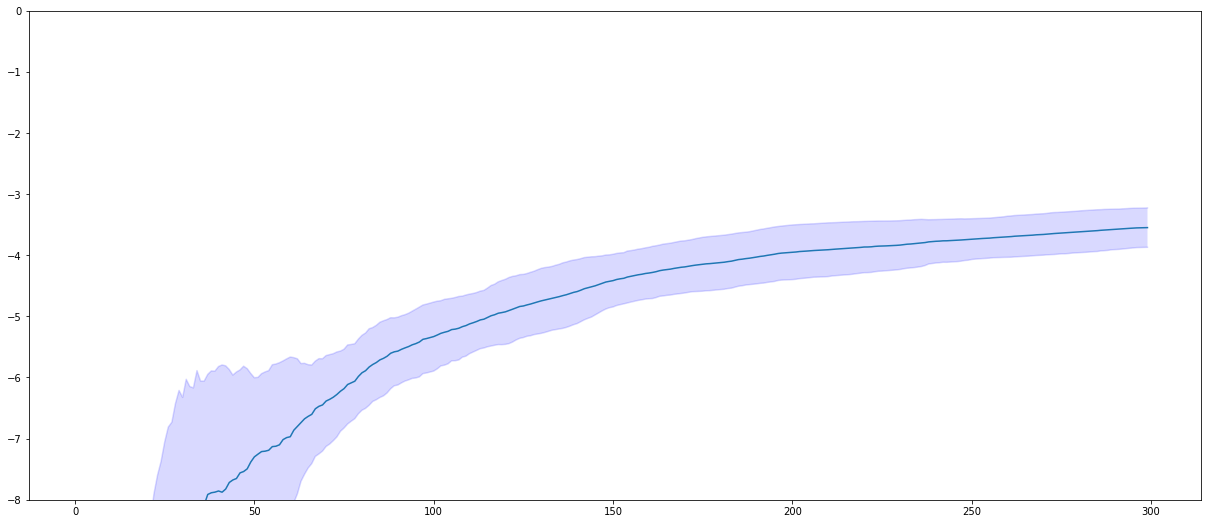

In [9]:
plt.figure(figsize=(21,9))
plt.plot(range(n_samples),np.mean(ll_psgld,0))
plt.plot(range(n_samples),upper,'blue',alpha=0.15)
plt.plot(range(n_samples),lower,'blue', alpha=0.15)
plt.fill_between(range(n_samples),lower, upper, facecolor='blue', alpha=0.15,interpolate=True)
plt.ylim(-8,0)

In [42]:
log_lik_psgld[-1]

tensor(-2.5281)

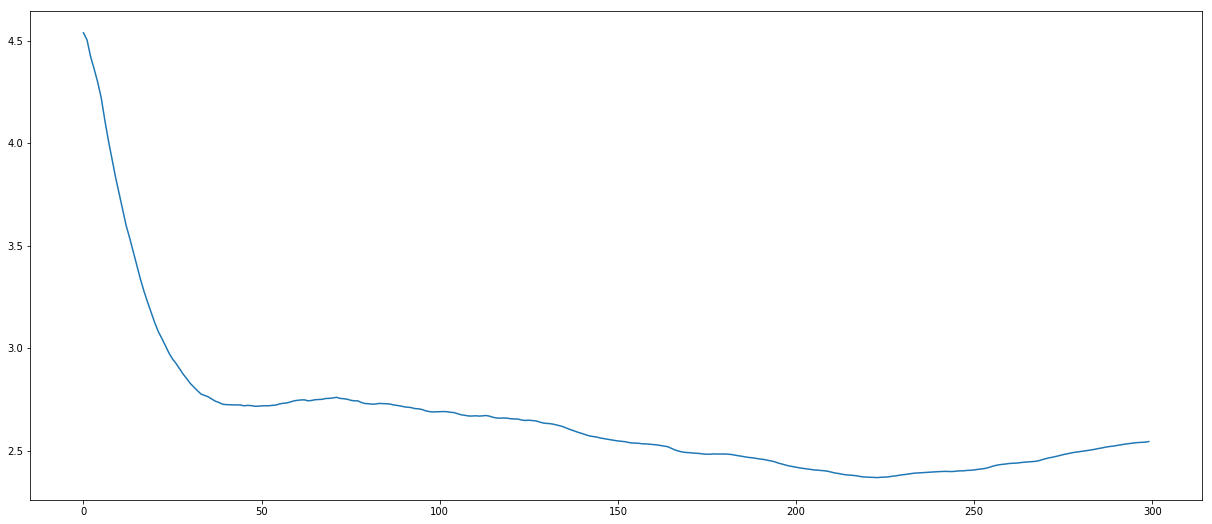

In [44]:
plt.figure(figsize=(21,9))
plt.plot(range(300),test_rmse)

## K-SGFS

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


batch_size = 32
dataset_size=456


n_chains = 10
n_samples = 300

ll_ksgfs = np.zeros((n_chains, n_samples))
rmse_ksgfs = np.zeros((n_chains, n_samples))


losses_ksgfs = []

for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)

    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 0.2, l2=1e-3, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()


            losses_ksgfs.append(loss)
            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, predictions = evaluate.fn(network)

                ll_ksgfs[i, n] = ll
                rmse_ksgfs[i, n] = rmse

                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 19.6248
chain 0 - epoch 1 - loss: 9.4260
chain 0 - epoch 2 - loss: 8.1996
chain 0 - epoch 3 - loss: 9.2648
chain 0 - epoch 4 - loss: 6.5475
chain 0 - epoch 5 - loss: 4.8508
chain 0 - epoch 6 - loss: 7.4659
chain 0 - epoch 7 - loss: 4.2275
chain 0 - epoch 8 - loss: 6.0304
chain 0 - epoch 9 - loss: 3.9434
chain 0 - epoch 10 - loss: 4.9551
chain 0 - epoch 11 - loss: 3.8861
chain 0 - epoch 12 - loss: 4.0585
chain 0 - epoch 13 - loss: 3.1863
chain 0 - epoch 14 - loss: 4.4001
chain 0 - epoch 15 - loss: 4.6150
chain 0 - epoch 16 - loss: 4.6781
chain 0 - epoch 17 - loss: 6.2477
chain 0 - epoch 18 - loss: 4.3350
chain 0 - epoch 19 - loss: 3.1540
chain 0 - epoch 20 - loss: 7.9478


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 21 - loss: 3.0730
chain 0 - epoch 22 - loss: 4.2138
chain 0 - epoch 23 - loss: 5.8931
chain 0 - epoch 24 - loss: 4.1980
chain 0 - epoch 25 - loss: 7.6349
chain 0 - epoch 26 - loss: 7.4077
chain 0 - epoch 27 - loss: 4.3041
chain 0 - epoch 28 - loss: 3.9692
chain 0 - epoch 29 - loss: 6.7520
chain 0 - epoch 30 - loss: 4.4244
chain 0 - epoch 31 - loss: 4.4755
chain 0 - epoch 32 - loss: 6.2121
chain 0 - epoch 33 - loss: 3.1843
chain 0 - epoch 34 - loss: 4.2540
chain 0 - epoch 35 - loss: 5.9219
chain 0 - epoch 36 - loss: 6.1459
chain 0 - epoch 37 - loss: 7.0189
chain 0 - epoch 38 - loss: 4.5708
chain 0 - epoch 39 - loss: 5.1840
chain 0 - epoch 40 - loss: 4.1050
chain 0 - epoch 41 - loss: 3.8258
chain 0 - epoch 42 - loss: 2.9087
chain 0 - epoch 43 - loss: 3.9522
chain 0 - epoch 44 - loss: 2.6519
chain 0 - epoch 45 - loss: 4.6057
chain 0 - epoch 46 - loss: 3.5191
chain 0 - epoch 47 - loss: 2.6726
chain 0 - epoch 48 - loss: 4.2660
chain 0 - epoch 49 - loss: 7.7235
chain 0 - epoc

chain 0 - epoch 260 - loss: 3.5270
chain 0 - epoch 261 - loss: 4.2323
chain 0 - epoch 262 - loss: 2.9771
chain 0 - epoch 263 - loss: 4.0988
chain 0 - epoch 264 - loss: 4.3128
chain 0 - epoch 265 - loss: 4.2792
chain 0 - epoch 266 - loss: 3.0526
chain 0 - epoch 267 - loss: 7.0309
chain 0 - epoch 268 - loss: 4.9657
chain 0 - epoch 269 - loss: 3.9596
chain 0 - epoch 270 - loss: 4.2878
chain 0 - epoch 271 - loss: 3.3184
chain 0 - epoch 272 - loss: 3.5207
chain 0 - epoch 273 - loss: 2.9273
chain 0 - epoch 274 - loss: 4.0792
chain 0 - epoch 275 - loss: 3.8019
chain 0 - epoch 276 - loss: 4.2448
chain 0 - epoch 277 - loss: 3.8632
chain 0 - epoch 278 - loss: 5.5185
chain 0 - epoch 279 - loss: 3.6961
chain 0 - epoch 280 - loss: 4.2812
chain 0 - epoch 281 - loss: 3.2796
chain 0 - epoch 282 - loss: 3.8756
chain 0 - epoch 283 - loss: 3.5212
chain 0 - epoch 284 - loss: 3.8732
chain 0 - epoch 285 - loss: 5.1697
chain 0 - epoch 286 - loss: 4.3296
chain 0 - epoch 287 - loss: 3.9417
chain 0 - epoch 288 

chain 0 - epoch 495 - loss: 3.9267
chain 0 - epoch 496 - loss: 4.9463
chain 0 - epoch 497 - loss: 4.5165
chain 0 - epoch 498 - loss: 4.2196
chain 0 - epoch 499 - loss: 3.9518
chain 0 - epoch 500 - loss: 4.1076
chain 0 - epoch 501 - loss: 4.0506
chain 0 - epoch 502 - loss: 4.1506
chain 0 - epoch 503 - loss: 5.6520
chain 0 - epoch 504 - loss: 5.4884
chain 0 - epoch 505 - loss: 3.4712
chain 0 - epoch 506 - loss: 5.7644
chain 0 - epoch 507 - loss: 5.7136
chain 0 - epoch 508 - loss: 3.8622
chain 0 - epoch 509 - loss: 7.2545
chain 0 - epoch 510 - loss: 4.7052
chain 0 - epoch 511 - loss: 4.1359
chain 0 - epoch 512 - loss: 5.1413
chain 0 - epoch 513 - loss: 4.6072
chain 0 - epoch 514 - loss: 4.3181
chain 0 - epoch 515 - loss: 3.7342
chain 0 - epoch 516 - loss: 4.0011
chain 0 - epoch 517 - loss: 5.0067
chain 0 - epoch 518 - loss: 4.6275
chain 0 - epoch 519 - loss: 4.8236
chain 0 - epoch 520 - loss: 8.6605
chain 0 - epoch 521 - loss: 8.1059
chain 0 - epoch 522 - loss: 2.8708
chain 0 - epoch 523 

chain 0 - epoch 732 - loss: 5.0915
chain 0 - epoch 733 - loss: 3.1918
chain 0 - epoch 734 - loss: 4.7284
chain 0 - epoch 735 - loss: 3.5095
chain 0 - epoch 736 - loss: 3.8496
chain 0 - epoch 737 - loss: 3.8872
chain 0 - epoch 738 - loss: 3.4755
chain 0 - epoch 739 - loss: 2.9863
chain 0 - epoch 740 - loss: 6.8420
chain 0 - epoch 741 - loss: 6.3782
chain 0 - epoch 742 - loss: 5.1547
chain 0 - epoch 743 - loss: 2.8796
chain 0 - epoch 744 - loss: 6.5592
chain 0 - epoch 745 - loss: 4.5052
chain 0 - epoch 746 - loss: 9.1954
chain 0 - epoch 747 - loss: 8.0914
chain 0 - epoch 748 - loss: 5.3736
chain 0 - epoch 749 - loss: 3.6545
chain 0 - epoch 750 - loss: 3.5511
chain 0 - epoch 751 - loss: 2.8893
chain 0 - epoch 752 - loss: 5.2896
chain 0 - epoch 753 - loss: 3.9612
chain 0 - epoch 754 - loss: 2.4297
chain 0 - epoch 755 - loss: 3.2724
chain 0 - epoch 756 - loss: 3.5236
chain 0 - epoch 757 - loss: 2.9071
chain 0 - epoch 758 - loss: 4.5385
chain 0 - epoch 759 - loss: 2.4213
chain 0 - epoch 760 

chain 0 - epoch 966 - loss: 4.2028
chain 0 - epoch 967 - loss: 5.1941
chain 0 - epoch 968 - loss: 4.2399
chain 0 - epoch 969 - loss: 3.0791
chain 0 - epoch 970 - loss: 3.8463
chain 0 - epoch 971 - loss: 3.7353
chain 0 - epoch 972 - loss: 2.5322
chain 0 - epoch 973 - loss: 5.1702
chain 0 - epoch 974 - loss: 3.3880
chain 0 - epoch 975 - loss: 9.1749
chain 0 - epoch 976 - loss: 11.4984
chain 0 - epoch 977 - loss: 6.9045
chain 0 - epoch 978 - loss: 7.9609
chain 0 - epoch 979 - loss: 8.4810
chain 0 - epoch 980 - loss: 3.9611
chain 0 - epoch 981 - loss: 5.4681
chain 0 - epoch 982 - loss: 5.2471
chain 0 - epoch 983 - loss: 3.4184
chain 0 - epoch 984 - loss: 3.1718
chain 0 - epoch 985 - loss: 4.3388
chain 0 - epoch 986 - loss: 2.7241
chain 0 - epoch 987 - loss: 2.5714
chain 0 - epoch 988 - loss: 2.6712
chain 0 - epoch 989 - loss: 3.0362
chain 0 - epoch 990 - loss: 3.6267
chain 0 - epoch 991 - loss: 6.1810
chain 0 - epoch 992 - loss: 3.1209
chain 0 - epoch 993 - loss: 3.7000
chain 0 - epoch 994

chain 0 - epoch 1195 - loss: 3.5237
chain 0 - epoch 1196 - loss: 3.5899
chain 0 - epoch 1197 - loss: 9.9766
chain 0 - epoch 1198 - loss: 11.5546
chain 0 - epoch 1199 - loss: 3.8259
chain 0 - epoch 1200 - loss: 4.8231
chain 0 - epoch 1201 - loss: 4.0690
chain 0 - epoch 1202 - loss: 3.0092
chain 0 - epoch 1203 - loss: 2.4503
chain 0 - epoch 1204 - loss: 3.4494
chain 0 - epoch 1205 - loss: 3.8933
chain 0 - epoch 1206 - loss: 4.0793
chain 0 - epoch 1207 - loss: 9.8222
chain 0 - epoch 1208 - loss: 3.5199
chain 0 - epoch 1209 - loss: 4.3978
chain 0 - epoch 1210 - loss: 3.8559
chain 0 - epoch 1211 - loss: 7.5726
chain 0 - epoch 1212 - loss: 3.5288
chain 0 - epoch 1213 - loss: 3.4672
chain 0 - epoch 1214 - loss: 4.0983
chain 0 - epoch 1215 - loss: 4.5087
chain 0 - epoch 1216 - loss: 3.0339
chain 0 - epoch 1217 - loss: 3.2382
chain 0 - epoch 1218 - loss: 6.9358
chain 0 - epoch 1219 - loss: 3.2817
chain 0 - epoch 1220 - loss: 3.0349
chain 0 - epoch 1221 - loss: 2.8091
chain 0 - epoch 1222 - loss

chain 0 - epoch 1423 - loss: 2.6594
chain 0 - epoch 1424 - loss: 2.8363
chain 0 - epoch 1425 - loss: 2.3572
chain 0 - epoch 1426 - loss: 2.6381
chain 0 - epoch 1427 - loss: 2.3759
chain 0 - epoch 1428 - loss: 1.9416
chain 0 - epoch 1429 - loss: 4.1714
chain 0 - epoch 1430 - loss: 3.5009
chain 0 - epoch 1431 - loss: 2.9843
chain 0 - epoch 1432 - loss: 3.0626
chain 0 - epoch 1433 - loss: 3.9132
chain 0 - epoch 1434 - loss: 3.4510
chain 0 - epoch 1435 - loss: 6.3943
chain 0 - epoch 1436 - loss: 3.3323
chain 0 - epoch 1437 - loss: 2.4792
chain 0 - epoch 1438 - loss: 4.2983
chain 0 - epoch 1439 - loss: 3.1620
chain 0 - epoch 1440 - loss: 3.7772
chain 0 - epoch 1441 - loss: 7.8818
chain 0 - epoch 1442 - loss: 3.0967
chain 0 - epoch 1443 - loss: 4.8744
chain 0 - epoch 1444 - loss: 8.4857
chain 0 - epoch 1445 - loss: 4.0424
chain 0 - epoch 1446 - loss: 4.5827
chain 0 - epoch 1447 - loss: 3.3818
chain 0 - epoch 1448 - loss: 3.2875
chain 0 - epoch 1449 - loss: 2.8608
chain 0 - epoch 1450 - loss:

chain 0 - epoch 1653 - loss: 3.0808
chain 0 - epoch 1654 - loss: 4.5655
chain 0 - epoch 1655 - loss: 3.4761
chain 0 - epoch 1656 - loss: 2.8079
chain 0 - epoch 1657 - loss: 4.2825
chain 0 - epoch 1658 - loss: 3.3073
chain 0 - epoch 1659 - loss: 3.0415
chain 0 - epoch 1660 - loss: 4.0578
chain 0 - epoch 1661 - loss: 2.9422
chain 0 - epoch 1662 - loss: 3.4318
chain 0 - epoch 1663 - loss: 3.9229
chain 0 - epoch 1664 - loss: 8.0961
chain 0 - epoch 1665 - loss: 5.8403
chain 0 - epoch 1666 - loss: 2.9005
chain 0 - epoch 1667 - loss: 4.4503
chain 0 - epoch 1668 - loss: 4.8172
chain 0 - epoch 1669 - loss: 3.5138
chain 0 - epoch 1670 - loss: 2.7426
chain 0 - epoch 1671 - loss: 3.0107
chain 0 - epoch 1672 - loss: 3.0275
chain 0 - epoch 1673 - loss: 3.3848
chain 0 - epoch 1674 - loss: 2.5816
chain 0 - epoch 1675 - loss: 3.9665
chain 0 - epoch 1676 - loss: 3.9315
chain 0 - epoch 1677 - loss: 3.4182
chain 0 - epoch 1678 - loss: 2.9869
chain 0 - epoch 1679 - loss: 2.9371
chain 0 - epoch 1680 - loss:

chain 0 - epoch 1884 - loss: 2.4869
chain 0 - epoch 1885 - loss: 3.1600
chain 0 - epoch 1886 - loss: 2.4605
chain 0 - epoch 1887 - loss: 3.0077
chain 0 - epoch 1888 - loss: 3.3201
chain 0 - epoch 1889 - loss: 2.5694
chain 0 - epoch 1890 - loss: 5.5677
chain 0 - epoch 1891 - loss: 2.3839
chain 0 - epoch 1892 - loss: 2.6627
chain 0 - epoch 1893 - loss: 2.4558
chain 0 - epoch 1894 - loss: 3.0349
chain 0 - epoch 1895 - loss: 2.7382
chain 0 - epoch 1896 - loss: 3.4378
chain 0 - epoch 1897 - loss: 3.5291
chain 0 - epoch 1898 - loss: 2.2776
chain 0 - epoch 1899 - loss: 2.3395
chain 0 - epoch 1900 - loss: 2.6891
chain 0 - epoch 1901 - loss: 3.4332
chain 0 - epoch 1902 - loss: 2.7109
chain 0 - epoch 1903 - loss: 3.3818
chain 0 - epoch 1904 - loss: 2.9900
chain 0 - epoch 1905 - loss: 2.9501
chain 0 - epoch 1906 - loss: 3.2922
chain 0 - epoch 1907 - loss: 2.7685
chain 0 - epoch 1908 - loss: 2.7997
chain 0 - epoch 1909 - loss: 2.7548
chain 0 - epoch 1910 - loss: 2.8444
chain 0 - epoch 1911 - loss:

chain 0 - epoch 2112 - loss: 2.6460
chain 0 - epoch 2113 - loss: 3.6195
chain 0 - epoch 2114 - loss: 2.6837
chain 0 - epoch 2115 - loss: 3.1973
chain 0 - epoch 2116 - loss: 3.0742
chain 0 - epoch 2117 - loss: 2.2473
chain 0 - epoch 2118 - loss: 1.9723
chain 0 - epoch 2119 - loss: 3.4542
chain 0 - epoch 2120 - loss: 3.1391
chain 0 - epoch 2121 - loss: 2.2894
chain 0 - epoch 2122 - loss: 3.6684
chain 0 - epoch 2123 - loss: 2.3143
chain 0 - epoch 2124 - loss: 2.8467
chain 0 - epoch 2125 - loss: 2.8259
chain 0 - epoch 2126 - loss: 2.0470
chain 0 - epoch 2127 - loss: 2.6867
chain 0 - epoch 2128 - loss: 4.5341
chain 0 - epoch 2129 - loss: 2.1707
chain 0 - epoch 2130 - loss: 2.8337
chain 0 - epoch 2131 - loss: 2.9179
chain 0 - epoch 2132 - loss: 2.8059
chain 0 - epoch 2133 - loss: 3.4728
chain 0 - epoch 2134 - loss: 2.7213
chain 0 - epoch 2135 - loss: 3.8264
chain 0 - epoch 2136 - loss: 3.2078
chain 0 - epoch 2137 - loss: 3.9555
chain 0 - epoch 2138 - loss: 2.7129
chain 0 - epoch 2139 - loss:

chain 0 - epoch 2342 - loss: 2.4862
chain 0 - epoch 2343 - loss: 2.4796
chain 0 - epoch 2344 - loss: 2.8361
chain 0 - epoch 2345 - loss: 3.1542
chain 0 - epoch 2346 - loss: 2.2057
chain 0 - epoch 2347 - loss: 2.6301
chain 0 - epoch 2348 - loss: 2.1310
chain 0 - epoch 2349 - loss: 4.1108
chain 0 - epoch 2350 - loss: 2.3338
chain 0 - epoch 2351 - loss: 2.9335
chain 0 - epoch 2352 - loss: 2.5278
chain 0 - epoch 2353 - loss: 2.9107
chain 0 - epoch 2354 - loss: 3.3185
chain 0 - epoch 2355 - loss: 3.2126
chain 0 - epoch 2356 - loss: 3.3196
chain 0 - epoch 2357 - loss: 3.9963
chain 0 - epoch 2358 - loss: 5.2230
chain 0 - epoch 2359 - loss: 4.6337
chain 0 - epoch 2360 - loss: 2.5240
chain 0 - epoch 2361 - loss: 2.5901
chain 0 - epoch 2362 - loss: 3.8013
chain 0 - epoch 2363 - loss: 2.9388
chain 0 - epoch 2364 - loss: 4.6208
chain 0 - epoch 2365 - loss: 3.2744
chain 0 - epoch 2366 - loss: 4.1324
chain 0 - epoch 2367 - loss: 3.2531
chain 0 - epoch 2368 - loss: 2.4304
chain 0 - epoch 2369 - loss:

chain 1 - epoch 75 - loss: 2.7352
chain 1 - epoch 76 - loss: 4.7093
chain 1 - epoch 77 - loss: 4.3059
chain 1 - epoch 78 - loss: 3.6504
chain 1 - epoch 79 - loss: 3.8685
chain 1 - epoch 80 - loss: 3.3995
chain 1 - epoch 81 - loss: 6.3661
chain 1 - epoch 82 - loss: 7.0932
chain 1 - epoch 83 - loss: 4.2569
chain 1 - epoch 84 - loss: 5.1648
chain 1 - epoch 85 - loss: 4.6088
chain 1 - epoch 86 - loss: 4.7862
chain 1 - epoch 87 - loss: 3.5781
chain 1 - epoch 88 - loss: 2.9742
chain 1 - epoch 89 - loss: 4.4944
chain 1 - epoch 90 - loss: 4.1692
chain 1 - epoch 91 - loss: 2.7903
chain 1 - epoch 92 - loss: 4.1052
chain 1 - epoch 93 - loss: 4.6132
chain 1 - epoch 94 - loss: 3.5716
chain 1 - epoch 95 - loss: 4.0390
chain 1 - epoch 96 - loss: 5.0979
chain 1 - epoch 97 - loss: 4.0236
chain 1 - epoch 98 - loss: 3.4918
chain 1 - epoch 99 - loss: 4.3469
chain 1 - epoch 100 - loss: 5.4607
chain 1 - epoch 101 - loss: 3.5816
chain 1 - epoch 102 - loss: 5.0449
chain 1 - epoch 103 - loss: 4.5640
chain 1 - 

chain 1 - epoch 311 - loss: 4.4899
chain 1 - epoch 312 - loss: 3.8796
chain 1 - epoch 313 - loss: 9.4768
chain 1 - epoch 314 - loss: 6.7818
chain 1 - epoch 315 - loss: 11.2515
chain 1 - epoch 316 - loss: 10.6842
chain 1 - epoch 317 - loss: 7.6310
chain 1 - epoch 318 - loss: 5.6406
chain 1 - epoch 319 - loss: 6.6693
chain 1 - epoch 320 - loss: 3.8512
chain 1 - epoch 321 - loss: 4.2130
chain 1 - epoch 322 - loss: 4.4361
chain 1 - epoch 323 - loss: 3.7395
chain 1 - epoch 324 - loss: 2.7200
chain 1 - epoch 325 - loss: 5.2831
chain 1 - epoch 326 - loss: 3.2823
chain 1 - epoch 327 - loss: 3.2257
chain 1 - epoch 328 - loss: 5.1941
chain 1 - epoch 329 - loss: 3.0309
chain 1 - epoch 330 - loss: 4.5090
chain 1 - epoch 331 - loss: 2.9624
chain 1 - epoch 332 - loss: 4.1334
chain 1 - epoch 333 - loss: 4.1615
chain 1 - epoch 334 - loss: 3.3598
chain 1 - epoch 335 - loss: 7.3352
chain 1 - epoch 336 - loss: 3.4686
chain 1 - epoch 337 - loss: 5.2629
chain 1 - epoch 338 - loss: 3.9044
chain 1 - epoch 33

chain 1 - epoch 546 - loss: 3.1257
chain 1 - epoch 547 - loss: 2.7924
chain 1 - epoch 548 - loss: 5.1674
chain 1 - epoch 549 - loss: 3.5072
chain 1 - epoch 550 - loss: 3.3249
chain 1 - epoch 551 - loss: 3.7820
chain 1 - epoch 552 - loss: 3.3016
chain 1 - epoch 553 - loss: 7.9836
chain 1 - epoch 554 - loss: 3.5861
chain 1 - epoch 555 - loss: 5.2190
chain 1 - epoch 556 - loss: 3.6526
chain 1 - epoch 557 - loss: 3.6537
chain 1 - epoch 558 - loss: 4.9186
chain 1 - epoch 559 - loss: 4.2857
chain 1 - epoch 560 - loss: 2.8622
chain 1 - epoch 561 - loss: 3.9066
chain 1 - epoch 562 - loss: 4.4521
chain 1 - epoch 563 - loss: 2.7225
chain 1 - epoch 564 - loss: 4.4727
chain 1 - epoch 565 - loss: 3.3492
chain 1 - epoch 566 - loss: 5.8747
chain 1 - epoch 567 - loss: 2.8304
chain 1 - epoch 568 - loss: 3.7235
chain 1 - epoch 569 - loss: 4.6914
chain 1 - epoch 570 - loss: 2.9481
chain 1 - epoch 571 - loss: 3.9628
chain 1 - epoch 572 - loss: 3.6352
chain 1 - epoch 573 - loss: 4.4591
chain 1 - epoch 574 

chain 1 - epoch 784 - loss: 3.5932
chain 1 - epoch 785 - loss: 3.7889
chain 1 - epoch 786 - loss: 2.7191
chain 1 - epoch 787 - loss: 2.5185
chain 1 - epoch 788 - loss: 5.5049
chain 1 - epoch 789 - loss: 3.5648
chain 1 - epoch 790 - loss: 2.2570
chain 1 - epoch 791 - loss: 3.8300
chain 1 - epoch 792 - loss: 3.3536
chain 1 - epoch 793 - loss: 4.7116
chain 1 - epoch 794 - loss: 3.7072
chain 1 - epoch 795 - loss: 4.0172
chain 1 - epoch 796 - loss: 5.3196
chain 1 - epoch 797 - loss: 6.0956
chain 1 - epoch 798 - loss: 11.8372
chain 1 - epoch 799 - loss: 5.2956
chain 1 - epoch 800 - loss: 4.1250
chain 1 - epoch 801 - loss: 3.0942
chain 1 - epoch 802 - loss: 3.5279
chain 1 - epoch 803 - loss: 4.3786
chain 1 - epoch 804 - loss: 2.9143
chain 1 - epoch 805 - loss: 5.4763
chain 1 - epoch 806 - loss: 4.8160
chain 1 - epoch 807 - loss: 3.9621
chain 1 - epoch 808 - loss: 5.5104
chain 1 - epoch 809 - loss: 5.0431
chain 1 - epoch 810 - loss: 3.2031
chain 1 - epoch 811 - loss: 4.0057
chain 1 - epoch 812

chain 1 - epoch 1018 - loss: 4.2394
chain 1 - epoch 1019 - loss: 3.7360
chain 1 - epoch 1020 - loss: 4.7800
chain 1 - epoch 1021 - loss: 4.3579
chain 1 - epoch 1022 - loss: 3.7889
chain 1 - epoch 1023 - loss: 4.6298
chain 1 - epoch 1024 - loss: 3.4389
chain 1 - epoch 1025 - loss: 3.5038
chain 1 - epoch 1026 - loss: 4.5178
chain 1 - epoch 1027 - loss: 3.7113
chain 1 - epoch 1028 - loss: 4.6928
chain 1 - epoch 1029 - loss: 4.8082
chain 1 - epoch 1030 - loss: 5.0981
chain 1 - epoch 1031 - loss: 6.5639
chain 1 - epoch 1032 - loss: 3.5489
chain 1 - epoch 1033 - loss: 4.9538
chain 1 - epoch 1034 - loss: 2.7569
chain 1 - epoch 1035 - loss: 2.7018
chain 1 - epoch 1036 - loss: 3.1613
chain 1 - epoch 1037 - loss: 4.6044
chain 1 - epoch 1038 - loss: 4.6907
chain 1 - epoch 1039 - loss: 5.4490
chain 1 - epoch 1040 - loss: 6.9282
chain 1 - epoch 1041 - loss: 3.0370
chain 1 - epoch 1042 - loss: 5.2615
chain 1 - epoch 1043 - loss: 2.8046
chain 1 - epoch 1044 - loss: 4.0407
chain 1 - epoch 1045 - loss:

chain 1 - epoch 1246 - loss: 3.8972
chain 1 - epoch 1247 - loss: 3.3654
chain 1 - epoch 1248 - loss: 3.6196
chain 1 - epoch 1249 - loss: 4.7722
chain 1 - epoch 1250 - loss: 5.2553
chain 1 - epoch 1251 - loss: 4.0252
chain 1 - epoch 1252 - loss: 3.5562
chain 1 - epoch 1253 - loss: 4.6776
chain 1 - epoch 1254 - loss: 4.0976
chain 1 - epoch 1255 - loss: 4.0823
chain 1 - epoch 1256 - loss: 3.9731
chain 1 - epoch 1257 - loss: 2.7594
chain 1 - epoch 1258 - loss: 5.4425
chain 1 - epoch 1259 - loss: 2.6806
chain 1 - epoch 1260 - loss: 2.9134
chain 1 - epoch 1261 - loss: 3.5775
chain 1 - epoch 1262 - loss: 5.4158
chain 1 - epoch 1263 - loss: 3.2138
chain 1 - epoch 1264 - loss: 3.9065
chain 1 - epoch 1265 - loss: 3.7663
chain 1 - epoch 1266 - loss: 5.9723
chain 1 - epoch 1267 - loss: 5.2625
chain 1 - epoch 1268 - loss: 5.0060
chain 1 - epoch 1269 - loss: 2.8989
chain 1 - epoch 1270 - loss: 5.6329
chain 1 - epoch 1271 - loss: 3.6377
chain 1 - epoch 1272 - loss: 3.8131
chain 1 - epoch 1273 - loss:

chain 1 - epoch 1475 - loss: 2.5050
chain 1 - epoch 1476 - loss: 3.2563
chain 1 - epoch 1477 - loss: 3.2462
chain 1 - epoch 1478 - loss: 5.9731
chain 1 - epoch 1479 - loss: 3.7711
chain 1 - epoch 1480 - loss: 4.0302
chain 1 - epoch 1481 - loss: 3.4465
chain 1 - epoch 1482 - loss: 4.1221
chain 1 - epoch 1483 - loss: 2.7772
chain 1 - epoch 1484 - loss: 2.3808
chain 1 - epoch 1485 - loss: 2.7564
chain 1 - epoch 1486 - loss: 3.6584
chain 1 - epoch 1487 - loss: 2.4275
chain 1 - epoch 1488 - loss: 2.7881
chain 1 - epoch 1489 - loss: 2.7803
chain 1 - epoch 1490 - loss: 3.7219
chain 1 - epoch 1491 - loss: 3.2889
chain 1 - epoch 1492 - loss: 2.6729
chain 1 - epoch 1493 - loss: 2.6152
chain 1 - epoch 1494 - loss: 3.1266
chain 1 - epoch 1495 - loss: 2.8165
chain 1 - epoch 1496 - loss: 2.9607
chain 1 - epoch 1497 - loss: 4.8251
chain 1 - epoch 1498 - loss: 3.8065
chain 1 - epoch 1499 - loss: 3.1767
chain 1 - epoch 1500 - loss: 3.2933
chain 1 - epoch 1501 - loss: 3.4249
chain 1 - epoch 1502 - loss:

chain 1 - epoch 1704 - loss: 3.5721
chain 1 - epoch 1705 - loss: 3.4695
chain 1 - epoch 1706 - loss: 1.9980
chain 1 - epoch 1707 - loss: 2.2955
chain 1 - epoch 1708 - loss: 2.6650
chain 1 - epoch 1709 - loss: 2.2589
chain 1 - epoch 1710 - loss: 2.3892
chain 1 - epoch 1711 - loss: 2.8453
chain 1 - epoch 1712 - loss: 2.5135
chain 1 - epoch 1713 - loss: 2.2300
chain 1 - epoch 1714 - loss: 2.3393
chain 1 - epoch 1715 - loss: 3.2296
chain 1 - epoch 1716 - loss: 3.0845
chain 1 - epoch 1717 - loss: 3.1579
chain 1 - epoch 1718 - loss: 3.0844
chain 1 - epoch 1719 - loss: 2.8490
chain 1 - epoch 1720 - loss: 2.3823
chain 1 - epoch 1721 - loss: 2.7670
chain 1 - epoch 1722 - loss: 3.6781
chain 1 - epoch 1723 - loss: 2.4281
chain 1 - epoch 1724 - loss: 3.7459
chain 1 - epoch 1725 - loss: 2.8095
chain 1 - epoch 1726 - loss: 3.3769
chain 1 - epoch 1727 - loss: 2.9873
chain 1 - epoch 1728 - loss: 3.4450
chain 1 - epoch 1729 - loss: 4.0887
chain 1 - epoch 1730 - loss: 2.1808
chain 1 - epoch 1731 - loss:

chain 1 - epoch 1932 - loss: 3.4474
chain 1 - epoch 1933 - loss: 2.6367
chain 1 - epoch 1934 - loss: 2.8620
chain 1 - epoch 1935 - loss: 2.2823
chain 1 - epoch 1936 - loss: 4.6749
chain 1 - epoch 1937 - loss: 2.8139
chain 1 - epoch 1938 - loss: 3.2203
chain 1 - epoch 1939 - loss: 2.7234
chain 1 - epoch 1940 - loss: 2.3026
chain 1 - epoch 1941 - loss: 2.5130
chain 1 - epoch 1942 - loss: 3.2625
chain 1 - epoch 1943 - loss: 3.2969
chain 1 - epoch 1944 - loss: 3.0697
chain 1 - epoch 1945 - loss: 2.0983
chain 1 - epoch 1946 - loss: 2.5660
chain 1 - epoch 1947 - loss: 2.5093
chain 1 - epoch 1948 - loss: 2.1978
chain 1 - epoch 1949 - loss: 3.1108
chain 1 - epoch 1950 - loss: 2.2028
chain 1 - epoch 1951 - loss: 3.0351
chain 1 - epoch 1952 - loss: 2.0523
chain 1 - epoch 1953 - loss: 2.7159
chain 1 - epoch 1954 - loss: 4.1614
chain 1 - epoch 1955 - loss: 2.1600
chain 1 - epoch 1956 - loss: 2.8373
chain 1 - epoch 1957 - loss: 3.5764
chain 1 - epoch 1958 - loss: 2.8002
chain 1 - epoch 1959 - loss:

chain 1 - epoch 2160 - loss: 2.2997
chain 1 - epoch 2161 - loss: 2.3840
chain 1 - epoch 2162 - loss: 2.8466
chain 1 - epoch 2163 - loss: 2.2466
chain 1 - epoch 2164 - loss: 2.5026
chain 1 - epoch 2165 - loss: 2.9826
chain 1 - epoch 2166 - loss: 2.4520
chain 1 - epoch 2167 - loss: 2.1696
chain 1 - epoch 2168 - loss: 3.3229
chain 1 - epoch 2169 - loss: 3.1635
chain 1 - epoch 2170 - loss: 2.6846
chain 1 - epoch 2171 - loss: 2.3421
chain 1 - epoch 2172 - loss: 2.7957
chain 1 - epoch 2173 - loss: 3.0689
chain 1 - epoch 2174 - loss: 2.9156
chain 1 - epoch 2175 - loss: 2.5216
chain 1 - epoch 2176 - loss: 2.2790
chain 1 - epoch 2177 - loss: 2.4267
chain 1 - epoch 2178 - loss: 3.6280
chain 1 - epoch 2179 - loss: 2.5902
chain 1 - epoch 2180 - loss: 2.2830
chain 1 - epoch 2181 - loss: 3.1732
chain 1 - epoch 2182 - loss: 2.5808
chain 1 - epoch 2183 - loss: 2.5074
chain 1 - epoch 2184 - loss: 2.0686
chain 1 - epoch 2185 - loss: 2.4396
chain 1 - epoch 2186 - loss: 3.5130
chain 1 - epoch 2187 - loss:

chain 1 - epoch 2390 - loss: 2.5404
chain 1 - epoch 2391 - loss: 2.5898
chain 1 - epoch 2392 - loss: 2.6796
chain 1 - epoch 2393 - loss: 2.5404
chain 1 - epoch 2394 - loss: 3.0421
chain 1 - epoch 2395 - loss: 2.4796
chain 1 - epoch 2396 - loss: 3.4577
chain 1 - epoch 2397 - loss: 3.0700
chain 1 - epoch 2398 - loss: 2.1161
chain 1 - epoch 2399 - loss: 2.5463
chain 1 - epoch 2400 - loss: 2.5303
chain 1 - epoch 2401 - loss: 2.4477
chain 1 - epoch 2402 - loss: 4.2418
chain 1 - epoch 2403 - loss: 3.5565
chain 1 - epoch 2404 - loss: 3.2950
chain 1 - epoch 2405 - loss: 2.9028
chain 1 - epoch 2406 - loss: 3.3594
chain 1 - epoch 2407 - loss: 3.4432
chain 1 - epoch 2408 - loss: 2.9187
chain 1 - epoch 2409 - loss: 3.0902
chain 1 - epoch 2410 - loss: 2.4989
chain 1 - epoch 2411 - loss: 3.1995
chain 1 - epoch 2412 - loss: 2.2460
chain 1 - epoch 2413 - loss: 2.8758
chain 1 - epoch 2414 - loss: 2.8144
chain 1 - epoch 2415 - loss: 2.9069
chain 1 - epoch 2416 - loss: 3.9337
chain 1 - epoch 2417 - loss:

chain 2 - epoch 125 - loss: 5.3759
chain 2 - epoch 126 - loss: 4.9492
chain 2 - epoch 127 - loss: 3.7576
chain 2 - epoch 128 - loss: 2.9159
chain 2 - epoch 129 - loss: 4.1538
chain 2 - epoch 130 - loss: 6.3123
chain 2 - epoch 131 - loss: 4.0413
chain 2 - epoch 132 - loss: 3.7929
chain 2 - epoch 133 - loss: 5.4721
chain 2 - epoch 134 - loss: 3.3059
chain 2 - epoch 135 - loss: 3.1223
chain 2 - epoch 136 - loss: 4.4918
chain 2 - epoch 137 - loss: 3.5211
chain 2 - epoch 138 - loss: 4.1055
chain 2 - epoch 139 - loss: 3.7270
chain 2 - epoch 140 - loss: 3.7702
chain 2 - epoch 141 - loss: 3.6619
chain 2 - epoch 142 - loss: 3.6671
chain 2 - epoch 143 - loss: 3.7059
chain 2 - epoch 144 - loss: 3.6652
chain 2 - epoch 145 - loss: 2.8635
chain 2 - epoch 146 - loss: 4.1991
chain 2 - epoch 147 - loss: 3.6820
chain 2 - epoch 148 - loss: 3.6668
chain 2 - epoch 149 - loss: 4.6754
chain 2 - epoch 150 - loss: 3.4254
chain 2 - epoch 151 - loss: 3.1532
chain 2 - epoch 152 - loss: 3.8445
chain 2 - epoch 153 

chain 2 - epoch 361 - loss: 5.6530
chain 2 - epoch 362 - loss: 5.9377
chain 2 - epoch 363 - loss: 4.5626
chain 2 - epoch 364 - loss: 4.9792
chain 2 - epoch 365 - loss: 3.2162
chain 2 - epoch 366 - loss: 3.4513
chain 2 - epoch 367 - loss: 3.2160
chain 2 - epoch 368 - loss: 2.9883
chain 2 - epoch 369 - loss: 4.5259
chain 2 - epoch 370 - loss: 2.9428
chain 2 - epoch 371 - loss: 2.8186
chain 2 - epoch 372 - loss: 3.5248
chain 2 - epoch 373 - loss: 3.5317
chain 2 - epoch 374 - loss: 3.6384
chain 2 - epoch 375 - loss: 3.0939
chain 2 - epoch 376 - loss: 3.3056
chain 2 - epoch 377 - loss: 3.7975
chain 2 - epoch 378 - loss: 3.9129
chain 2 - epoch 379 - loss: 4.3449
chain 2 - epoch 380 - loss: 3.1735
chain 2 - epoch 381 - loss: 3.9541
chain 2 - epoch 382 - loss: 6.2338
chain 2 - epoch 383 - loss: 3.5088
chain 2 - epoch 384 - loss: 3.1883
chain 2 - epoch 385 - loss: 4.1072
chain 2 - epoch 386 - loss: 6.5006
chain 2 - epoch 387 - loss: 5.3398
chain 2 - epoch 388 - loss: 8.3111
chain 2 - epoch 389 

chain 2 - epoch 598 - loss: 5.4531
chain 2 - epoch 599 - loss: 2.9647
chain 2 - epoch 600 - loss: 4.7191
chain 2 - epoch 601 - loss: 4.4732
chain 2 - epoch 602 - loss: 2.8748
chain 2 - epoch 603 - loss: 3.7413
chain 2 - epoch 604 - loss: 4.7752
chain 2 - epoch 605 - loss: 2.8445
chain 2 - epoch 606 - loss: 3.5555
chain 2 - epoch 607 - loss: 3.7439
chain 2 - epoch 608 - loss: 3.4045
chain 2 - epoch 609 - loss: 3.6893
chain 2 - epoch 610 - loss: 2.9784
chain 2 - epoch 611 - loss: 3.5195
chain 2 - epoch 612 - loss: 3.9265
chain 2 - epoch 613 - loss: 3.9792
chain 2 - epoch 614 - loss: 4.5045
chain 2 - epoch 615 - loss: 3.8581
chain 2 - epoch 616 - loss: 4.0741
chain 2 - epoch 617 - loss: 3.1428
chain 2 - epoch 618 - loss: 3.1520
chain 2 - epoch 619 - loss: 3.9766
chain 2 - epoch 620 - loss: 4.3499
chain 2 - epoch 621 - loss: 4.5980
chain 2 - epoch 622 - loss: 4.8450
chain 2 - epoch 623 - loss: 3.0268
chain 2 - epoch 624 - loss: 3.5929
chain 2 - epoch 625 - loss: 3.4878
chain 2 - epoch 626 

chain 2 - epoch 835 - loss: 4.8701
chain 2 - epoch 836 - loss: 3.3433
chain 2 - epoch 837 - loss: 3.4717
chain 2 - epoch 838 - loss: 4.0626
chain 2 - epoch 839 - loss: 2.7202
chain 2 - epoch 840 - loss: 3.5352
chain 2 - epoch 841 - loss: 2.5984
chain 2 - epoch 842 - loss: 4.7928
chain 2 - epoch 843 - loss: 4.6087
chain 2 - epoch 844 - loss: 3.6345
chain 2 - epoch 845 - loss: 3.1687
chain 2 - epoch 846 - loss: 3.5743
chain 2 - epoch 847 - loss: 4.1727
chain 2 - epoch 848 - loss: 3.3063
chain 2 - epoch 849 - loss: 3.2732
chain 2 - epoch 850 - loss: 5.0000
chain 2 - epoch 851 - loss: 2.7908
chain 2 - epoch 852 - loss: 4.6416
chain 2 - epoch 853 - loss: 2.6042
chain 2 - epoch 854 - loss: 3.0428
chain 2 - epoch 855 - loss: 3.0974
chain 2 - epoch 856 - loss: 4.5527
chain 2 - epoch 857 - loss: 2.5214
chain 2 - epoch 858 - loss: 3.8190
chain 2 - epoch 859 - loss: 3.5283
chain 2 - epoch 860 - loss: 3.6005
chain 2 - epoch 861 - loss: 4.5002
chain 2 - epoch 862 - loss: 4.9032
chain 2 - epoch 863 

chain 2 - epoch 1069 - loss: 3.4170
chain 2 - epoch 1070 - loss: 3.0248
chain 2 - epoch 1071 - loss: 3.7123
chain 2 - epoch 1072 - loss: 7.1158
chain 2 - epoch 1073 - loss: 3.3734
chain 2 - epoch 1074 - loss: 5.6057
chain 2 - epoch 1075 - loss: 4.2731
chain 2 - epoch 1076 - loss: 3.3895
chain 2 - epoch 1077 - loss: 3.2508
chain 2 - epoch 1078 - loss: 5.5030
chain 2 - epoch 1079 - loss: 3.1391
chain 2 - epoch 1080 - loss: 6.0672
chain 2 - epoch 1081 - loss: 3.6881
chain 2 - epoch 1082 - loss: 3.9608
chain 2 - epoch 1083 - loss: 2.5970
chain 2 - epoch 1084 - loss: 3.3829
chain 2 - epoch 1085 - loss: 3.4690
chain 2 - epoch 1086 - loss: 5.7327
chain 2 - epoch 1087 - loss: 3.5462
chain 2 - epoch 1088 - loss: 5.3615
chain 2 - epoch 1089 - loss: 5.6826
chain 2 - epoch 1090 - loss: 5.5920
chain 2 - epoch 1091 - loss: 3.1569
chain 2 - epoch 1092 - loss: 5.6697
chain 2 - epoch 1093 - loss: 3.3174
chain 2 - epoch 1094 - loss: 6.1625
chain 2 - epoch 1095 - loss: 4.3658
chain 2 - epoch 1096 - loss:

chain 2 - epoch 1297 - loss: 3.8190
chain 2 - epoch 1298 - loss: 2.8773
chain 2 - epoch 1299 - loss: 5.9794
chain 2 - epoch 1300 - loss: 4.2562
chain 2 - epoch 1301 - loss: 5.2888
chain 2 - epoch 1302 - loss: 2.3450
chain 2 - epoch 1303 - loss: 4.6672
chain 2 - epoch 1304 - loss: 3.9887
chain 2 - epoch 1305 - loss: 4.7463
chain 2 - epoch 1306 - loss: 3.6935
chain 2 - epoch 1307 - loss: 3.5493
chain 2 - epoch 1308 - loss: 3.8255
chain 2 - epoch 1309 - loss: 3.3204
chain 2 - epoch 1310 - loss: 3.5271
chain 2 - epoch 1311 - loss: 5.7370
chain 2 - epoch 1312 - loss: 3.7272
chain 2 - epoch 1313 - loss: 4.0977
chain 2 - epoch 1314 - loss: 3.1131
chain 2 - epoch 1315 - loss: 2.5019
chain 2 - epoch 1316 - loss: 3.8784
chain 2 - epoch 1317 - loss: 2.5662
chain 2 - epoch 1318 - loss: 3.7419
chain 2 - epoch 1319 - loss: 2.9478
chain 2 - epoch 1320 - loss: 4.1233
chain 2 - epoch 1321 - loss: 2.3425
chain 2 - epoch 1322 - loss: 5.4478
chain 2 - epoch 1323 - loss: 2.6877
chain 2 - epoch 1324 - loss:

chain 2 - epoch 1526 - loss: 4.0627
chain 2 - epoch 1527 - loss: 5.0887
chain 2 - epoch 1528 - loss: 3.4173
chain 2 - epoch 1529 - loss: 4.1782
chain 2 - epoch 1530 - loss: 4.4839
chain 2 - epoch 1531 - loss: 4.7015
chain 2 - epoch 1532 - loss: 6.4778
chain 2 - epoch 1533 - loss: 3.2129
chain 2 - epoch 1534 - loss: 4.9623
chain 2 - epoch 1535 - loss: 2.9952
chain 2 - epoch 1536 - loss: 2.6315
chain 2 - epoch 1537 - loss: 4.9883
chain 2 - epoch 1538 - loss: 3.9578
chain 2 - epoch 1539 - loss: 6.4999
chain 2 - epoch 1540 - loss: 4.4396
chain 2 - epoch 1541 - loss: 2.6393
chain 2 - epoch 1542 - loss: 3.5702
chain 2 - epoch 1543 - loss: 3.1700
chain 2 - epoch 1544 - loss: 2.4663
chain 2 - epoch 1545 - loss: 5.4278
chain 2 - epoch 1546 - loss: 3.9156
chain 2 - epoch 1547 - loss: 3.8993
chain 2 - epoch 1548 - loss: 4.3366
chain 2 - epoch 1549 - loss: 5.2755
chain 2 - epoch 1550 - loss: 3.8231
chain 2 - epoch 1551 - loss: 2.3274
chain 2 - epoch 1552 - loss: 4.0719
chain 2 - epoch 1553 - loss:

chain 2 - epoch 1756 - loss: 3.4907
chain 2 - epoch 1757 - loss: 3.8109
chain 2 - epoch 1758 - loss: 2.7638
chain 2 - epoch 1759 - loss: 3.5523
chain 2 - epoch 1760 - loss: 3.0724
chain 2 - epoch 1761 - loss: 2.7615
chain 2 - epoch 1762 - loss: 2.8422
chain 2 - epoch 1763 - loss: 3.4401
chain 2 - epoch 1764 - loss: 3.2680
chain 2 - epoch 1765 - loss: 2.7215
chain 2 - epoch 1766 - loss: 3.6728
chain 2 - epoch 1767 - loss: 4.0191
chain 2 - epoch 1768 - loss: 4.9778
chain 2 - epoch 1769 - loss: 3.2021
chain 2 - epoch 1770 - loss: 3.5735
chain 2 - epoch 1771 - loss: 3.7126
chain 2 - epoch 1772 - loss: 3.4206
chain 2 - epoch 1773 - loss: 2.9136
chain 2 - epoch 1774 - loss: 3.2764
chain 2 - epoch 1775 - loss: 2.8176
chain 2 - epoch 1776 - loss: 4.1282
chain 2 - epoch 1777 - loss: 3.2265
chain 2 - epoch 1778 - loss: 2.8841
chain 2 - epoch 1779 - loss: 2.8204
chain 2 - epoch 1780 - loss: 3.4250
chain 2 - epoch 1781 - loss: 3.3386
chain 2 - epoch 1782 - loss: 3.0763
chain 2 - epoch 1783 - loss:

chain 2 - epoch 1985 - loss: 4.0155
chain 2 - epoch 1986 - loss: 2.9852
chain 2 - epoch 1987 - loss: 5.2757
chain 2 - epoch 1988 - loss: 4.5256
chain 2 - epoch 1989 - loss: 7.3947
chain 2 - epoch 1990 - loss: 4.0671
chain 2 - epoch 1991 - loss: 2.9578
chain 2 - epoch 1992 - loss: 3.2147
chain 2 - epoch 1993 - loss: 3.7759
chain 2 - epoch 1994 - loss: 3.9049
chain 2 - epoch 1995 - loss: 3.1524
chain 2 - epoch 1996 - loss: 3.1247
chain 2 - epoch 1997 - loss: 3.7295
chain 2 - epoch 1998 - loss: 4.4228
chain 2 - epoch 1999 - loss: 3.8358
chain 2 - epoch 2000 - loss: 2.6300
chain 2 - epoch 2001 - loss: 2.8264
chain 2 - epoch 2002 - loss: 3.3570
chain 2 - epoch 2003 - loss: 2.4343
chain 2 - epoch 2004 - loss: 4.0958
chain 2 - epoch 2005 - loss: 3.1159
chain 2 - epoch 2006 - loss: 2.3480
chain 2 - epoch 2007 - loss: 2.6778
chain 2 - epoch 2008 - loss: 2.4460
chain 2 - epoch 2009 - loss: 2.9467
chain 2 - epoch 2010 - loss: 3.2676
chain 2 - epoch 2011 - loss: 2.4795
chain 2 - epoch 2012 - loss:

chain 2 - epoch 2215 - loss: 2.6802
chain 2 - epoch 2216 - loss: 2.6927
chain 2 - epoch 2217 - loss: 2.2778
chain 2 - epoch 2218 - loss: 3.1661
chain 2 - epoch 2219 - loss: 2.3313
chain 2 - epoch 2220 - loss: 2.2458
chain 2 - epoch 2221 - loss: 3.7137
chain 2 - epoch 2222 - loss: 2.3809
chain 2 - epoch 2223 - loss: 3.8895
chain 2 - epoch 2224 - loss: 4.0534
chain 2 - epoch 2225 - loss: 3.0475
chain 2 - epoch 2226 - loss: 2.3387
chain 2 - epoch 2227 - loss: 2.8545
chain 2 - epoch 2228 - loss: 2.8950
chain 2 - epoch 2229 - loss: 2.3043
chain 2 - epoch 2230 - loss: 3.5477
chain 2 - epoch 2231 - loss: 2.9706
chain 2 - epoch 2232 - loss: 3.0454
chain 2 - epoch 2233 - loss: 3.3951
chain 2 - epoch 2234 - loss: 2.3511
chain 2 - epoch 2235 - loss: 2.5275
chain 2 - epoch 2236 - loss: 3.4840
chain 2 - epoch 2237 - loss: 2.5938
chain 2 - epoch 2238 - loss: 3.5523
chain 2 - epoch 2239 - loss: 2.6973
chain 2 - epoch 2240 - loss: 2.2532
chain 2 - epoch 2241 - loss: 2.8575
chain 2 - epoch 2242 - loss:

chain 2 - epoch 2443 - loss: 4.2658
chain 2 - epoch 2444 - loss: 3.9644
chain 2 - epoch 2445 - loss: 2.9536
chain 2 - epoch 2446 - loss: 2.8121
chain 2 - epoch 2447 - loss: 3.1035
chain 2 - epoch 2448 - loss: 3.2128
chain 2 - epoch 2449 - loss: 2.8989
chain 2 - epoch 2450 - loss: 3.5752
chain 2 - epoch 2451 - loss: 3.1074
chain 2 - epoch 2452 - loss: 4.0955
chain 2 - epoch 2453 - loss: 3.0454
chain 2 - epoch 2454 - loss: 2.9601
chain 2 - epoch 2455 - loss: 3.1342
chain 2 - epoch 2456 - loss: 3.1329
chain 2 - epoch 2457 - loss: 2.7670
chain 2 - epoch 2458 - loss: 3.9491
chain 2 - epoch 2459 - loss: 2.4965
chain 2 - epoch 2460 - loss: 3.0927
chain 2 - epoch 2461 - loss: 2.8634
chain 2 - epoch 2462 - loss: 3.0669
chain 2 - epoch 2463 - loss: 3.4656
chain 2 - epoch 2464 - loss: 3.3366
chain 2 - epoch 2465 - loss: 2.8877
chain 2 - epoch 2466 - loss: 5.2074
chain 2 - epoch 2467 - loss: 2.2572
chain 2 - epoch 2468 - loss: 2.9557
chain 2 - epoch 2469 - loss: 3.5536
chain 2 - epoch 2470 - loss:

chain 3 - epoch 179 - loss: 3.3775
chain 3 - epoch 180 - loss: 4.1389
chain 3 - epoch 181 - loss: 4.5473
chain 3 - epoch 182 - loss: 9.4594
chain 3 - epoch 183 - loss: 10.9150
chain 3 - epoch 184 - loss: 9.5542
chain 3 - epoch 185 - loss: 11.8385
chain 3 - epoch 186 - loss: 7.3944
chain 3 - epoch 187 - loss: 3.0638
chain 3 - epoch 188 - loss: 5.5080
chain 3 - epoch 189 - loss: 3.2672
chain 3 - epoch 190 - loss: 3.1809
chain 3 - epoch 191 - loss: 5.5515
chain 3 - epoch 192 - loss: 11.5544
chain 3 - epoch 193 - loss: 5.5077
chain 3 - epoch 194 - loss: 5.5524
chain 3 - epoch 195 - loss: 3.0881
chain 3 - epoch 196 - loss: 4.5123
chain 3 - epoch 197 - loss: 6.5095
chain 3 - epoch 198 - loss: 2.9066
chain 3 - epoch 199 - loss: 3.8893
chain 3 - epoch 200 - loss: 6.7059
chain 3 - epoch 201 - loss: 3.5906
chain 3 - epoch 202 - loss: 4.4585
chain 3 - epoch 203 - loss: 4.2436
chain 3 - epoch 204 - loss: 4.2143
chain 3 - epoch 205 - loss: 3.5726
chain 3 - epoch 206 - loss: 4.1299
chain 3 - epoch 2

chain 3 - epoch 414 - loss: 4.3519
chain 3 - epoch 415 - loss: 4.8557
chain 3 - epoch 416 - loss: 4.2271
chain 3 - epoch 417 - loss: 4.5511
chain 3 - epoch 418 - loss: 3.7293
chain 3 - epoch 419 - loss: 3.1856
chain 3 - epoch 420 - loss: 3.0449
chain 3 - epoch 421 - loss: 3.6067
chain 3 - epoch 422 - loss: 3.7343
chain 3 - epoch 423 - loss: 3.5912
chain 3 - epoch 424 - loss: 2.7356
chain 3 - epoch 425 - loss: 2.4181
chain 3 - epoch 426 - loss: 4.0267
chain 3 - epoch 427 - loss: 3.2193
chain 3 - epoch 428 - loss: 3.5337
chain 3 - epoch 429 - loss: 2.3959
chain 3 - epoch 430 - loss: 3.0747
chain 3 - epoch 431 - loss: 4.1304
chain 3 - epoch 432 - loss: 2.8821
chain 3 - epoch 433 - loss: 3.6654
chain 3 - epoch 434 - loss: 5.3006
chain 3 - epoch 435 - loss: 2.3782
chain 3 - epoch 436 - loss: 4.0917
chain 3 - epoch 437 - loss: 3.1897
chain 3 - epoch 438 - loss: 3.5396
chain 3 - epoch 439 - loss: 3.2382
chain 3 - epoch 440 - loss: 3.0149
chain 3 - epoch 441 - loss: 3.5301
chain 3 - epoch 442 

chain 3 - epoch 649 - loss: 3.5074
chain 3 - epoch 650 - loss: 4.4001
chain 3 - epoch 651 - loss: 4.1287
chain 3 - epoch 652 - loss: 4.1036
chain 3 - epoch 653 - loss: 3.4282
chain 3 - epoch 654 - loss: 4.8967
chain 3 - epoch 655 - loss: 3.0814
chain 3 - epoch 656 - loss: 3.3264
chain 3 - epoch 657 - loss: 2.2278
chain 3 - epoch 658 - loss: 3.1788
chain 3 - epoch 659 - loss: 5.5049
chain 3 - epoch 660 - loss: 3.1535
chain 3 - epoch 661 - loss: 4.8429
chain 3 - epoch 662 - loss: 3.5316
chain 3 - epoch 663 - loss: 3.9866
chain 3 - epoch 664 - loss: 4.2898
chain 3 - epoch 665 - loss: 4.2015
chain 3 - epoch 666 - loss: 2.8851
chain 3 - epoch 667 - loss: 2.3057
chain 3 - epoch 668 - loss: 3.1991
chain 3 - epoch 669 - loss: 3.7580
chain 3 - epoch 670 - loss: 3.7857
chain 3 - epoch 671 - loss: 4.8203
chain 3 - epoch 672 - loss: 3.3968
chain 3 - epoch 673 - loss: 4.8615
chain 3 - epoch 674 - loss: 5.1682
chain 3 - epoch 675 - loss: 2.9861
chain 3 - epoch 676 - loss: 3.7478
chain 3 - epoch 677 

chain 3 - epoch 885 - loss: 4.5265
chain 3 - epoch 886 - loss: 2.7083
chain 3 - epoch 887 - loss: 3.4217
chain 3 - epoch 888 - loss: 7.1692
chain 3 - epoch 889 - loss: 5.4116
chain 3 - epoch 890 - loss: 3.2002
chain 3 - epoch 891 - loss: 3.5476
chain 3 - epoch 892 - loss: 6.0489
chain 3 - epoch 893 - loss: 2.8329
chain 3 - epoch 894 - loss: 5.3188
chain 3 - epoch 895 - loss: 5.6330
chain 3 - epoch 896 - loss: 3.2459
chain 3 - epoch 897 - loss: 4.0542
chain 3 - epoch 898 - loss: 6.5585
chain 3 - epoch 899 - loss: 3.3479
chain 3 - epoch 900 - loss: 3.2751
chain 3 - epoch 901 - loss: 6.2468
chain 3 - epoch 902 - loss: 3.0989
chain 3 - epoch 903 - loss: 2.7812
chain 3 - epoch 904 - loss: 4.2771
chain 3 - epoch 905 - loss: 2.6593
chain 3 - epoch 906 - loss: 3.5104
chain 3 - epoch 907 - loss: 3.3283
chain 3 - epoch 908 - loss: 3.2912
chain 3 - epoch 909 - loss: 2.3147
chain 3 - epoch 910 - loss: 3.7067
chain 3 - epoch 911 - loss: 3.7464
chain 3 - epoch 912 - loss: 3.7334
chain 3 - epoch 913 

chain 3 - epoch 1117 - loss: 3.3131
chain 3 - epoch 1118 - loss: 2.9467
chain 3 - epoch 1119 - loss: 2.8177
chain 3 - epoch 1120 - loss: 3.1357
chain 3 - epoch 1121 - loss: 3.4832
chain 3 - epoch 1122 - loss: 3.4025
chain 3 - epoch 1123 - loss: 2.8509
chain 3 - epoch 1124 - loss: 2.5665
chain 3 - epoch 1125 - loss: 3.0572
chain 3 - epoch 1126 - loss: 4.0088
chain 3 - epoch 1127 - loss: 2.5365
chain 3 - epoch 1128 - loss: 3.2135
chain 3 - epoch 1129 - loss: 2.5662
chain 3 - epoch 1130 - loss: 3.2512
chain 3 - epoch 1131 - loss: 5.7518
chain 3 - epoch 1132 - loss: 2.4752
chain 3 - epoch 1133 - loss: 3.7077
chain 3 - epoch 1134 - loss: 2.5381
chain 3 - epoch 1135 - loss: 4.0051
chain 3 - epoch 1136 - loss: 2.8381
chain 3 - epoch 1137 - loss: 4.2691
chain 3 - epoch 1138 - loss: 4.1700
chain 3 - epoch 1139 - loss: 4.9196
chain 3 - epoch 1140 - loss: 3.9582
chain 3 - epoch 1141 - loss: 3.0532
chain 3 - epoch 1142 - loss: 4.1704
chain 3 - epoch 1143 - loss: 3.4008
chain 3 - epoch 1144 - loss:

chain 3 - epoch 1345 - loss: 3.3053
chain 3 - epoch 1346 - loss: 2.7344
chain 3 - epoch 1347 - loss: 2.7975
chain 3 - epoch 1348 - loss: 3.0305
chain 3 - epoch 1349 - loss: 2.1716
chain 3 - epoch 1350 - loss: 2.7905
chain 3 - epoch 1351 - loss: 2.6362
chain 3 - epoch 1352 - loss: 3.1408
chain 3 - epoch 1353 - loss: 2.4069
chain 3 - epoch 1354 - loss: 2.8608
chain 3 - epoch 1355 - loss: 2.5174
chain 3 - epoch 1356 - loss: 2.6371
chain 3 - epoch 1357 - loss: 2.7982
chain 3 - epoch 1358 - loss: 2.3964
chain 3 - epoch 1359 - loss: 2.7383
chain 3 - epoch 1360 - loss: 3.2509
chain 3 - epoch 1361 - loss: 2.3480
chain 3 - epoch 1362 - loss: 2.5126
chain 3 - epoch 1363 - loss: 3.2101
chain 3 - epoch 1364 - loss: 2.7124
chain 3 - epoch 1365 - loss: 3.3965
chain 3 - epoch 1366 - loss: 2.7407
chain 3 - epoch 1367 - loss: 2.5982
chain 3 - epoch 1368 - loss: 2.9702
chain 3 - epoch 1369 - loss: 2.3535
chain 3 - epoch 1370 - loss: 3.3975
chain 3 - epoch 1371 - loss: 2.6993
chain 3 - epoch 1372 - loss:

chain 3 - epoch 1574 - loss: 2.6336
chain 3 - epoch 1575 - loss: 3.1706
chain 3 - epoch 1576 - loss: 2.7809
chain 3 - epoch 1577 - loss: 2.3088
chain 3 - epoch 1578 - loss: 2.3560
chain 3 - epoch 1579 - loss: 3.2261
chain 3 - epoch 1580 - loss: 2.5166
chain 3 - epoch 1581 - loss: 2.6900
chain 3 - epoch 1582 - loss: 2.8448
chain 3 - epoch 1583 - loss: 3.0290
chain 3 - epoch 1584 - loss: 2.7749
chain 3 - epoch 1585 - loss: 2.5990
chain 3 - epoch 1586 - loss: 2.3666
chain 3 - epoch 1587 - loss: 4.1711
chain 3 - epoch 1588 - loss: 2.3085
chain 3 - epoch 1589 - loss: 2.3991
chain 3 - epoch 1590 - loss: 2.5228
chain 3 - epoch 1591 - loss: 2.6781
chain 3 - epoch 1592 - loss: 2.8230
chain 3 - epoch 1593 - loss: 2.4727
chain 3 - epoch 1594 - loss: 2.4815
chain 3 - epoch 1595 - loss: 3.1288
chain 3 - epoch 1596 - loss: 3.5997
chain 3 - epoch 1597 - loss: 2.5909
chain 3 - epoch 1598 - loss: 2.9224
chain 3 - epoch 1599 - loss: 3.6137
chain 3 - epoch 1600 - loss: 3.0693
chain 3 - epoch 1601 - loss:

chain 3 - epoch 1804 - loss: 2.5772
chain 3 - epoch 1805 - loss: 2.1288
chain 3 - epoch 1806 - loss: 4.3906
chain 3 - epoch 1807 - loss: 2.4409
chain 3 - epoch 1808 - loss: 2.6307
chain 3 - epoch 1809 - loss: 3.1458
chain 3 - epoch 1810 - loss: 2.8024
chain 3 - epoch 1811 - loss: 2.6953
chain 3 - epoch 1812 - loss: 2.8468
chain 3 - epoch 1813 - loss: 3.6612
chain 3 - epoch 1814 - loss: 2.4009
chain 3 - epoch 1815 - loss: 2.4886
chain 3 - epoch 1816 - loss: 3.0596
chain 3 - epoch 1817 - loss: 2.9561
chain 3 - epoch 1818 - loss: 2.7253
chain 3 - epoch 1819 - loss: 2.5366
chain 3 - epoch 1820 - loss: 3.1337
chain 3 - epoch 1821 - loss: 2.6698
chain 3 - epoch 1822 - loss: 2.9129
chain 3 - epoch 1823 - loss: 2.5196
chain 3 - epoch 1824 - loss: 2.3812
chain 3 - epoch 1825 - loss: 2.9980
chain 3 - epoch 1826 - loss: 2.7731
chain 3 - epoch 1827 - loss: 2.9710
chain 3 - epoch 1828 - loss: 3.6900
chain 3 - epoch 1829 - loss: 2.8222
chain 3 - epoch 1830 - loss: 2.5446
chain 3 - epoch 1831 - loss:

chain 3 - epoch 2034 - loss: 2.7172
chain 3 - epoch 2035 - loss: 2.9253
chain 3 - epoch 2036 - loss: 2.7784
chain 3 - epoch 2037 - loss: 2.8914
chain 3 - epoch 2038 - loss: 2.1212
chain 3 - epoch 2039 - loss: 2.2900
chain 3 - epoch 2040 - loss: 4.4567
chain 3 - epoch 2041 - loss: 4.4203
chain 3 - epoch 2042 - loss: 3.3924
chain 3 - epoch 2043 - loss: 3.1910
chain 3 - epoch 2044 - loss: 2.5695
chain 3 - epoch 2045 - loss: 3.0059
chain 3 - epoch 2046 - loss: 2.7439
chain 3 - epoch 2047 - loss: 3.3217
chain 3 - epoch 2048 - loss: 2.5553
chain 3 - epoch 2049 - loss: 3.4097
chain 3 - epoch 2050 - loss: 2.1099
chain 3 - epoch 2051 - loss: 3.2039
chain 3 - epoch 2052 - loss: 2.7631
chain 3 - epoch 2053 - loss: 3.0301
chain 3 - epoch 2054 - loss: 2.6370
chain 3 - epoch 2055 - loss: 2.5435
chain 3 - epoch 2056 - loss: 4.0844
chain 3 - epoch 2057 - loss: 3.0828
chain 3 - epoch 2058 - loss: 2.8021
chain 3 - epoch 2059 - loss: 2.8915
chain 3 - epoch 2060 - loss: 2.4486
chain 3 - epoch 2061 - loss:

chain 3 - epoch 2262 - loss: 2.9341
chain 3 - epoch 2263 - loss: 3.6938
chain 3 - epoch 2264 - loss: 2.2458
chain 3 - epoch 2265 - loss: 2.6033
chain 3 - epoch 2266 - loss: 4.1818
chain 3 - epoch 2267 - loss: 2.7223
chain 3 - epoch 2268 - loss: 2.4628
chain 3 - epoch 2269 - loss: 3.2309
chain 3 - epoch 2270 - loss: 3.8937
chain 3 - epoch 2271 - loss: 2.7839
chain 3 - epoch 2272 - loss: 2.6587
chain 3 - epoch 2273 - loss: 2.3942
chain 3 - epoch 2274 - loss: 2.6968
chain 3 - epoch 2275 - loss: 2.2434
chain 3 - epoch 2276 - loss: 2.3370
chain 3 - epoch 2277 - loss: 3.6983
chain 3 - epoch 2278 - loss: 3.3180
chain 3 - epoch 2279 - loss: 2.4722
chain 3 - epoch 2280 - loss: 1.8952
chain 3 - epoch 2281 - loss: 3.5178
chain 3 - epoch 2282 - loss: 2.5003
chain 3 - epoch 2283 - loss: 1.9987
chain 3 - epoch 2284 - loss: 3.5318
chain 3 - epoch 2285 - loss: 3.0054
chain 3 - epoch 2286 - loss: 2.6329
chain 3 - epoch 2287 - loss: 2.3406
chain 3 - epoch 2288 - loss: 3.7805
chain 3 - epoch 2289 - loss:

chain 3 - epoch 2491 - loss: 2.6854
chain 3 - epoch 2492 - loss: 2.8102
chain 3 - epoch 2493 - loss: 2.4691
chain 3 - epoch 2494 - loss: 3.7051
chain 3 - epoch 2495 - loss: 2.8232
chain 3 - epoch 2496 - loss: 2.7947
chain 3 - epoch 2497 - loss: 3.0281
chain 3 - epoch 2498 - loss: 3.0884
chain 3 - epoch 2499 - loss: 2.4389
chain 4 - epoch 0 - loss: 15.4368
chain 4 - epoch 1 - loss: 10.2333
chain 4 - epoch 2 - loss: 9.7722
chain 4 - epoch 3 - loss: 4.6025
chain 4 - epoch 4 - loss: 6.9563
chain 4 - epoch 5 - loss: 5.9418
chain 4 - epoch 6 - loss: 9.5339
chain 4 - epoch 7 - loss: 10.2778
chain 4 - epoch 8 - loss: 4.5049
chain 4 - epoch 9 - loss: 4.7990
chain 4 - epoch 10 - loss: 6.3133
chain 4 - epoch 11 - loss: 6.1738
chain 4 - epoch 12 - loss: 7.7373
chain 4 - epoch 13 - loss: 4.9971
chain 4 - epoch 14 - loss: 4.0308
chain 4 - epoch 15 - loss: 4.7194
chain 4 - epoch 16 - loss: 6.0552
chain 4 - epoch 17 - loss: 4.0796
chain 4 - epoch 18 - loss: 3.8806
chain 4 - epoch 19 - loss: 7.7001
cha

chain 4 - epoch 229 - loss: 3.0839
chain 4 - epoch 230 - loss: 3.2334
chain 4 - epoch 231 - loss: 2.8600
chain 4 - epoch 232 - loss: 2.7071
chain 4 - epoch 233 - loss: 3.4565
chain 4 - epoch 234 - loss: 3.2701
chain 4 - epoch 235 - loss: 2.5245
chain 4 - epoch 236 - loss: 3.1985
chain 4 - epoch 237 - loss: 4.7009
chain 4 - epoch 238 - loss: 3.1535
chain 4 - epoch 239 - loss: 3.7188
chain 4 - epoch 240 - loss: 2.9121
chain 4 - epoch 241 - loss: 3.7875
chain 4 - epoch 242 - loss: 5.2652
chain 4 - epoch 243 - loss: 2.7489
chain 4 - epoch 244 - loss: 2.7963
chain 4 - epoch 245 - loss: 3.5786
chain 4 - epoch 246 - loss: 4.1663
chain 4 - epoch 247 - loss: 3.0322
chain 4 - epoch 248 - loss: 3.5693
chain 4 - epoch 249 - loss: 5.0278
chain 4 - epoch 250 - loss: 2.7331
chain 4 - epoch 251 - loss: 3.4938
chain 4 - epoch 252 - loss: 3.7641
chain 4 - epoch 253 - loss: 4.5935
chain 4 - epoch 254 - loss: 2.5801
chain 4 - epoch 255 - loss: 3.0023
chain 4 - epoch 256 - loss: 3.2570
chain 4 - epoch 257 

chain 4 - epoch 464 - loss: 3.6463
chain 4 - epoch 465 - loss: 3.4701
chain 4 - epoch 466 - loss: 2.3624
chain 4 - epoch 467 - loss: 2.3650
chain 4 - epoch 468 - loss: 3.0458
chain 4 - epoch 469 - loss: 2.8373
chain 4 - epoch 470 - loss: 3.2687
chain 4 - epoch 471 - loss: 2.8516
chain 4 - epoch 472 - loss: 2.4274
chain 4 - epoch 473 - loss: 2.9457
chain 4 - epoch 474 - loss: 4.7558
chain 4 - epoch 475 - loss: 2.7119
chain 4 - epoch 476 - loss: 2.9264
chain 4 - epoch 477 - loss: 3.4788
chain 4 - epoch 478 - loss: 2.8645
chain 4 - epoch 479 - loss: 3.1857
chain 4 - epoch 480 - loss: 2.4111
chain 4 - epoch 481 - loss: 3.1924
chain 4 - epoch 482 - loss: 2.6349
chain 4 - epoch 483 - loss: 3.9073
chain 4 - epoch 484 - loss: 2.3929
chain 4 - epoch 485 - loss: 3.7918
chain 4 - epoch 486 - loss: 2.6444
chain 4 - epoch 487 - loss: 3.0114
chain 4 - epoch 488 - loss: 3.0850
chain 4 - epoch 489 - loss: 2.4265
chain 4 - epoch 490 - loss: 2.5831
chain 4 - epoch 491 - loss: 2.8087
chain 4 - epoch 492 

chain 4 - epoch 701 - loss: 2.1386
chain 4 - epoch 702 - loss: 2.3187
chain 4 - epoch 703 - loss: 2.8742
chain 4 - epoch 704 - loss: 2.9311
chain 4 - epoch 705 - loss: 3.1998
chain 4 - epoch 706 - loss: 2.7210
chain 4 - epoch 707 - loss: 2.3089
chain 4 - epoch 708 - loss: 2.8621
chain 4 - epoch 709 - loss: 2.8643
chain 4 - epoch 710 - loss: 3.6065
chain 4 - epoch 711 - loss: 2.3396
chain 4 - epoch 712 - loss: 3.0583
chain 4 - epoch 713 - loss: 4.2708
chain 4 - epoch 714 - loss: 2.8963
chain 4 - epoch 715 - loss: 2.5554
chain 4 - epoch 716 - loss: 3.3888
chain 4 - epoch 717 - loss: 2.3236
chain 4 - epoch 718 - loss: 4.1923
chain 4 - epoch 719 - loss: 2.7840
chain 4 - epoch 720 - loss: 2.8445
chain 4 - epoch 721 - loss: 3.6779
chain 4 - epoch 722 - loss: 2.3431
chain 4 - epoch 723 - loss: 2.6546
chain 4 - epoch 724 - loss: 3.0911
chain 4 - epoch 725 - loss: 3.4190
chain 4 - epoch 726 - loss: 3.1555
chain 4 - epoch 727 - loss: 2.4117
chain 4 - epoch 728 - loss: 3.4152
chain 4 - epoch 729 

chain 4 - epoch 936 - loss: 2.5542
chain 4 - epoch 937 - loss: 1.8258
chain 4 - epoch 938 - loss: 2.9022
chain 4 - epoch 939 - loss: 2.0929
chain 4 - epoch 940 - loss: 3.4031
chain 4 - epoch 941 - loss: 2.9467
chain 4 - epoch 942 - loss: 2.4888
chain 4 - epoch 943 - loss: 2.3899
chain 4 - epoch 944 - loss: 2.6437
chain 4 - epoch 945 - loss: 3.3502
chain 4 - epoch 946 - loss: 2.3604
chain 4 - epoch 947 - loss: 2.8437
chain 4 - epoch 948 - loss: 2.4193
chain 4 - epoch 949 - loss: 2.1849
chain 4 - epoch 950 - loss: 2.6872
chain 4 - epoch 951 - loss: 2.7533
chain 4 - epoch 952 - loss: 3.2601
chain 4 - epoch 953 - loss: 5.2955
chain 4 - epoch 954 - loss: 2.6051
chain 4 - epoch 955 - loss: 2.2531
chain 4 - epoch 956 - loss: 3.6316
chain 4 - epoch 957 - loss: 2.3251
chain 4 - epoch 958 - loss: 2.3195
chain 4 - epoch 959 - loss: 3.5183
chain 4 - epoch 960 - loss: 3.2121
chain 4 - epoch 961 - loss: 5.5593
chain 4 - epoch 962 - loss: 2.9587
chain 4 - epoch 963 - loss: 2.3908
chain 4 - epoch 964 

chain 4 - epoch 1166 - loss: 2.6707
chain 4 - epoch 1167 - loss: 3.0039
chain 4 - epoch 1168 - loss: 2.8116
chain 4 - epoch 1169 - loss: 2.2985
chain 4 - epoch 1170 - loss: 2.8063
chain 4 - epoch 1171 - loss: 3.0229
chain 4 - epoch 1172 - loss: 3.2429
chain 4 - epoch 1173 - loss: 2.4412
chain 4 - epoch 1174 - loss: 2.4597
chain 4 - epoch 1175 - loss: 2.2489
chain 4 - epoch 1176 - loss: 3.6408
chain 4 - epoch 1177 - loss: 3.0654
chain 4 - epoch 1178 - loss: 3.1116
chain 4 - epoch 1179 - loss: 2.6058
chain 4 - epoch 1180 - loss: 2.4760
chain 4 - epoch 1181 - loss: 2.2819
chain 4 - epoch 1182 - loss: 2.1070
chain 4 - epoch 1183 - loss: 2.4187
chain 4 - epoch 1184 - loss: 2.7602
chain 4 - epoch 1185 - loss: 2.6038
chain 4 - epoch 1186 - loss: 2.1593
chain 4 - epoch 1187 - loss: 2.4199
chain 4 - epoch 1188 - loss: 3.0722
chain 4 - epoch 1189 - loss: 2.3547
chain 4 - epoch 1190 - loss: 3.1218
chain 4 - epoch 1191 - loss: 2.9695
chain 4 - epoch 1192 - loss: 2.7103
chain 4 - epoch 1193 - loss:

chain 4 - epoch 1394 - loss: 2.5698
chain 4 - epoch 1395 - loss: 3.2753
chain 4 - epoch 1396 - loss: 3.2511
chain 4 - epoch 1397 - loss: 4.3524
chain 4 - epoch 1398 - loss: 2.9203
chain 4 - epoch 1399 - loss: 3.5387
chain 4 - epoch 1400 - loss: 3.3129
chain 4 - epoch 1401 - loss: 2.5403
chain 4 - epoch 1402 - loss: 2.5075
chain 4 - epoch 1403 - loss: 2.3371
chain 4 - epoch 1404 - loss: 2.5987
chain 4 - epoch 1405 - loss: 2.6895
chain 4 - epoch 1406 - loss: 3.0427
chain 4 - epoch 1407 - loss: 2.6323
chain 4 - epoch 1408 - loss: 2.4928
chain 4 - epoch 1409 - loss: 2.3776
chain 4 - epoch 1410 - loss: 2.9192
chain 4 - epoch 1411 - loss: 2.8861
chain 4 - epoch 1412 - loss: 3.4978
chain 4 - epoch 1413 - loss: 2.7472
chain 4 - epoch 1414 - loss: 3.3899
chain 4 - epoch 1415 - loss: 2.9504
chain 4 - epoch 1416 - loss: 3.4037
chain 4 - epoch 1417 - loss: 2.2659
chain 4 - epoch 1418 - loss: 3.2868
chain 4 - epoch 1419 - loss: 2.6239
chain 4 - epoch 1420 - loss: 3.1024
chain 4 - epoch 1421 - loss:

chain 4 - epoch 1623 - loss: 2.4743
chain 4 - epoch 1624 - loss: 2.7945
chain 4 - epoch 1625 - loss: 2.7698
chain 4 - epoch 1626 - loss: 2.6675
chain 4 - epoch 1627 - loss: 2.4402
chain 4 - epoch 1628 - loss: 2.1488
chain 4 - epoch 1629 - loss: 2.1723
chain 4 - epoch 1630 - loss: 2.3537
chain 4 - epoch 1631 - loss: 2.6119
chain 4 - epoch 1632 - loss: 3.7851
chain 4 - epoch 1633 - loss: 2.5647
chain 4 - epoch 1634 - loss: 2.2737
chain 4 - epoch 1635 - loss: 3.1116
chain 4 - epoch 1636 - loss: 2.6666
chain 4 - epoch 1637 - loss: 2.8270
chain 4 - epoch 1638 - loss: 2.5119
chain 4 - epoch 1639 - loss: 2.5702
chain 4 - epoch 1640 - loss: 3.3425
chain 4 - epoch 1641 - loss: 4.0798
chain 4 - epoch 1642 - loss: 2.1981
chain 4 - epoch 1643 - loss: 2.6772
chain 4 - epoch 1644 - loss: 2.5725
chain 4 - epoch 1645 - loss: 5.1774
chain 4 - epoch 1646 - loss: 2.9781
chain 4 - epoch 1647 - loss: 2.6664
chain 4 - epoch 1648 - loss: 2.5063
chain 4 - epoch 1649 - loss: 2.3986
chain 4 - epoch 1650 - loss:

chain 4 - epoch 1853 - loss: 2.0798
chain 4 - epoch 1854 - loss: 2.6189
chain 4 - epoch 1855 - loss: 2.5357
chain 4 - epoch 1856 - loss: 5.3370
chain 4 - epoch 1857 - loss: 2.4987
chain 4 - epoch 1858 - loss: 2.9303
chain 4 - epoch 1859 - loss: 3.2116
chain 4 - epoch 1860 - loss: 3.0536
chain 4 - epoch 1861 - loss: 2.4349
chain 4 - epoch 1862 - loss: 3.7751
chain 4 - epoch 1863 - loss: 2.2831
chain 4 - epoch 1864 - loss: 2.6829
chain 4 - epoch 1865 - loss: 2.3408
chain 4 - epoch 1866 - loss: 2.0797
chain 4 - epoch 1867 - loss: 2.3756
chain 4 - epoch 1868 - loss: 2.2600
chain 4 - epoch 1869 - loss: 3.5422
chain 4 - epoch 1870 - loss: 2.9305
chain 4 - epoch 1871 - loss: 2.4381
chain 4 - epoch 1872 - loss: 2.2318
chain 4 - epoch 1873 - loss: 3.4408
chain 4 - epoch 1874 - loss: 2.2316
chain 4 - epoch 1875 - loss: 2.9160
chain 4 - epoch 1876 - loss: 3.0758
chain 4 - epoch 1877 - loss: 2.5555
chain 4 - epoch 1878 - loss: 2.3742
chain 4 - epoch 1879 - loss: 2.2682
chain 4 - epoch 1880 - loss:

chain 4 - epoch 2083 - loss: 2.5719
chain 4 - epoch 2084 - loss: 3.1542
chain 4 - epoch 2085 - loss: 2.3927
chain 4 - epoch 2086 - loss: 2.5732
chain 4 - epoch 2087 - loss: 2.7326
chain 4 - epoch 2088 - loss: 2.6843
chain 4 - epoch 2089 - loss: 3.2404
chain 4 - epoch 2090 - loss: 2.7256
chain 4 - epoch 2091 - loss: 2.6907
chain 4 - epoch 2092 - loss: 3.0422
chain 4 - epoch 2093 - loss: 2.2176
chain 4 - epoch 2094 - loss: 3.3712
chain 4 - epoch 2095 - loss: 3.2376
chain 4 - epoch 2096 - loss: 2.2665
chain 4 - epoch 2097 - loss: 4.0328
chain 4 - epoch 2098 - loss: 3.2554
chain 4 - epoch 2099 - loss: 3.2595
chain 4 - epoch 2100 - loss: 2.4265
chain 4 - epoch 2101 - loss: 2.5084
chain 4 - epoch 2102 - loss: 3.6995
chain 4 - epoch 2103 - loss: 4.1782
chain 4 - epoch 2104 - loss: 2.5908
chain 4 - epoch 2105 - loss: 3.3142
chain 4 - epoch 2106 - loss: 3.2639
chain 4 - epoch 2107 - loss: 2.1733
chain 4 - epoch 2108 - loss: 2.6094
chain 4 - epoch 2109 - loss: 2.7760
chain 4 - epoch 2110 - loss:

chain 4 - epoch 2313 - loss: 1.8808
chain 4 - epoch 2314 - loss: 2.7438
chain 4 - epoch 2315 - loss: 2.2472
chain 4 - epoch 2316 - loss: 2.0170
chain 4 - epoch 2317 - loss: 2.2957
chain 4 - epoch 2318 - loss: 2.3262
chain 4 - epoch 2319 - loss: 2.3299
chain 4 - epoch 2320 - loss: 2.3732
chain 4 - epoch 2321 - loss: 2.4445
chain 4 - epoch 2322 - loss: 3.1890
chain 4 - epoch 2323 - loss: 2.1379
chain 4 - epoch 2324 - loss: 2.4808
chain 4 - epoch 2325 - loss: 2.5849
chain 4 - epoch 2326 - loss: 3.0371
chain 4 - epoch 2327 - loss: 2.8510
chain 4 - epoch 2328 - loss: 2.8350
chain 4 - epoch 2329 - loss: 2.2531
chain 4 - epoch 2330 - loss: 3.3469
chain 4 - epoch 2331 - loss: 3.0505
chain 4 - epoch 2332 - loss: 2.5613
chain 4 - epoch 2333 - loss: 2.2615
chain 4 - epoch 2334 - loss: 3.6824
chain 4 - epoch 2335 - loss: 2.2761
chain 4 - epoch 2336 - loss: 3.7135
chain 4 - epoch 2337 - loss: 2.2425
chain 4 - epoch 2338 - loss: 3.2843
chain 4 - epoch 2339 - loss: 2.4055
chain 4 - epoch 2340 - loss:

chain 5 - epoch 45 - loss: 3.3698
chain 5 - epoch 46 - loss: 3.7508
chain 5 - epoch 47 - loss: 4.8289
chain 5 - epoch 48 - loss: 4.0157
chain 5 - epoch 49 - loss: 3.4928
chain 5 - epoch 50 - loss: 3.9775
chain 5 - epoch 51 - loss: 3.1316
chain 5 - epoch 52 - loss: 2.7572
chain 5 - epoch 53 - loss: 4.0148
chain 5 - epoch 54 - loss: 4.0434
chain 5 - epoch 55 - loss: 3.7468
chain 5 - epoch 56 - loss: 5.5824
chain 5 - epoch 57 - loss: 3.8973
chain 5 - epoch 58 - loss: 4.2306
chain 5 - epoch 59 - loss: 2.9156
chain 5 - epoch 60 - loss: 4.2552
chain 5 - epoch 61 - loss: 8.2401
chain 5 - epoch 62 - loss: 3.3781
chain 5 - epoch 63 - loss: 6.3643
chain 5 - epoch 64 - loss: 4.4082
chain 5 - epoch 65 - loss: 2.7405
chain 5 - epoch 66 - loss: 5.2630
chain 5 - epoch 67 - loss: 4.7401
chain 5 - epoch 68 - loss: 3.5293
chain 5 - epoch 69 - loss: 4.1066
chain 5 - epoch 70 - loss: 5.0555
chain 5 - epoch 71 - loss: 5.3481
chain 5 - epoch 72 - loss: 2.6517
chain 5 - epoch 73 - loss: 3.4089
chain 5 - epoc

In [46]:
log_lik_ksgfs[-1]

tensor(-2.3406)

In [47]:
gelman_rubin(predictions)

tensor(1.0136)

In [ ]:
ess(predictions[:,1:])

In [48]:
np.max(log_lik_ksgfs[3:])

-2.339214

In [ ]:
plt.plot(range(1491),predictions[0,:1491].numpy())
plt.plot(range(1491),np.linspace(y[0],y[0],1491))
plt.plot(range(1491),predictions[1,:1491].numpy())
plt.plot(range(1491),np.linspace(y[1],y[1],1491))
plt.plot(range(1491),predictions[2,:1491].numpy())
plt.plot(range(1491),np.linspace(y[2],y[2],1491))
plt.plot(range(1491),predictions[3,:1491].numpy())
plt.plot(range(1491),np.linspace(y[3],y[3],1491))
plt.plot(range(1491),predictions[4,:1491].numpy())
plt.plot(range(1491),np.linspace(y[4],y[4],1491))
plt.plot(range(1491),predictions[5,:1491].numpy())
plt.plot(range(1491),np.linspace(y[5],y[5],1491))

In [ ]:
for x,y in iter(test_loader):
    x,y

(-8, 0)

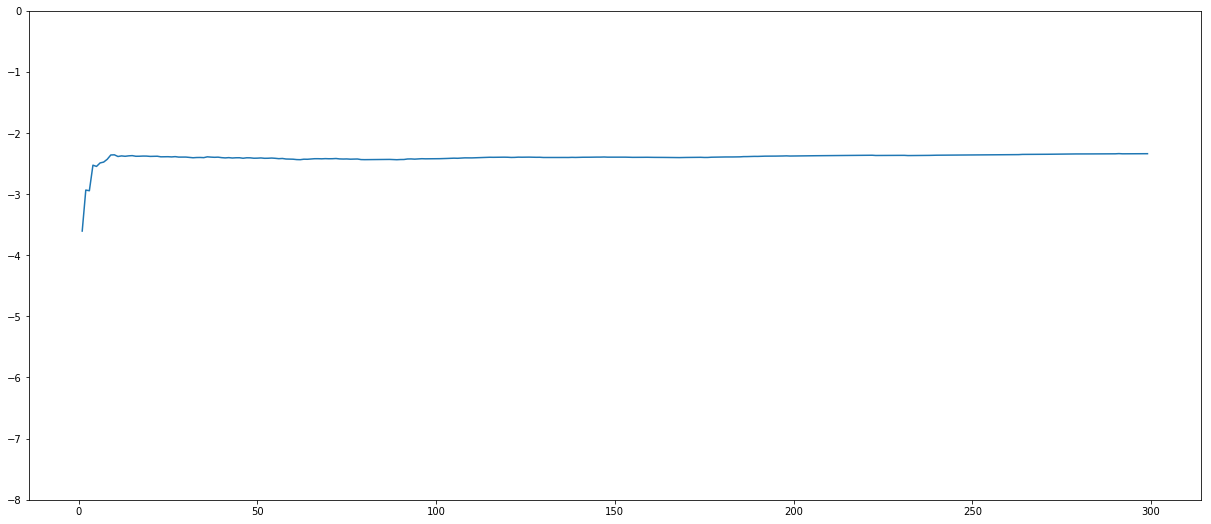

In [49]:
plt.figure(figsize=(21,9))
plt.plot(range(300), log_lik_ksgfs)
plt.ylim(-8,0)

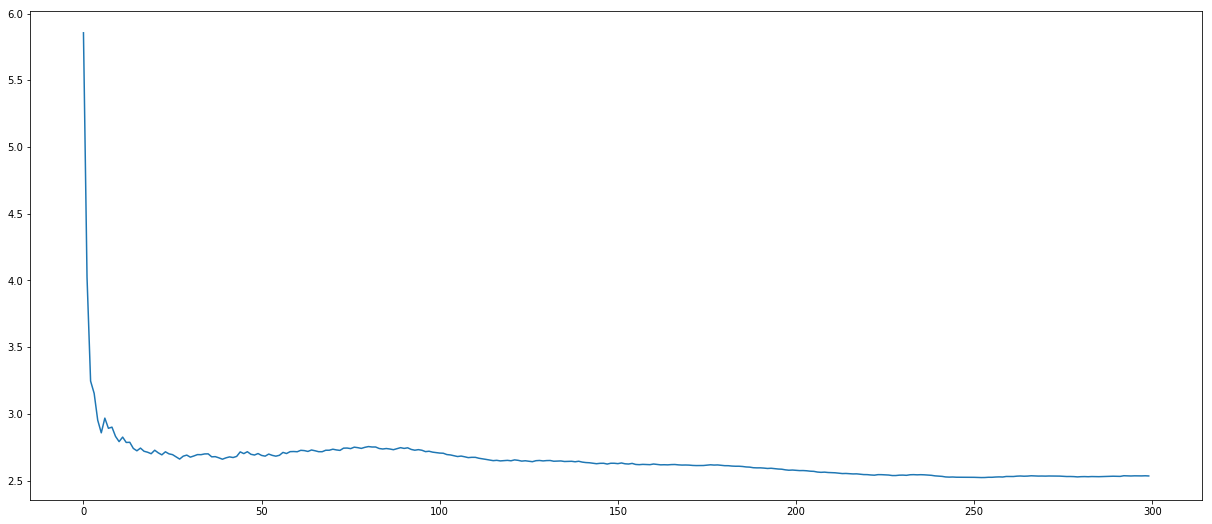

In [50]:
plt.figure(figsize=(21,9))
plt.plot(range(300), test_rmse)

## K-SGLD

In [51]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


batch_size = 32
dataset_size=456




network = Model()
criterion = nn.MSELoss(size_average=False)
#eps=5e-2

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=5e-6, l2=1e-3, invert_every=1)
evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_ksgld = []
log_lik_ksgld = []
test_rmse = []
t = 1.
n = 1

for epoch in range(2500):
    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()

        losses_ksgld.append(loss)
        running_loss += loss * batch_size / dataset_size

        if (t >= 300) & (t % 100 == 0) & (n <= n_samples):
            with torch.autograd.no_grad():
                rmse, log_lik, predictions = evaluate.fn(network)
                test_rmse.append(rmse)
                log_lik_ksgld.append(log_lik)
                
                n += 1
        t += 1.


    print("Epoch {:d} - loss: {:.4f} ".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 15.4704 
Epoch 1 - loss: 15.1179 
Epoch 2 - loss: 14.1280 
Epoch 3 - loss: 14.0169 
Epoch 4 - loss: 13.5066 
Epoch 5 - loss: 13.5329 
Epoch 6 - loss: 13.6539 
Epoch 7 - loss: 13.5260 
Epoch 8 - loss: 12.9301 
Epoch 9 - loss: 12.5323 
Epoch 10 - loss: 12.2197 
Epoch 11 - loss: 12.0727 
Epoch 12 - loss: 11.8891 
Epoch 13 - loss: 11.5307 
Epoch 14 - loss: 11.5086 
Epoch 15 - loss: 11.5167 
Epoch 16 - loss: 11.4331 
Epoch 17 - loss: 11.3132 
Epoch 18 - loss: 11.0979 
Epoch 19 - loss: 11.4716 


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Epoch 20 - loss: 11.4286 
Epoch 21 - loss: 11.6600 
Epoch 22 - loss: 12.3312 
Epoch 23 - loss: 12.4100 
Epoch 24 - loss: 12.7797 
Epoch 25 - loss: 12.6801 
Epoch 26 - loss: 12.2702 
Epoch 27 - loss: 12.0514 
Epoch 28 - loss: 11.4795 
Epoch 29 - loss: 11.1312 
Epoch 30 - loss: 11.1009 
Epoch 31 - loss: 11.1773 
Epoch 32 - loss: 11.4395 
Epoch 33 - loss: 11.6033 
Epoch 34 - loss: 11.3813 
Epoch 35 - loss: 11.9108 
Epoch 36 - loss: 10.8512 
Epoch 37 - loss: 10.8483 
Epoch 38 - loss: 10.8938 
Epoch 39 - loss: 11.3263 
Epoch 40 - loss: 10.6975 
Epoch 41 - loss: 10.9507 
Epoch 42 - loss: 10.8005 
Epoch 43 - loss: 10.1089 
Epoch 44 - loss: 10.3120 
Epoch 45 - loss: 10.2930 
Epoch 46 - loss: 10.0002 
Epoch 47 - loss: 9.6931 
Epoch 48 - loss: 9.3464 
Epoch 49 - loss: 9.1387 
Epoch 50 - loss: 8.3552 
Epoch 51 - loss: 8.3829 
Epoch 52 - loss: 8.1794 
Epoch 53 - loss: 7.9679 
Epoch 54 - loss: 8.0421 
Epoch 55 - loss: 8.0617 
Epoch 56 - loss: 7.6714 
Epoch 57 - loss: 7.3233 
Epoch 58 - loss: 7.0623

Epoch 338 - loss: 5.7174 
Epoch 339 - loss: 5.6523 
Epoch 340 - loss: 5.5067 
Epoch 341 - loss: 5.4854 
Epoch 342 - loss: 5.7586 
Epoch 343 - loss: 6.1992 
Epoch 344 - loss: 6.3029 
Epoch 345 - loss: 6.0882 
Epoch 346 - loss: 7.4636 
Epoch 347 - loss: 7.4274 
Epoch 348 - loss: 6.7733 
Epoch 349 - loss: 5.9746 
Epoch 350 - loss: 6.3715 
Epoch 351 - loss: 6.4842 
Epoch 352 - loss: 6.3107 
Epoch 353 - loss: 5.0340 
Epoch 354 - loss: 4.9359 
Epoch 355 - loss: 5.2155 
Epoch 356 - loss: 5.6617 
Epoch 357 - loss: 6.0594 
Epoch 358 - loss: 7.3392 
Epoch 359 - loss: 8.1666 
Epoch 360 - loss: 8.4285 
Epoch 361 - loss: 7.9901 
Epoch 362 - loss: 8.7348 
Epoch 363 - loss: 9.4457 
Epoch 364 - loss: 7.7090 
Epoch 365 - loss: 7.1731 
Epoch 366 - loss: 7.2467 
Epoch 367 - loss: 7.9437 
Epoch 368 - loss: 8.5493 
Epoch 369 - loss: 8.4913 
Epoch 370 - loss: 7.5798 
Epoch 371 - loss: 7.3226 
Epoch 372 - loss: 8.0344 
Epoch 373 - loss: 7.3436 
Epoch 374 - loss: 6.8386 
Epoch 375 - loss: 5.7672 
Epoch 376 - 

Epoch 653 - loss: 6.3192 
Epoch 654 - loss: 7.0856 
Epoch 655 - loss: 7.2196 
Epoch 656 - loss: 6.0836 
Epoch 657 - loss: 5.6337 
Epoch 658 - loss: 5.6487 
Epoch 659 - loss: 6.2276 
Epoch 660 - loss: 5.9009 
Epoch 661 - loss: 4.8524 
Epoch 662 - loss: 4.7228 
Epoch 663 - loss: 4.4930 
Epoch 664 - loss: 4.3181 
Epoch 665 - loss: 4.6760 
Epoch 666 - loss: 4.4776 
Epoch 667 - loss: 4.6671 
Epoch 668 - loss: 5.1519 
Epoch 669 - loss: 6.5553 
Epoch 670 - loss: 5.5547 
Epoch 671 - loss: 5.3246 
Epoch 672 - loss: 4.6172 
Epoch 673 - loss: 4.2956 
Epoch 674 - loss: 4.3118 
Epoch 675 - loss: 4.5431 
Epoch 676 - loss: 4.7379 
Epoch 677 - loss: 4.7599 
Epoch 678 - loss: 5.2268 
Epoch 679 - loss: 5.7553 
Epoch 680 - loss: 4.9873 
Epoch 681 - loss: 4.4947 
Epoch 682 - loss: 4.2985 
Epoch 683 - loss: 4.6855 
Epoch 684 - loss: 4.6762 
Epoch 685 - loss: 4.6958 
Epoch 686 - loss: 5.3443 
Epoch 687 - loss: 6.6944 
Epoch 688 - loss: 8.0354 
Epoch 689 - loss: 9.4315 
Epoch 690 - loss: 9.2264 
Epoch 691 - 

Epoch 971 - loss: 4.5678 
Epoch 972 - loss: 5.0235 
Epoch 973 - loss: 4.7977 
Epoch 974 - loss: 4.4580 
Epoch 975 - loss: 4.4071 
Epoch 976 - loss: 5.1711 
Epoch 977 - loss: 5.2896 
Epoch 978 - loss: 4.7645 
Epoch 979 - loss: 4.4788 
Epoch 980 - loss: 4.4374 
Epoch 981 - loss: 4.5870 
Epoch 982 - loss: 4.1965 
Epoch 983 - loss: 4.1201 
Epoch 984 - loss: 4.5916 
Epoch 985 - loss: 4.3488 
Epoch 986 - loss: 4.1535 
Epoch 987 - loss: 4.1479 
Epoch 988 - loss: 4.1887 
Epoch 989 - loss: 4.3964 
Epoch 990 - loss: 4.5826 
Epoch 991 - loss: 4.2630 
Epoch 992 - loss: 4.1725 
Epoch 993 - loss: 4.3702 
Epoch 994 - loss: 4.2920 
Epoch 995 - loss: 4.2550 
Epoch 996 - loss: 4.2850 
Epoch 997 - loss: 4.5318 
Epoch 998 - loss: 4.3380 
Epoch 999 - loss: 4.4359 
Epoch 1000 - loss: 4.5670 
Epoch 1001 - loss: 4.4772 
Epoch 1002 - loss: 4.3733 
Epoch 1003 - loss: 4.7406 
Epoch 1004 - loss: 4.5272 
Epoch 1005 - loss: 5.0107 
Epoch 1006 - loss: 4.4239 
Epoch 1007 - loss: 4.4530 
Epoch 1008 - loss: 4.9268 
Epo

Epoch 1277 - loss: 4.4531 
Epoch 1278 - loss: 4.3849 
Epoch 1279 - loss: 4.6590 
Epoch 1280 - loss: 4.5298 
Epoch 1281 - loss: 4.6902 
Epoch 1282 - loss: 4.6420 
Epoch 1283 - loss: 4.6802 
Epoch 1284 - loss: 4.6840 
Epoch 1285 - loss: 4.5166 
Epoch 1286 - loss: 4.3183 
Epoch 1287 - loss: 4.0644 
Epoch 1288 - loss: 4.1755 
Epoch 1289 - loss: 4.1425 
Epoch 1290 - loss: 4.1259 
Epoch 1291 - loss: 4.1295 
Epoch 1292 - loss: 4.3880 
Epoch 1293 - loss: 4.2593 
Epoch 1294 - loss: 4.0583 
Epoch 1295 - loss: 3.9119 
Epoch 1296 - loss: 4.4571 
Epoch 1297 - loss: 4.7024 
Epoch 1298 - loss: 4.9052 
Epoch 1299 - loss: 4.7815 
Epoch 1300 - loss: 4.8626 
Epoch 1301 - loss: 4.3242 
Epoch 1302 - loss: 4.0825 
Epoch 1303 - loss: 4.1920 
Epoch 1304 - loss: 4.6749 
Epoch 1305 - loss: 4.2438 
Epoch 1306 - loss: 4.1821 
Epoch 1307 - loss: 4.2579 
Epoch 1308 - loss: 4.4926 
Epoch 1309 - loss: 4.4958 
Epoch 1310 - loss: 4.2572 
Epoch 1311 - loss: 4.3897 
Epoch 1312 - loss: 4.2066 
Epoch 1313 - loss: 4.3078 
E

Epoch 1581 - loss: 4.4957 
Epoch 1582 - loss: 4.1481 
Epoch 1583 - loss: 4.1330 
Epoch 1584 - loss: 4.7542 
Epoch 1585 - loss: 4.7980 
Epoch 1586 - loss: 5.6513 
Epoch 1587 - loss: 6.3354 
Epoch 1588 - loss: 8.8538 
Epoch 1589 - loss: 8.0603 
Epoch 1590 - loss: 8.0743 
Epoch 1591 - loss: 9.4819 
Epoch 1592 - loss: 11.2945 
Epoch 1593 - loss: 11.0680 
Epoch 1594 - loss: 14.6460 
Epoch 1595 - loss: 16.4740 
Epoch 1596 - loss: 20.3465 
Epoch 1597 - loss: 15.8223 
Epoch 1598 - loss: 13.8810 
Epoch 1599 - loss: 13.8968 
Epoch 1600 - loss: 11.0504 
Epoch 1601 - loss: 12.1584 
Epoch 1602 - loss: 9.2260 
Epoch 1603 - loss: 10.8312 
Epoch 1604 - loss: 9.5201 
Epoch 1605 - loss: 10.0125 
Epoch 1606 - loss: 12.2674 
Epoch 1607 - loss: 15.4124 
Epoch 1608 - loss: 22.8948 
Epoch 1609 - loss: 23.9383 
Epoch 1610 - loss: 16.8961 
Epoch 1611 - loss: 15.4930 
Epoch 1612 - loss: 12.7367 
Epoch 1613 - loss: 10.6580 
Epoch 1614 - loss: 10.6830 
Epoch 1615 - loss: 8.3029 
Epoch 1616 - loss: 6.0013 
Epoch 1

Epoch 1881 - loss: 35.5879 
Epoch 1882 - loss: 26.2589 
Epoch 1883 - loss: 29.6403 
Epoch 1884 - loss: 25.9436 
Epoch 1885 - loss: 26.1066 
Epoch 1886 - loss: 17.6129 
Epoch 1887 - loss: 9.5905 
Epoch 1888 - loss: 7.5684 
Epoch 1889 - loss: 14.9904 
Epoch 1890 - loss: 12.3588 
Epoch 1891 - loss: 7.3217 
Epoch 1892 - loss: 6.5042 
Epoch 1893 - loss: 5.6741 
Epoch 1894 - loss: 5.0501 
Epoch 1895 - loss: 5.5993 
Epoch 1896 - loss: 8.0089 
Epoch 1897 - loss: 7.8260 
Epoch 1898 - loss: 8.4029 
Epoch 1899 - loss: 5.3254 
Epoch 1900 - loss: 5.5349 
Epoch 1901 - loss: 6.2061 
Epoch 1902 - loss: 6.1491 
Epoch 1903 - loss: 8.0560 
Epoch 1904 - loss: 7.3853 
Epoch 1905 - loss: 9.3617 
Epoch 1906 - loss: 9.0514 
Epoch 1907 - loss: 11.7501 
Epoch 1908 - loss: 10.8550 
Epoch 1909 - loss: 7.3927 
Epoch 1910 - loss: 7.2174 
Epoch 1911 - loss: 7.5710 
Epoch 1912 - loss: 6.7591 
Epoch 1913 - loss: 7.0174 
Epoch 1914 - loss: 5.9876 
Epoch 1915 - loss: 5.6625 
Epoch 1916 - loss: 7.6194 
Epoch 1917 - loss:

Epoch 2182 - loss: 10.7626 
Epoch 2183 - loss: 11.9834 
Epoch 2184 - loss: 5.8016 
Epoch 2185 - loss: 5.0218 
Epoch 2186 - loss: 5.1886 
Epoch 2187 - loss: 9.0915 
Epoch 2188 - loss: 11.5869 
Epoch 2189 - loss: 13.1768 
Epoch 2190 - loss: 8.5154 
Epoch 2191 - loss: 7.6748 
Epoch 2192 - loss: 8.3141 
Epoch 2193 - loss: 4.5998 
Epoch 2194 - loss: 4.3477 
Epoch 2195 - loss: 4.3247 
Epoch 2196 - loss: 5.4805 
Epoch 2197 - loss: 4.2066 
Epoch 2198 - loss: 4.7858 
Epoch 2199 - loss: 7.8168 
Epoch 2200 - loss: 13.4992 
Epoch 2201 - loss: 22.2128 
Epoch 2202 - loss: 19.1809 
Epoch 2203 - loss: 20.0912 
Epoch 2204 - loss: 20.5333 
Epoch 2205 - loss: 10.6981 
Epoch 2206 - loss: 11.0720 
Epoch 2207 - loss: 6.1177 
Epoch 2208 - loss: 4.3488 
Epoch 2209 - loss: 4.2661 
Epoch 2210 - loss: 4.6308 
Epoch 2211 - loss: 4.3118 
Epoch 2212 - loss: 4.4352 
Epoch 2213 - loss: 4.8262 
Epoch 2214 - loss: 4.9090 
Epoch 2215 - loss: 5.2897 
Epoch 2216 - loss: 6.0764 
Epoch 2217 - loss: 7.4551 
Epoch 2218 - loss

Epoch 2480 - loss: 44.6534 
Epoch 2481 - loss: 43.0416 
Epoch 2482 - loss: 42.7802 
Epoch 2483 - loss: 38.2628 
Epoch 2484 - loss: 25.3768 
Epoch 2485 - loss: 14.1816 
Epoch 2486 - loss: 10.9459 
Epoch 2487 - loss: 16.3132 
Epoch 2488 - loss: 18.9814 
Epoch 2489 - loss: 16.7645 
Epoch 2490 - loss: 11.1930 
Epoch 2491 - loss: 8.1814 
Epoch 2492 - loss: 7.8522 
Epoch 2493 - loss: 7.8736 
Epoch 2494 - loss: 9.4818 
Epoch 2495 - loss: 7.5495 
Epoch 2496 - loss: 7.0188 
Epoch 2497 - loss: 9.5141 
Epoch 2498 - loss: 10.9561 
Epoch 2499 - loss: 8.6444 


In [52]:
log_lik_ksgld[-1]

tensor(-2.9076)

(-8, 0)

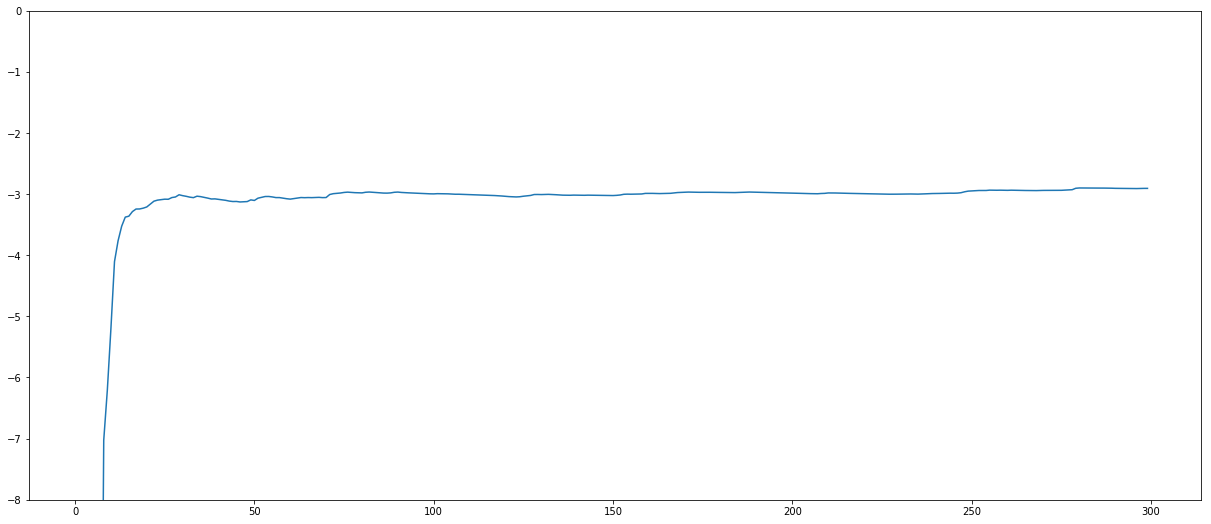

In [53]:
plt.figure(figsize=(21,9))
plt.plot(range(300),log_lik_ksgld)
plt.ylim(-8,0)

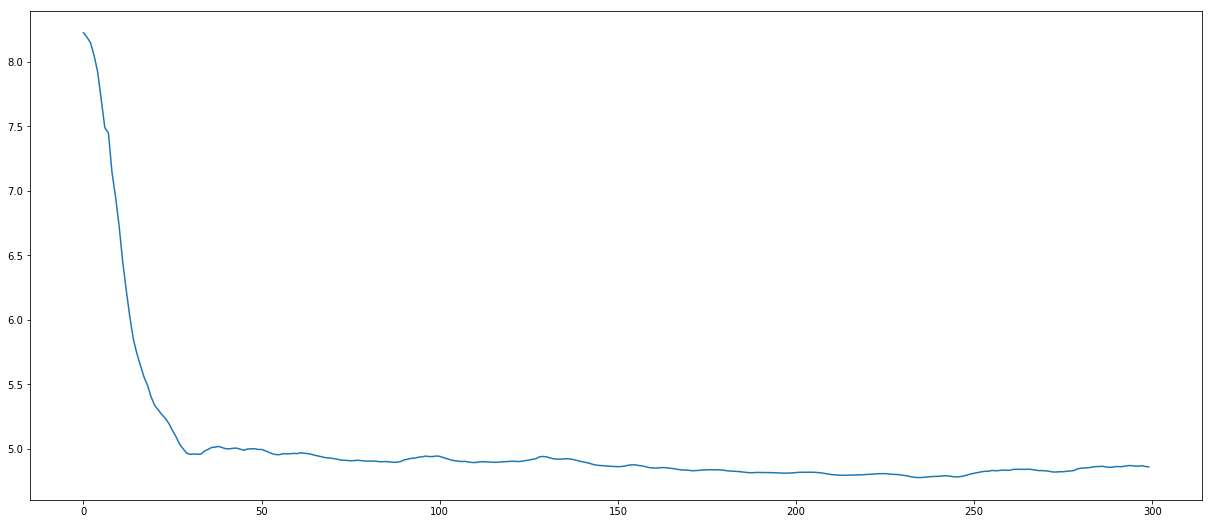

In [54]:
plt.figure(figsize=(21,9))
plt.plot(range(300),test_rmse)

# Simulated Datasets

## Cubic

20 data points simulated as follows:

- x sampled from $\mathcal{U}(-4,4)$
- y sampled from $\mathcal{N}(x^3,3^2)$

In [ ]:
x, _ = torch.empty(20,1).uniform_(-4,4).sort(0)
y = torch.normal(x**3,3)
grid = np.linspace(-6,6,400).reshape(-1,1)
y_true = grid ** 3

In [ ]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid,y_true)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(1, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgd

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=False)

optim = sgd.optim.sgd(network, lr, lambda_, dataset_size)


#test_rmse = []
#log_lik_sgld = []


x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    
with torch.autograd.no_grad():
    prediction_sgd = network(x_test)

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(prediction_sgd.detach().numpy(),1),'black')
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')



### SGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-3
lr = 1e-3


batch_size = 20
dataset_size = 20

network = Model()
criterion = nn.MSELoss(size_average=True)

# optim = sgld.optim.sgld(network, lr, lambda_, dataset_size)
optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = (1/(2*9)) * criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions[:,1:].detach().numpy(),1) + 3 * np.std(predictions[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions[:,1:].detach().numpy(),1) - 3 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)

### pSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-3
lr = 2e-4
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)

### KSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-4, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)



### KSGFS

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=0.01, l2=1e-3, invert_every=1)


predictions_ksgfs = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-60,60)



In [ ]:
predictions_ksgfs[:,1:].size()

## Sinus (Louizos, Welling (2016))

20 data points simulated as follows:
- 12 samples $x_i$ from $\mathcal{U}(0,0.6)$ and 8 samples from $\mathcal{U}(0.8,1)$
- $y = x_i + \epsilon_i + \sin(4(x_i + \epsilon_i)) + \sin(13(x_i + \epsilon_i))$ with $\epsilon_i \sim \mathcal{N}(0,0.0009)$

See https://arxiv.org/pdf/1603.04733.pdf

In [ ]:
import math
# Create simulated data set
x1 = torch.empty(12, 1).uniform_(0, 0.6)
x2 = torch.empty(8, 1).uniform_(0.8, 1)

x,_ = torch.cat((x1,x2),0).sort(0)

epsilon = torch.normal(torch.zeros_like(x),math.sqrt(0.0009))
y = x + epsilon + torch.sin(4*(x + epsilon)) + torch.sin(13 * (x + epsilon))

grid = np.linspace(-1,2,400)
y_true = grid + np.sin(4 * grid) + np.sin(13 * grid)

In [ ]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid, y_true)

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgd




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-6
lr = 1e-1


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgd.optim.sgd(network, lr, lambda_, dataset_size)

#test_rmse = []
#log_lik_sgld = []
# predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    
with torch.autograd.no_grad():
    prediction_sgd = network(x_test)

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(prediction_sgd.detach().numpy(),1), 'black')
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')


### SGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size ,dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r',alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)



### pSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 3e-12
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)


### KSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-14, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1. / (2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)



### KSGFS

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-1, l2=1e-3, invert_every=1)


predictions_sgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1. / (2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_sgld = torch.cat((predictions_sgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + np.std(predictions_sgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_sgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)

